# [Collision Avoidance Challenge](https://kelvins.esa.int/collision-avoidance-challenge/home/)
## Introduction
Today, active **collision avoidance** among orbiting satellites has become a routine task in space operations, relying on validated, accurate and timely space surveillance data. For a typical satellite in Low Earth Orbit, hundreds of alerts are issued every week corresponding to possible close encounters between a satellite and another space object (in the form of conjunction data messages CDMs). After automatic processing and filtering, there remain about 2 actionable alerts per spacecraft and week, requiring detailed follow-up by an analyst. On average, at the European Space Agency, more than one collision avoidance manoeuvre is performed per satellite and year.


In this challenge, you are tasked to build a model to predict the final collision risk estimate between a given satellite and a space object (e.g. another satellite, space debris, etc). To do so, you will have access to a database of real-world conjunction data messages (CDMs) carefully prepared at ESA. Learn more about the challenge and the data.

This competition is organized by ESA's Advanced Concepts Team (ACT) in partnership with ESA's Space Debris Office

Experts from both teams are available for interactions during the competition.

## Challenge

As of estimations done in January 2019, more than 34,000 objects with a size larger than 10cm are orbiting our planet. Of these, 22,300 are tracked by the Space Surveillance Network and their position released in the form of a globally shared catalogue.


ESA's Space Debris Office supports collision avoidance activities covering the ESA missions Aeolus, Cryosat-2 and the constellation of Swarm-A/B/C in low-Earth orbit and Cluster-II in highly eccentric orbit approaching the Geostationary (GEO) region. On top of these, more than a dozen spacecraft of partner agencies and commercial operators are supported.

![Alt text](https://kelvins.esa.int/media/public/ckeditor_uploads/2021/08/05/new_swarm.png "Title")

In the context of this activity, the orbits of these satellites are propagated and when a close approach with any object in the catalogue is detected a **Conjunction Data Message** (CDM) is assembled and released. Each CDM **contains multiple attributes** about the approach, such as the identity of the satellite in question, the object type of the potential collider, the time of closest approach (TCA), the uncertainty (i.e. covariances), etc. It also contains a **self-reported** risk, which is computed using some of the attributes from the CDM. In the days following the first CDM, as the uncertainties of the objects positions become smaller, other CDMs are released refining the knowledge acquired on the close encounter.

Typically, a **time series** of CDMs covering one week is released **for each unique close approach**, with about 3 CDMs becoming available per day. For a given close approach the last obtained CDM, including the computed risk, can be assumed to be the **best knowledge** we have about the potential collision and the state of the two objects in question. In most cases, the Space Debris Office will alarm control teams and start thinking about a potential avoidance manoeuvre 2 days prior to the close approach in order to avoid the risk of collision, to then make a final decision 1 day prior. In this challenge, we ask to **build a model** that makes use of the CDMs recorded up to 2 days prior to the closest approach to **predict the final risk** (i.e. the risk predicted in the last available CDM prior to close approach).

More about the dataset used in this competition and the attributes contained in the various CDMs can be found in the data section. You can also learn some more about the current way ESA's Space Debris office deals with collision avoidance manoeuvres reading this [paper](https://kelvins.esa.int/media/public/competitions/collision-avoidance-challenge/SDC7-paper1017.pdf).

We thank the US Space Surveillance Network for the provision of surveillance data supporting safe operations of ESA’s spacecraft. Specifically, we are grateful to the agreement which allows to publicly release the dataset for the purpose of this competition.

## Data

### Differences Between Training and Testing Data
Each dataset is made of several unique events (close encounters betwen two objects) which are indexed by a unique number in the `event_i` column.

- The `training` set has 162634 rows and **13154 unique events** (giving on average about 12 rows/CDMs per close encounter).

- The `testing` set has 24484 rows and **2167 unique events** (giving on average about 11 rows/CDMs per close encounter).

**Important: Note that the `testing` set and the `training` set have not been randomly sampled from the database. In other words, while they come from the same database, with the same collection process and the same features, they have been hand picked in order to over-represent high risk events and to create an interesting predictive model. This is a characterstic of this competition where high risk events are scarce, but represent the true final target of a useful predictive model.**

In particular, the `testing` data differs in two major ways compared to the `training` set:

 * It only contains events for which the latest CDM is within 1 day ( `time_to_tc` < 1) of the time to closest approach (TCA). This is because, in some cases, the latest available CDM is days away from the (known) time to closest approach. It would be wrong to assume that the computed risk 7 days before the actual time to closest approach can be a good approximation to the risk at TCA. Furthermore, predicting the risk many days prior the time to closest approach is not of great interest to us. On the other hand, the `training` set is unfiltered and you will find many cases where the latest available CDMs is days away from the TCA. We have chosen to keep these collision events in the training set because they may still be useful when it comes to predicting events from the test set.

 * There are no CDMs to learn from which are within 2 days of the TCA. In other words, the data available closest to the TCA will be at least 2 days away. This is because, as mentioned in the challenge section, a potential avoidance manoeuvre is planned at least 2 days prior to closest approach. Similarly to the above, the `training` set will contain all cases, including events where no data is available at least 2 days prior to closest approach (i.e. events with all their CDMs being within 2 days of TCA are still present in the dataset).
 
### Columns Description

The dataset is represented as a table, where each row correspond to a single CDM, and each CDM contains 103 recorded characteristics/features. There are thus 103 columns, which we describe below. The dataset is made of several unique collision/close approach events, which are identified in the `event_id` column. In turn, each collision event is made of several CDMs recorded over time. Therefore, a single collision event can be thought of as a times series of CDMs. From these CDMs, for every collision event, we are interested in predicting the final risk which is computed in the last CDM of the time series (i.e. the risk value in the last row of each collision event).

For the column description, we first describe columns which have unique names and then the columns whose name difference only depends on whether they are referring to the target object (if the column name starts with a **t**) or the chaser object (if the column name starts with a **c**). Here, target refers to the ESA satellites while chaser refers to the space debris/object we want to avoid. describe the column names shared for both the chaser and the target, we replace **t** and **c** with the placeholder **x**. For instance, `c_sigma_r` and `t_sigma_r` both correspond to the description of `x_sigma_r`.

Note that all the columns are numerical except for `c_object_type`.

#### Uniquely Named Columns

| Column      | Description |
| :---------: | :---------- |
| `risk`|self-computed value at the epoch of each CDM [base 10 log]. **In the test set, this value is to be predicted, at the time of closest approach for each `event_id`. Note that, as mentioned above, in the `test` set, we do not know the actual data contained in CDMs that are within 2 days to closest approach, since they happen in the "future".**|
| `event_id`| Unique id per collision event|
| `time_to_tca`| Time interval between CDM creation and time-of-closest approach [days]|
| `mission_id`| Identifier of mission that will be affected|
| `max_risk_estimate`| Maximum collision probability obtained by scaling combined covariance|
| `max_risk_scaling`| Scaling factor used to compute maximum collision probability|
| `miss_distance`| Relative position between chaser & target at tca [m]|
| `relative_speed`| Relative speed between chaser & target at tca [m/s]|
| `relative_position_n`| Relative position between chaser & target: normal (cross-track) [m]|
| `relative_position_r`| Relative position between chaser & target: radial [m]|
| `relative_position_t`| Relative position between chaser & target: transverse (along-track) [m]|
| `relative_velocity_n`| Relative velocity between chaser & target: normal (cross-track) [m/s]|
| `relative_velocity_r`| Relative velocity between chaser & target: radial [m/s]|
| `relative_velocity_t`| Relative velocity between chaser & target: transverse (along-track) [m/s]|
| `c_object_type`| Object type which is at collision risk with satellite|
| `geocentric_latitude`| Latitude of conjunction point [deg]|
| `azimuth`| Relative velocity vector: azimuth angle [deg]|
| `elevation`| Relative velocity vector: elevation angle [deg]|
| `F10`| 10.7 cm radio flux index [10−2210−22 W/(m2m2 Hz)]|
| `AP`| Daily planetary geomagnetic amplitude index|
| `F3M`| 81-day running mean of F10.7 (over 3 solar rotations) [10−2210−22 W/(m2m2 Hz)]|
| `SSN`| Wolf sunspot number|

#### Shared Column Names Between the Chaser and the Target Object
| Column      | Description |
| :---------: | :---------- |
 | `x_sigma_rdot`| Covariance; radial velocity standard deviation (sigma) [m/s]
 | `x_sigma_n`| Covariance; (cross-track) position standard deviation (sigma) [m]
 | `x_cn_r`| Covariance; correlation of normal (cross-track) position vs radial position
 | `x_cn_t`| Covariance; correlation of normal (cross-track) position vs transverse (along-track) position
 | `x_cndot_n`| Covariance; correlation of normal (cross-track) velocity vs normal (cross-track) position
 | `x_sigma_ndot`| Covariance; normal (cross-track) velocity standard deviation (sigma) [m/s]
 | `x_cndot_r`| Covariance; correlation of normal (cross-track) velocity vs radial position
 | `x_cndot_rdot`| Covariance; correlation of normal (cross-track) velocity vs radial velocity
 | `x_cndot_t`| Covariance; correlation of normal (cross-track) velocity vs transverse (along-track) position
 | `x_cndot_tdot`| Covariance; correlation of normal (cross-track) velocity vs transverse (along-track) velocity
 | `x_sigma_r`| Covariance; radial position standard deviation (sigma) [m]
 | `x_ct_r`| Covariance; correlation of transverse (along-track) position vs radial position
 | `x_sigma_t`| Covariance; transverse (along-track) position standard deviation (sigma) [m]
 | `x_ctdot_n`| Covariance; correlation of transverse (along-track) velocity vs normal (cross-track) position
 | `x_crdot_n`| Covariance; correlation of radial velocity vs normal (cross-track) position
 | `x_crdot_t`| Covariance; correlation of radial velocity vs transverse (along-track) position
 | `x_crdot_r`| Covariance; correlation of radial velocity vs radial position
 | `x_ctdot_r`| Covariance; correlation of transverse (along-track) velocity vs radial position
 | `x_ctdot_rdot`| Covariance; correlation of transverse (along-track) velocity vs radial velocity
 | `x_ctdot_t`| Covariance; correlation of transverse (along-track) velocity vs transverse (along-track) position
 | `x_sigma_tdot`| Covariance; transverse (along-track) velocity standard deviation (sigma) [m/s]
 | `x_position_covariance_det`| Determinant of covariance (~volume)
 | `x_cd_area_over_mass`| Ballistic coefficient [m2m2/kg]
| `x_cr_area_over_mass`| Solar radiation coefficient . A/m (ballistic coefficient equivalent)
 | `x_h_apo`| Apogee (-RearthRearth) [km]
 | `x_h_per`| Perigee (-RearthRearth)[km]
 | `x_j2k_ecc`| Eccentricity
 | `x_j2k_inc`| Inclination [deg]
 | `x_j2k_sma`| Semi-major axis [km]
 | `x_sedr`| Energy dissipation rate [W/kg]
 | `x_span`| Size used by the collision risk computation algorithm (minimum 2 m diameter assumed for the chaser) [m]
 | `x_rcs_estimate`| Radar cross-sectional area [m2m2]
 | `x_actual_od_span`| Actual length of update interval for orbit determination [days]
 | `x_obs_available`| Number of observations available for orbit determination (per CDM)
 | `x_obs_used`| Number of observations used for orbit determination (per CDM)
 | `x_recommended_od_span`| Recommended length of update interval for orbit determination [days]
 | `x_residuals_accepted`| Orbit determination residuals
 | `x_time_lastob_end`| End of the time interval in days (with respect to the CDM creation epoch) of the last accepted observation used in the orbit determination
 | `x_time_lastob_start`| Start of the time in days (with respect to the CDM creation epoch) of the last accepted observation used in the orbit determination
 | `x_weighted_rms`| Root-mean-square in least-squares orbit determination

# Exploratory Data Analysis (EDA)

The development of any Machine Learning model requires a solid knowledge of the data available for its training and subsequent development in order to guarantee a successful deployment and applicability to real-world problems. For this purpose, in this section we develop a comprehensive *Exploratory Data Analysis* (EDA) on the Kelvins Collision Avoidance Challenge `training` and `test` datasets with two main objectives in mind:
 - Acquire a solid understanding of real data received in a conventional Conjunction Data Message (CDM); this involves a basic analysis of the data distribution and its potential common patterns for ***Target*** and ***Chaser*** objects, and cluster identification for conjunction events.
 
- Develop a Synthetic Data Generation (SDG) process that can reliably produce additional virtual (non-existing) data with the objective to enrich the Time-Series Forecasting Deep Learning model and improve its performance in production by reinforcing its training process.

For this purpose, this notebook is structured in the following sections:

1. Data import and initial exploration.
2. Data distribution analysis.
3. Synthetic data generation using estimated Probability Densities computed with Parametric and Non-Parametric approaches.
4. Virtual Conjunction Data Message (CDM) creation



## Import required libraries
All the relevant libraries required to perform the EDA, SDG, and CDM creation in this notebook are imported in the code block below:

In [1]:
# Import libraries required for EDA
import numpy as np
import scipy.stats as st
import os

from IPython.display import display

# Import file system libraries
from pathlib import Path

# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import pyplot as plt, rc

# Import json library and create function to format dictionaries.
import json
format_json = lambda x: json.dumps(x, indent=4)

# Import pandas and set pandas DataFrame visualization parameters
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Set rendering parameters to use TeX font if not working on Juno app.
if not '/private/var/' in os.getcwd():
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)
    
# Get current working directory path for the tool parent folder and print it.
parent_folder = 'Tool'
cwd = str(Path(os.getcwd()[:os.getcwd().index(parent_folder)+len(parent_folder)]))
print('Parent working directory: %s' % cwd)

# Import custom libraries from local folder.
import sys
sys.path.append("..")

from library.irplib import utils, eda, config

Parent working directory: /Users/jjrr/Documents/SCA-Project/Tool


## 1. - Import Collision Avoidance Challenge dataset

For the ease of the development of this notebook, the required Kelvins datasets (`training` and `test`) are stored in the same repository as the present notebook. In this section, both datasets are imported locally with the aim to explore the data provided in the competition and identify all those aspects relevant for the SDG, CDM creation processes and the Time-Series Forecasting problem.

Additionally, as described in the introduction of Kelvins competition, both `training` and `test` datasets contain several CDMs per `event_id`, being the **last CDM** for a given `event_id` the one with the **most accurate collision probability risk estimation**. Following the same assumption for the *Keplerian Elements* measurements (most accurate data in the latest CDM received), a subset `df_lastCDM` from the origin datasets is created containing only the last CDM. This dataset containing only the lasts CDM per event is used as the baseline in the present notebook to get a basic understanding on how ASOs are distributed in the near Earth space enviuronment, which allows for the creation of additional synthetic CDMs using a tailored SDG process.

In [2]:
# Import training dataset
df = eda.import_cdm_data(os.path.join(cwd,'data','esa-challenge','train_data.csv'))

# Get only last CDM data from every event_id
df_lastCDM  = df.drop_duplicates('event_id', keep='last')
df_firstCDM = df.drop_duplicates('event_id', keep='first')

# Show first data points to explore data types
display(df.head(10))
display(df_lastCDM.head(10))
display(df_firstCDM.head(10))

event_id  time_to_tca mission_id       risk  max_risk_estimate  \
0        0     1.566798          5 -10.204955          -7.834756   
1        0     1.207494          5 -10.355758          -7.848937   
2        0     0.952193          5 -10.345631          -7.847406   
3        0     0.579669          5 -10.337809          -7.845880   
4        0     0.257806          5 -10.391260          -7.852942   
5        1     6.530455          5  -7.561299          -7.254301   
6        1     5.561646          5  -9.315693          -7.468904   
7        1     5.226504          5  -7.422508          -7.051001   
8        1     3.570013          5  -9.248105          -7.327533   
9        2     6.983474          2 -10.816161          -6.601713   

   max_risk_scaling  miss_distance  relative_speed  relative_position_r  \
0          8.602101        14923.0         13792.0                453.8   
1          8.956374        14544.0         13792.0                474.3   
2          8.932195        14475.0         13792.0                474.6   
3          8.913444        14579.0         13792.0                472.7   
4          9.036838        14510.0         13792.0                478.7   
5          2.746782         2392.0          3434.0                 74.3   
6          7.223137         3587.0          3434.0                 99.0   
7          2.956639         7882.0          3434.0                -50.0   
8          7.425994        26899.0          3434.0                -82.0   
9         13.293159        22902.0         14348.0              -1157.6   

   relative_position_t  relative_position_n  relative_velocity_r  \
0               5976.6             -13666.8                 -7.2   
1               5821.2             -13319.8                 -7.0   
2               5796.2             -13256.1                 -7.0   
3               5838.9             -13350.7                 -7.0   
4               5811.1             -13288.0                 -7.0   
5               2317.1               -589.4                 25.9   
6               3475.4               -885.1                 24.7   
7              -7638.3               1945.7                 36.8   
8             -26067.0               6638.2                 56.8   
9              -6306.2              21986.3                 15.8   

   relative_velocity_t  relative_velocity_n t_time_lastob_start  \
0             -12637.0              -5525.9                 1.0   
1             -12637.0              -5525.9                 1.0   
2             -12637.0              -5525.9                 1.0   
3             -12637.0              -5525.9                 1.0   
4             -12637.0              -5525.9                 1.0   
5               -847.8              -3328.2                 1.0   
6               -847.8              -3328.2                 1.0   
7               -847.7              -3328.2                 1.0   
8               -847.8              -3328.2                 1.0   
9             -13792.0              -3957.1                 1.0   

  t_time_lastob_end  t_recommended_od_span  t_actual_od_span  t_obs_available  \
0               0.0                   3.78              3.78              459   
1               0.0                   3.79              3.79              456   
2               0.0                   3.79              3.80              456   
3               0.0                   3.86              3.86              443   
4               0.0                   3.86              3.86              440   
5               0.0                   4.06              4.06              432   
6               0.0                   3.91              3.91              449   
7               0.0                   3.99              3.99              434   
8               0.0                   4.04              4.04              430   
9               0.0                   3.92              3.92              444   

   t_obs_used  t_residuals_accepted  t_weighted_

event_id  time_to_tca mission_id       risk  max_risk_estimate  \
4          0     0.257806          5 -10.391260          -7.852942   
8          1     3.570013          5  -9.248105          -7.327533   
28         2     0.401947          2 -30.000000          -7.449283   
49         3     0.283061         19 -30.000000          -8.439735   
58         4     0.273166         19 -27.650917          -7.819587   
78         5     0.084142          5 -30.000000          -5.238523   
99         6     0.040905          1 -30.000000          -5.552222   
106        7     0.613721         15 -30.000000          -7.351835   
126        8     0.314986          4 -18.693361          -6.105186   
146        9     0.005807         19 -14.544394          -7.049392   

     max_risk_scaling  miss_distance  relative_speed  relative_position_r  \
4            9.036838        14510.0         13792.0                478.7   
8            7.425994        26899.0          3434.0                -82.0   
28       37296.168207        18708.0         14347.0               -717.9   
49       45859.719269        23861.0         13574.0                 51.8   
58          50.584357        23080.0         12093.0                187.1   
78         387.328405          329.0          2001.0                -12.6   
99        8226.920075        10905.0         10027.0                133.2   
106       1374.856236        31985.0         12410.0               -657.1   
126         33.498017         4643.0         12218.0                334.1   
146         21.310744        29824.0         14072.0                 84.7   

     relative_position_t  relative_position_n  relative_velocity_r  \
4                 5811.1             -13288.0                 -7.0   
8               -26067.0               6638.2                 56.8   
28               -5159.0              17968.9                 14.4   
49               10055.9              21639.4                -39.6   
58              -13552.1              18682.4                 19.3   
78                -326.2                -44.4                  0.5   
99               -8174.0              -7217.8                  8.7   
106             -17882.8             -26511.3                 -8.4   
126               2643.2               3803.1                 32.7   
146             -10118.0             -28056.1                  3.6   

     relative_velocity_t  relative_velocity_n t_time_lastob_start  \
4               -12637.0              -5525.9                 1.0   
8                 -847.8              -3328.2                 1.0   
28              -13791.4              -3957.2                 1.0   
49              -12310.9               5718.9                 1.0   
58               -9788.5              -7101.8                 1.0   
78                -268.6               1983.8                 1.0   
99               -6638.6               7515.2                 1.0   
106             -10289.2               6939.0                 1.0   
126             -10036.0               6969.6                 1.0   
146             -13237.8               4775.6                 1.0   

    t_time_lastob_end  t_recommended_od_span  t_actual_od_span  \
4                 0.0                   3.86              3.86   
8                 0.0                   4.04              4.04   
28                0.0                   3.56              3.56   
49                0.0                   7.56              7.56   
58                0.0                   6.66              6.66   
78                0.0                   3.91              3.91   
99                0.0                   3.62              3.62   
106               0.0                   3.46              3.46   
126               0.0                   6.61              6.61   
146               0.0                   6.67              6.67   

     t_obs_available  t_obs_used  t_residuals_accepted  t_weighted_rms  \
4                440         439                  98.

event_id  time_to_tca mission_id       risk  max_risk_estimate  \
0          0     1.566798          5 -10.204955          -7.834756   
5          1     6.530455          5  -7.561299          -7.254301   
9          2     6.983474          2 -10.816161          -6.601713   
29         3     6.950088         19  -9.568315          -7.057793   
50         4     4.966244         19  -7.870632          -6.800245   
59         5     6.790114          5  -6.189767          -5.558148   
79         6     6.733984          1 -12.156892          -4.753994   
100        7     6.535121         15 -13.050269          -7.187421   
107        8     6.552403          4  -6.077586          -5.992679   
127        9     6.718595         19 -14.523748          -7.051783   

     max_risk_scaling  miss_distance  relative_speed  relative_position_r  \
0            8.602101        14923.0         13792.0                453.8   
5            2.746782         2392.0          3434.0                 74.3   
9           13.293159        22902.0         14348.0              -1157.6   
29           8.965371        29654.0         13574.0                 19.2   
50           5.111282        31612.0         12093.0                182.4   
59           3.777199          424.0          2001.0                -32.0   
79          21.930975        10574.0         10027.0                135.3   
100         17.364189        16335.0         12410.0               -580.8   
107          1.769946         6501.0         12219.0                -16.2   
127         21.257872        29962.0         14072.0                 91.0   

     relative_position_t  relative_position_n  relative_velocity_r  \
0                 5976.6             -13666.8                 -7.2   
5                 2317.1               -589.4                 25.9   
9                -6306.2              21986.3                 15.8   
29               12494.9              26893.3                -42.3   
50              -18561.7              25589.2                 24.6   
59                -419.3                -56.4                  0.6   
79               -7924.7              -6999.8                  8.4   
100              -9128.0             -13534.7                -17.5   
107               3707.6               5340.4                 32.0   
127             -10169.3             -28183.5                  3.7   

     relative_velocity_t  relative_velocity_n t_time_lastob_start  \
0               -12637.0              -5525.9                 1.0   
5                 -847.8              -3328.2                 1.0   
9               -13792.0              -3957.1                 1.0   
29              -12311.1               5718.7                 1.0   
50               -9788.5              -7101.8                 1.0   
59                -268.5               1983.8                 1.0   
79               -6638.5               7515.2                 1.0   
100             -10289.1               6938.9                 1.0   
107             -10036.3               6969.9                 1.0   
127             -13237.8               4775.6                 1.0   

    t_time_lastob_end  t_recommended_od_span  t_actual_od_span  \
0                 0.0                   3.78              3.78   
5                 0.0                   4.06              4.06   
9                 0.0                   3.92              3.92   
29                0.0                   7.52              7.52   
50                0.0                   7.02              7.02   
59                0.0                   4.11              4.11   
79                0.0                   3.76              3.76   
100               0.0                   3.47              3.47   
107               0.0                   6.61              6.61   
127               0.0                   6.87              6.87   

     t_obs_available  t_obs_used  t_residuals_accepted  t_weighted_rms  \
0                459         458                  98.

In [44]:
display(df[df['time_to_tca']<0].describe())

time_to_tca_filter = list(df[df['time_to_tca']<0]['event_id'].values)

display(df[df['event_id'].isin(time_to_tca_filter[:2])])

time_to_tca        risk  max_risk_estimate  max_risk_scaling  \
count   391.000000  391.000000         391.000000      3.910000e+02   
mean     -0.010759  -26.875322          -6.508675      3.017388e+05   
std       0.014727    7.244176           1.122538      2.047493e+06   
min      -0.149808  -30.000000          -9.311491      3.036604e-10   
25%      -0.013369  -30.000000          -7.311833      1.983756e+02   
50%      -0.007078  -30.000000          -6.572027      2.283993e+03   
75%      -0.003356  -30.000000          -5.799401      2.292374e+04   
max      -0.000018   -3.501965          -2.681519      2.978859e+07   

       miss_distance  relative_speed  relative_position_r  \
count     391.000000      391.000000           391.000000   
mean    15707.959079    10594.508951            -8.101279   
std     13647.554702     4393.657548           689.444539   
min        21.000000      173.000000         -3044.100000   
25%      4444.000000     7272.000000          -270.250000   
50%     12632.000000    12332.000000            -3.400000   
75%     22953.000000    14437.000000           244.250000   
max     64000.000000    15959.000000          2552.600000   

       relative_position_t  relative_position_n  relative_velocity_r  \
count           391.000000           391.000000           391.000000   
mean           -436.558824           506.519693            -5.489770   
std           14369.786654         15040.916373           163.288646   
min          -60416.700000        -50677.200000         -1259.900000   
25%           -5591.900000         -5952.300000           -25.450000   
50%            -125.200000            98.300000            -1.400000   
75%            5045.600000          7556.850000            23.100000   
max           60159.600000         50121.700000          1173.500000   

       relative_velocity_t  relative_velocity_n  t_recommended_od_span  \
count           391.000000           391.000000             391.000000   
mean          -8684.021995           449.804604               4.037852   
std            5309.401555          5274.622423               1.065532   
min          -15600.300000         -9851.900000               1.510000   
25%          -13890.900000         -4819.100000               3.510000   
50%          -10008.800000          1805.100000               3.790000   
75%           -3446.400000          5154.900000               3.930000   
max               2.700000          9436.400000               8.120000   

       t_actual_od_span  t_obs_available   t_obs_used  t_residuals_accepted  \
count        391.000000       391.000000   391.000000            391.000000   
mean           3.800870       895.578005   853.312020             98.864450   
std            1.289872       953.431830   947.967899              1.524245   
min            0.340000        54.000000    18.000000             84.600000   
25%            3.460000       436.000000   400.500000             98.900000   
50%            3.740000       487.000000   469.000000             99.200000   
75%            3.920000       721.000000   706.000000             99.500000   
max            8.120000      3560.000000  3555.000000            100.000000   

       t_weighted_rms  t_rcs_estimate  t_cd_area_over_mass  \
count      391.000000      381.000000           391.000000   
mean         1.133808        3.128932             0.012609   
std          0.157197        2.157548             0.007495   
min          0.785000        0.011800            -0.029082   
25%          1.019000        2.383000             0.007972   
50%          1.122000        2.664500             0.012081   
75%          1.248500        4.368800             0.016404   
max          1.492000       15.848900             0.038591   

       t_cr_area_over_mass      t_sedr    t_j2k_sma   t_j2k_ecc   t_j2k_inc  \
count           391.000000  391.000000   391.000000  391.000000  391.000000   
mean              0.012153    0.000164  7035.674551    0.001873   95.339

event_id  time_to_tca mission_id       risk  max_risk_estimate  \
823        60     6.630933         19 -30.000000          -7.565591   
824        60     6.267011         19 -30.000000          -7.289121   
825        60     5.932648         19 -11.871278          -6.438302   
826        60     5.637729         19 -14.333857          -6.516413   
827        60     5.312603         19 -30.000000          -7.616005   
828        60     5.000335         19 -16.967784          -6.521578   
829        60     4.667801         19 -30.000000          -7.523313   
830        60     4.359560         19 -30.000000          -7.557991   
831        60     3.911401         19 -30.000000          -6.624336   
832        60     3.259630         19 -30.000000          -6.722620   
833        60     2.895243         19 -30.000000          -6.709298   
834        60     2.712500         19 -30.000000          -6.711751   
835        60     2.355058         19 -30.000000          -6.972243   
836        60     1.953855         19 -30.000000          -6.990549   
837        60     1.649596         19 -30.000000          -7.779369   
838        60     1.348277         19 -30.000000          -7.686766   
839        60     0.982166         19 -30.000000          -7.392545   
840        60     0.679527         19 -30.000000          -7.870632   
841        60     0.283879         19 -30.000000          -7.855115   
842        60    -0.001596         19 -30.000000          -7.856361   
1240       89     6.620918         15 -14.753994          -8.279262   
1241       89     6.319332         15 -14.753994          -8.276873   
1242       89     5.965258         15 -14.753994          -8.279345   
1243       89     5.635235         15 -14.753994          -8.280586   
1244       89     5.308858         15 -14.753994          -8.280752   
1245       89     5.006038         15 -30.000000          -7.092965   
1246       89     4.681733         15 -30.000000          -7.092589   
1247       89     4.316142         15 -30.000000          -7.094636   
1248       89     3.962103         15 -30.000000          -7.097562   
1249       89     3.593052         15 -30.000000          -7.097725   
1250       89     3.294858         15 -30.000000          -7.100782   
1251       89     2.993145         15 -30.000000          -7.099414   
1252       89     2.543781         15 -30.000000          -7.098814   
1253       89     2.302057         15 -30.000000          -7.098106   
1254       89     1.971524         15 -30.000000          -7.098978   
1255       89     1.678990         15 -30.000000          -7.098596   
1256       89     1.331559         15 -30.000000          -7.100289   
1257       89     0.991189         15 -30.000000          -7.099906   
1258       89     0.698515         15 -30.000000          -7.099469   
1259       89     0.284210         15 -30.000000          -7.098869   
1260       89    -0.007561         15 -30.000000          -7.098869   

      max_risk_scaling  miss_distance  relative_speed  relative_position_r  \
823       2.186093e+03        20327.0         10678.0               -126.2   
824       1.086184e+03        19733.0         10678.0               -133.9   
825       1.630731e+01        18954.0         10678.0               -130.1   
826       2.210316e+01        18716.0         10678.0               -150.6   
827       4.282243e+03        17956.0         10678.0               -106.9   
828       2.840124e+01        17665.0         10678.0                -86.2   
829       3.276319e+03        16678.0         10678.0               -127.2   
830       3.550848e+03        17397.0         10678.0               -121.9   
831       6.339800e+01        16655.0         10678.0               -100.1   
832       1.074692e+02        16615.0         10678.0               -134.3   
833       9.715311e+01        16991.0         10678.0               -133.9   
834       9.833893e+01        16954.0         10678.0               -133.5   
835     

## 2. - Data distribution analysis


In order to generate synthetic data with similar features to the current ASOs population in the near Earth space environment it is crucial to analyse not only the features of every conjunction such as the miss distance or the estimated risk but also the features of the Target and Chaser objects orbits and the parameters inherent from their observations.  For this purpose, the following clusters of data are segregated for its later analysis:
 * **Conjunction IDs (`ids`)**: this cluster only contains information related to the conjunction identification. As it is purely categorical data to identify CDM from a given conjunction, this cluster is not included in the analysis. 
 * **Conjunction assessment data (`conjunction`)**: this cluster includes information on the conjunction such as the miss distance, the estimated risk of collision, geometric latitude, azimuth, elevation, and some other factors with potential impact on the conjunction itself.
 * **Relative state vector (`relative_state`)**: includes information on the relative position and velocity in the RTN framework between *Target* and *Chaser*. The data in this cluster can be derived from the position of both objects, which is given by the `conjunction` cluster (such as `geocentric_latitude`, `azimuth`, and `elevation`) and the orbital elements of both objects. Therefore, its data analysis is trivial and will not be part of the present EDA nor the SDG process.
 * **Objects orbits and observational derived data (`target` and `chaser`)**: includes data that describes the orbit and the uncertainty inherent from the observation methods of the position and velocity vectors. It is structured in four clusters:
     - **Orbital elements (`orb_elements`)**: orbital elements that describe the objects orbit.
     - **Covariance matrix (`cov`)**: all elements from the covariance matrix of the objects state vector.
     - **Coefficients (`coeff`)**: Radiation and ballistic coefficient that describes de aerodynamics of the objects.
     - **Miscellaneous data (`misc`)**: miscellaneous data containing information about observations, residuals, root-mean-square results... etc. This sub-cluster has a negligible impact on the development of the conjunction between both objects. For this reason, no focus will be placed on its analysis in the present EDA.



In [3]:
features_groups = config.features_groups
print(format_json(features_groups))

{
    "targets": [
        "risk",
        "max_risk_estimate",
        "max_risk_scaling"
    ],
    "ids": [
        "event_id",
        "mission_id"
    ],
    "conjunction": [
        "time_to_tca",
        "c_object_type",
        "miss_distance",
        "mahalanobis_distance",
        "geocentric_latitude",
        "azimuth",
        "elevation",
        "F10",
        "F3M",
        "SSN",
        "AP"
    ],
    "relative_state": [
        "relative_position_r",
        "relative_position_t",
        "relative_position_n",
        "relative_velocity_r",
        "relative_velocity_t",
        "relative_velocity_n",
        "relative_speed"
    ],
    "objects": {
        "coefficients": [
            "cd_area_over_mass",
            "cr_area_over_mass"
        ],
        "covariance": [
            "ct_r",
            "cn_r",
            "cn_t",
            "crdot_r",
            "crdot_t",
            "crdot_n",
            "ctdot_r",
            "ctdot_t",
            "ctdot_

### 2.1. - Conjunction data

The `conjunction` cluster contains relevant information about the conjunction itself that is important to take into account for the SDG process. The analysis of the data distribution for all the columns in this cluster is key to replicate the same statistical behaviour in the synthetic data population. The histogram for every column in the cluster is generated in the code-block below:

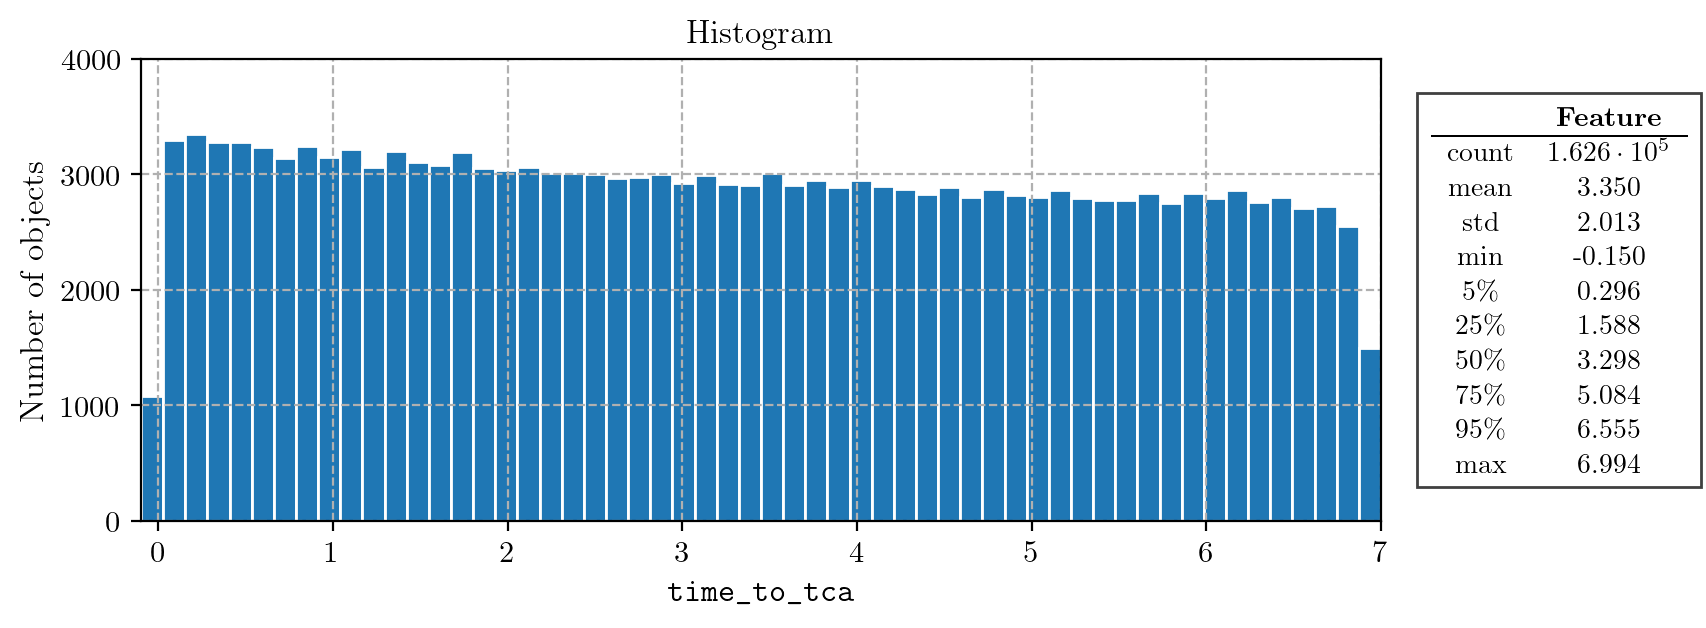

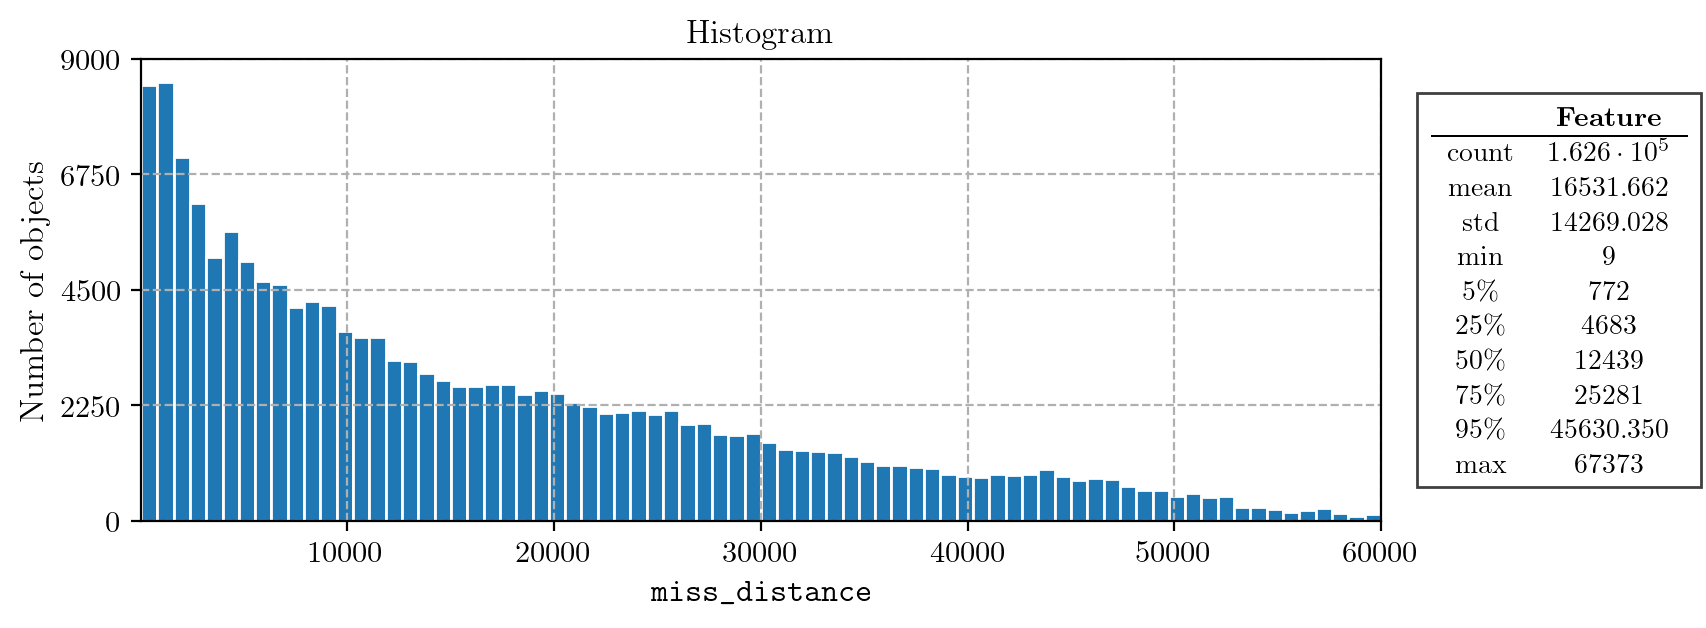

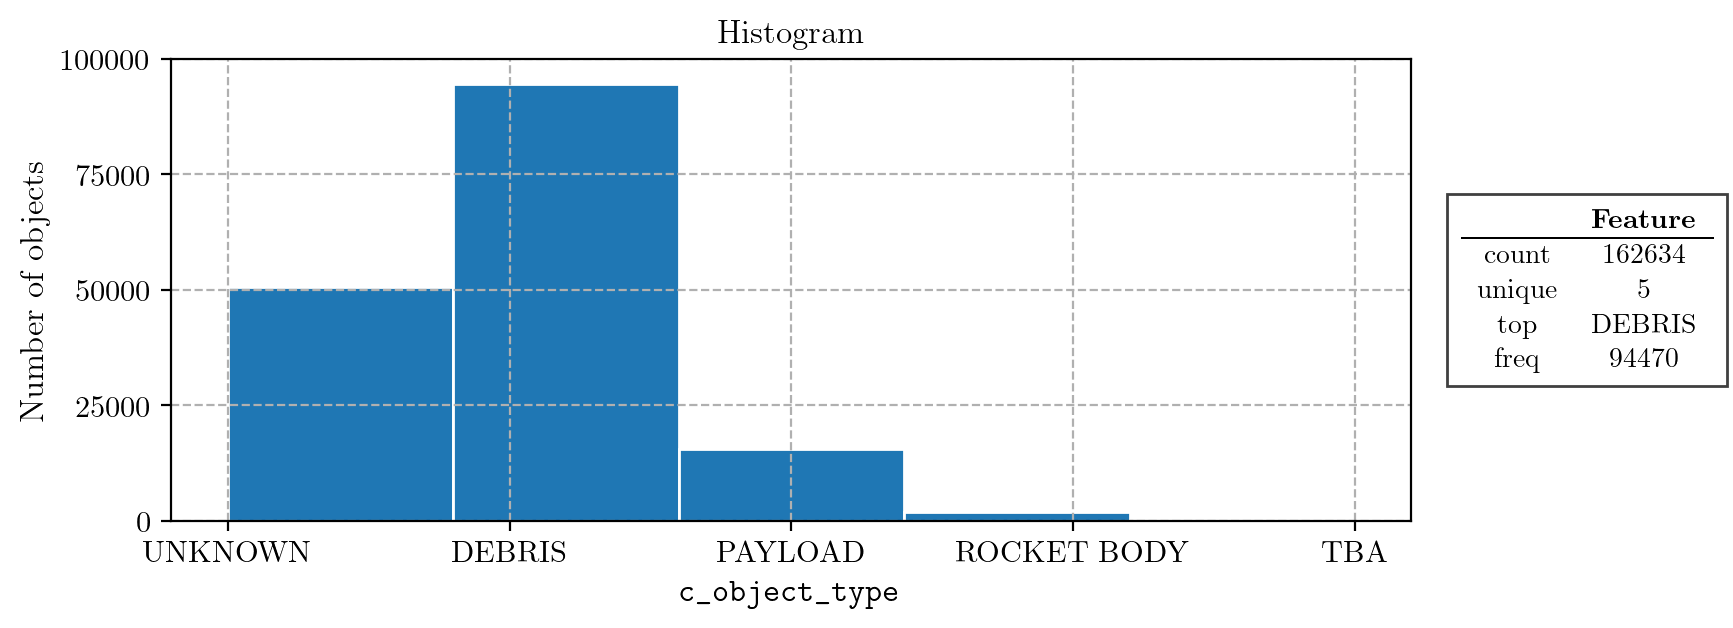

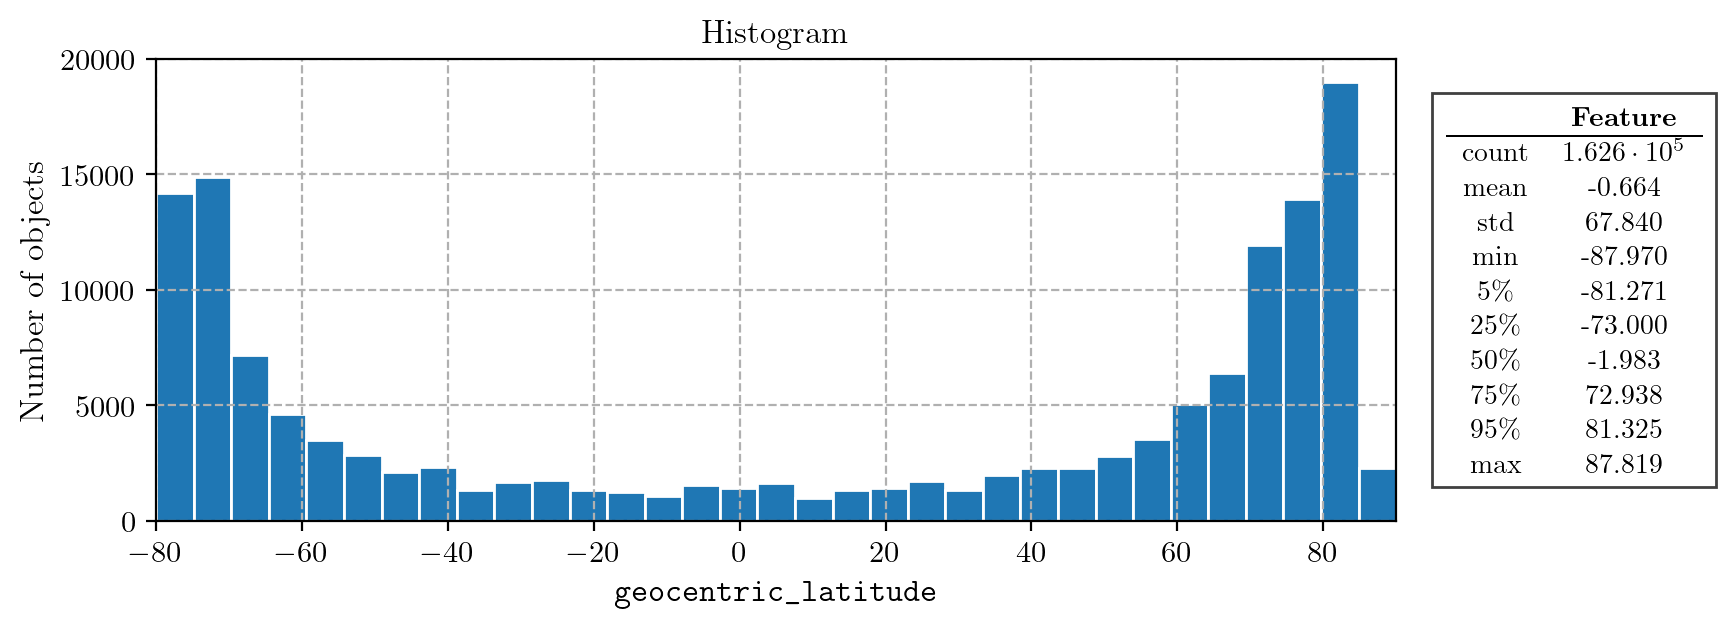

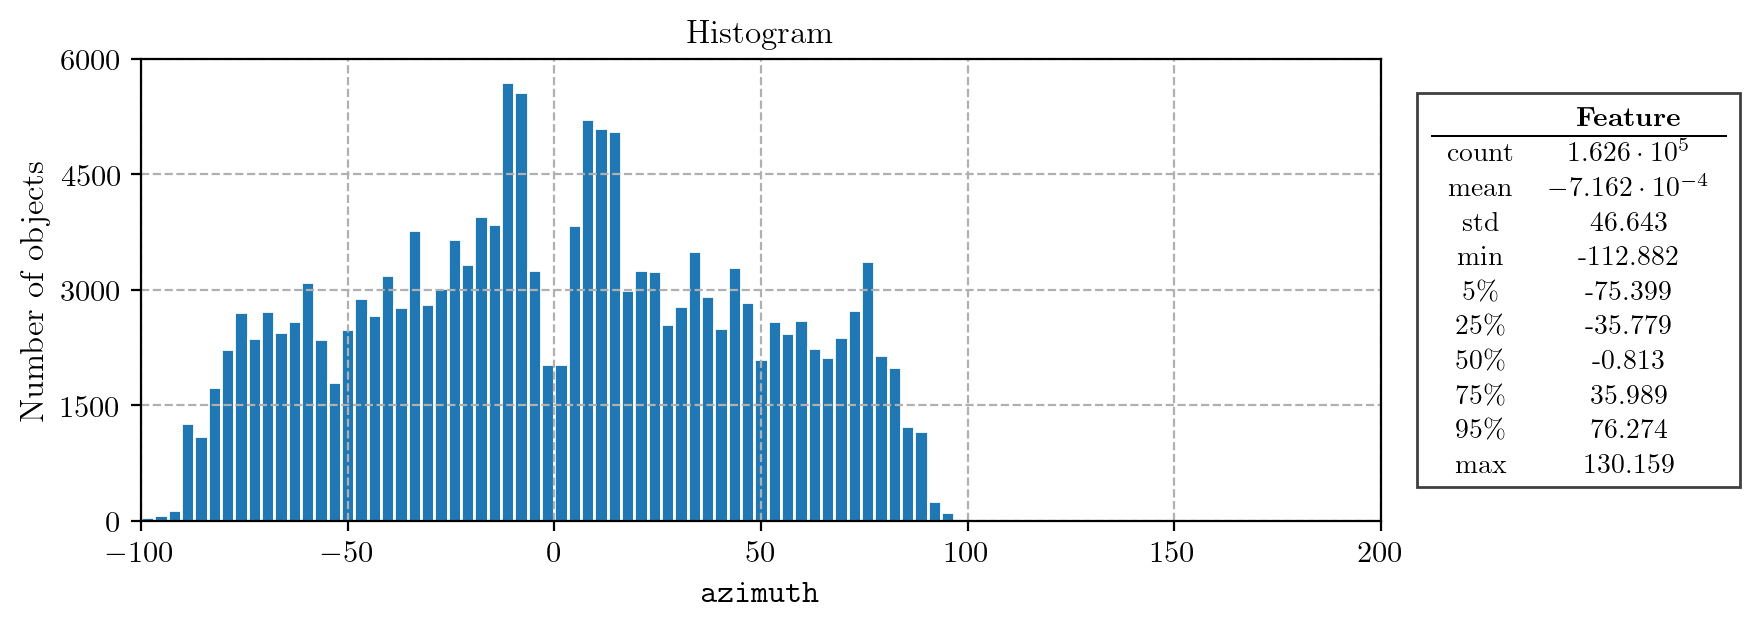

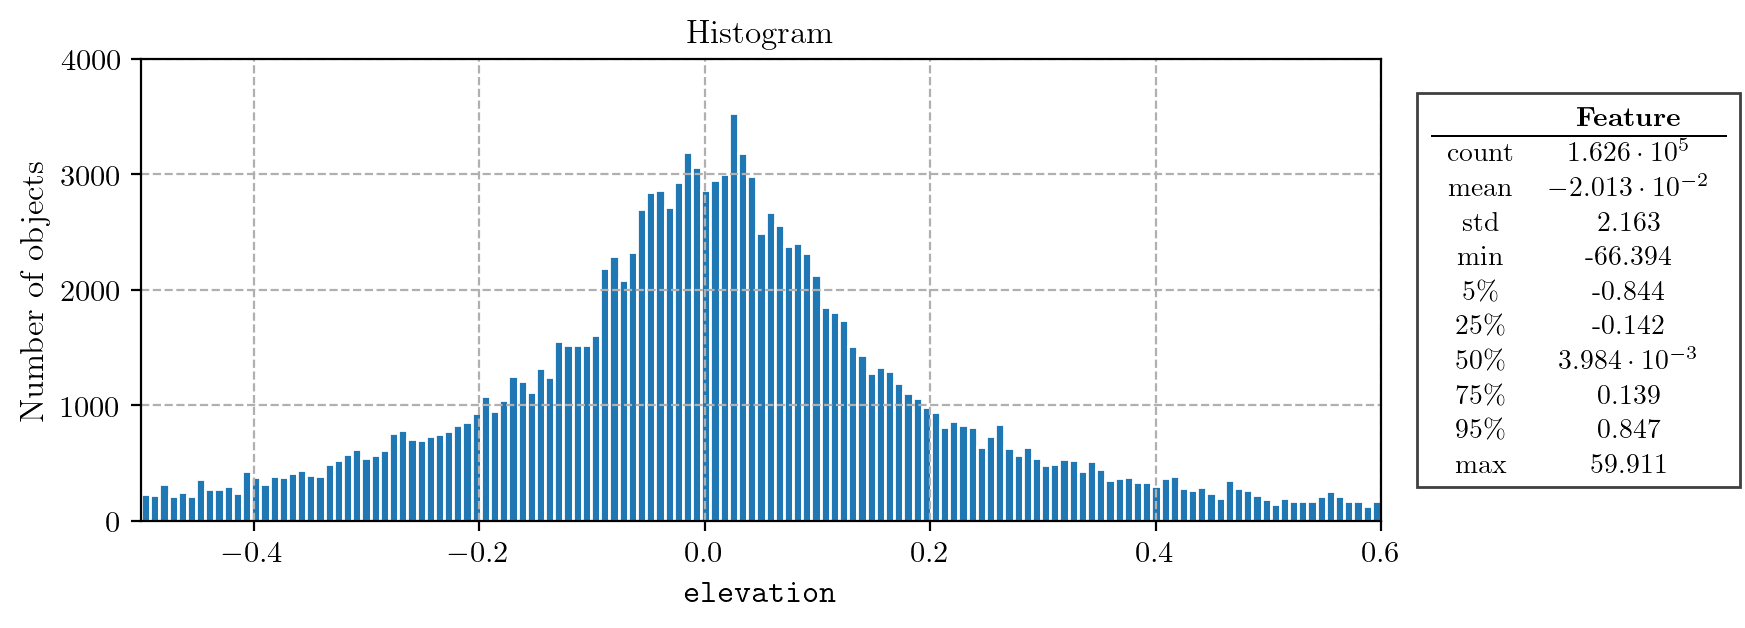

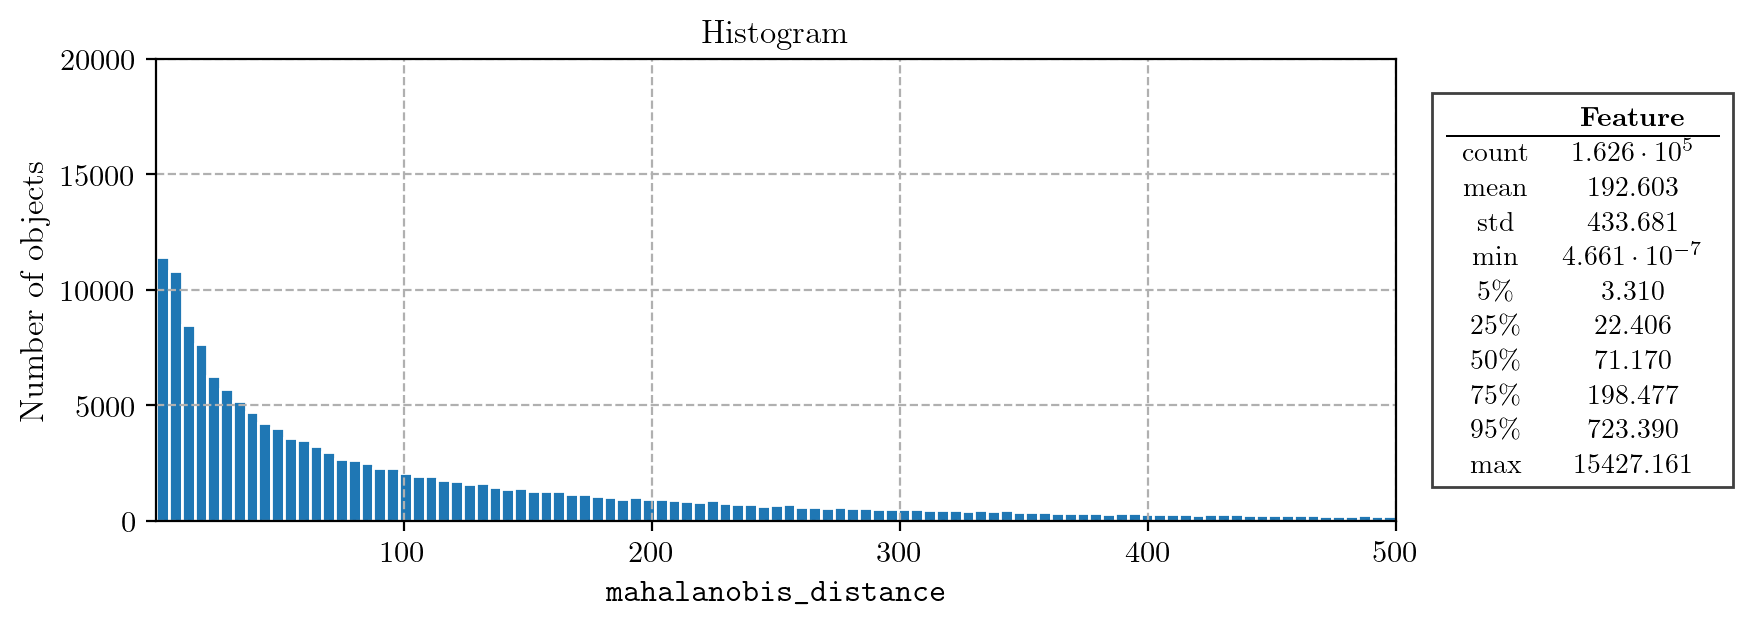

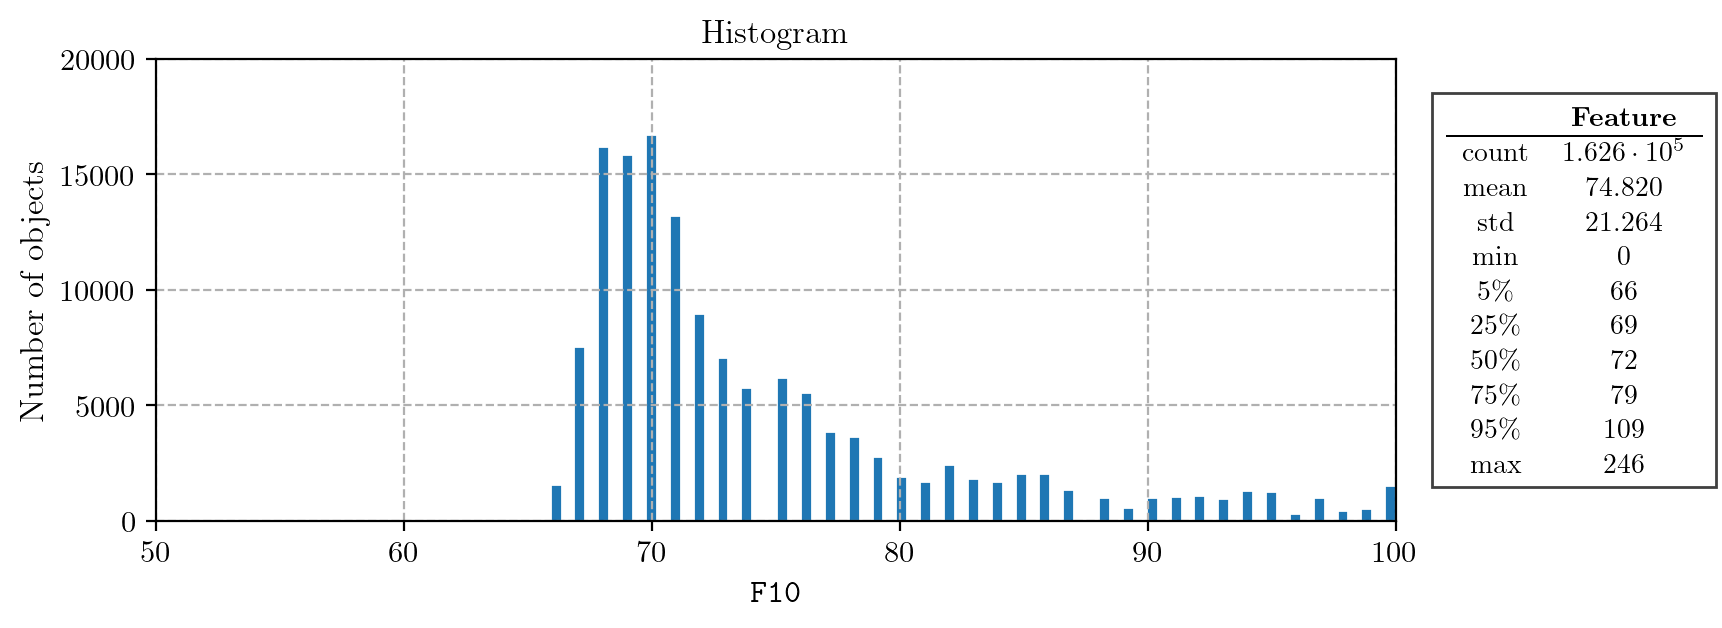

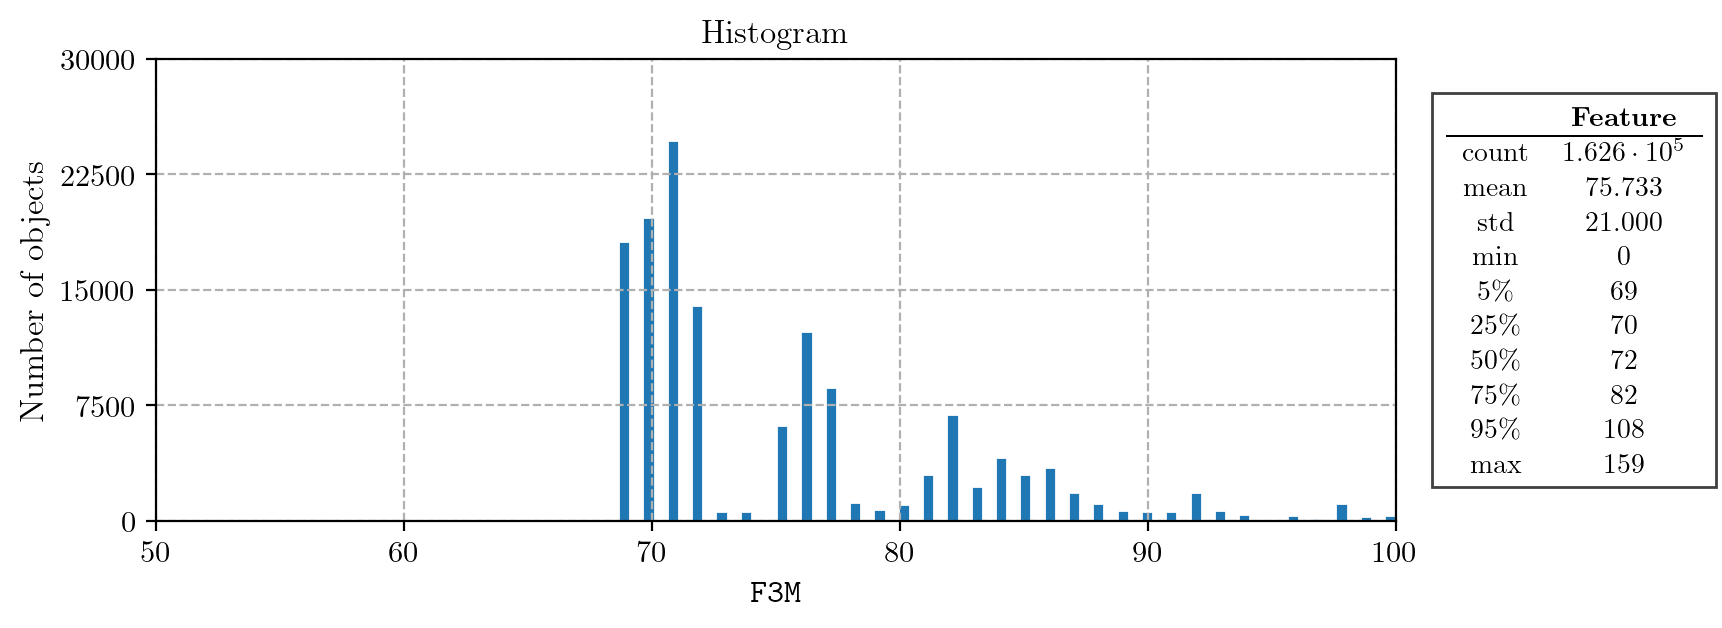

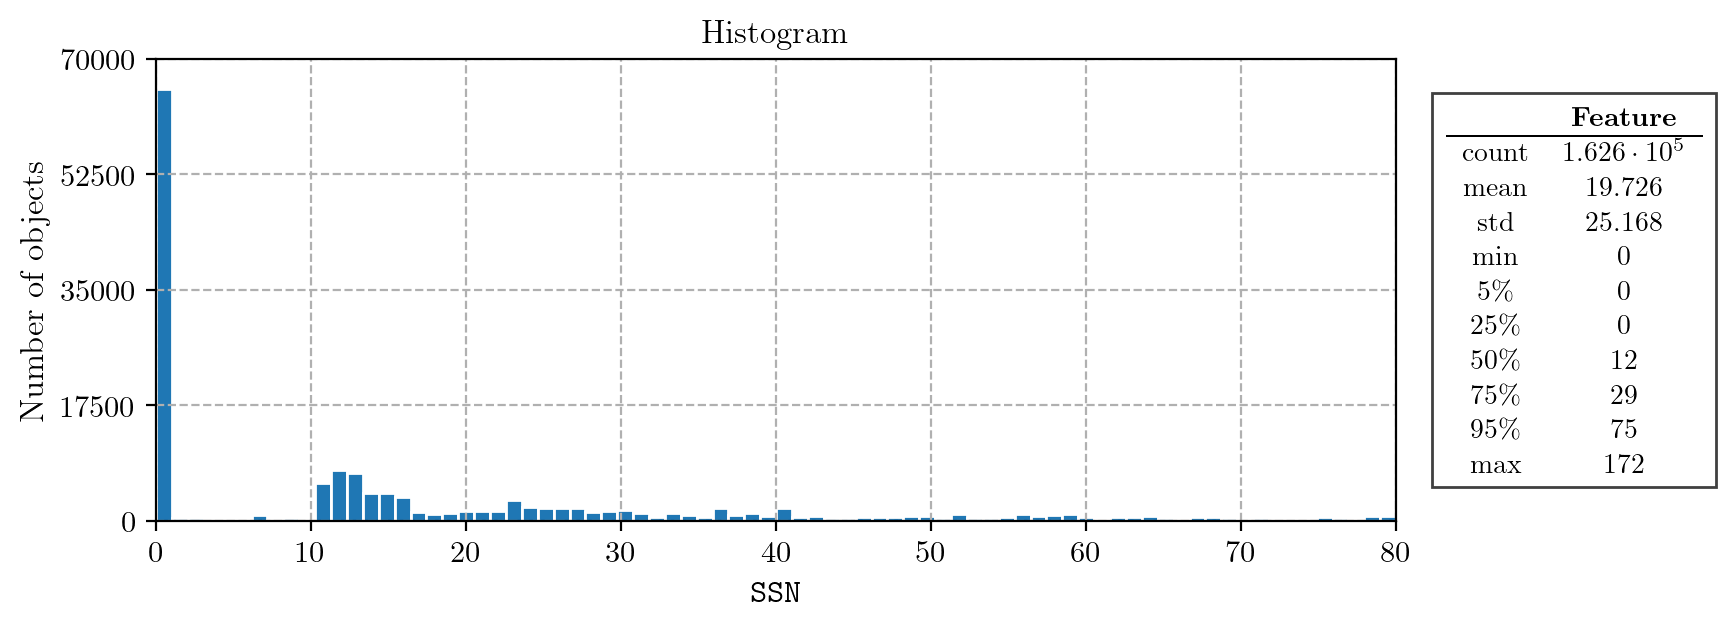

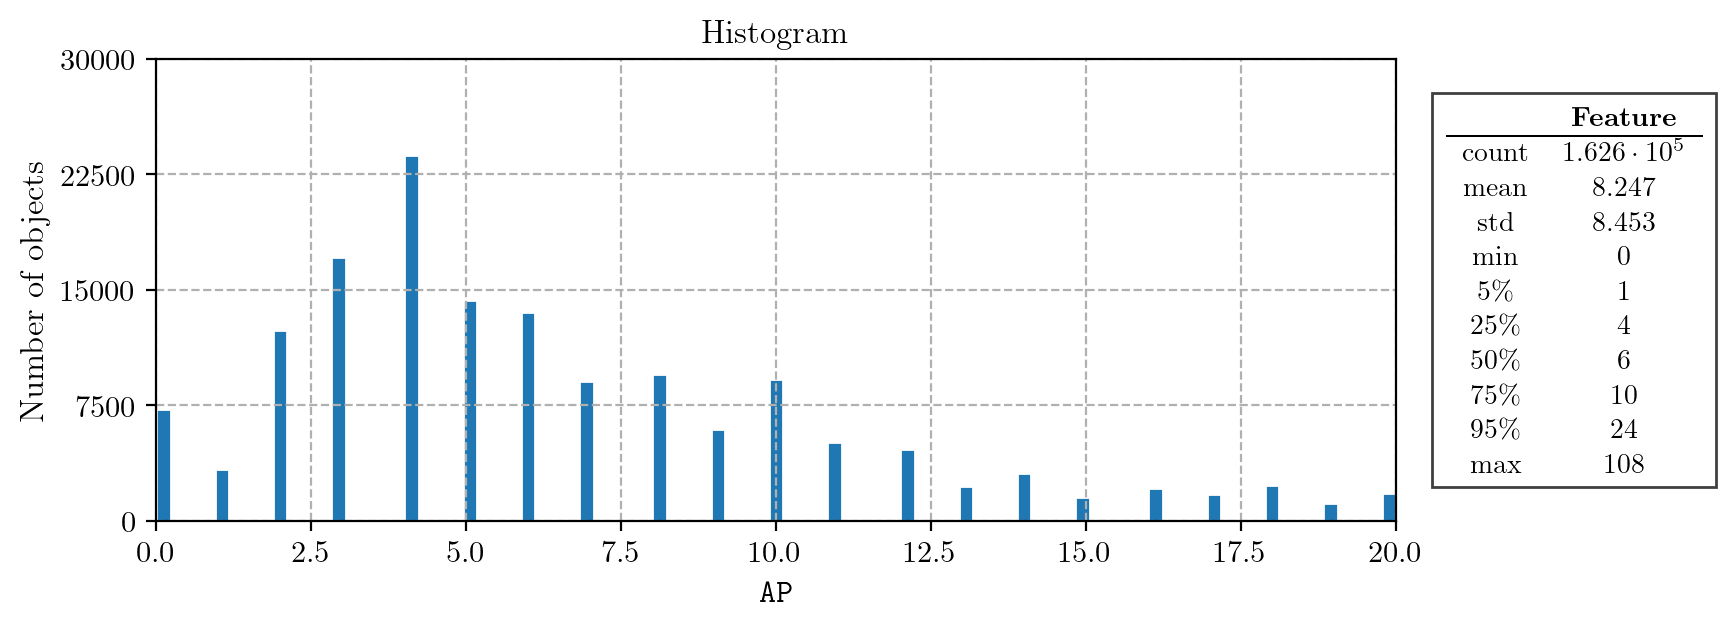

In [47]:
# Analyse the conjunction's data distributions
for feature in list(config.get_features(**{'cluster':'conjunction'}).keys()):
   
    # Plot histograms from conjunction measures
    filepath = os.path.join(cwd,'notebooks','images','histograms', 'conjunction-' + feature + '.pdf')
    kwargs = {'legend':False, 'describe_colnames':['Feature'], 'filepath': filepath}
    eda.plot_histogram(df, [feature], **kwargs)

### 2.2. - Relative state vector

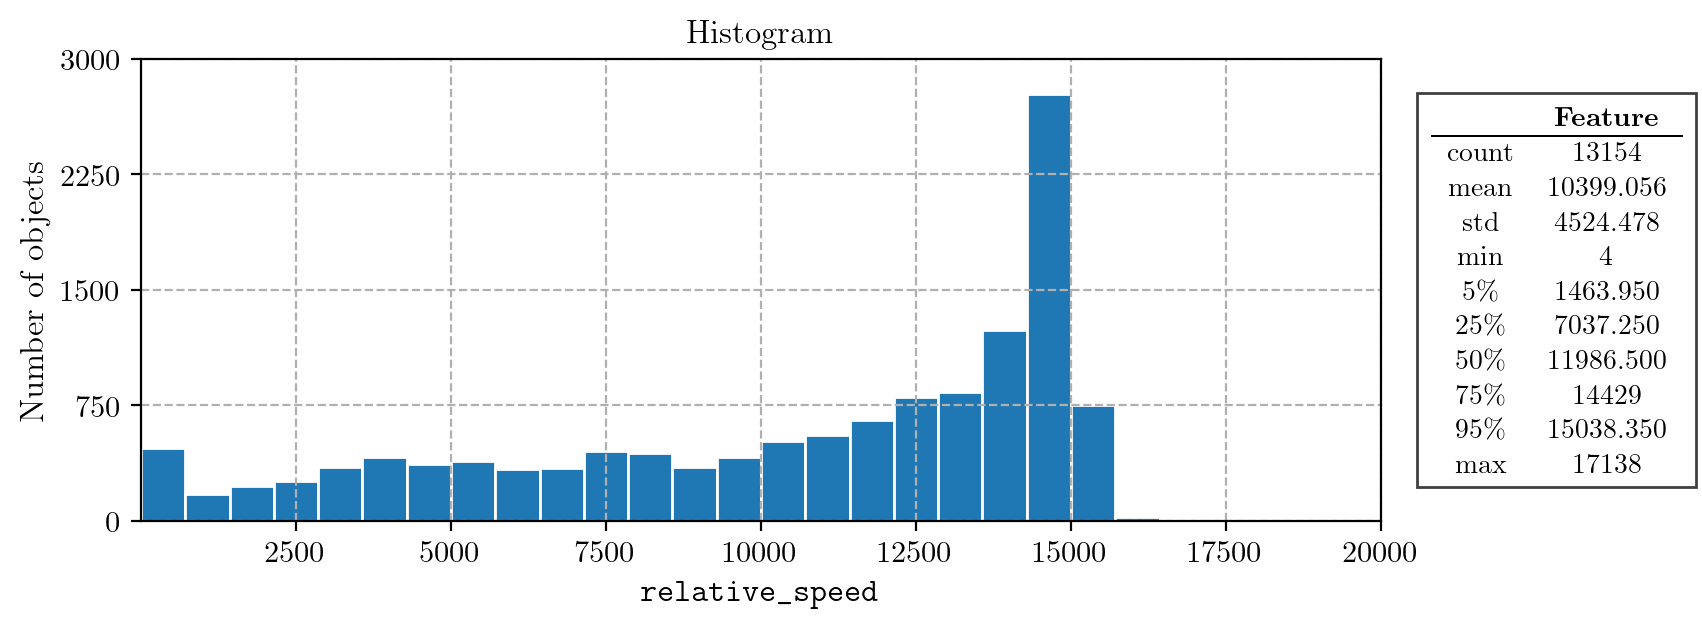

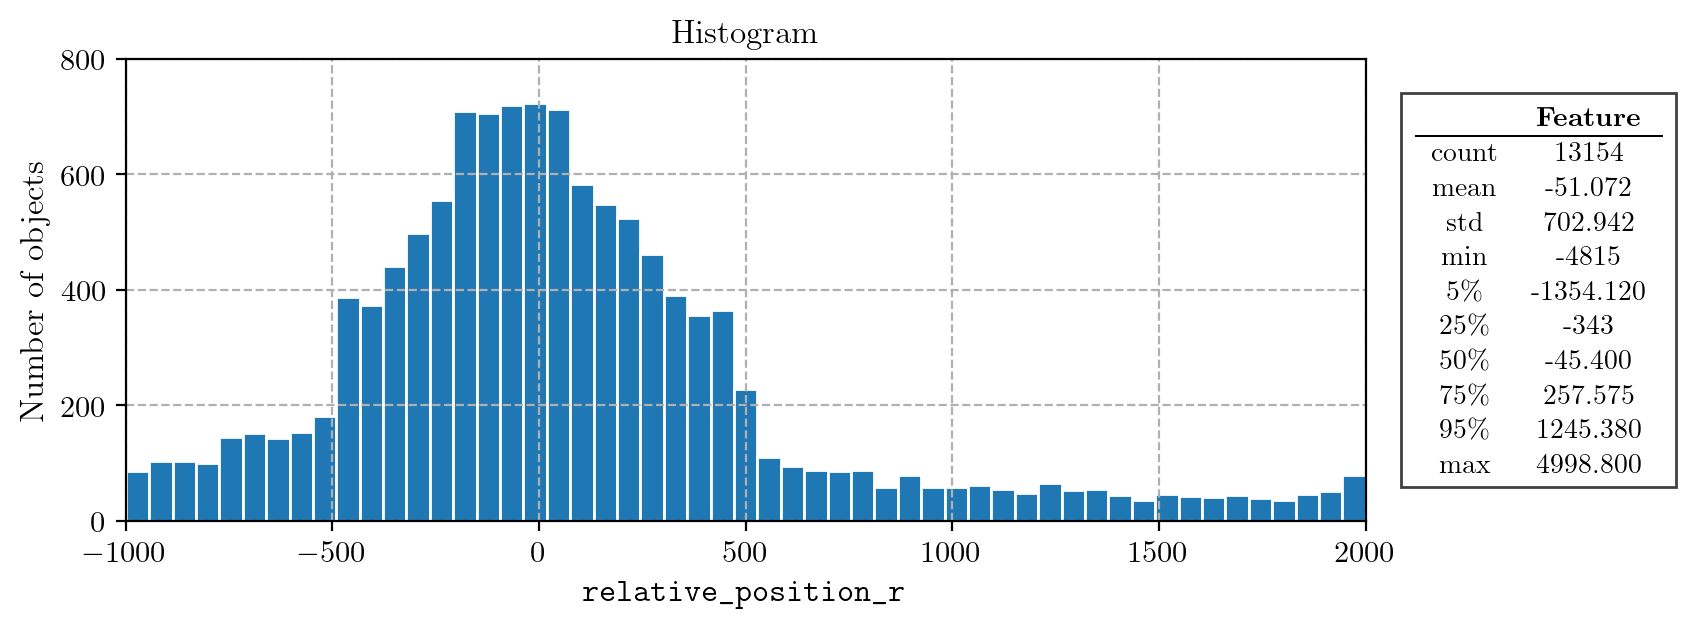

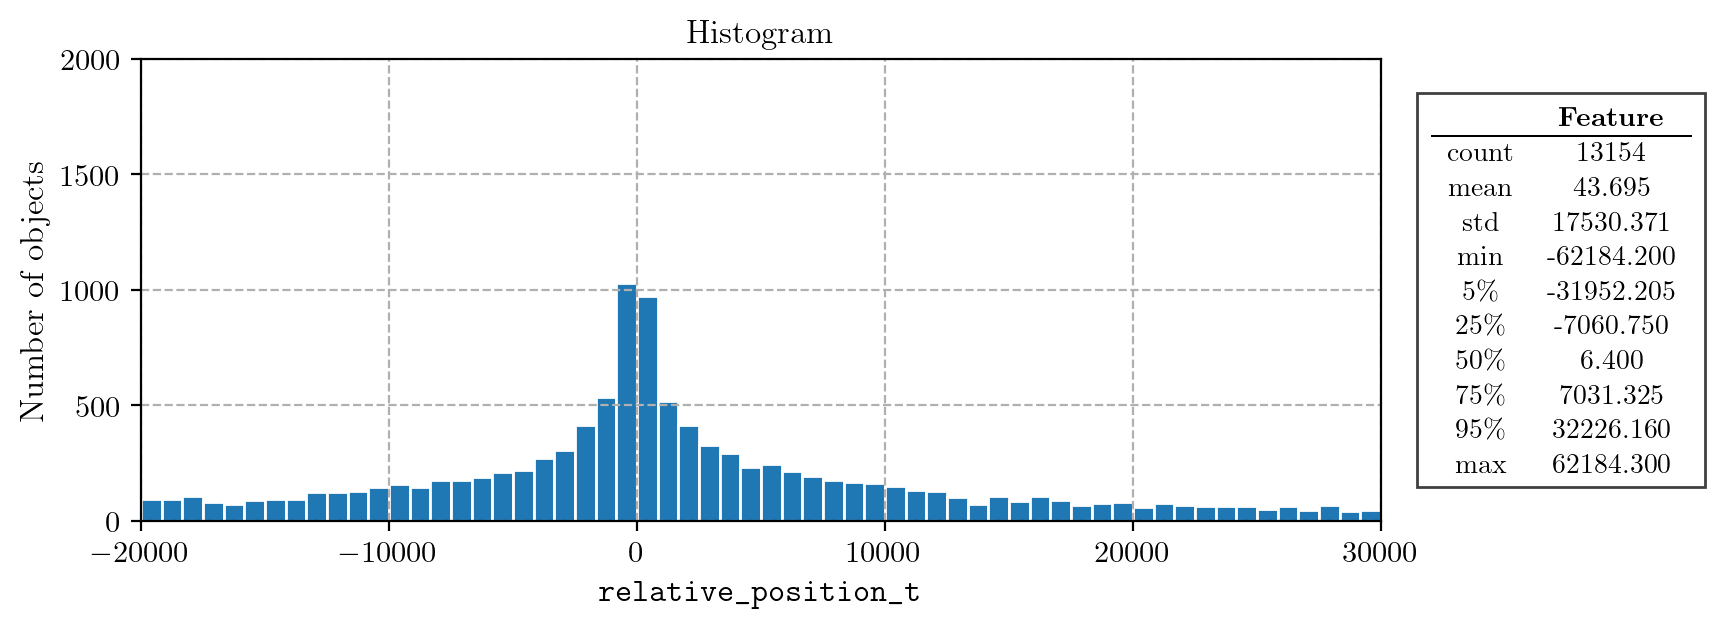

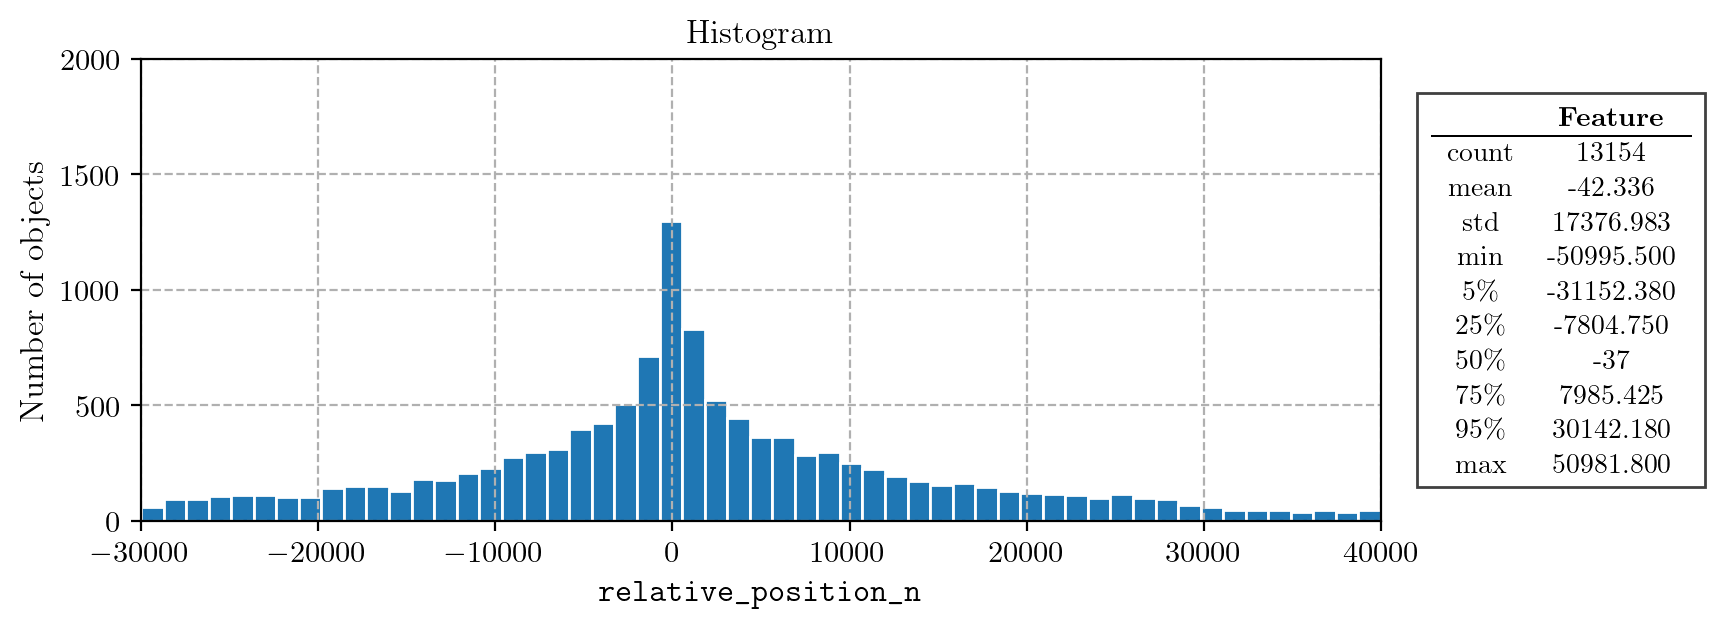

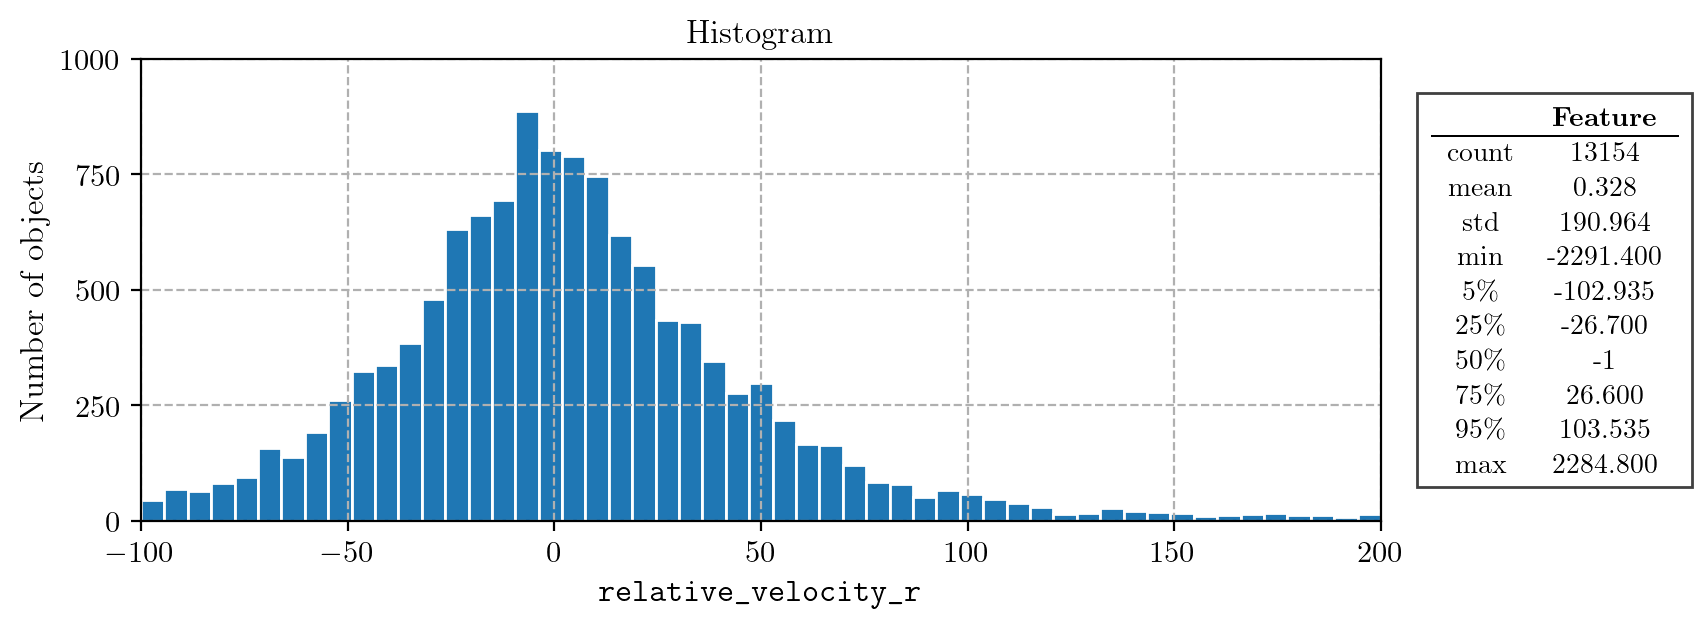

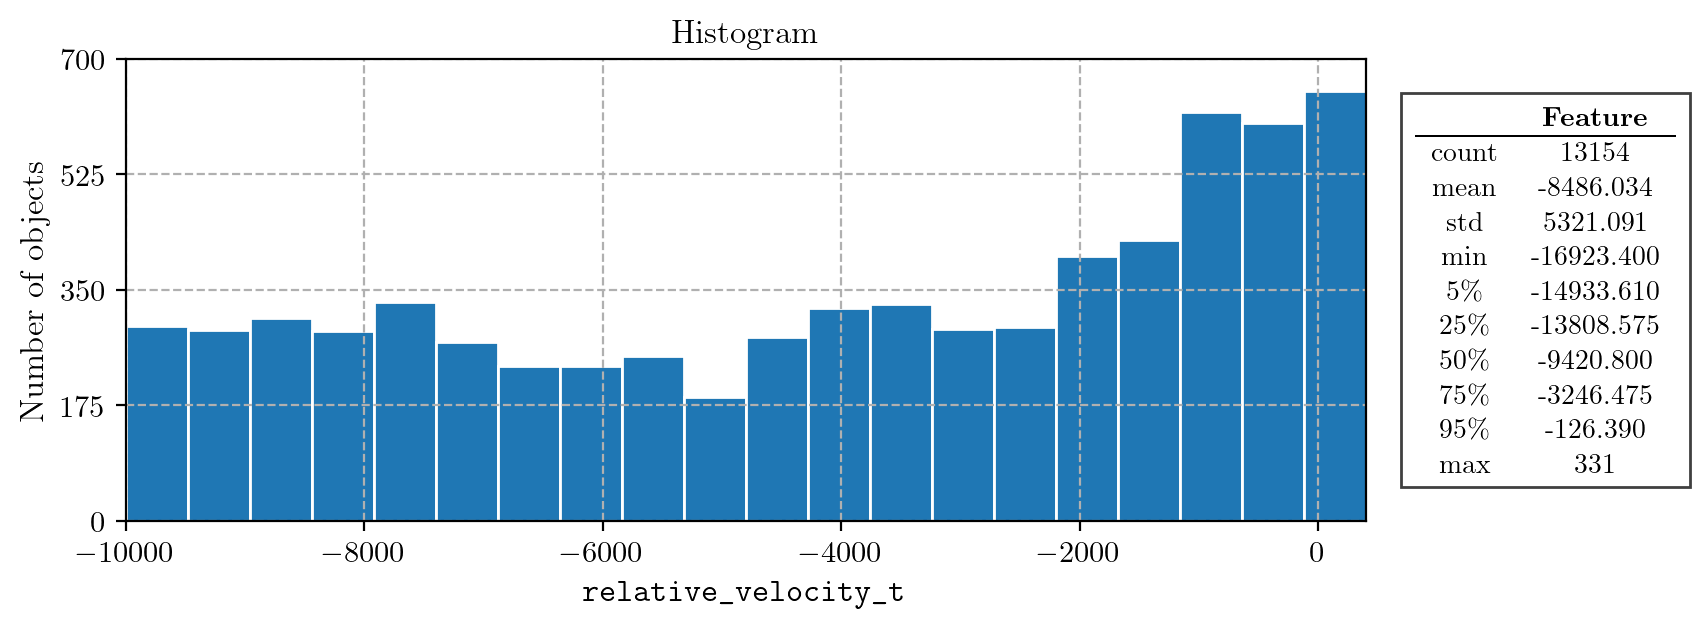

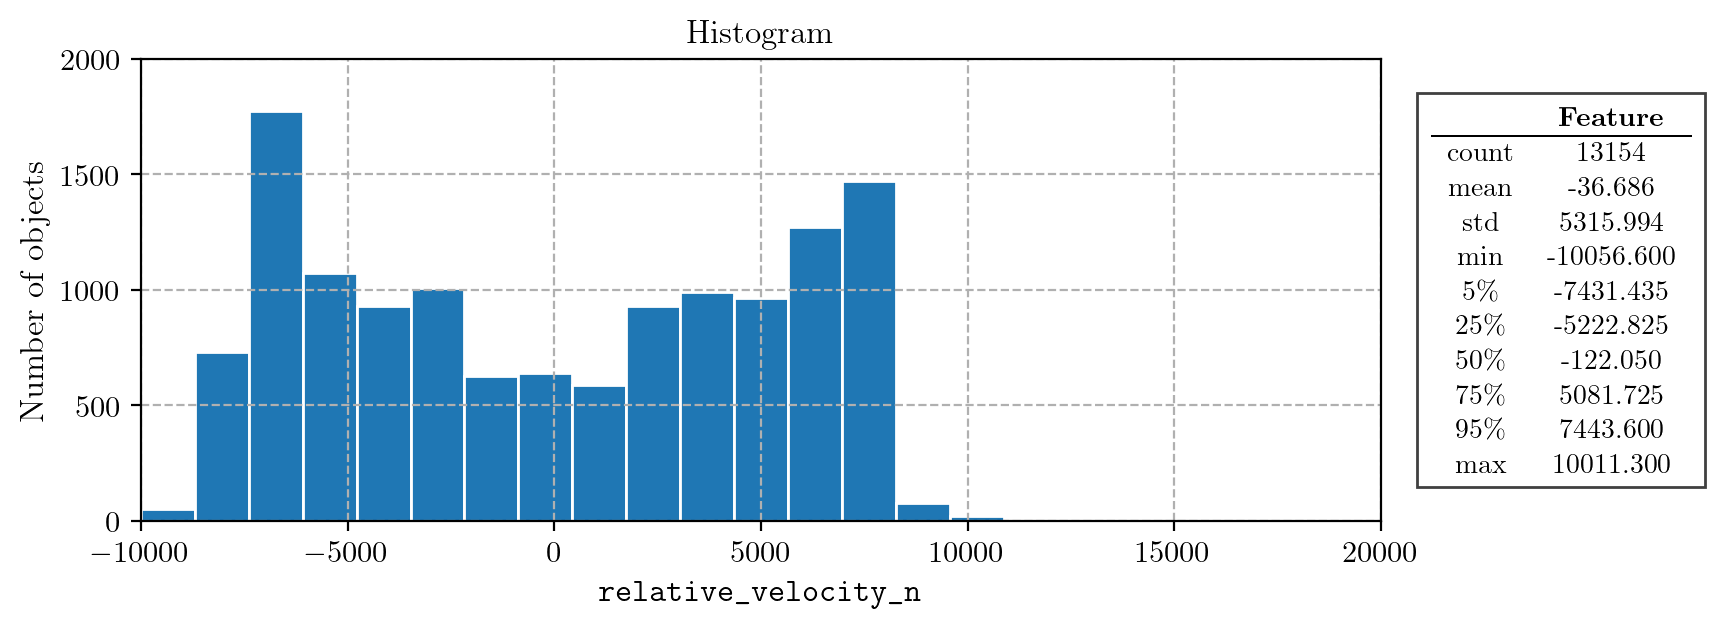

In [9]:
# Analyse the relative state vector's data distributions
for feature in list(config.get_features(**{'cluster':'relative_state'}).keys()):

    # Plot histograms from conjunction measures
    filepath = os.path.join(cwd,'notebooks','images','histograms', 'relative_state-' + feature + '.pdf')
    kwargs = {'legend':False, 'describe_colnames':['Feature'], 'filepath': filepath}
    eda.plot_histogram(df_lastCDM, [feature], **kwargs)

In [63]:
min_value = df_lastCDM['relative_velocity_r'].min()
max_value = df_lastCDM['relative_velocity_r'].max()
print(max_value-min_value)
print(utils.round_by_om(max_value-min_value))


4576.200000000001
5000


### 2.2. - Orbital elements

The analysis of the orbital analysis data distribution for *Targets* objects as well as the multicollinearity underlying data is key in the SCDMG method as it allows the creation of random starting positions of ASOs in orbit (including *Chaser* objects).

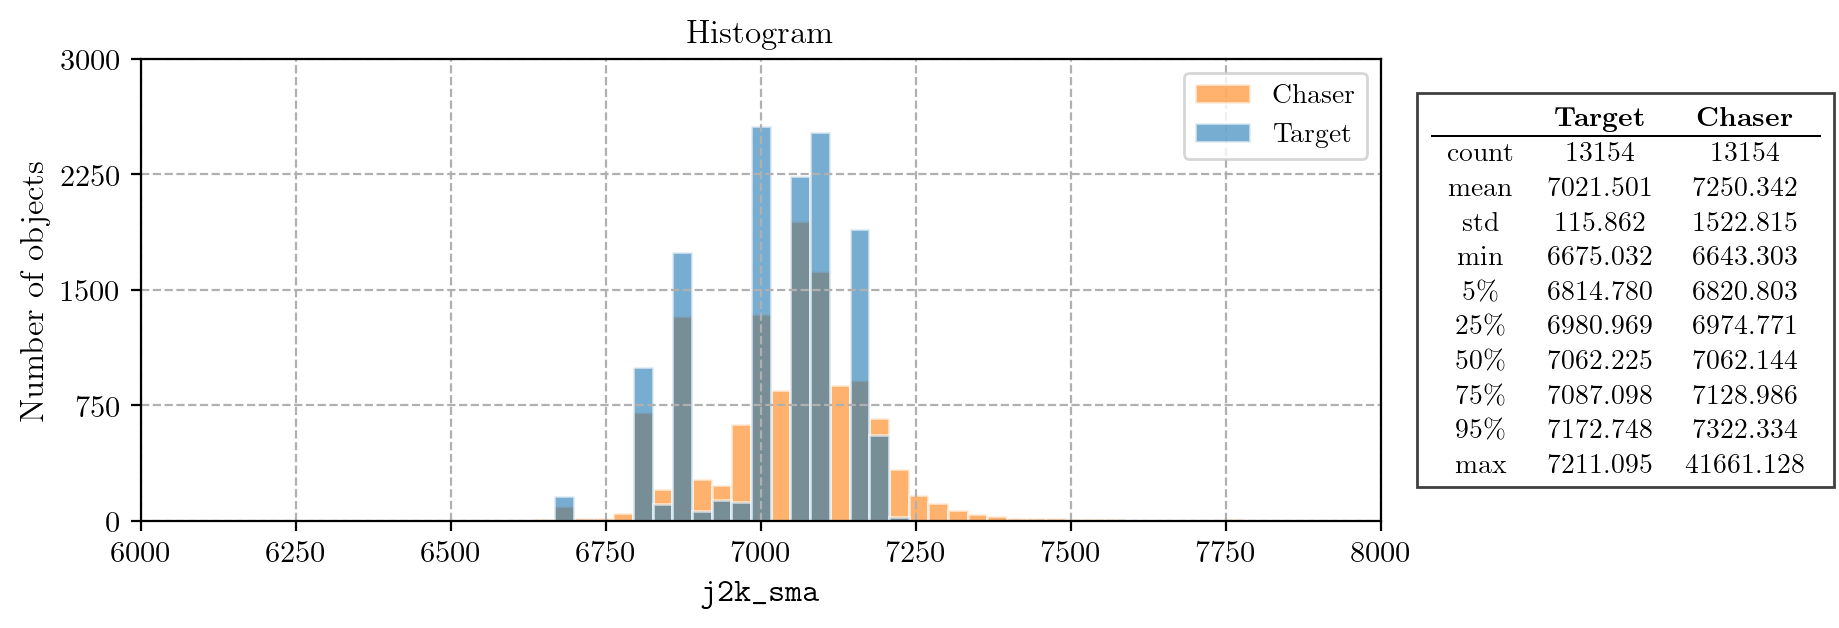

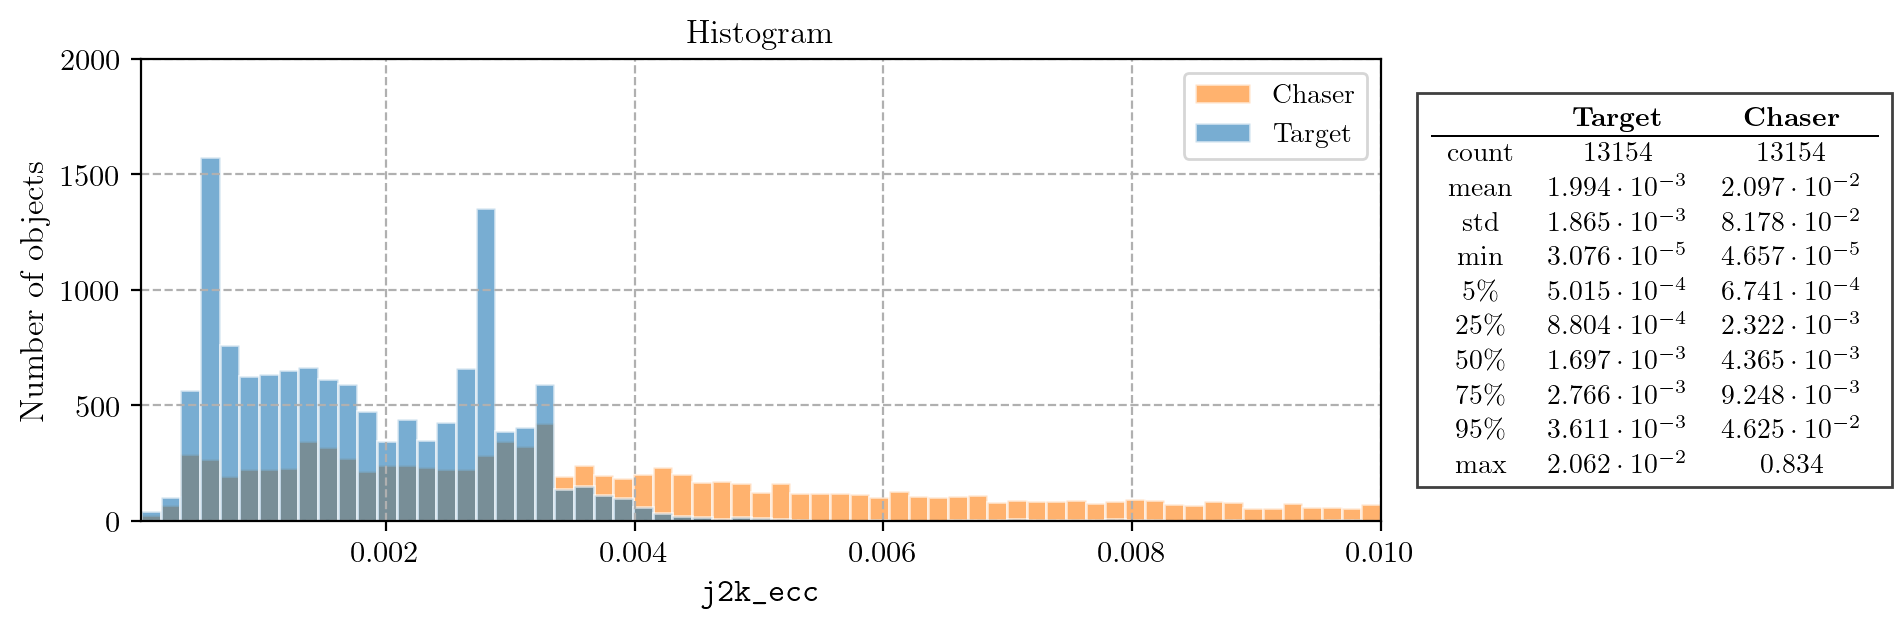

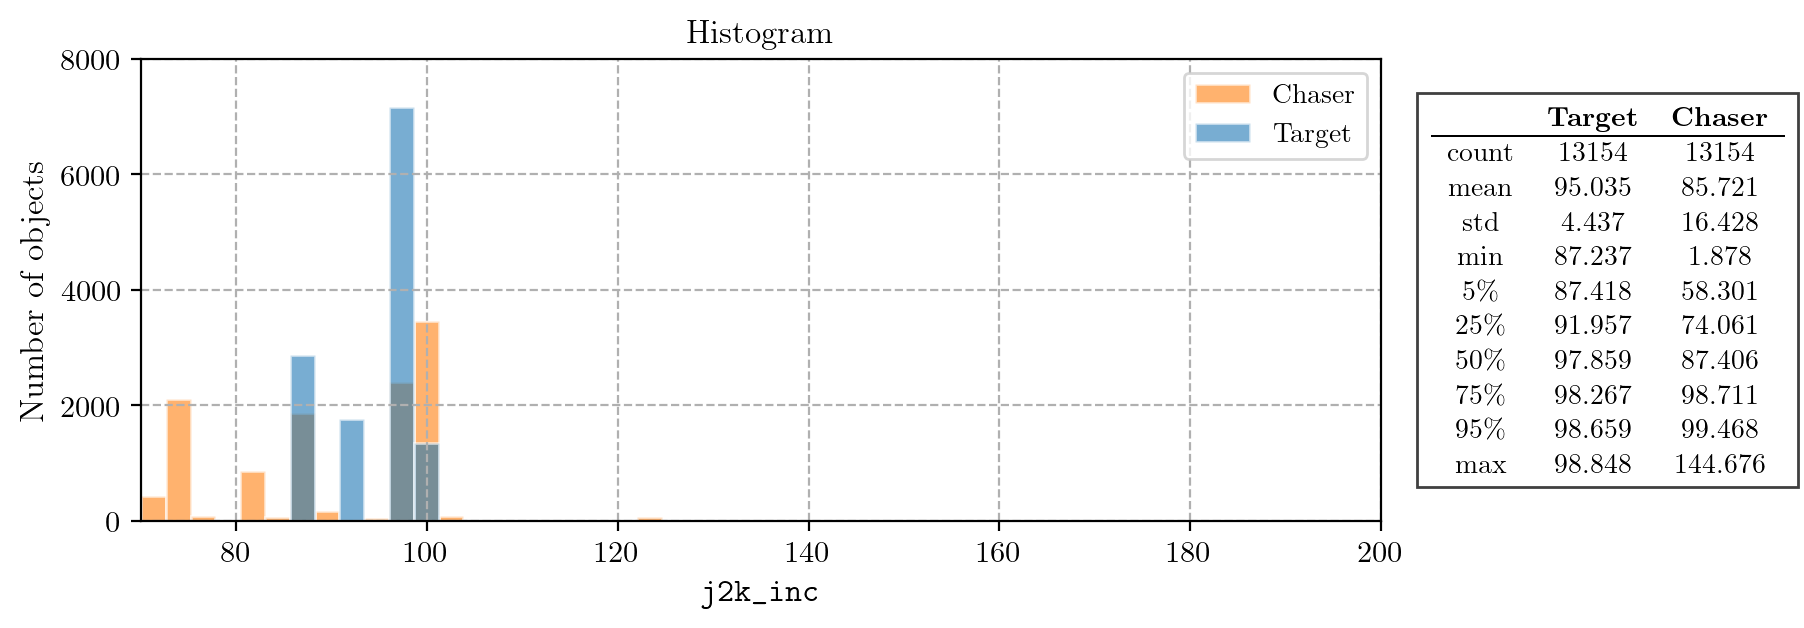

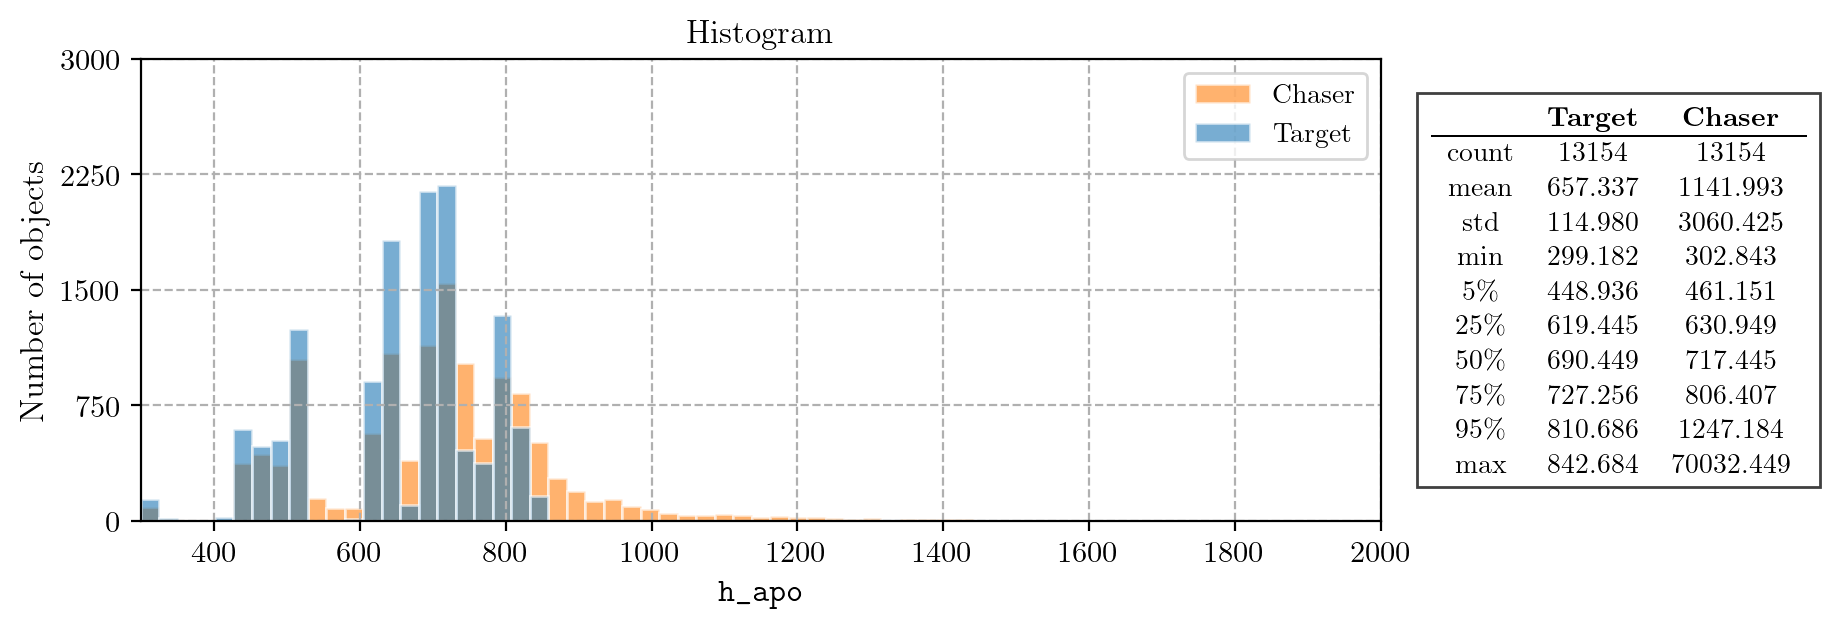

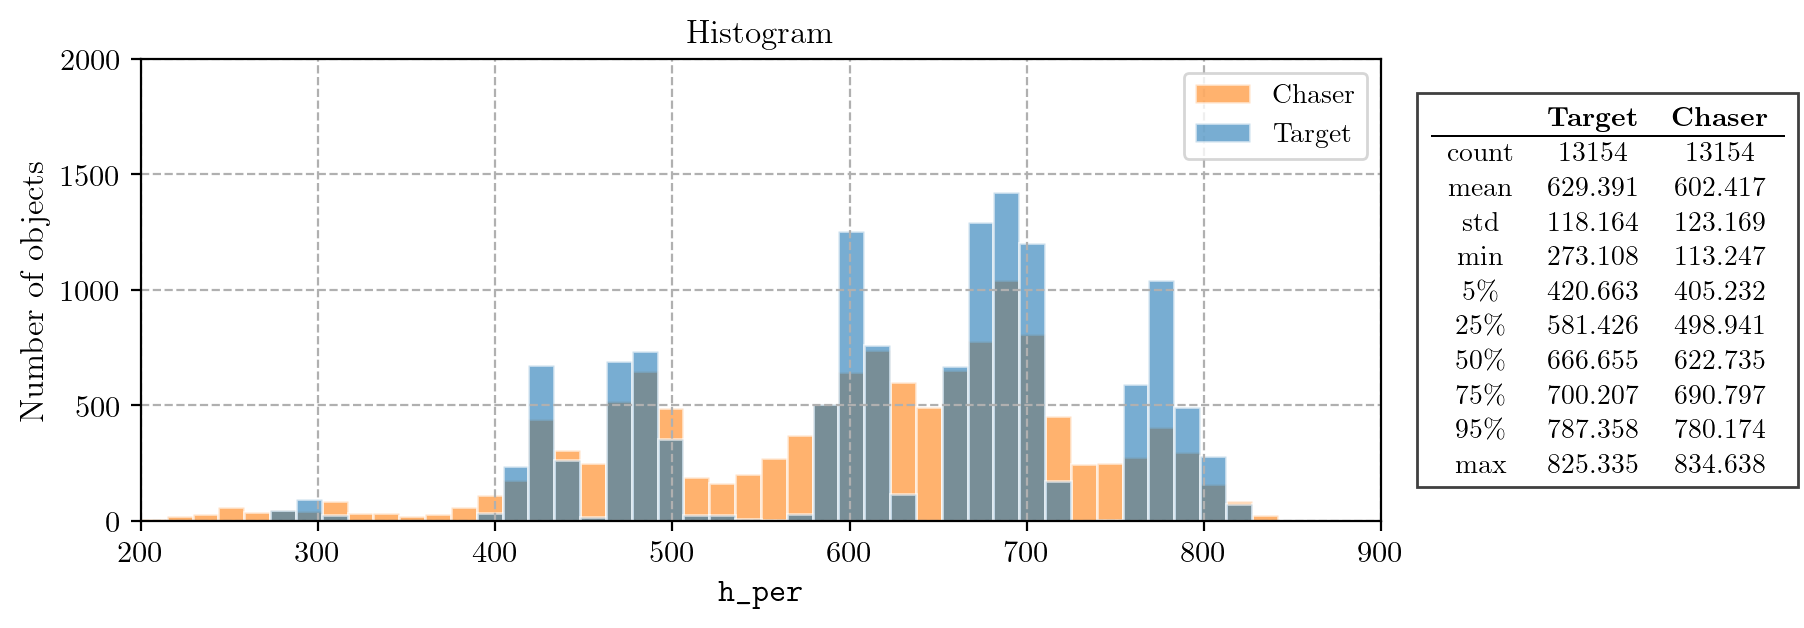

In [13]:
# Analyse the conjunction's data distributions
for feature in list(dict.fromkeys([f[2:] for f in list(config.get_features(**{'cluster':'orb_elements'}).keys())])):

    # Plot Target and Chaser histograms
    filepath = os.path.join(cwd,'notebooks','images','histograms', 'orb_elements-' + feature + '.pdf')
    kwargs = {'hist_kwargs': [dict(label=r'Target', color='tab:blue', alpha=0.6), dict(label=r'Chaser', color='tab:orange', alpha=0.6)],
              'xlabel': r'\texttt{' + feature + '}', 'describe_colnames':[r'Target', r'Chaser'], 'filepath':filepath}

    features = [o + feature for o in ['t_', 'c_']]

    eda.plot_histogram(df_lastCDM, features, **kwargs)

### 2.2. - Ballistic and Solar radiation coefficients


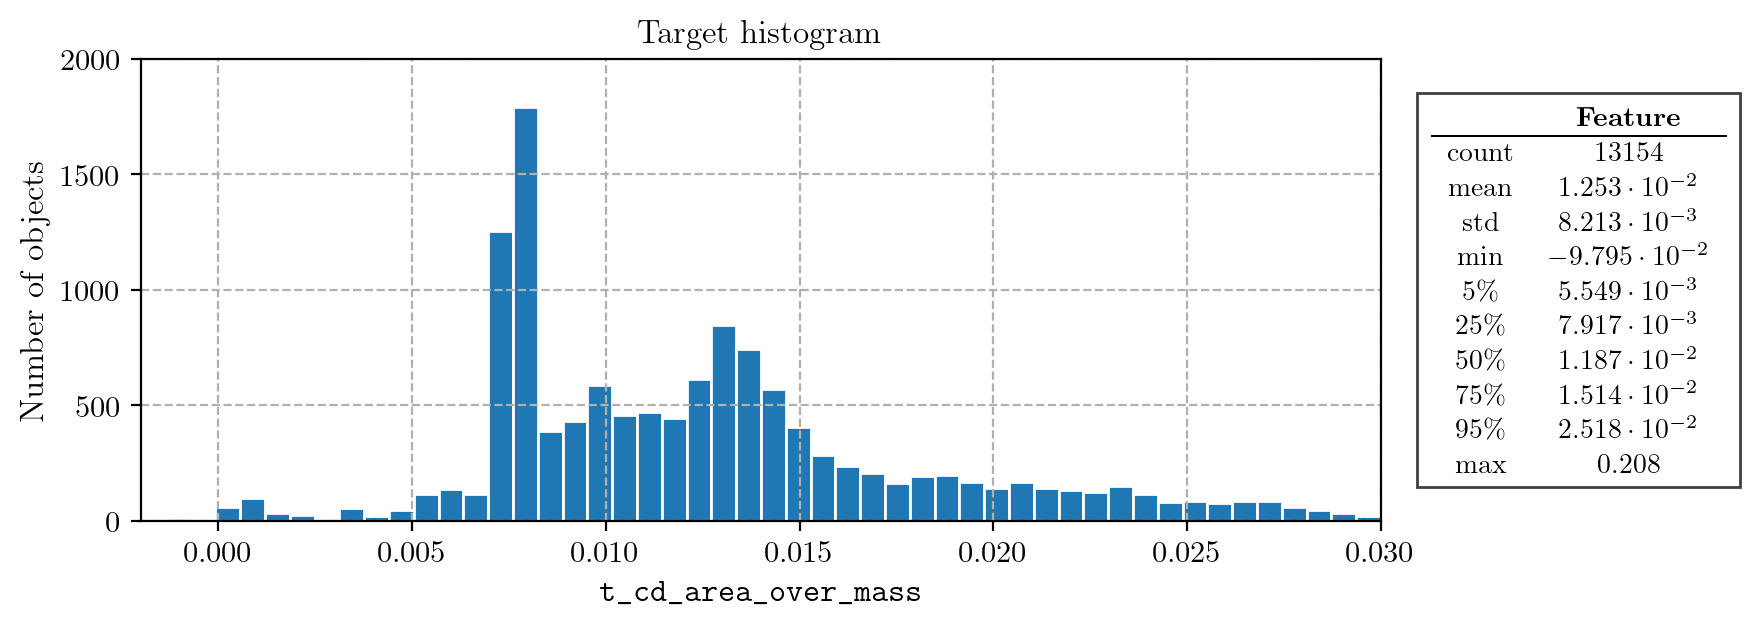

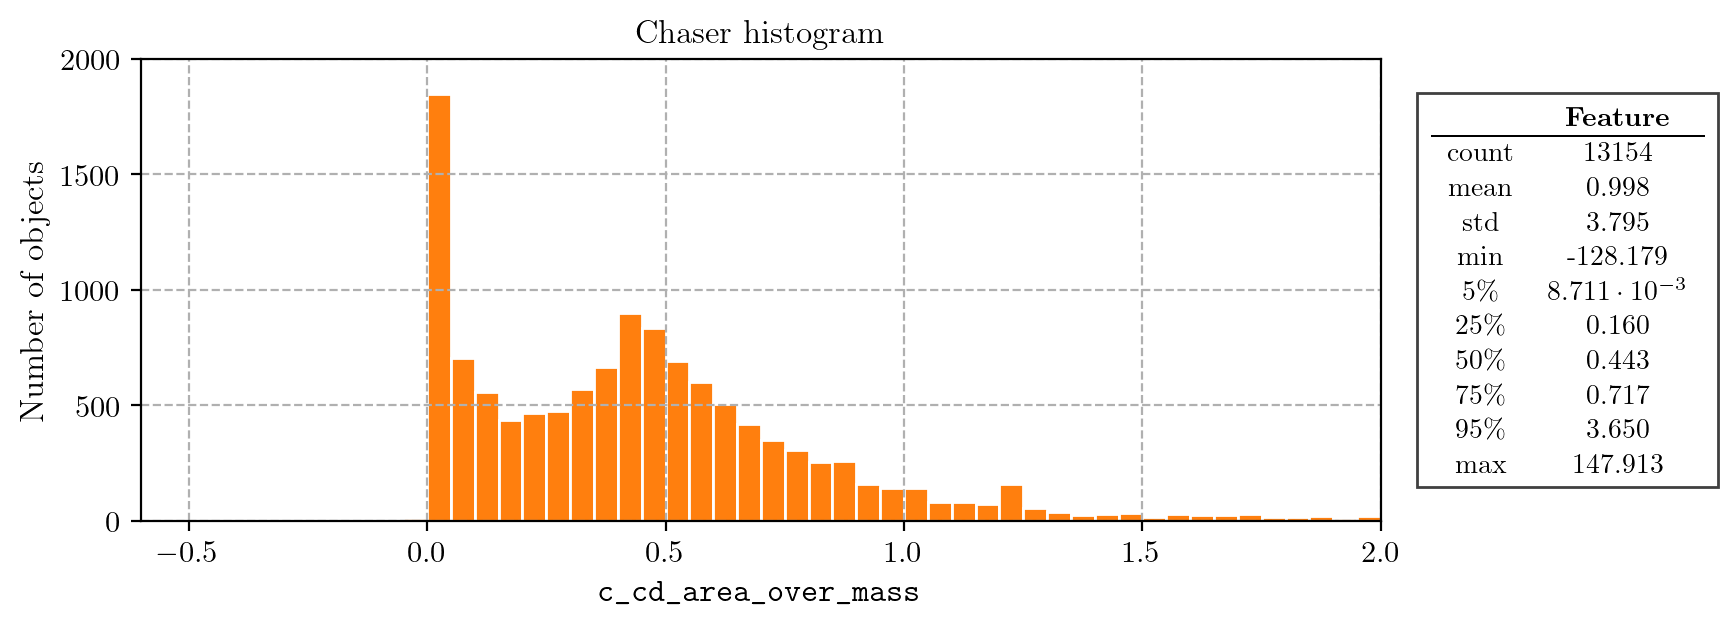

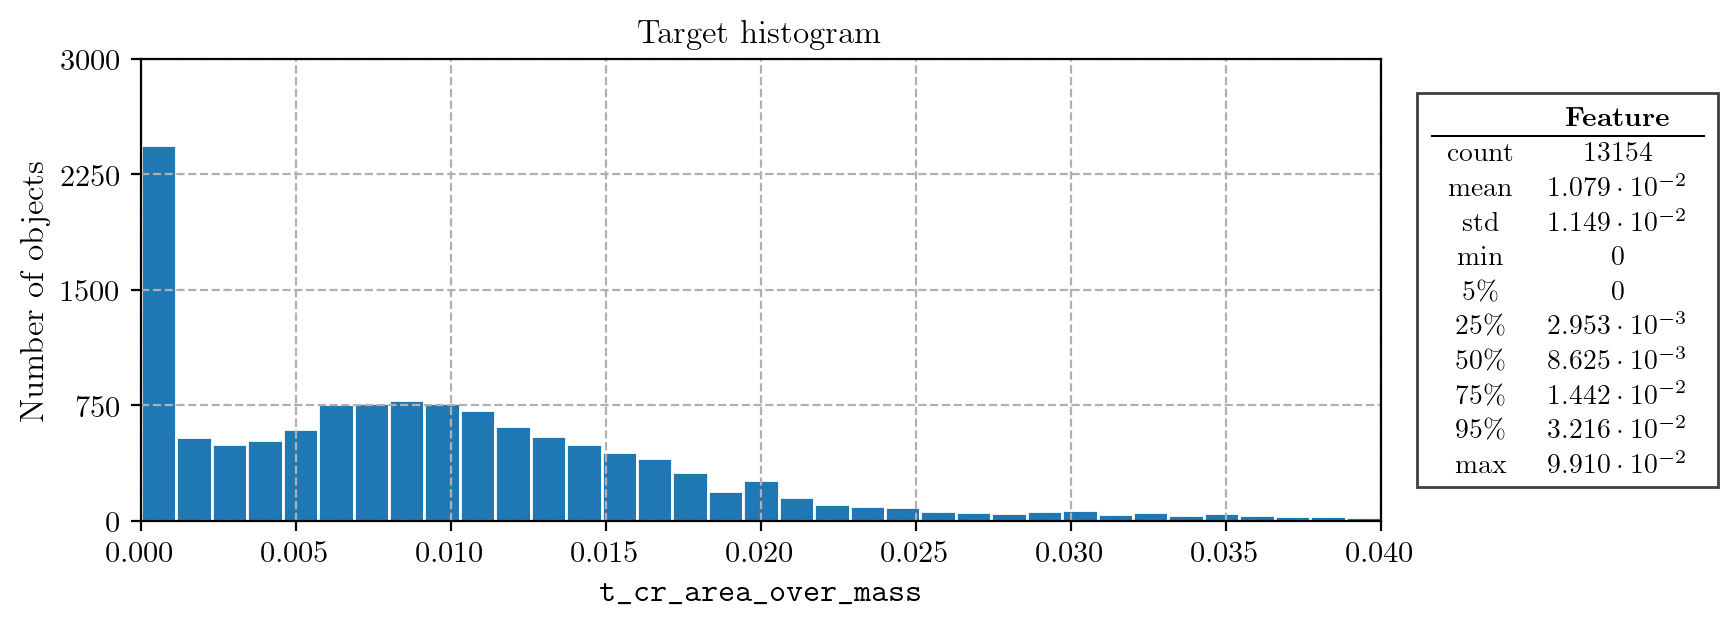

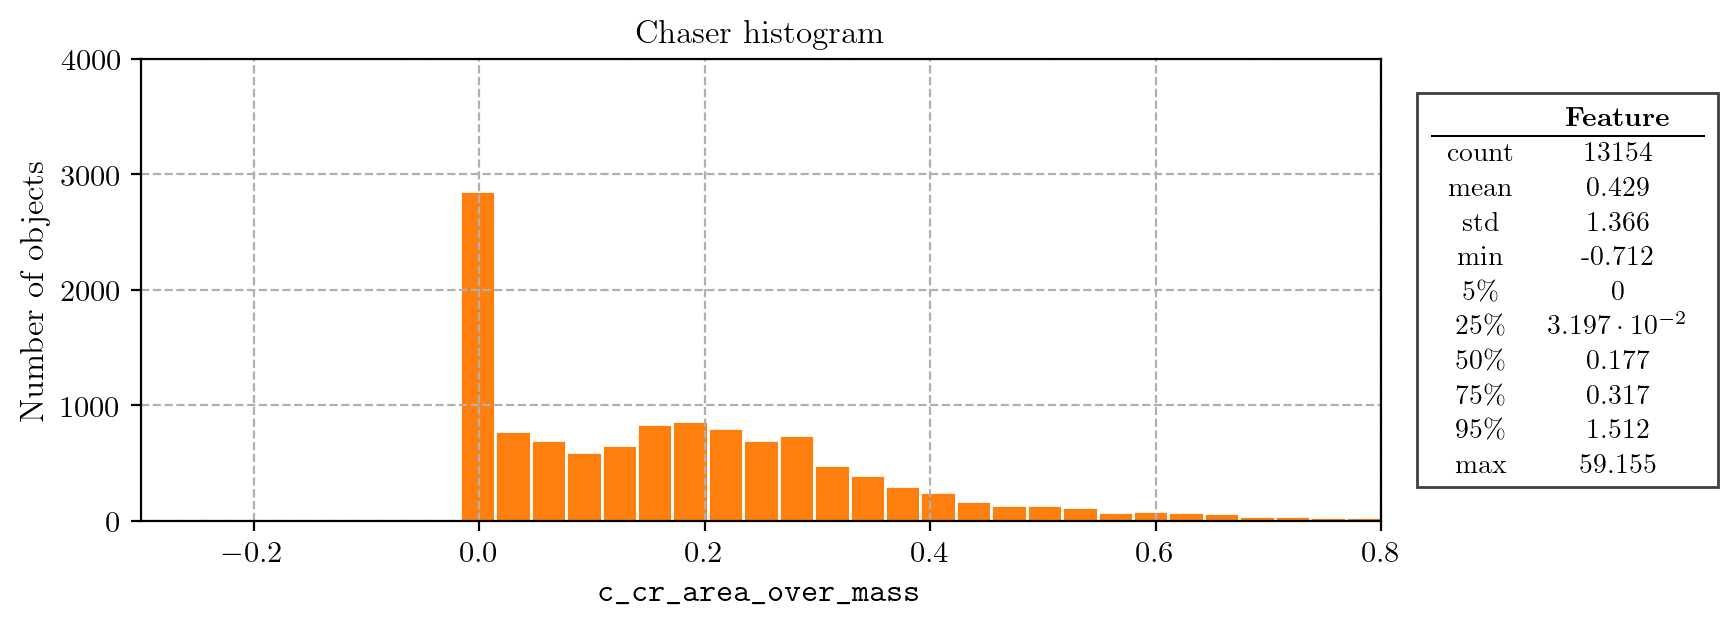

In [14]:
# Analyse the conjunction's data distributions
for xfeature in list(dict.fromkeys([f[2:] for f in list(config.get_features(**{'cluster':'coefficients'}).keys())])):
    for o, obj in enumerate(['target', 'chaser']):
        # Plot Target and Chaser histograms
        filepath = os.path.join(cwd,'notebooks','images','histograms', 'coefficients-' + obj[0] + '_' + xfeature + '.pdf')
        kwargs = {'hist_kwargs': [[dict(label=r'Target', color='tab:blue'), dict(label=r'Chaser', color='tab:orange')][o]],
                'xlabel': r'\texttt{' + obj[0] + '_' + xfeature + '}', 
                'describe_colnames':[r'Feature'],
                'title': obj.capitalize() + ' histogram',
                'legend': False, 'filepath':filepath}
        eda.plot_histogram(df_lastCDM, [obj[0] +'_'+ xfeature], **kwargs)

### 2.3. - State vector covariance matrix

The analysis of the covariance matrix in the RTN Coordinate frame of the state vector is key as it is a measure of the error of the orbit prediction. From a mathematical perspective, it is expressed as follows:

$$\newcommand{\cov}{\mathrm{cov}}
\begin{bmatrix}
\sigma^2_{R} & - & - & - & - & - \\
\cov(T,R) & \sigma^2_{T} & - & - & - & - \\
\cov(N,R) & \cov(N,T) & \sigma^2_{N} & - & - & - \\
\cov(\dot{R},R) & \cov(\dot{R},T) & \cov(\dot{R},N) & \sigma^2_{\dot{R}} & - & - \\
\cov(\dot{T},R) & \cov(\dot{T},T) & \cov(\dot{T},N) & \cov(\dot{T},\dot{R}) & \sigma^2_{\dot{T}} & - \\
\cov(\dot{N},R) & \cov(\dot{N},T) & \cov(\dot{N},N) & \cov(\dot{N},\dot{R}) & \cov(\dot{N},\dot{T}) & \sigma^2_{\dot{N}} \\
\end{bmatrix}$$

where the terms above the main diagonal are the same as the one below, that is, is a symmetrical matrix. It takes into account uncertainties inherent from the orbit determination methods used for the creation of the CDM. Therefore, it directly affects the estimated risk of collision and, as a consequence, the DL model to be developed.

For the SCMDG process, the development of a realistic covariance matrix assigned to every CDM is crucial to predict future collisions taking into account limitations of the technology available nowadays. At the same time, the apropriate manipulation of this matrix can help to identify required thresholds for improvement in order to get better predictions of collisions earlier in time.

Since uncertainties need to be replicated in the SCDMG process, a multicollinearity analysis is performed below to avoid trivial data generation, and non-necessary processing:

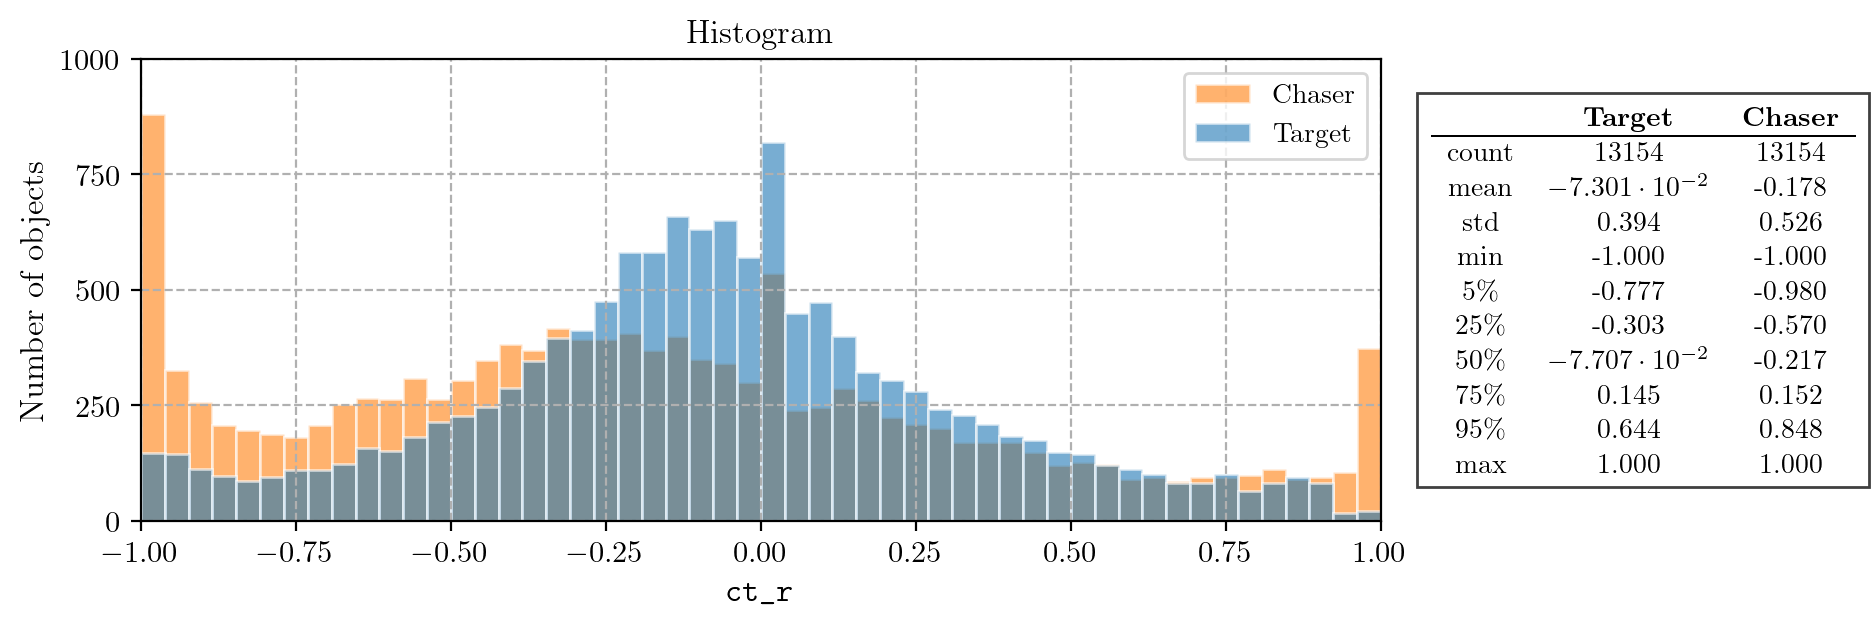

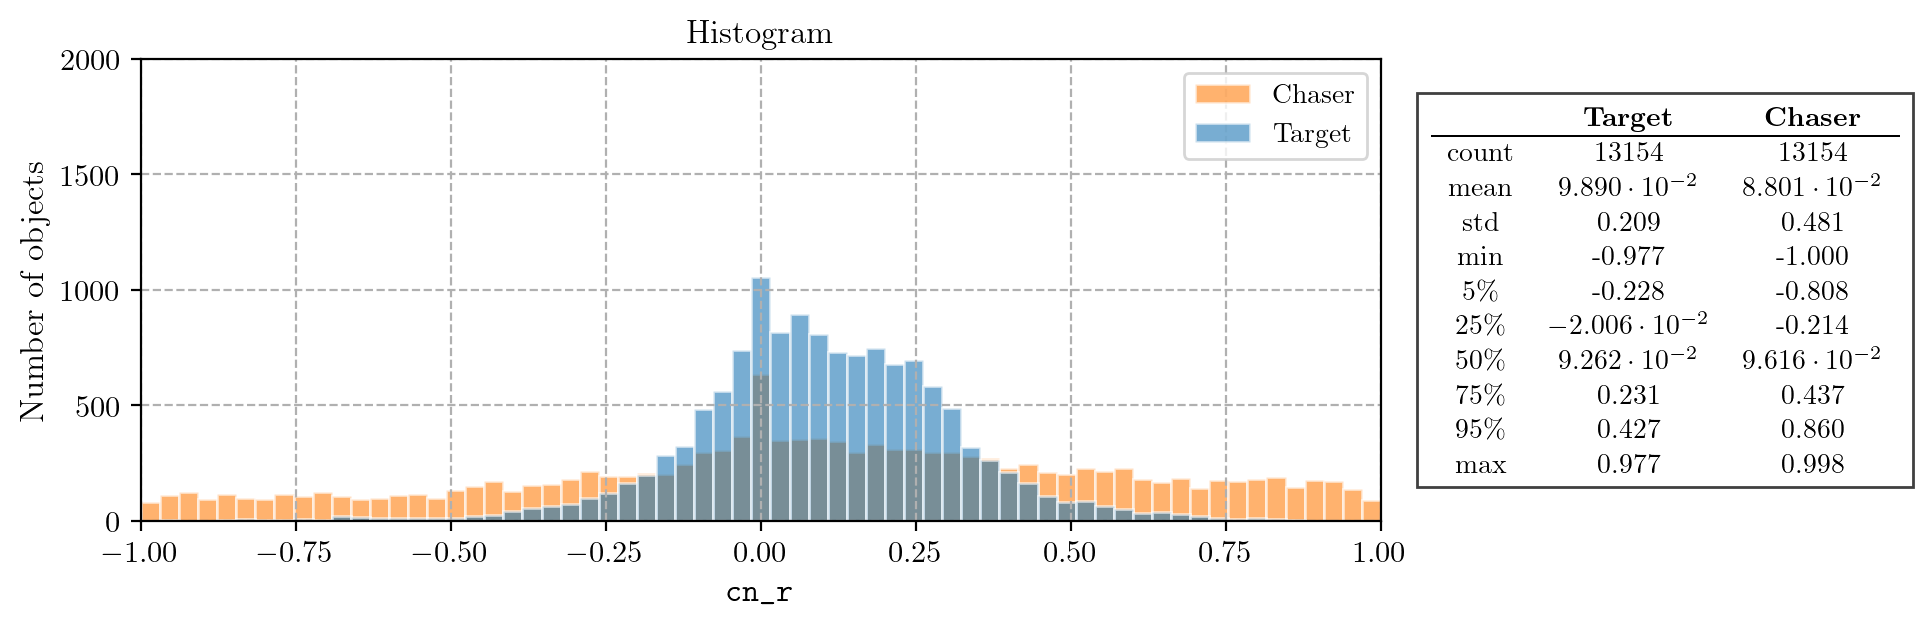

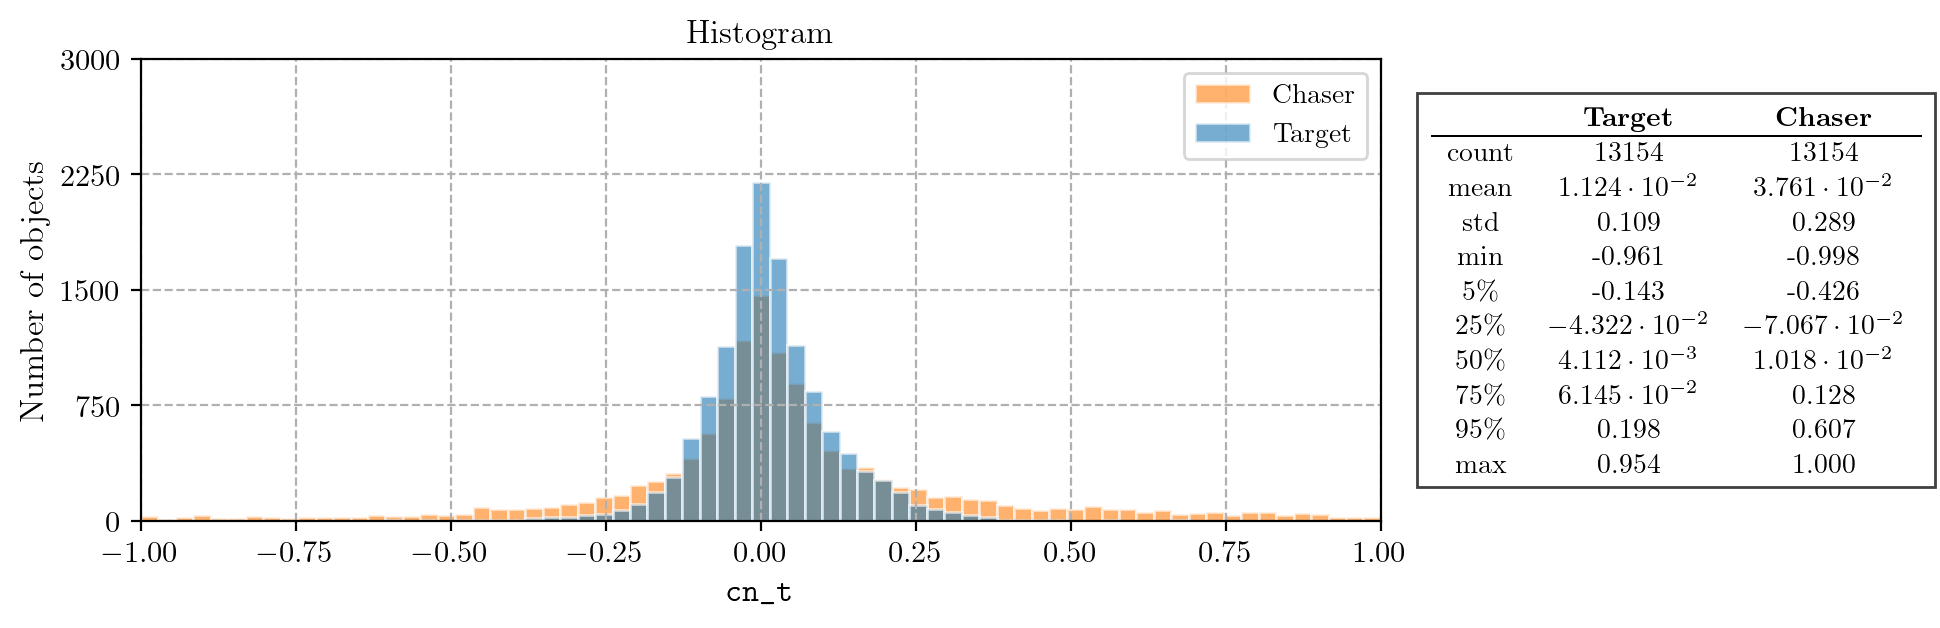

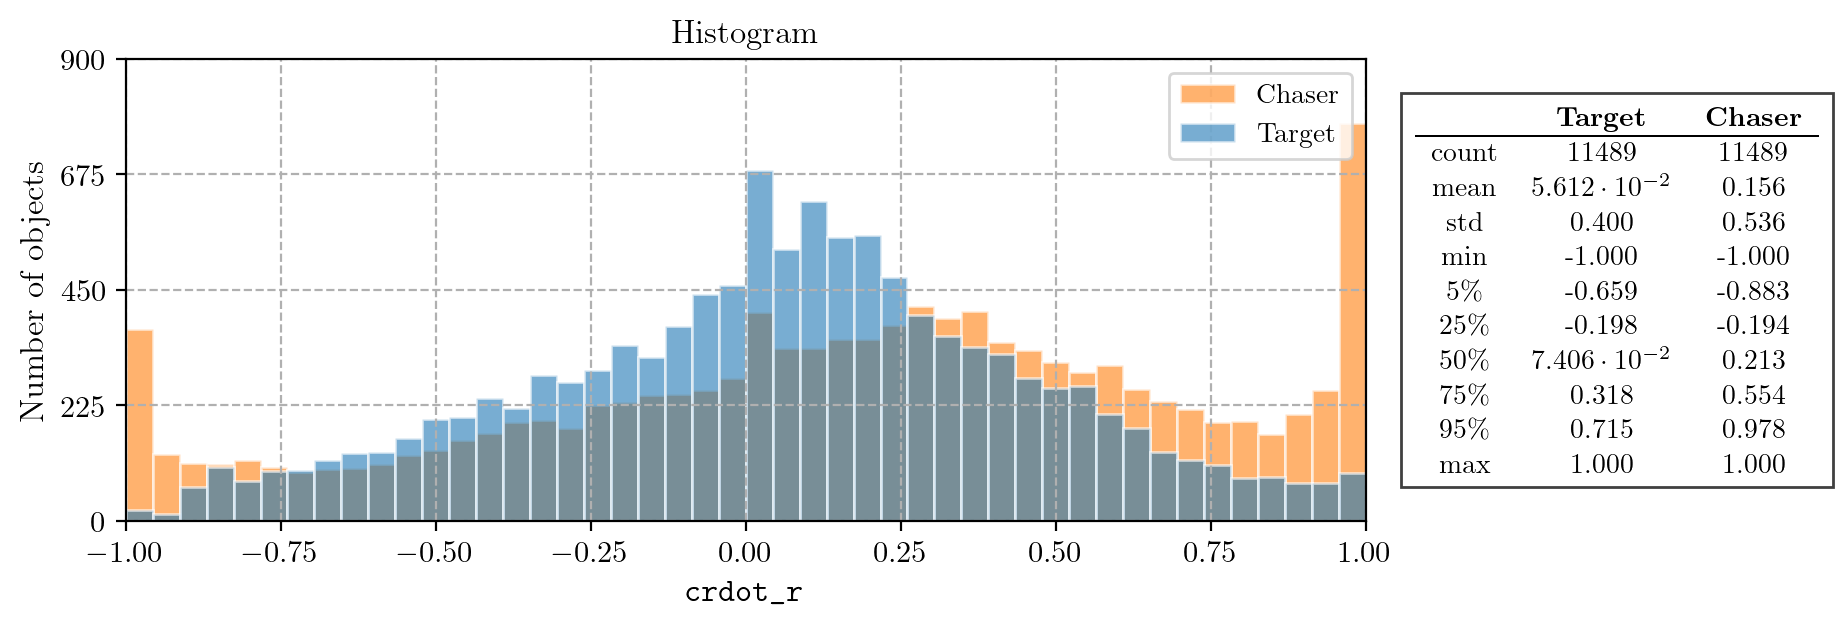

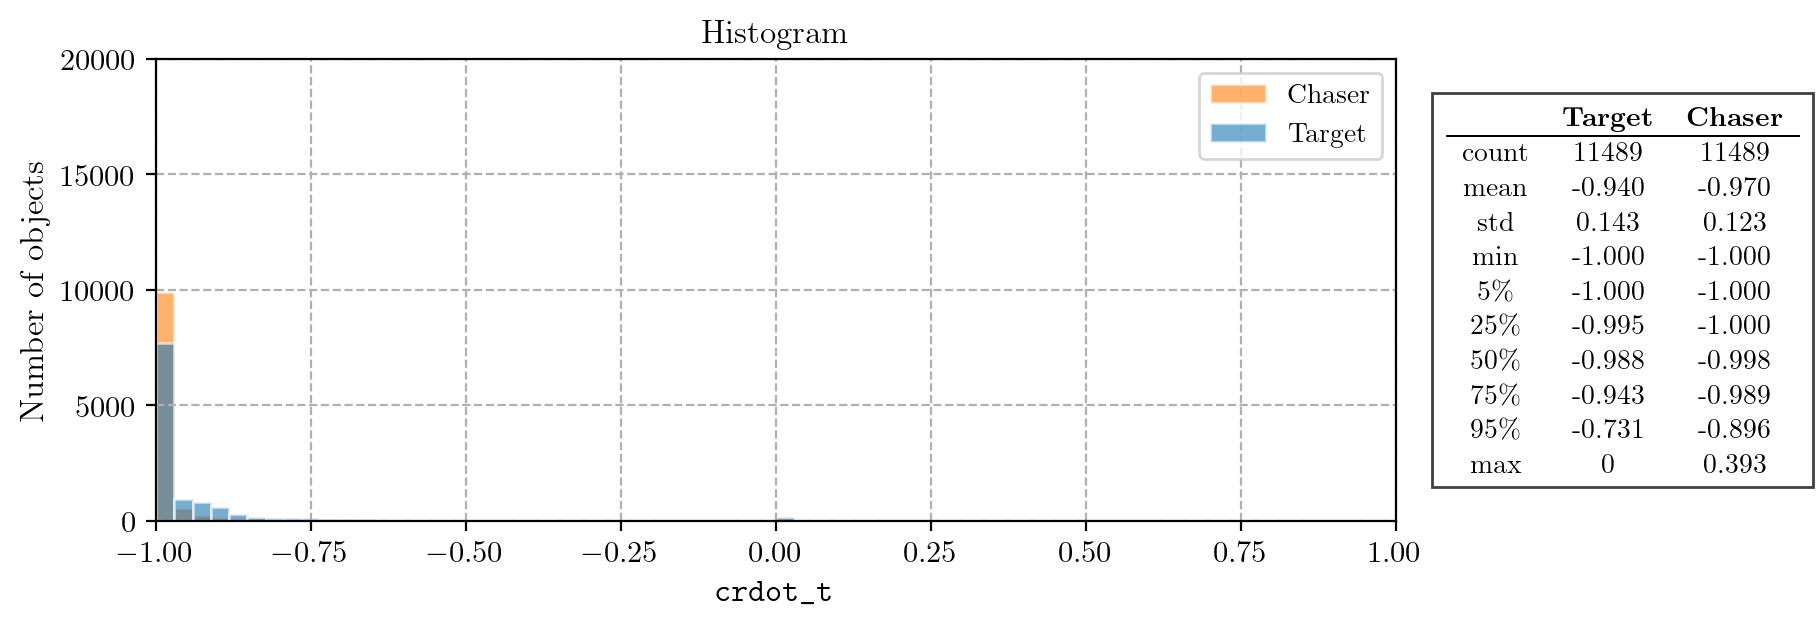

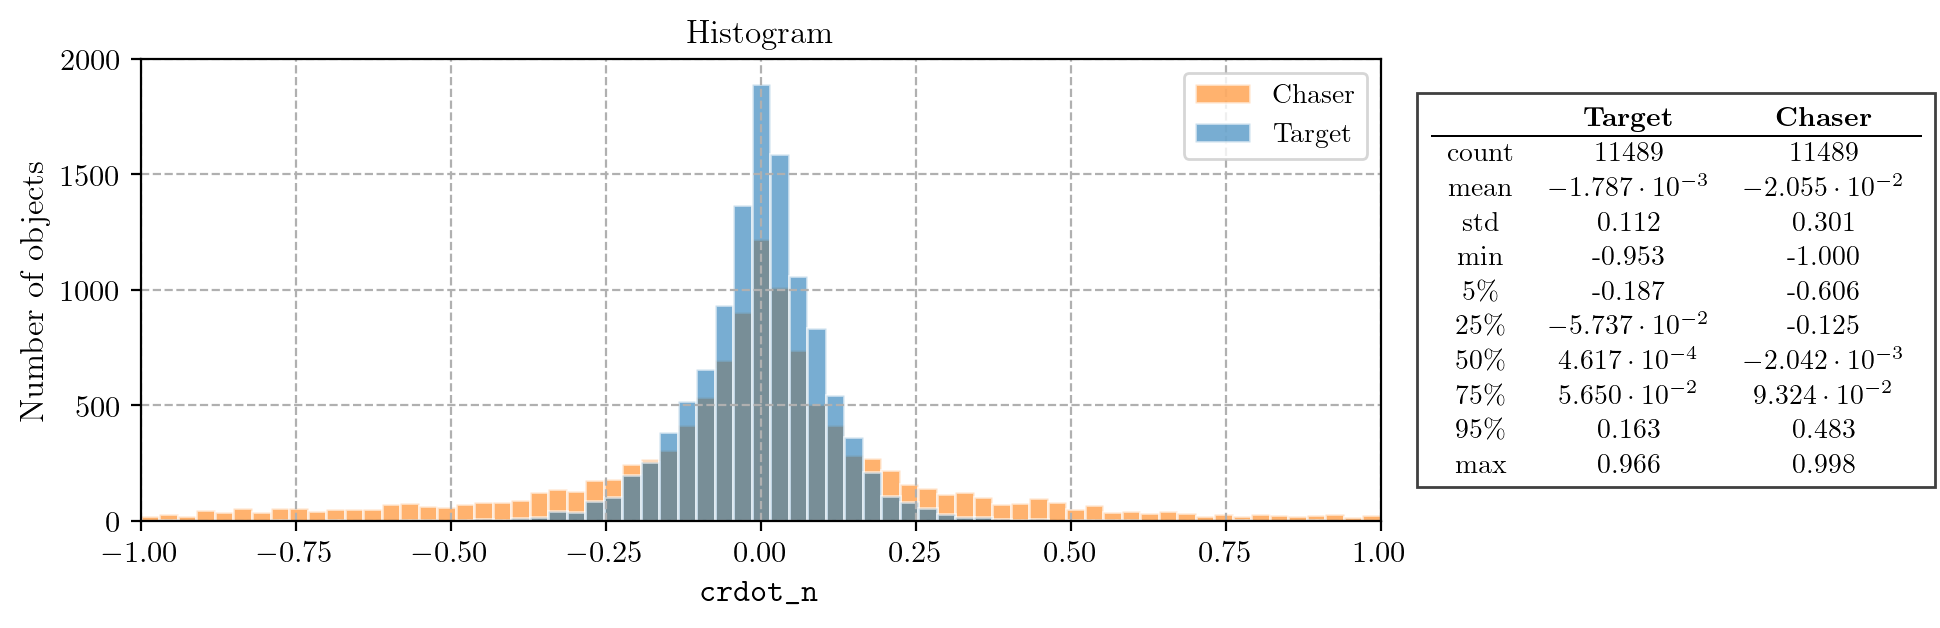

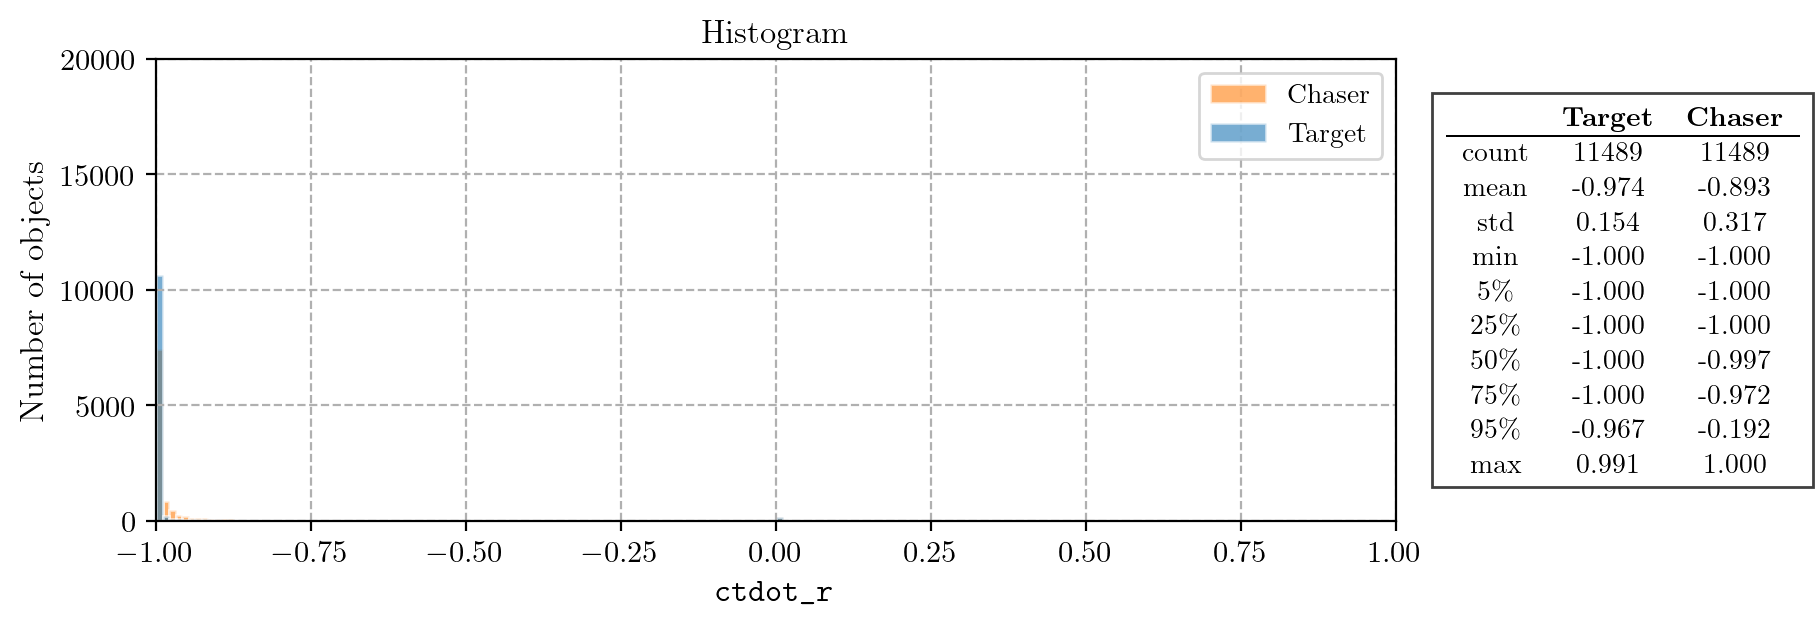

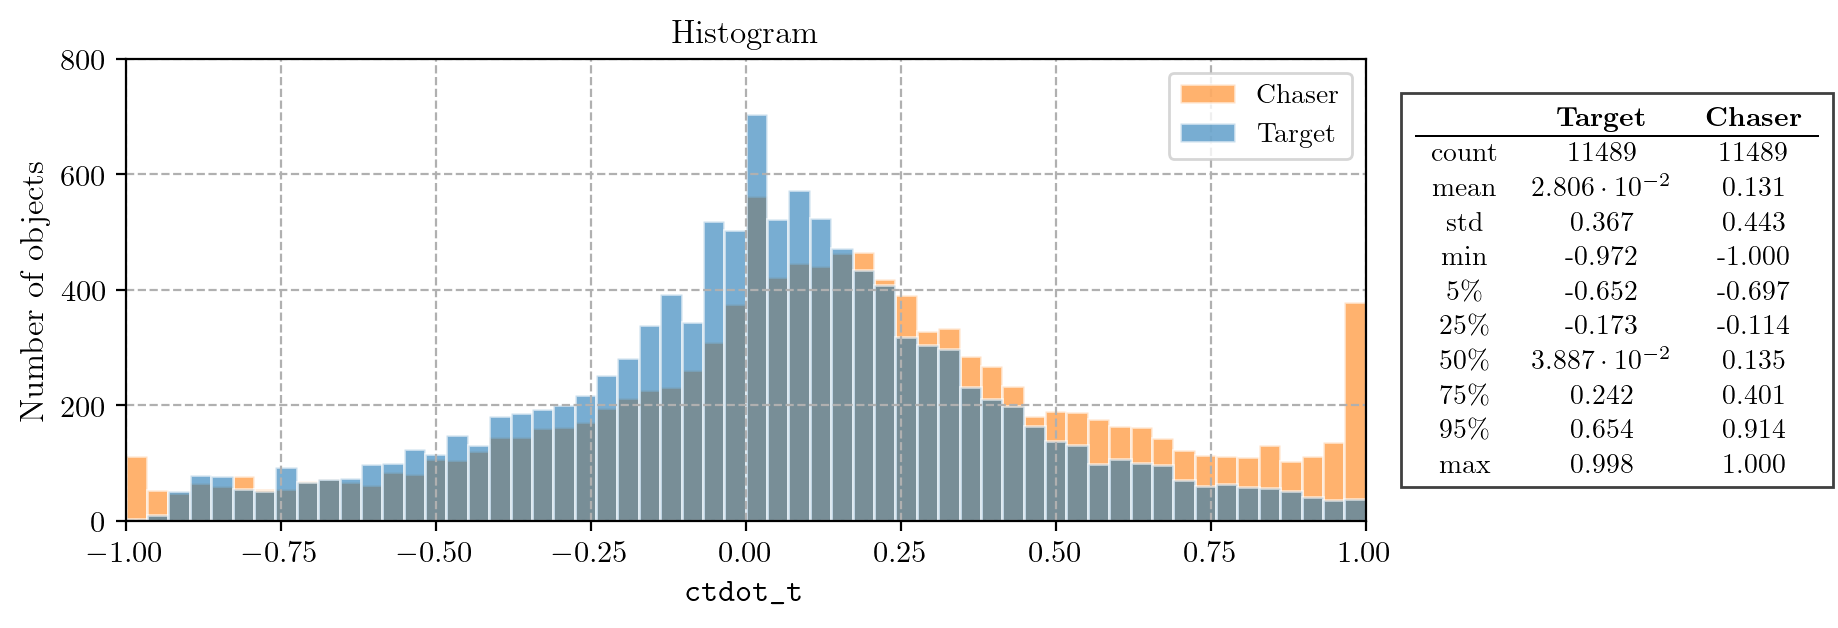

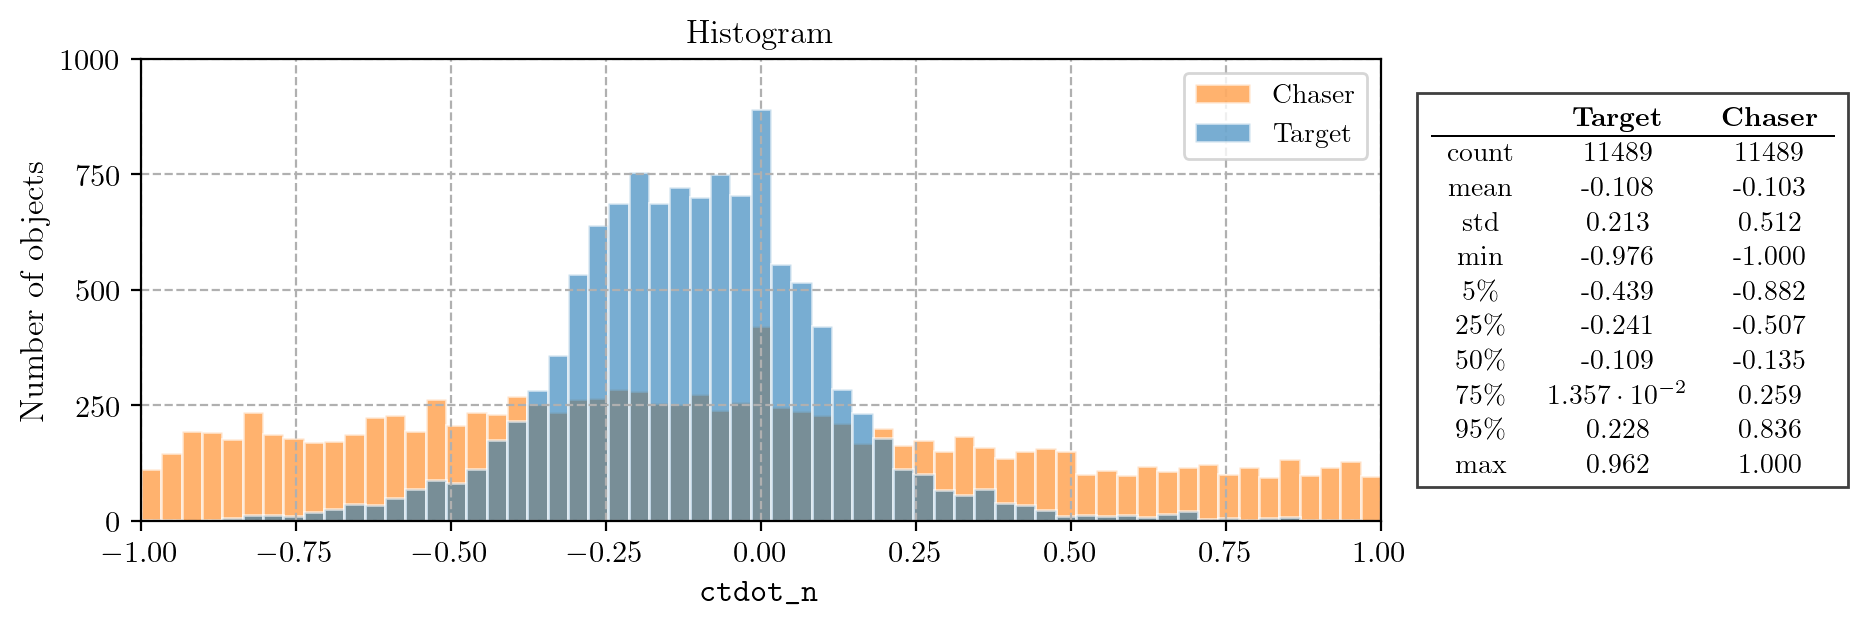

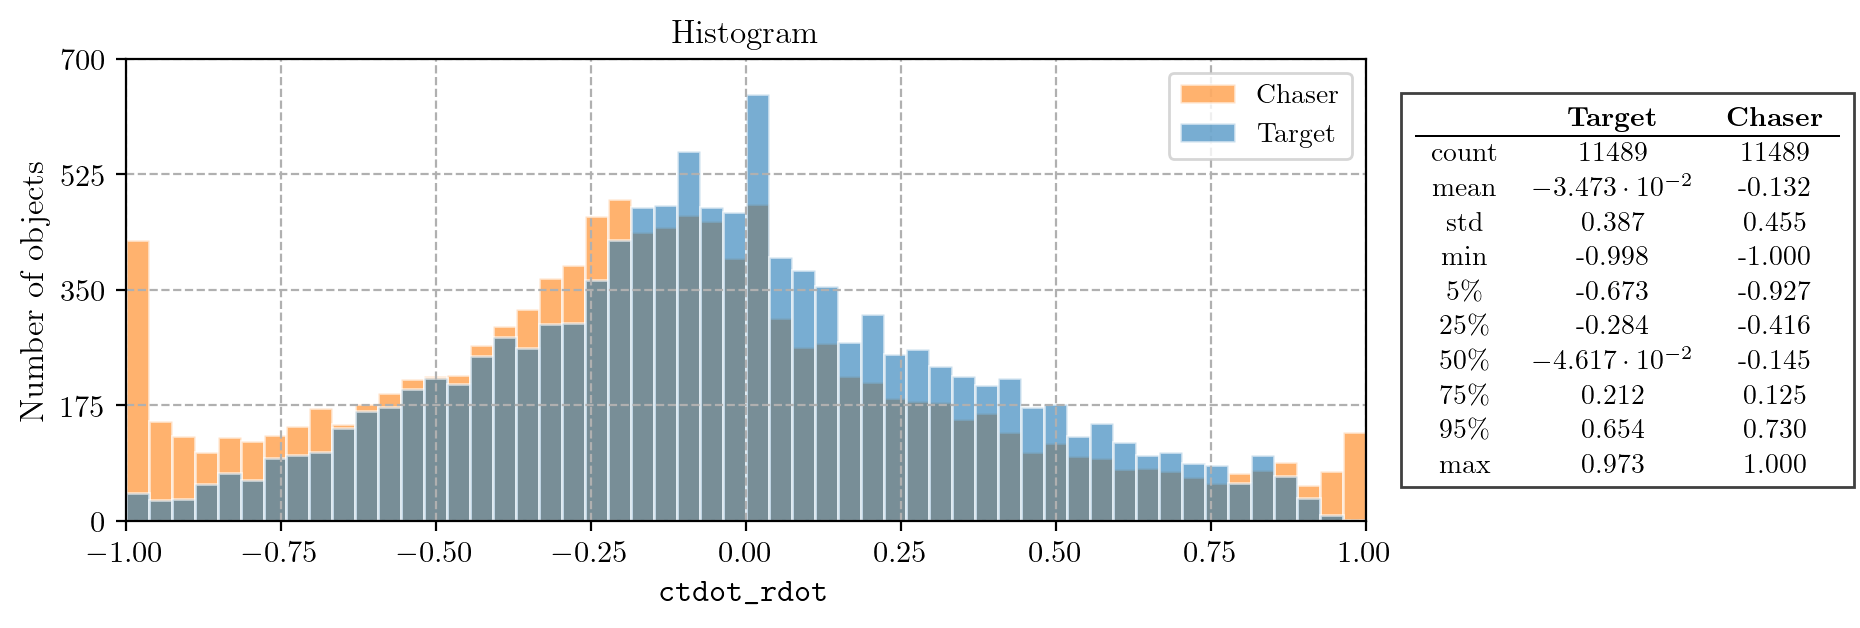

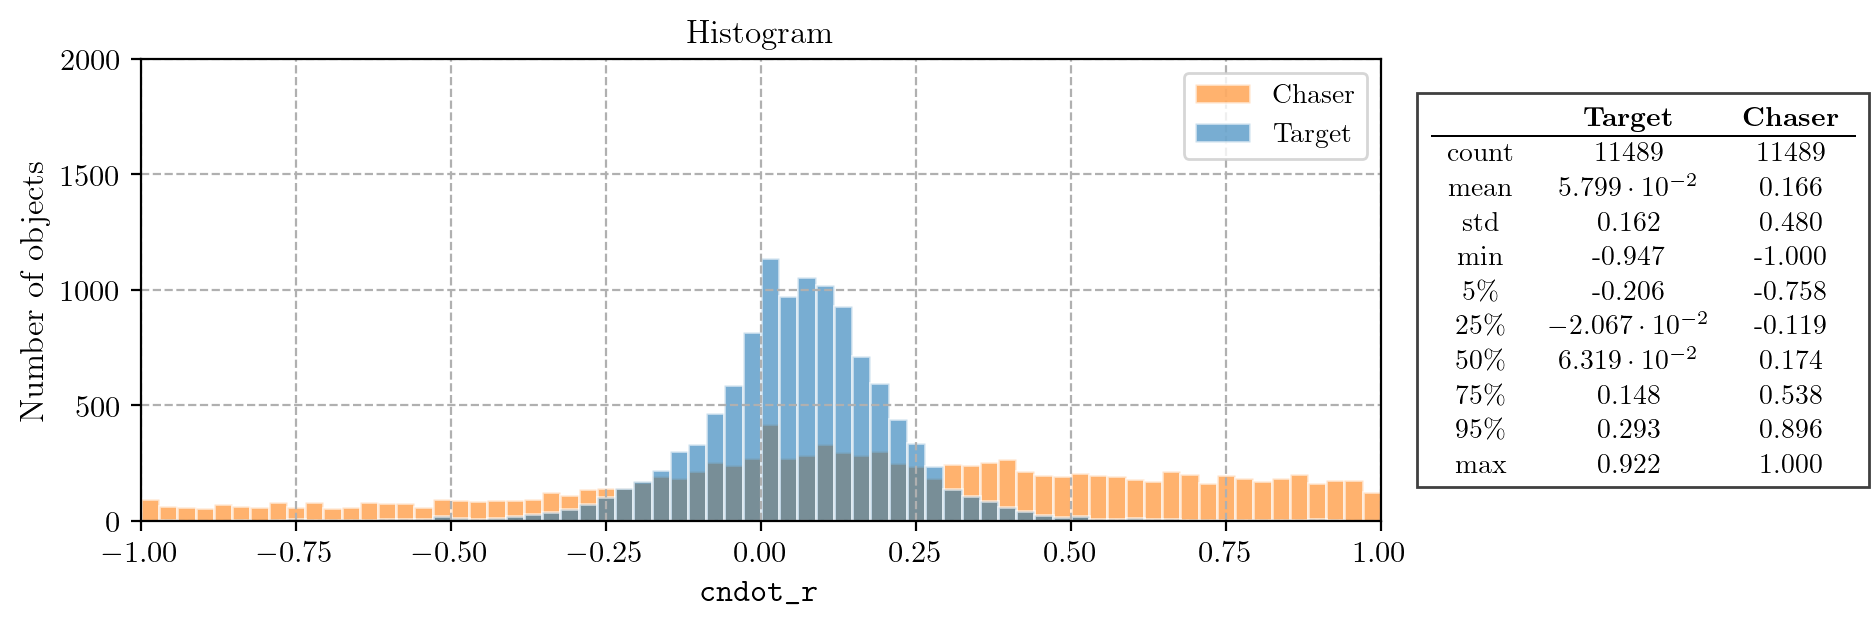

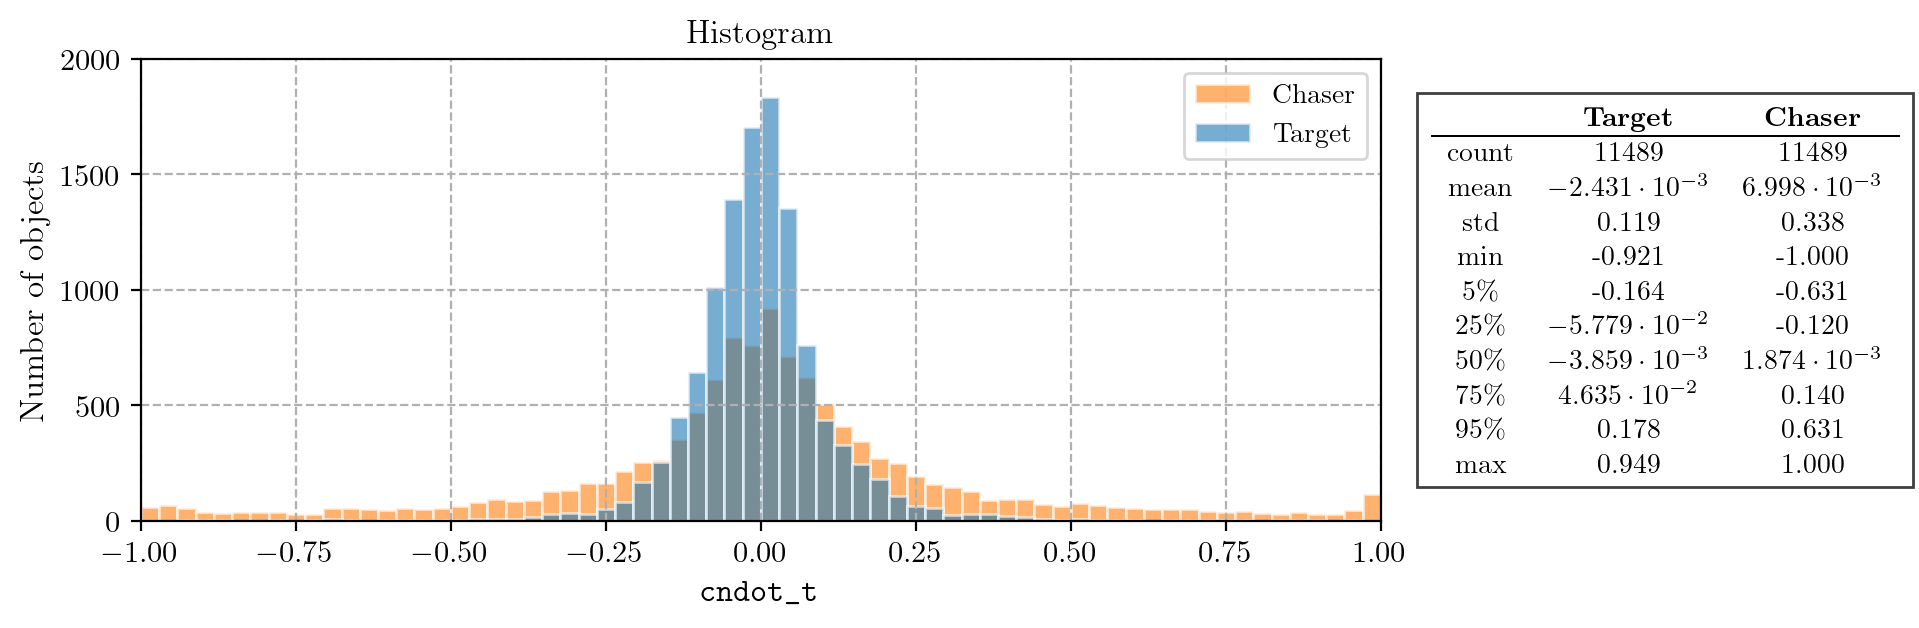

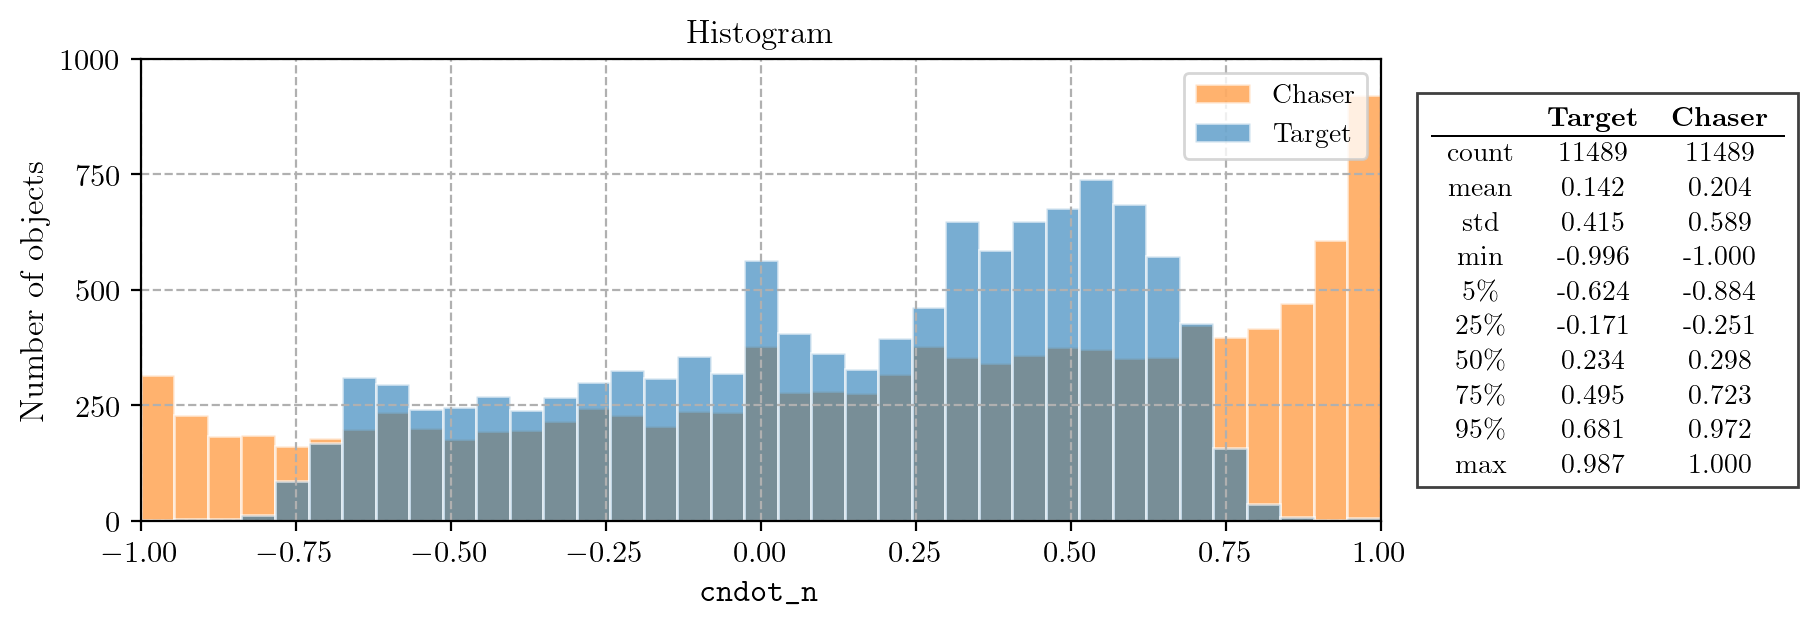

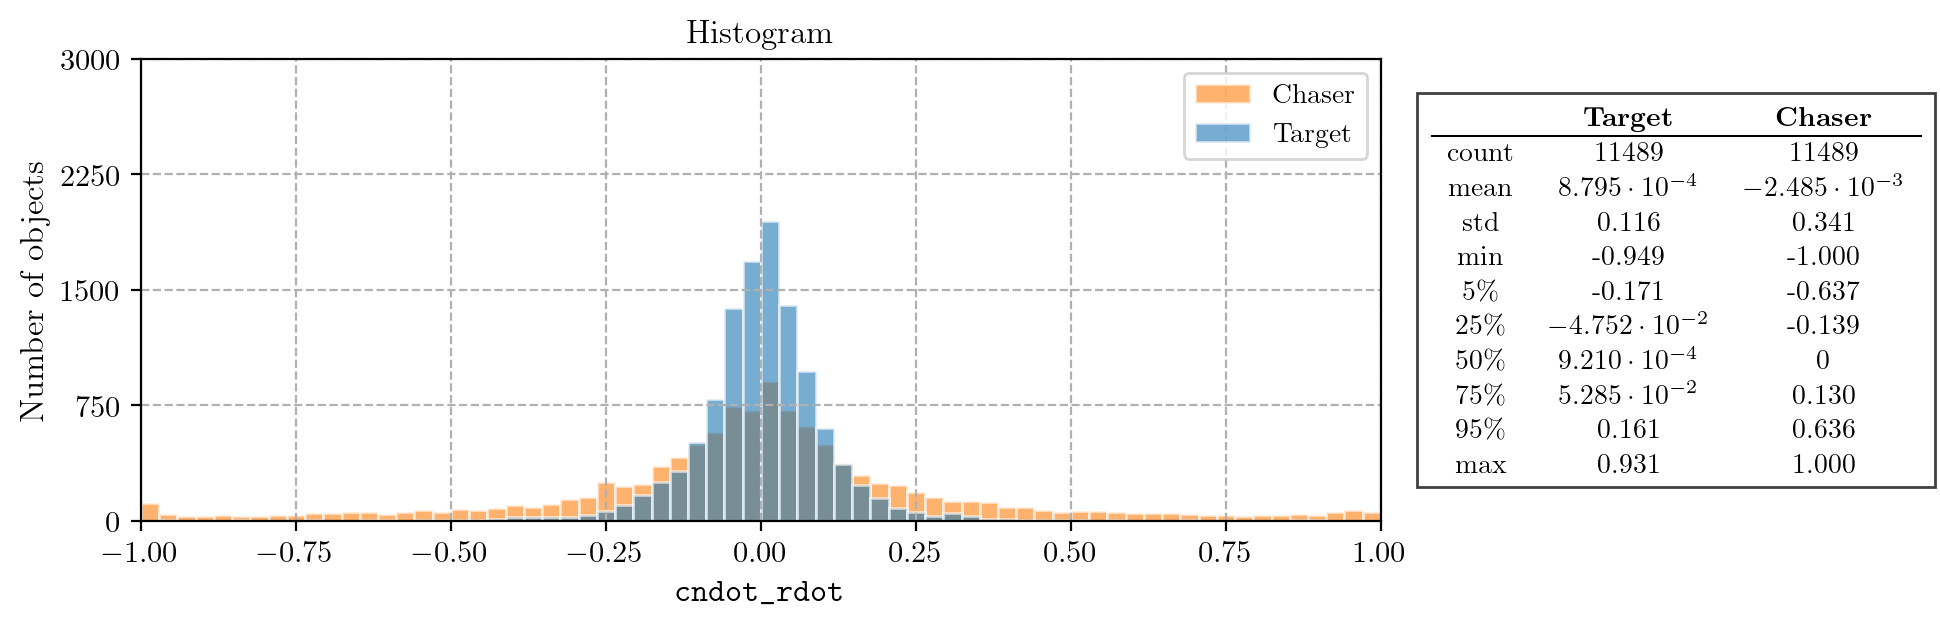

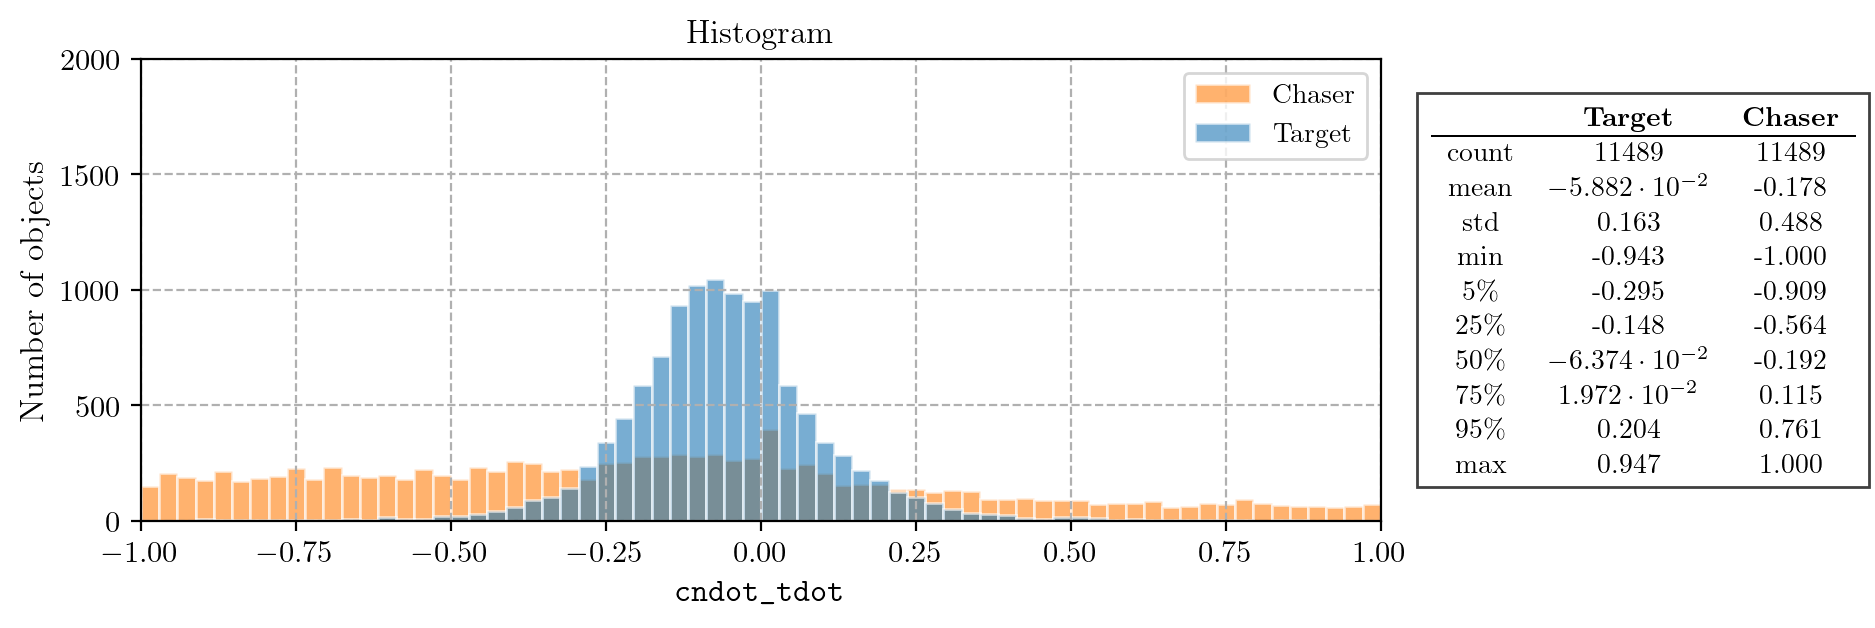

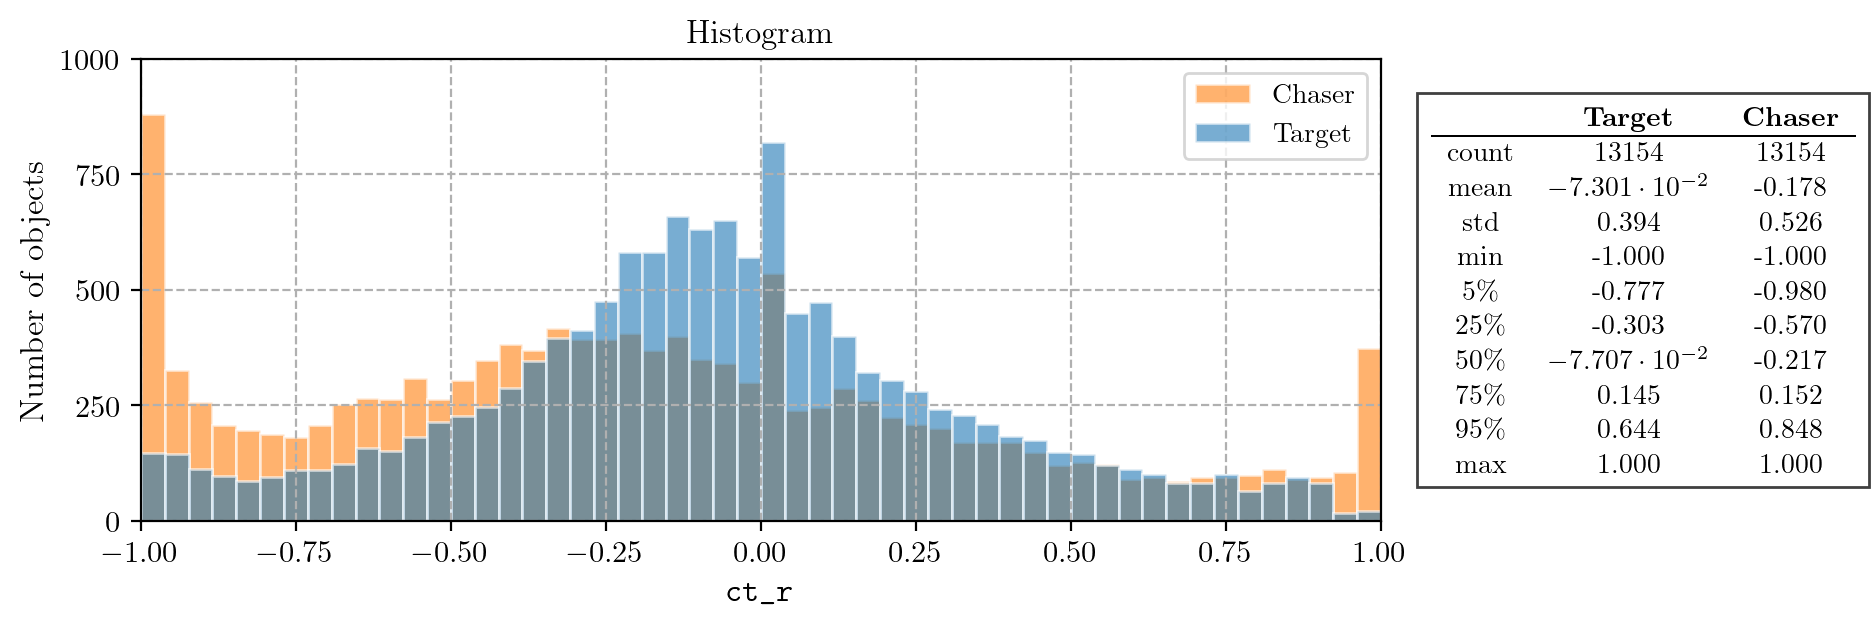

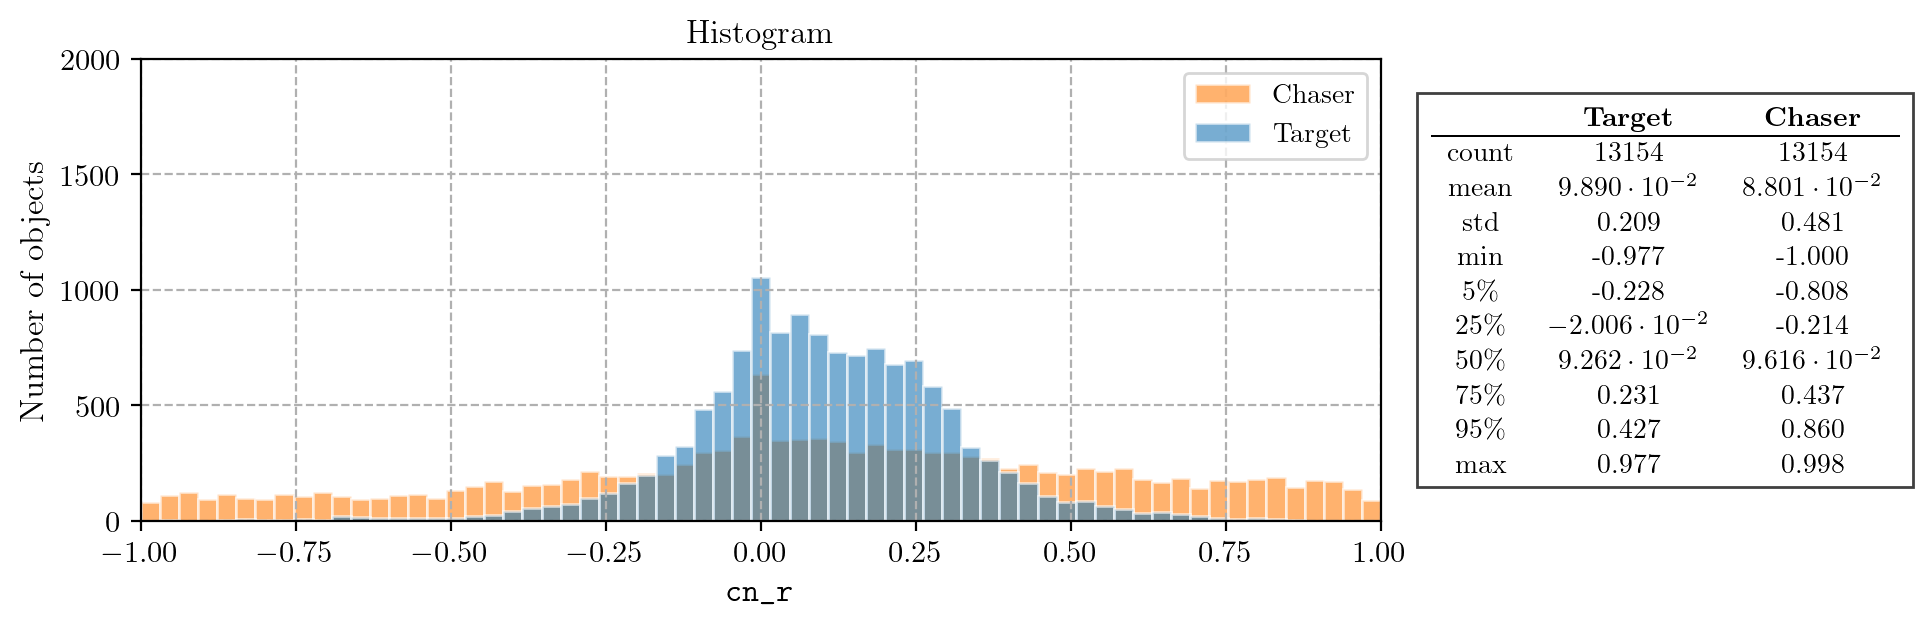

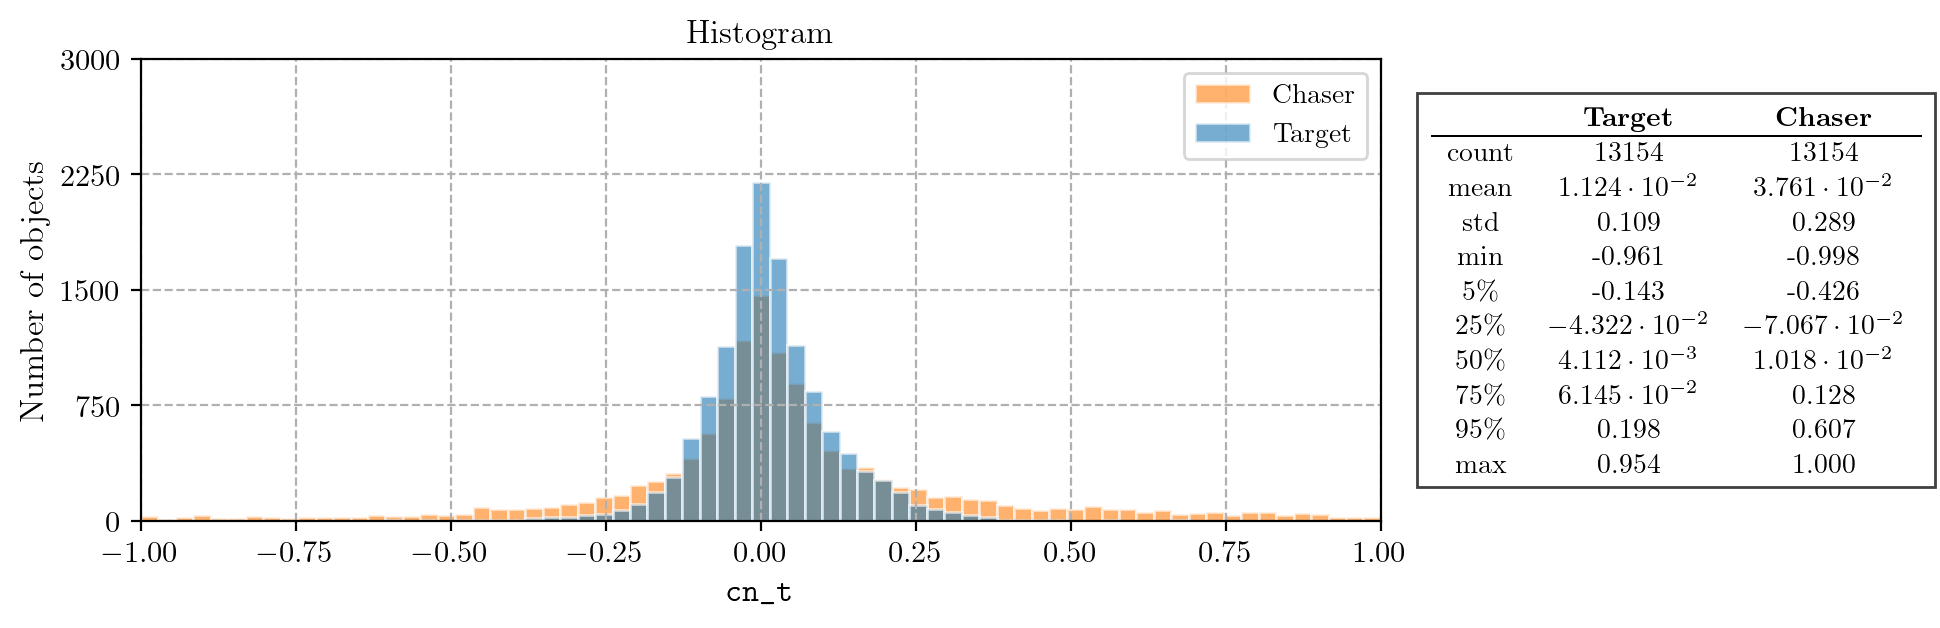

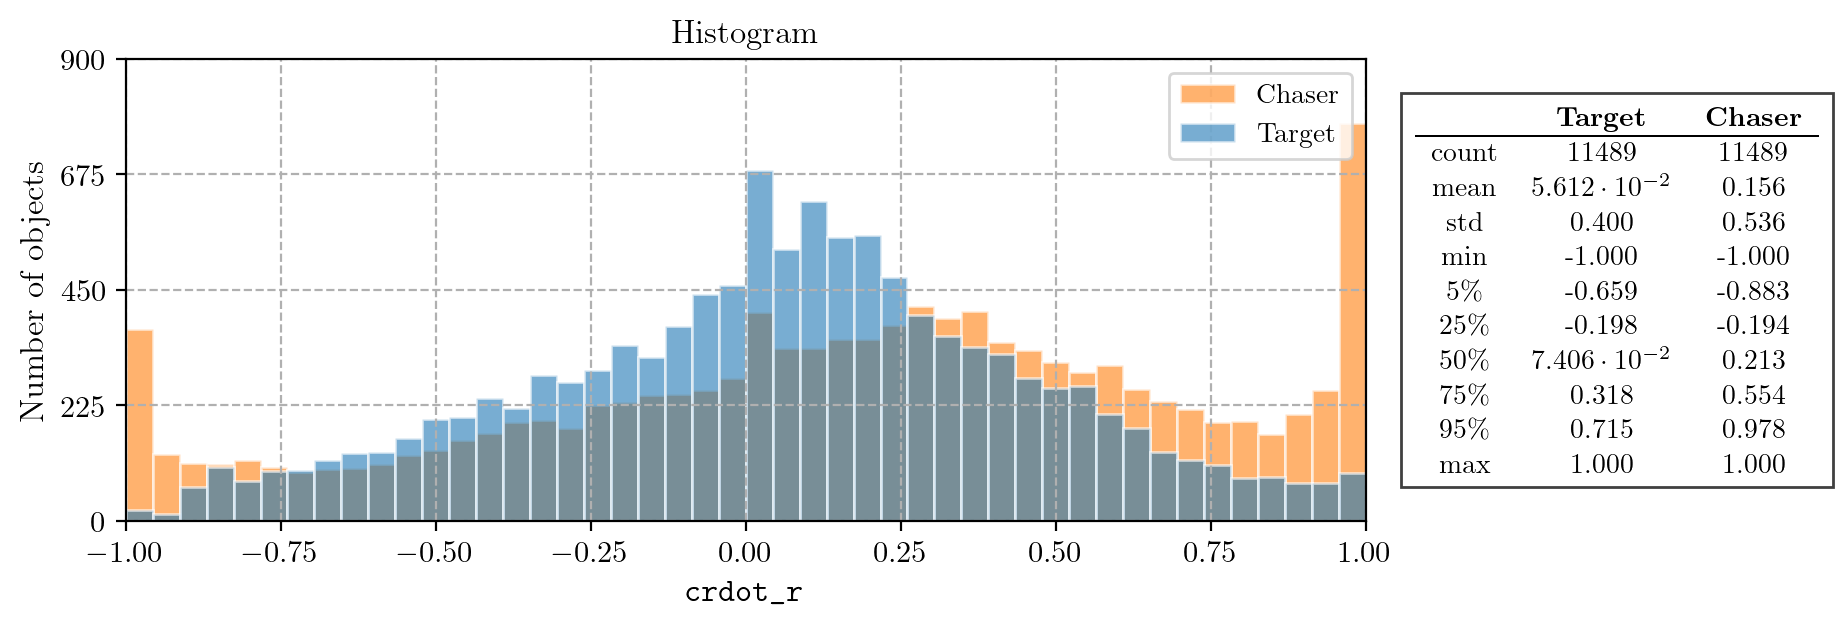

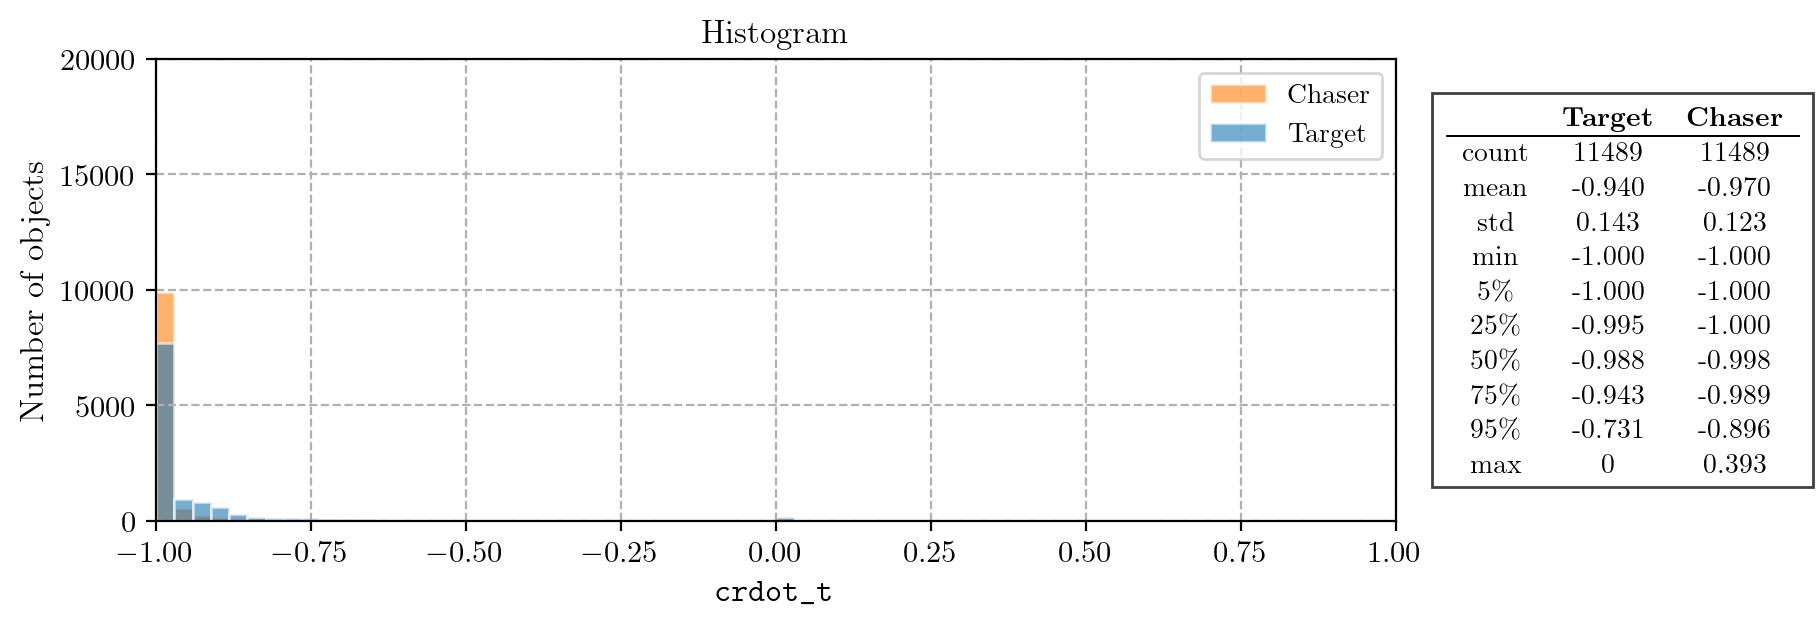

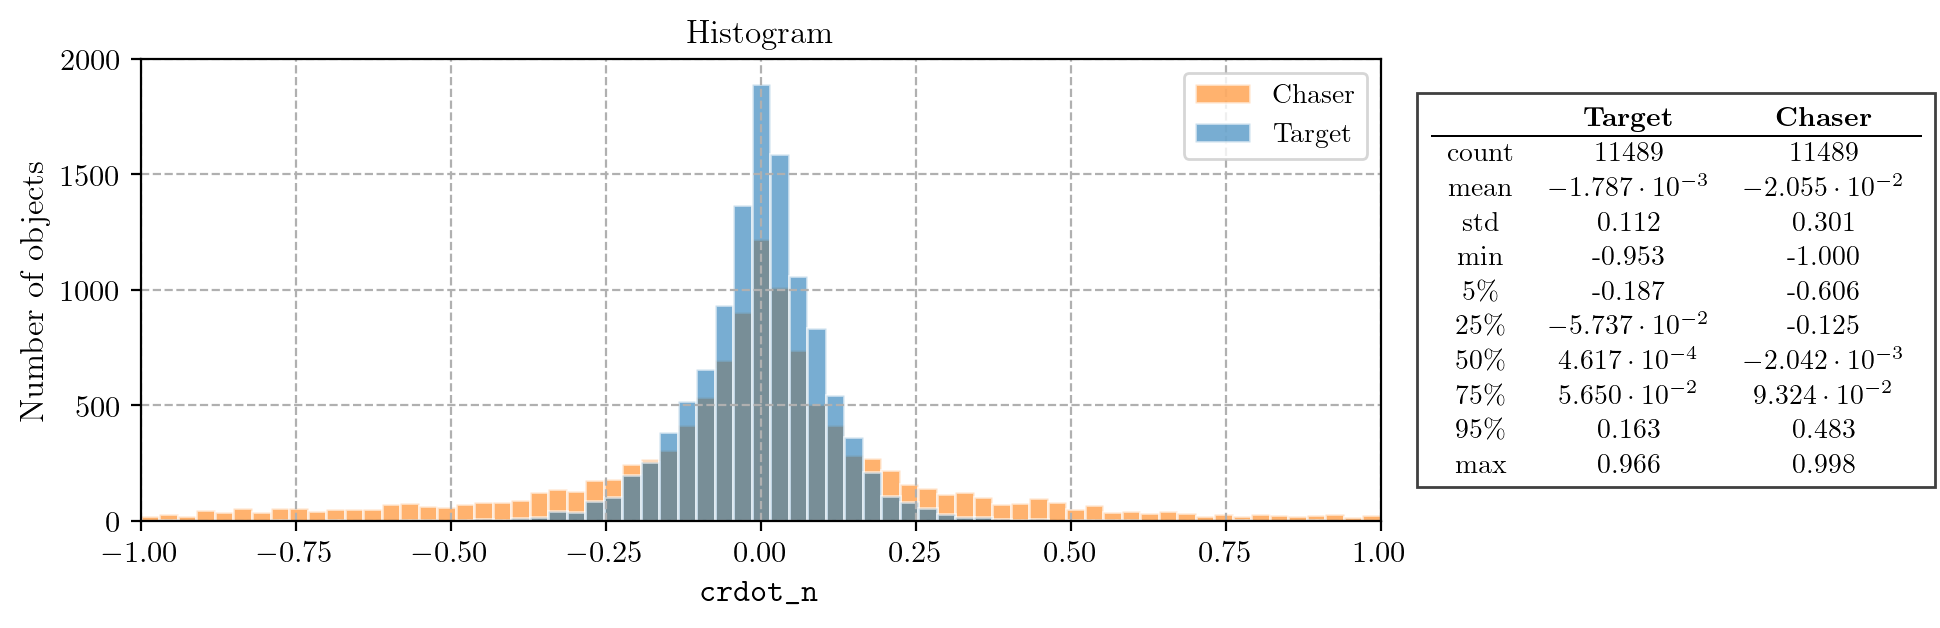

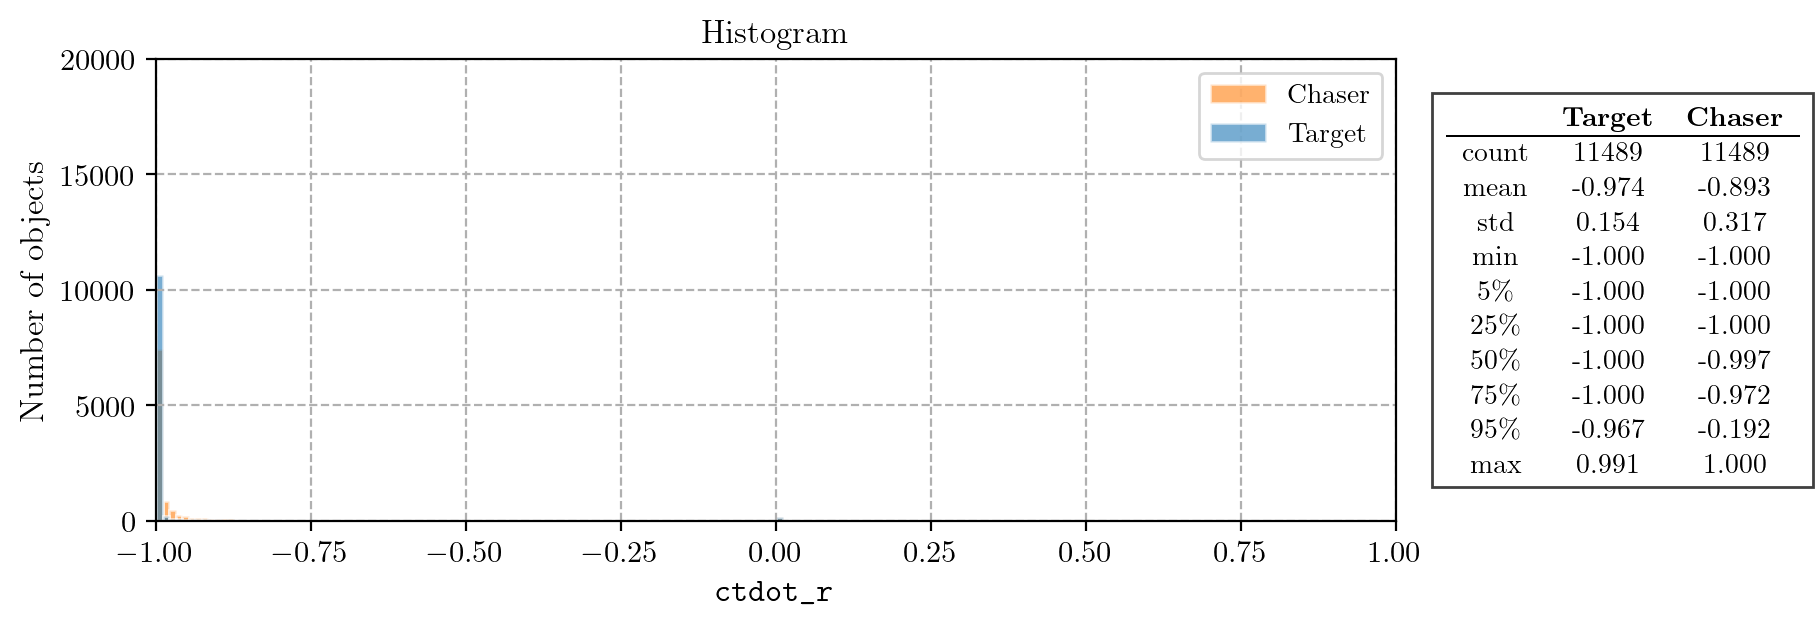

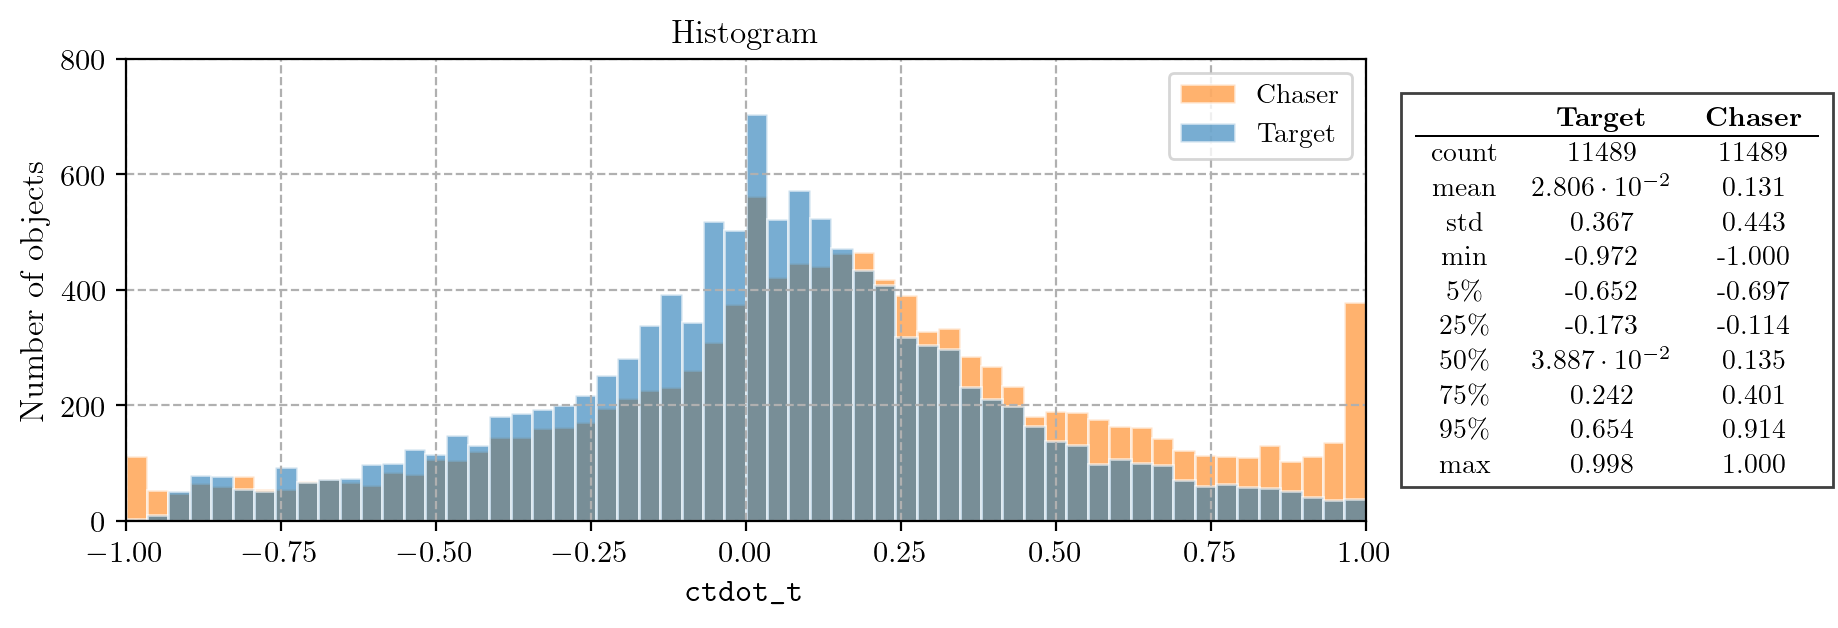

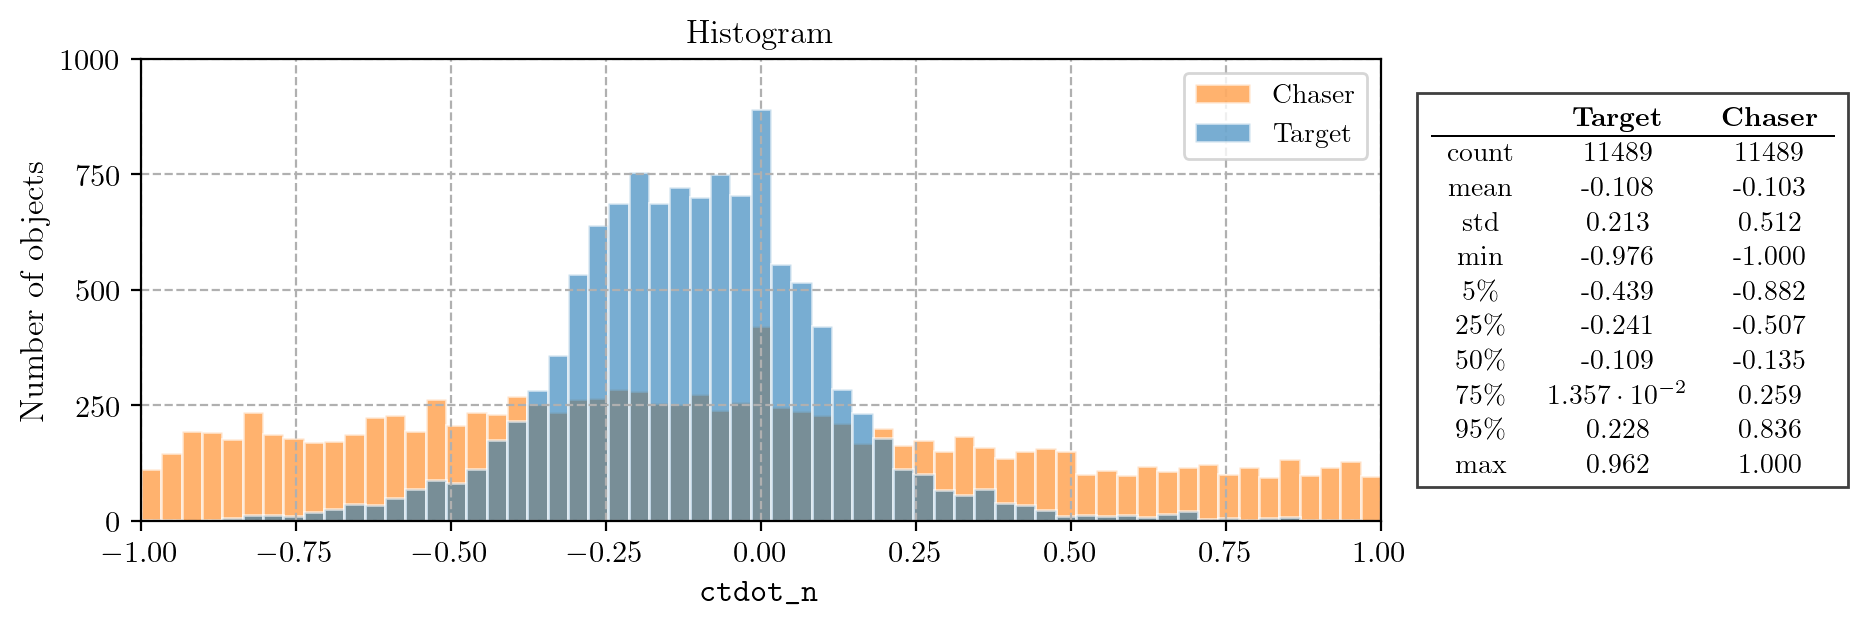

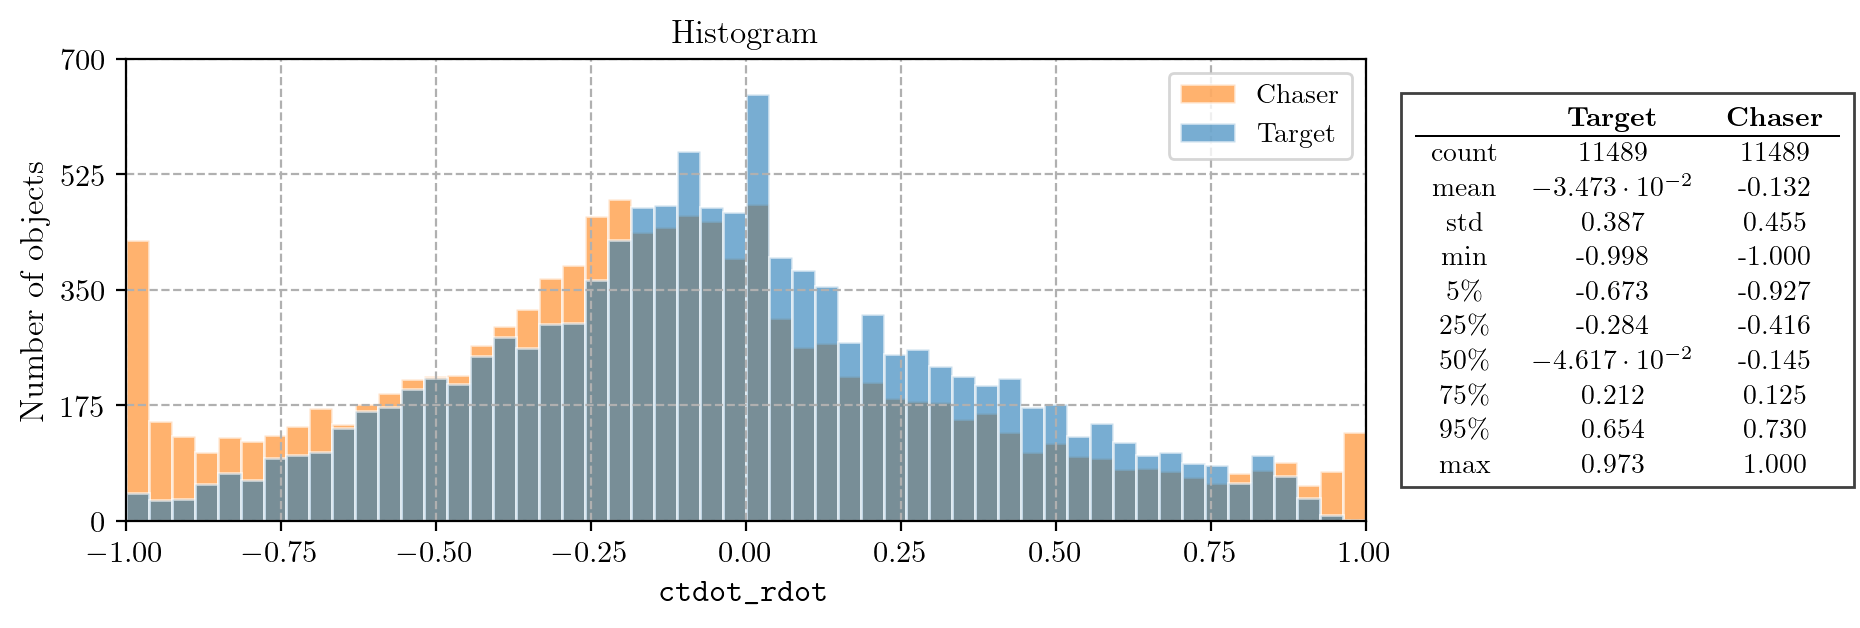

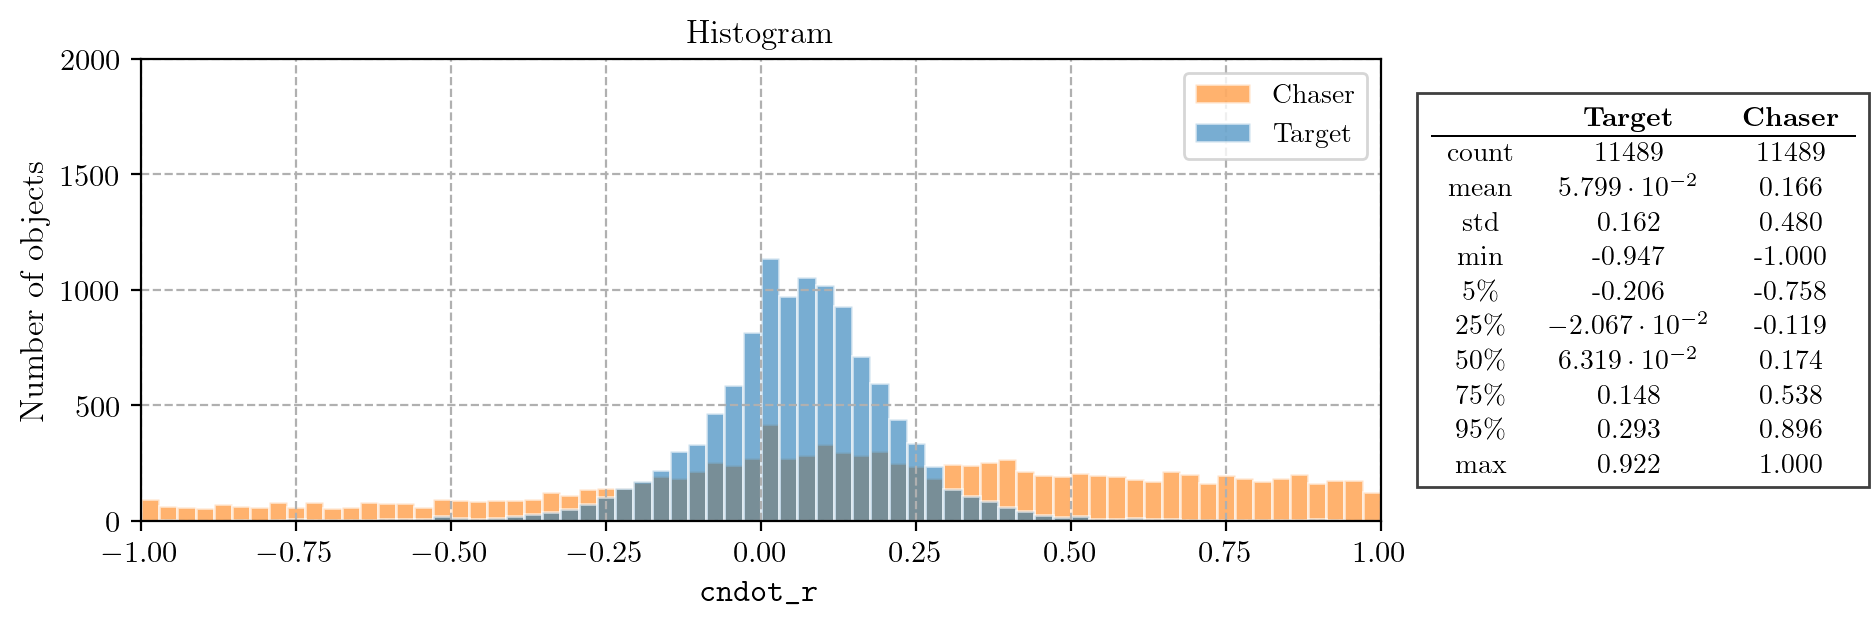

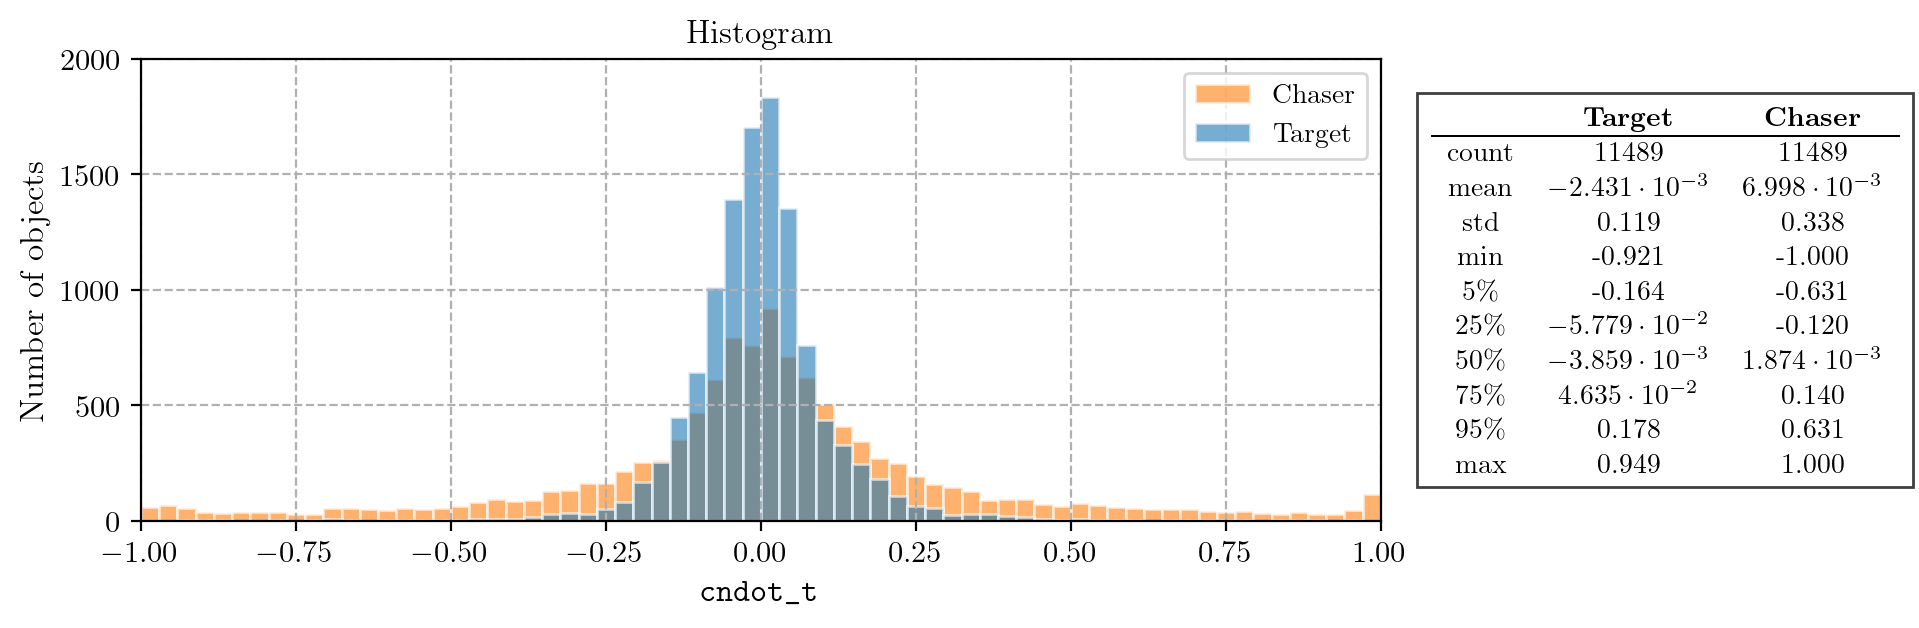

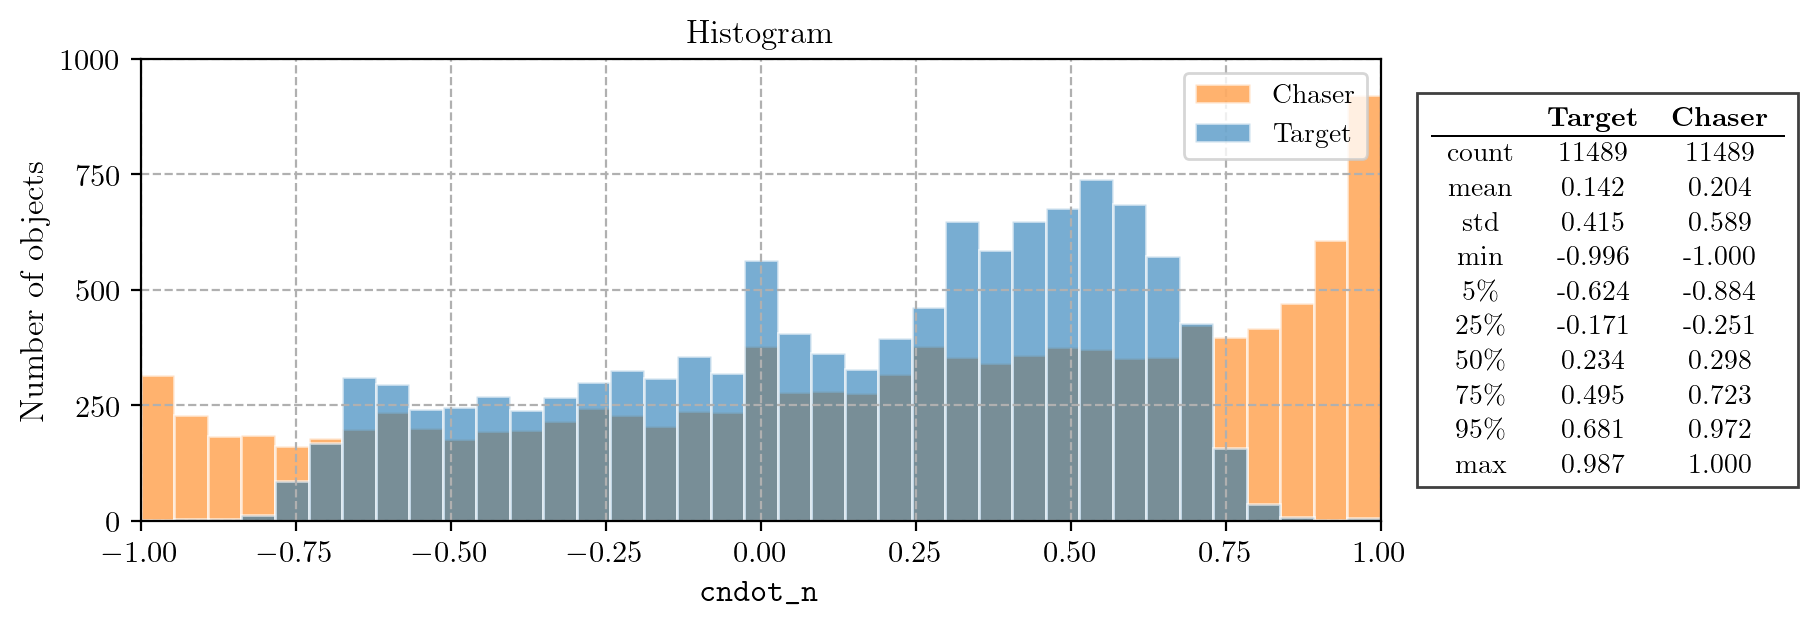

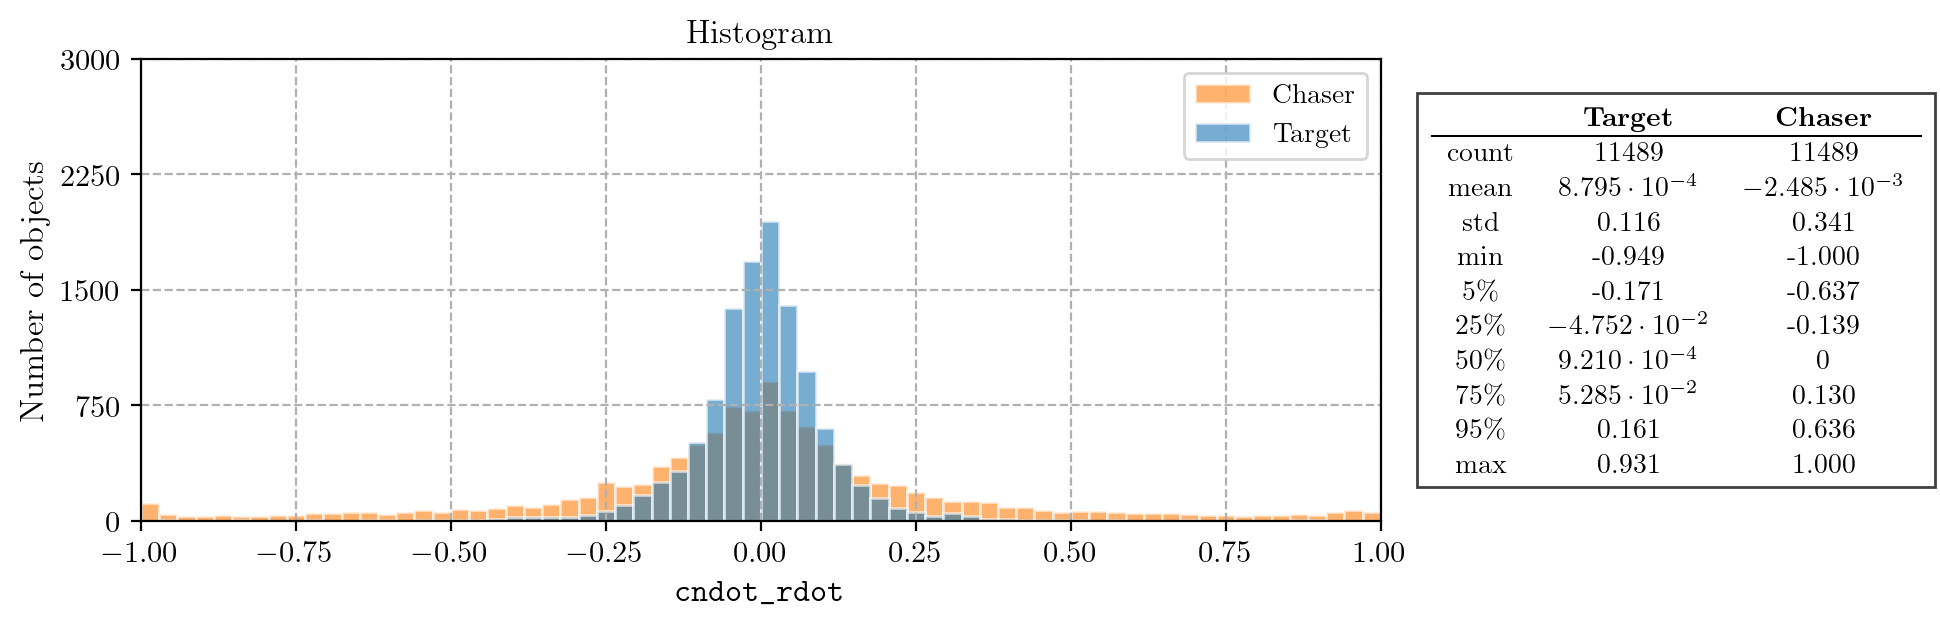

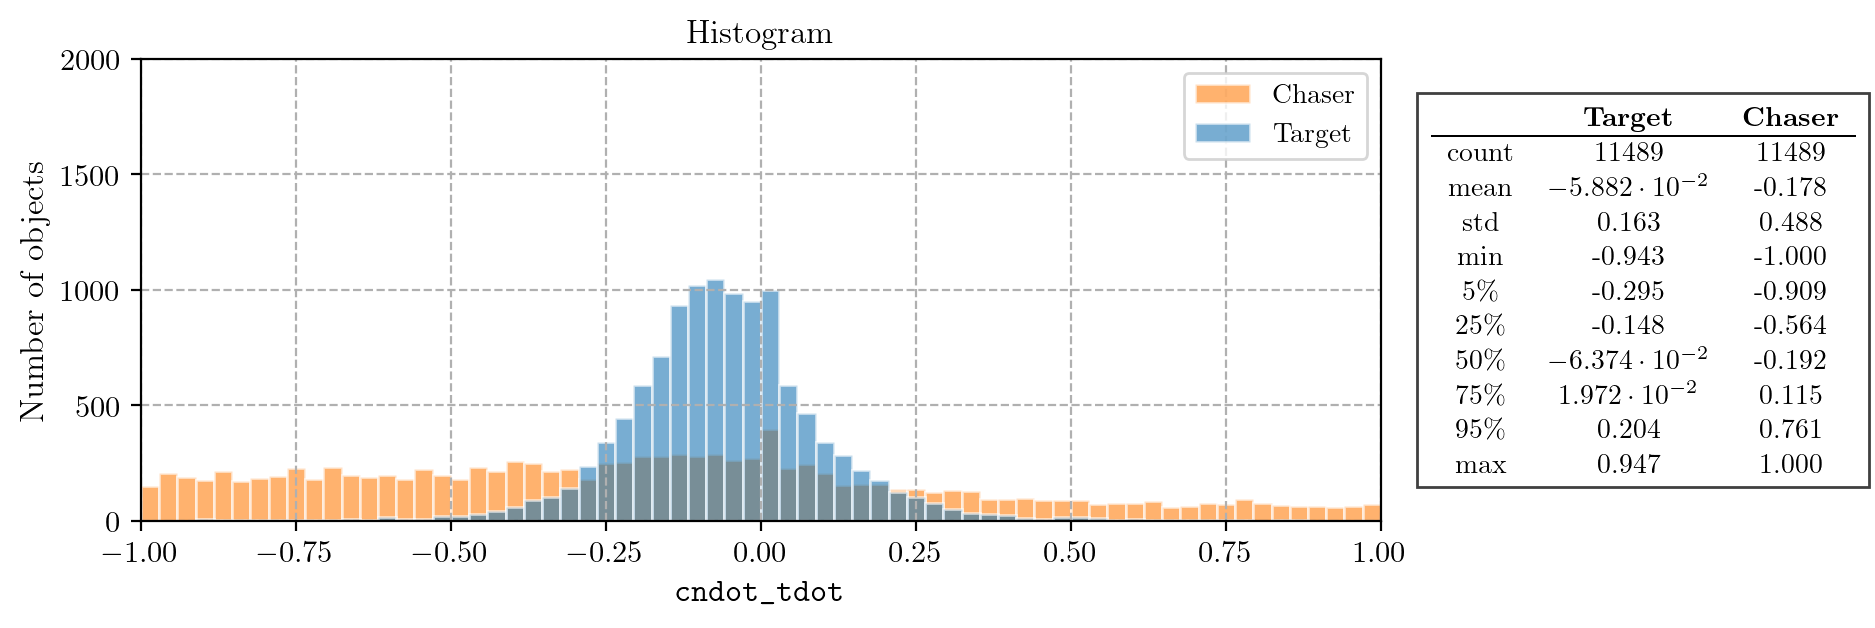

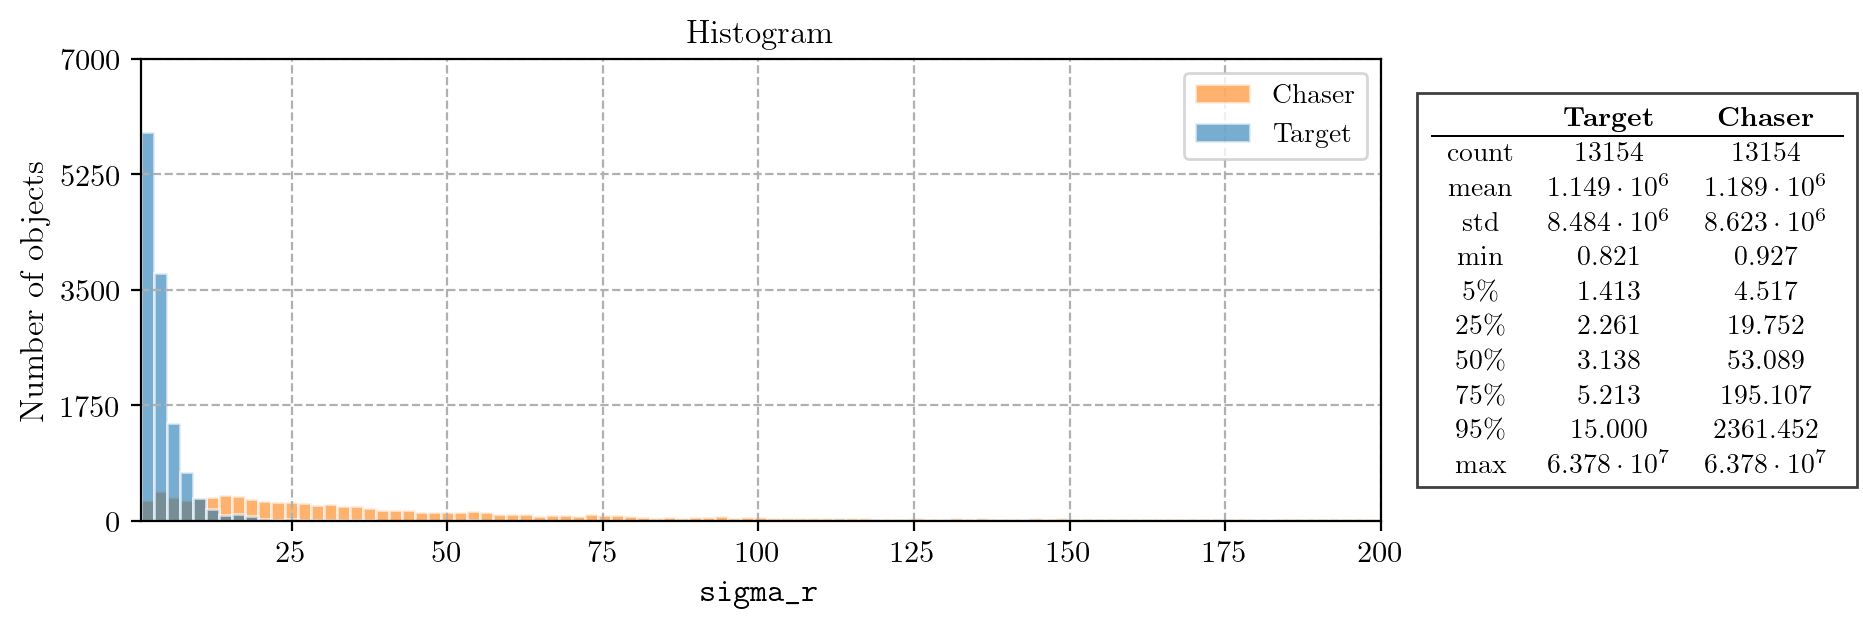

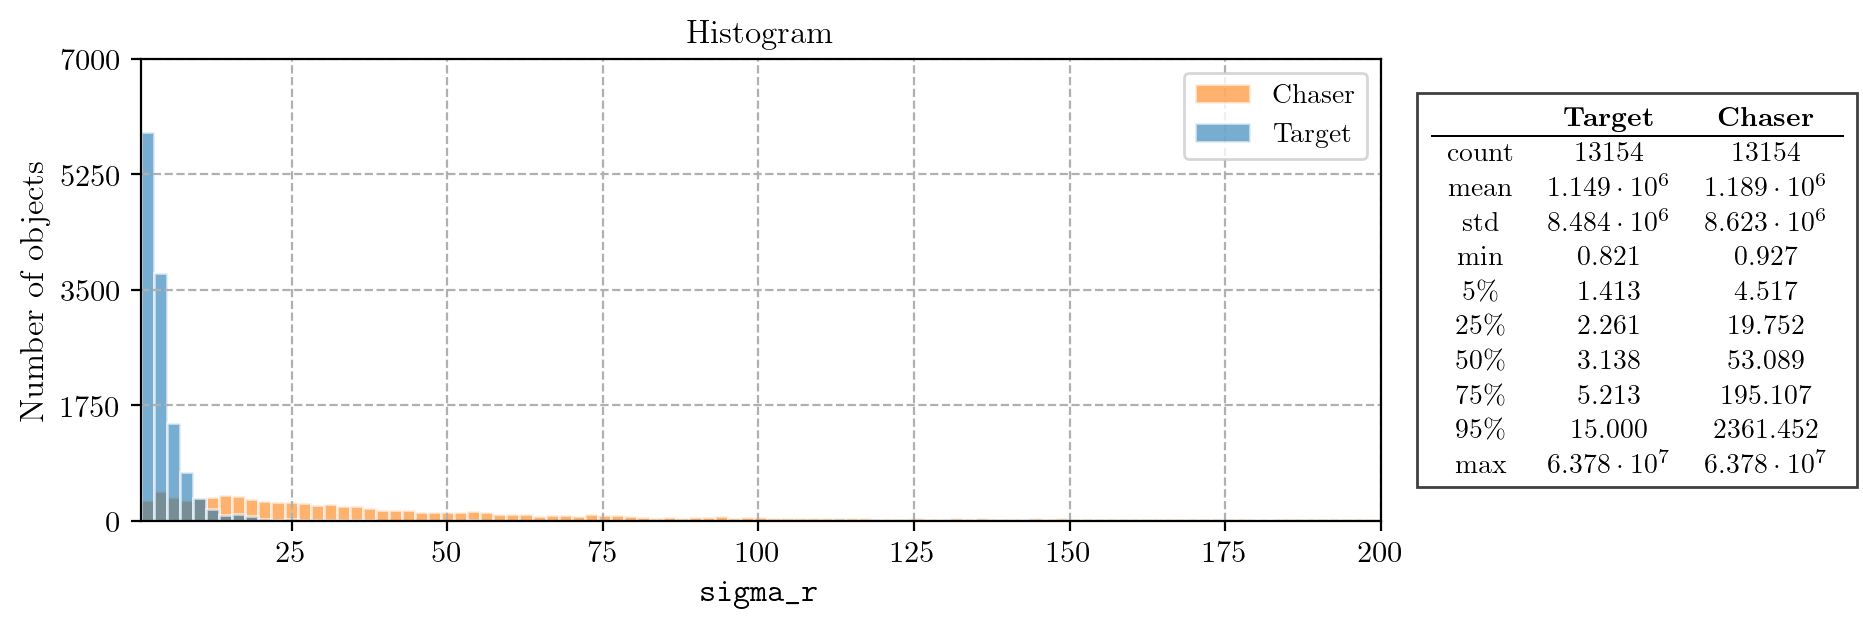

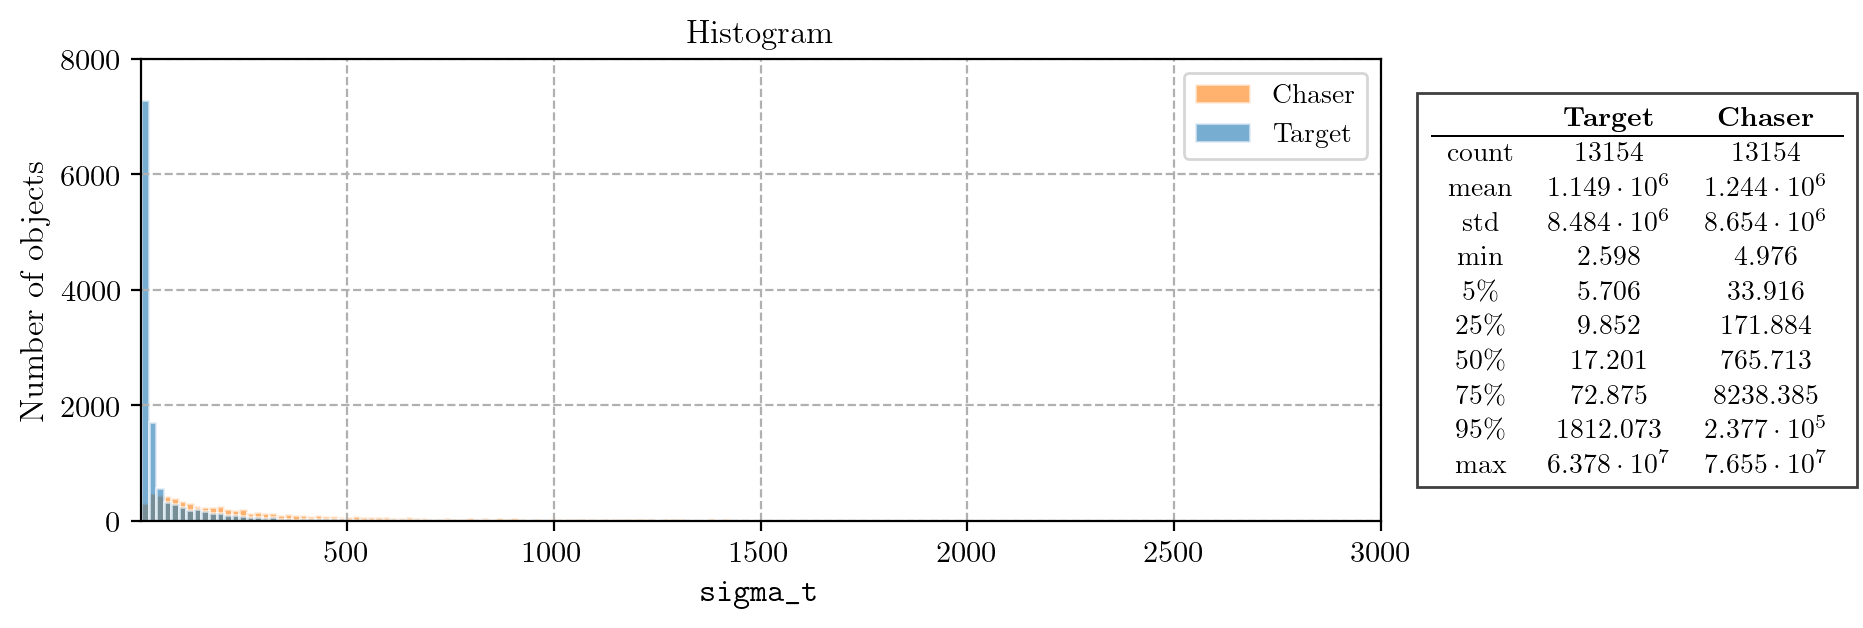

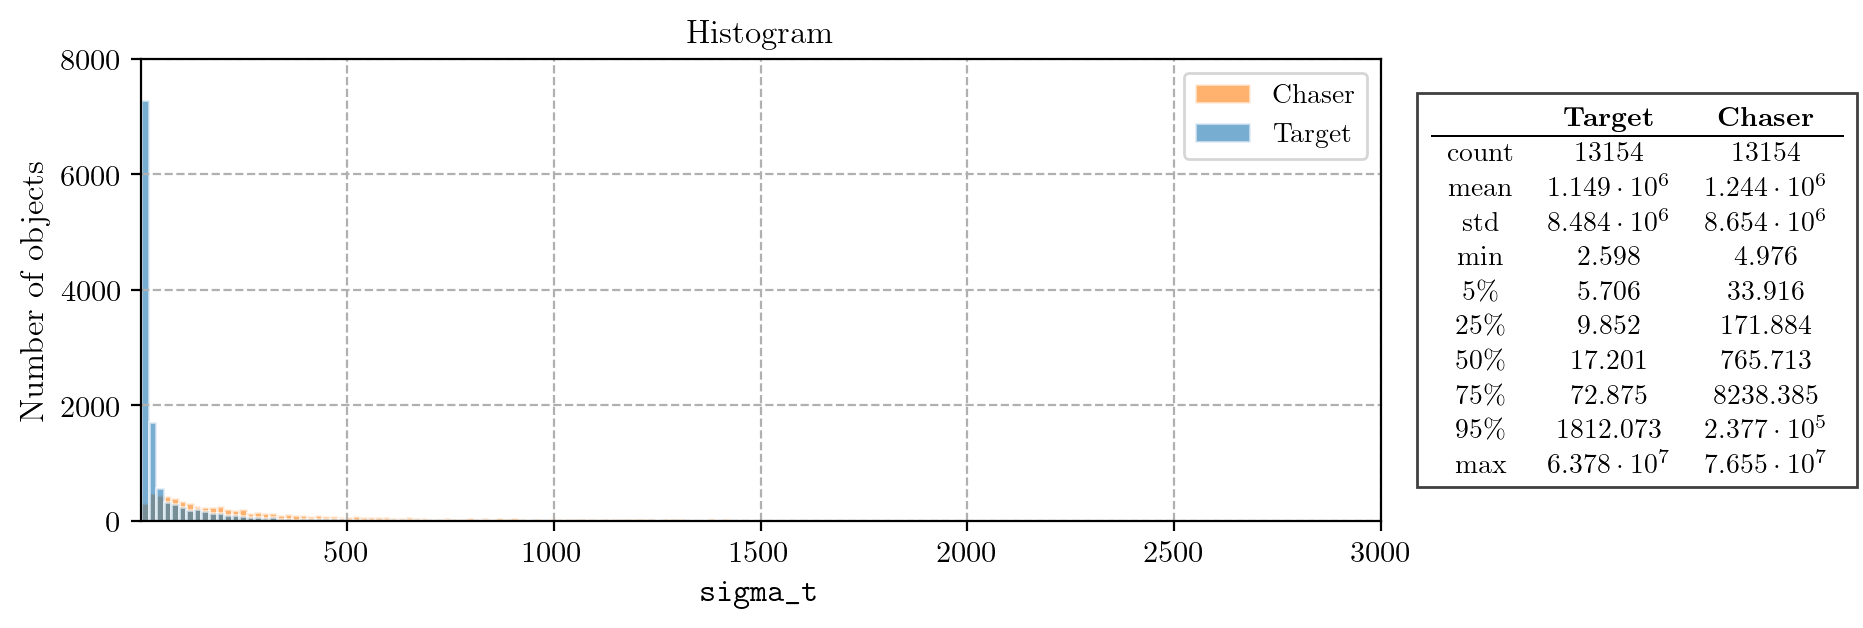

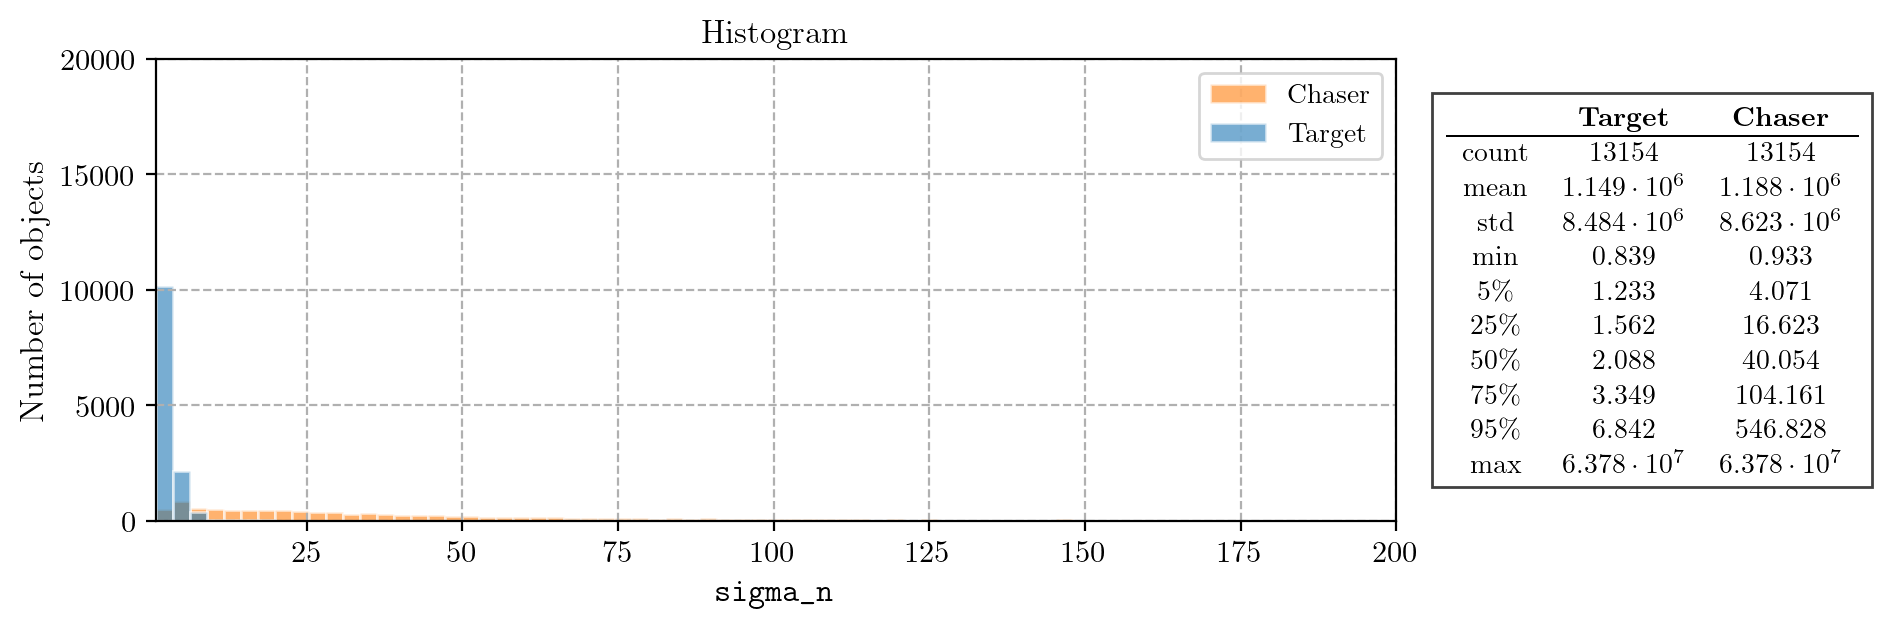

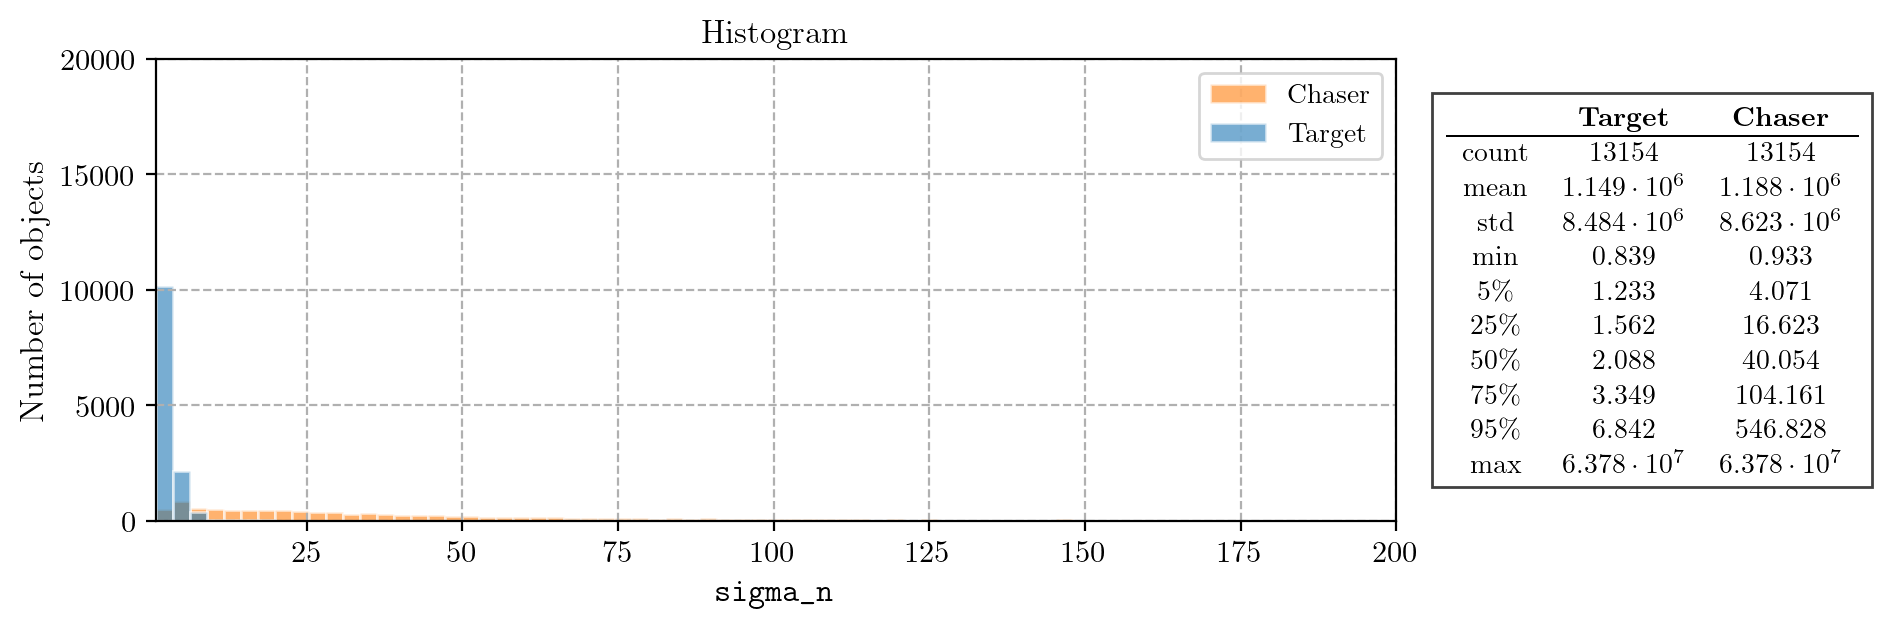

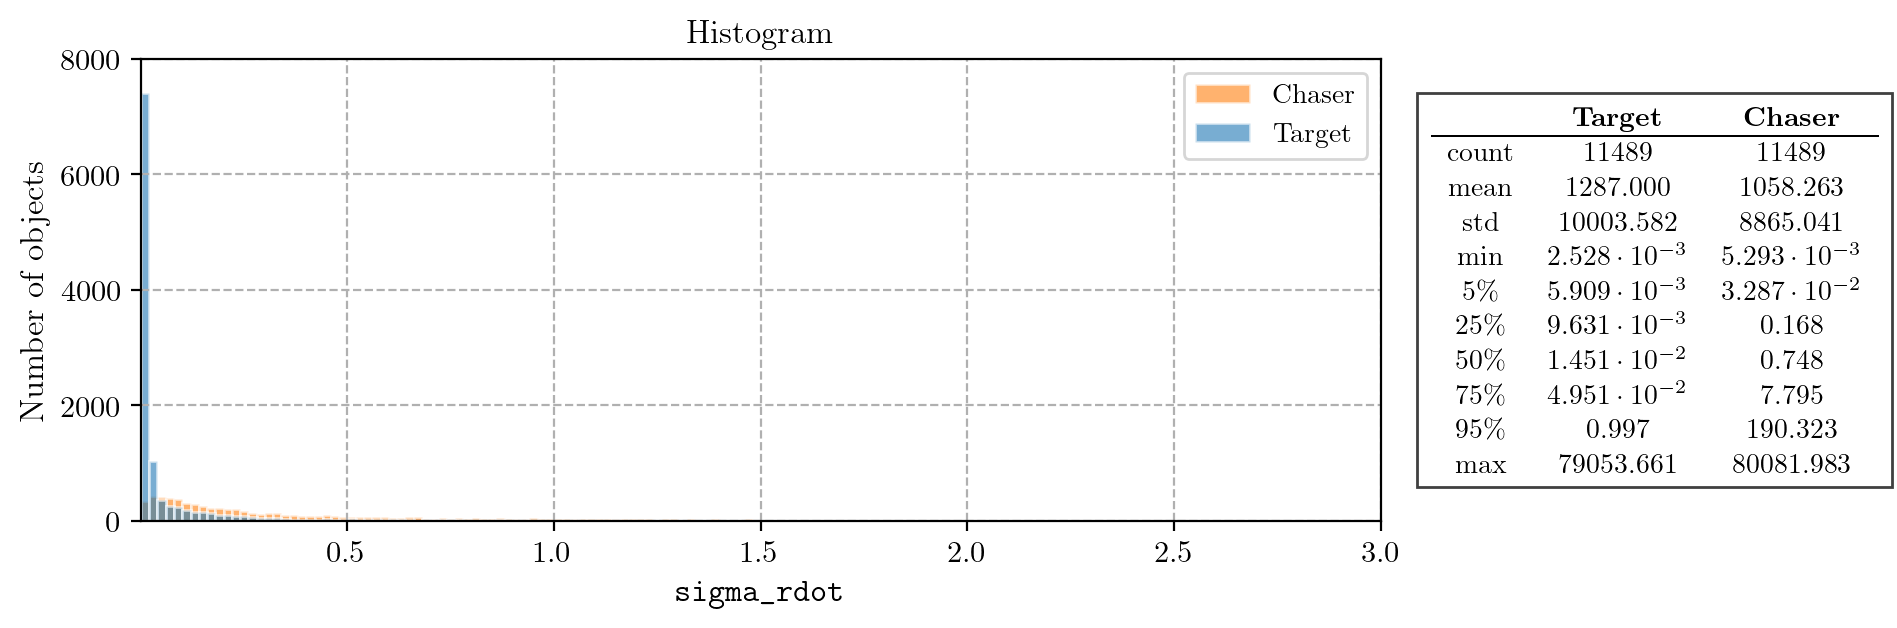

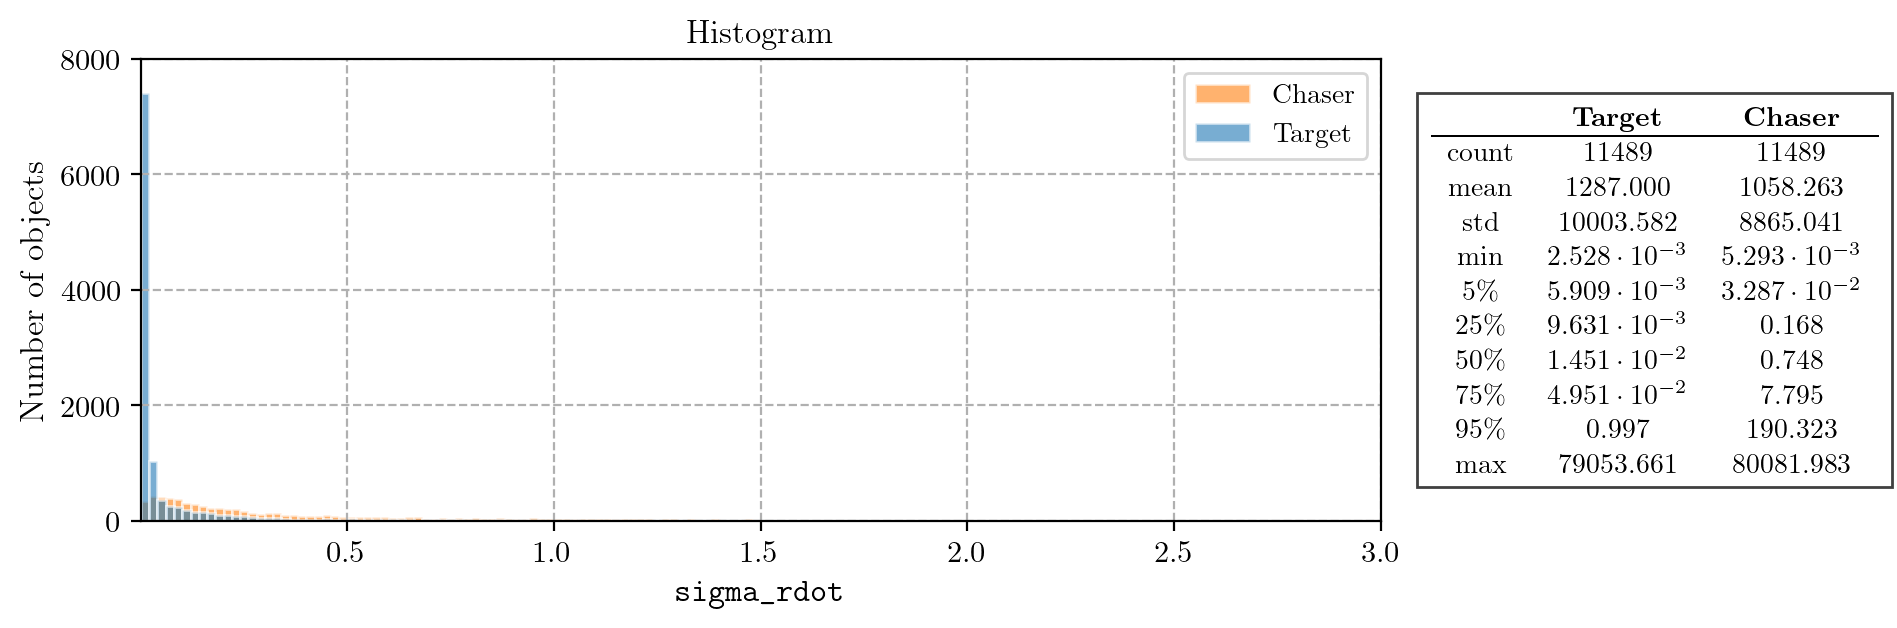

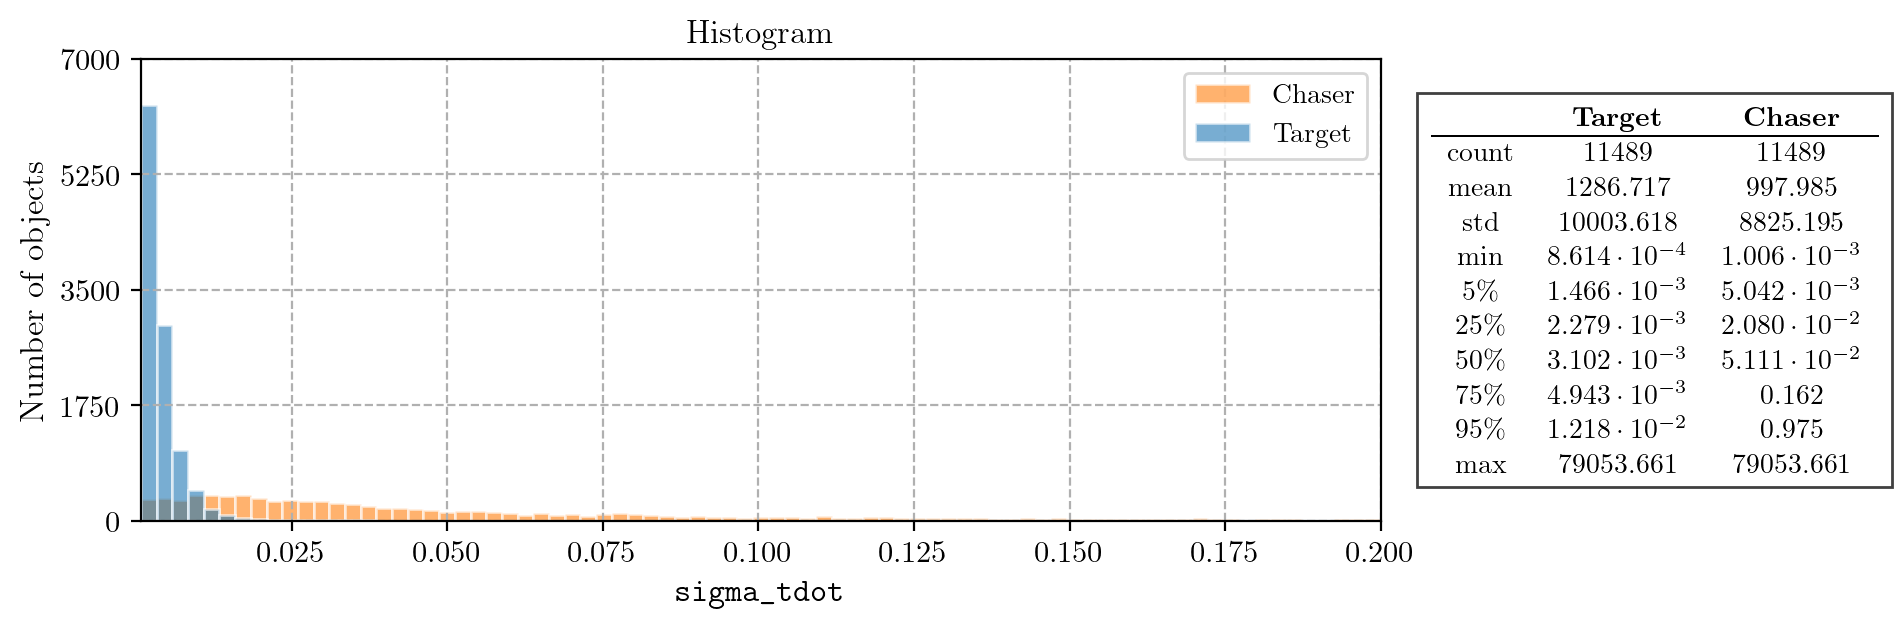

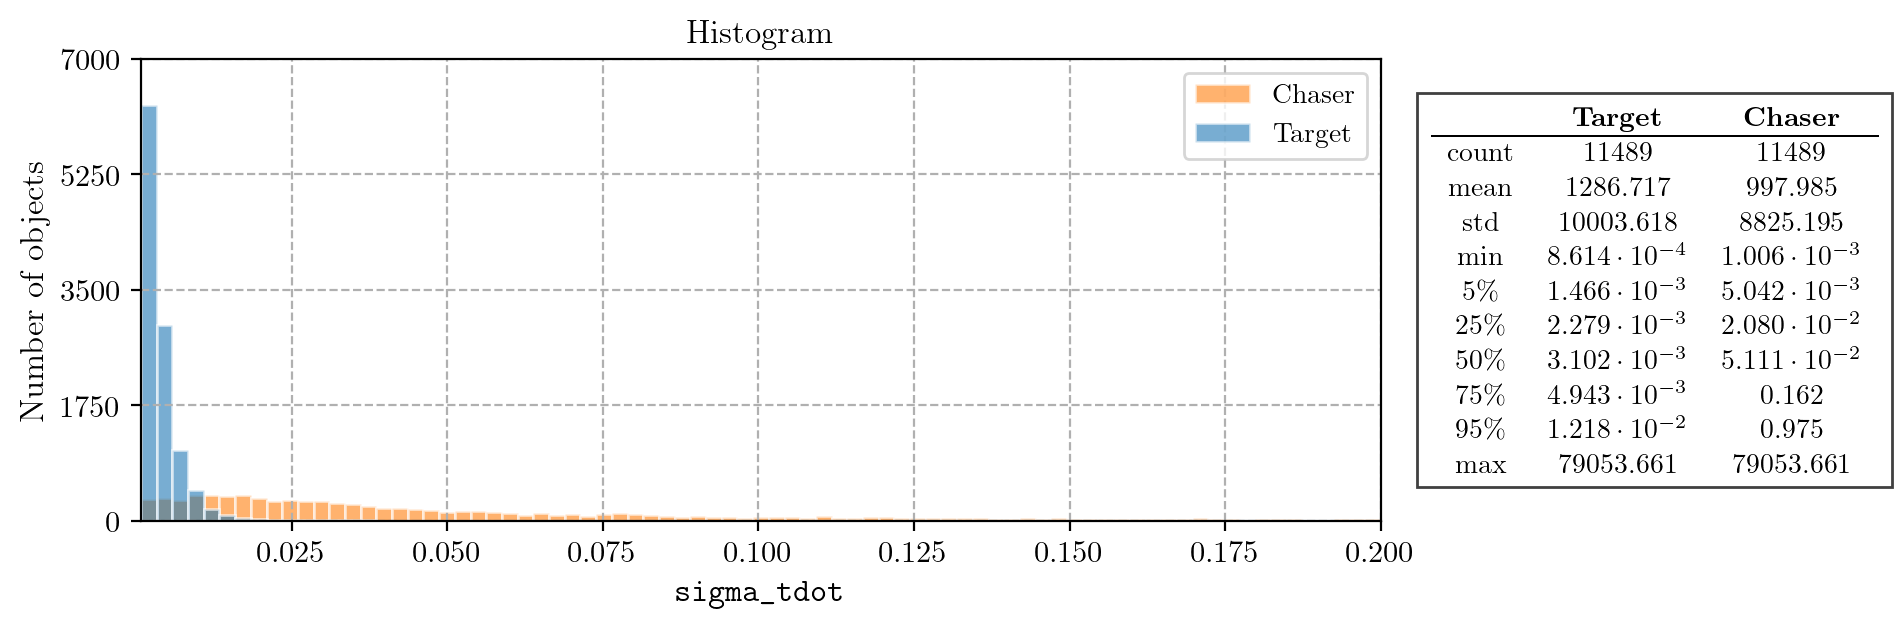

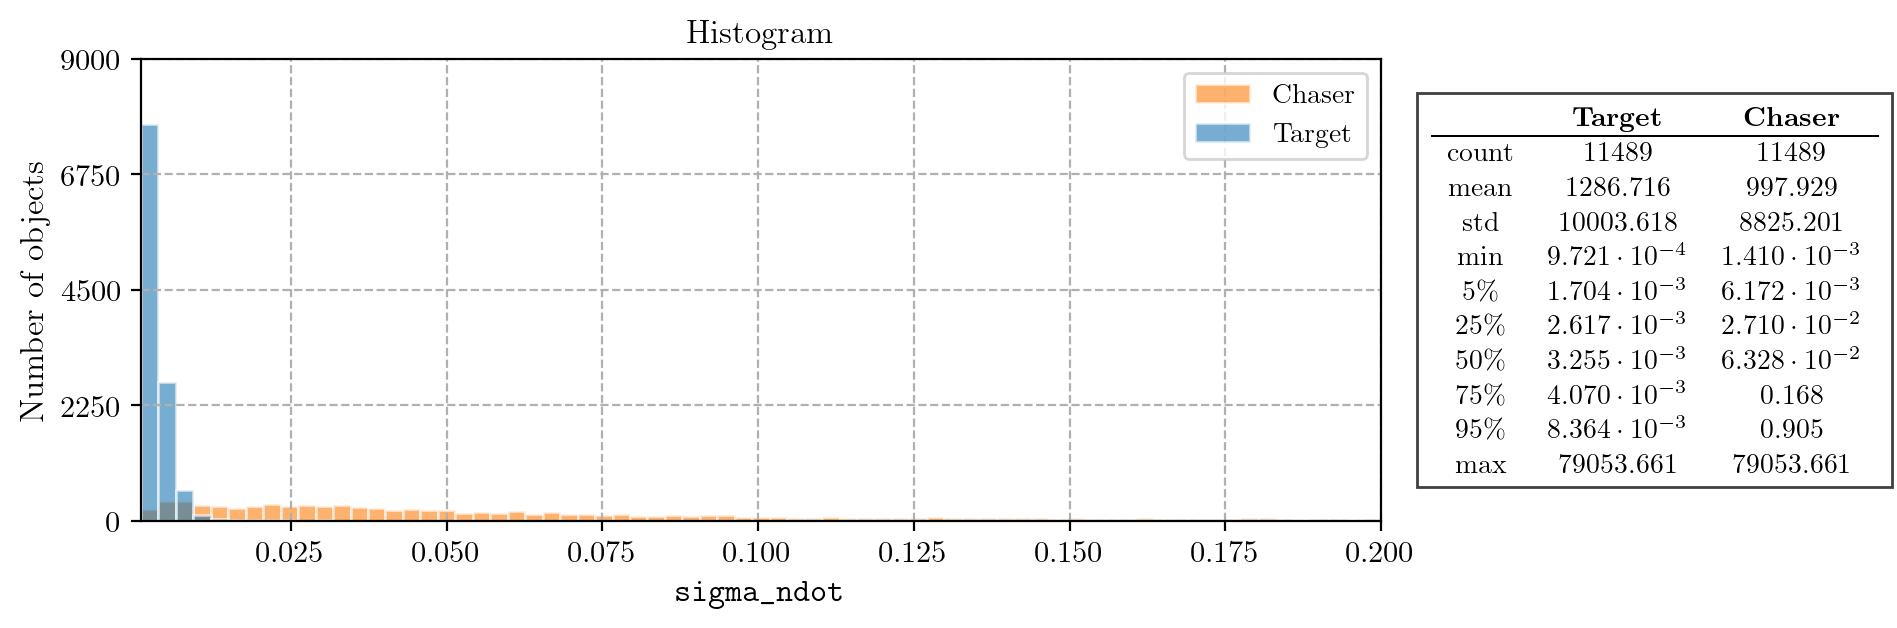

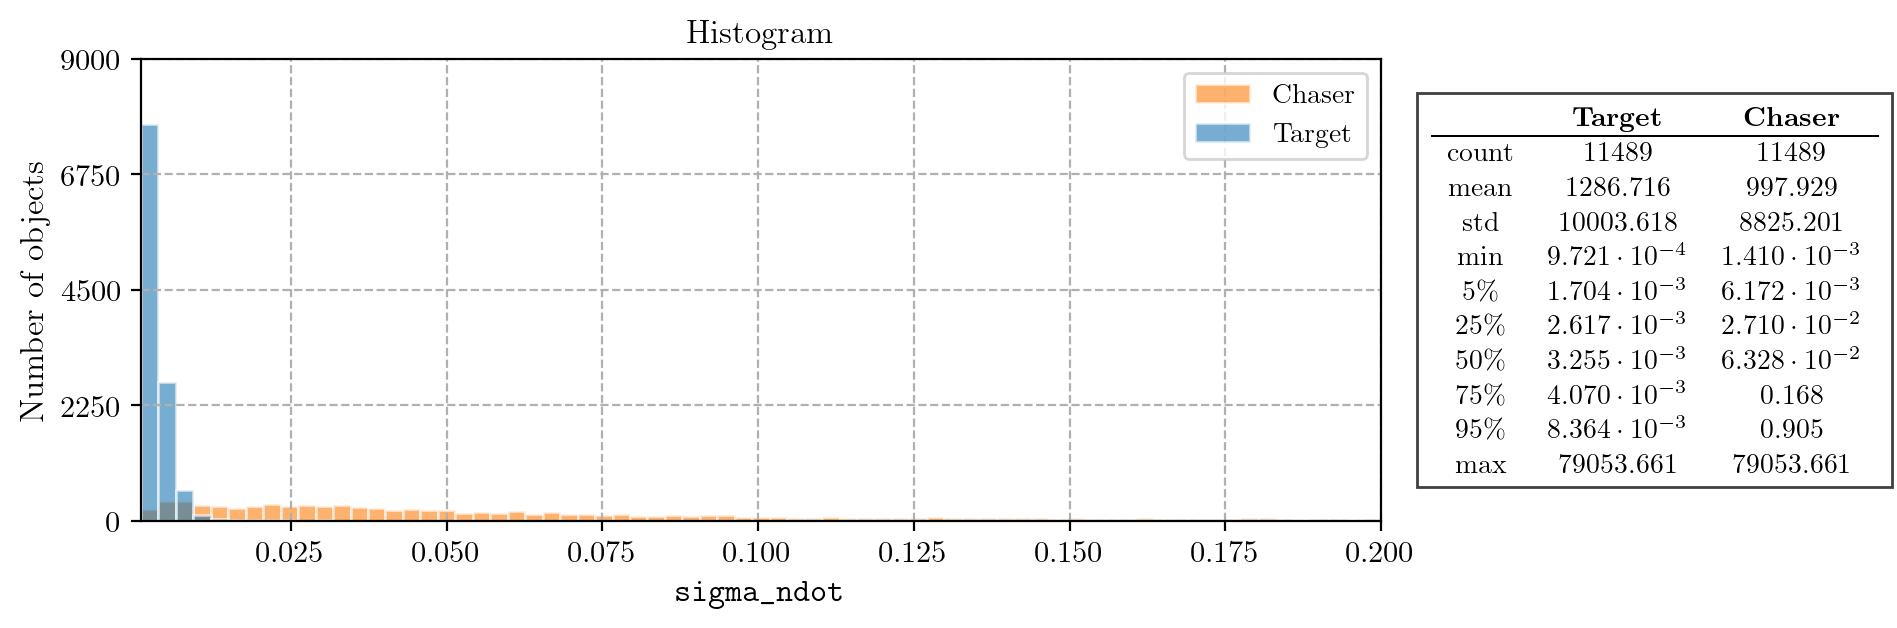

In [17]:
# Plot data distribution for elements below the main diagonal of the covariance matrix
cov_features = list(config.get_features(**{'cluster':'covariance'}).keys()) 
for feature in [f[2:] for f in cov_features if f.find('sigma')<0]:

    # Plot Target and Chaser histograms
    filepath = os.path.join(cwd,'notebooks','images','histograms', 'covariance-' + feature + '.pdf')
    kwargs = {'hist_kwargs': [dict(label=r'Target', color='tab:blue', alpha=0.6), dict(label=r'Chaser', color='tab:orange', alpha=0.6)],
              'xlim': (-1, 1), 'describe_colnames':[r'Target', r'Chaser'],
              'xlabel': r'\texttt{' + feature + '}',
              'filepath':filepath}

    features = [o + feature for o in ['t_', 'c_']]
    eda.plot_histogram(df_lastCDM, features, **kwargs)
    
    
# Plot data distribution for the variance from the state vector covariance matrix (main diagonal)
for feature in [f[2:] for f in cov_features if f.find('sigma')>=0]:

    # Plot Target and Chaser histograms
    filepath = os.path.join(cwd,'notebooks','images','histograms', 'covariance-' + feature + '.pdf')
    kwargs = {'hist_kwargs': [dict(label=r'Target', color='tab:blue',   alpha=0.6), 
                              dict(label=r'Chaser', color='tab:orange', alpha=0.6)],
              'describe_colnames':[r'Target', r'Chaser'],
              'xlabel': r'\texttt{' + feature + '}',
              'filepath':filepath}

    features = [o + feature for o in ['t_', 'c_']]
    eda.plot_histogram(df_lastCDM, features, **kwargs)
    

### 2.4. - Miscellaneous

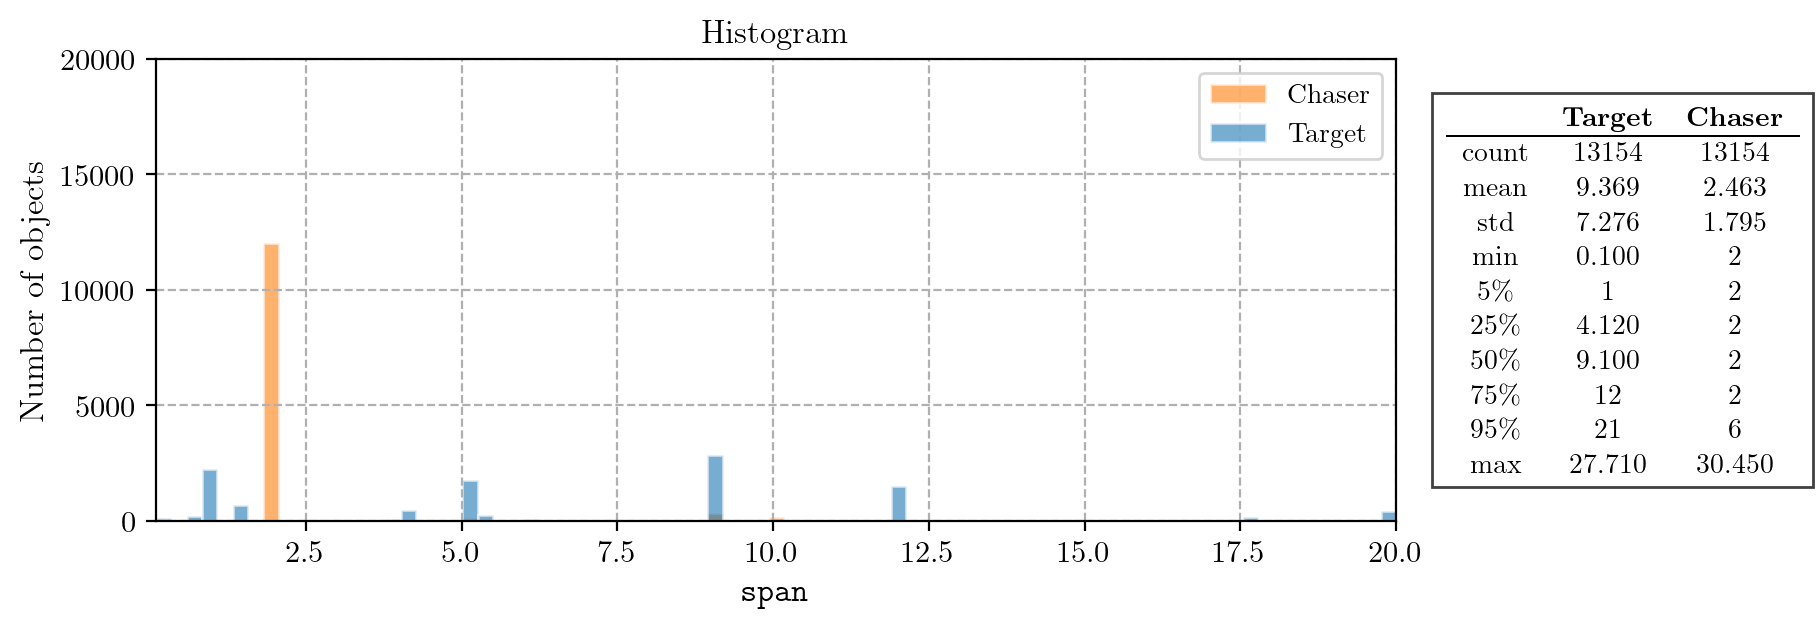

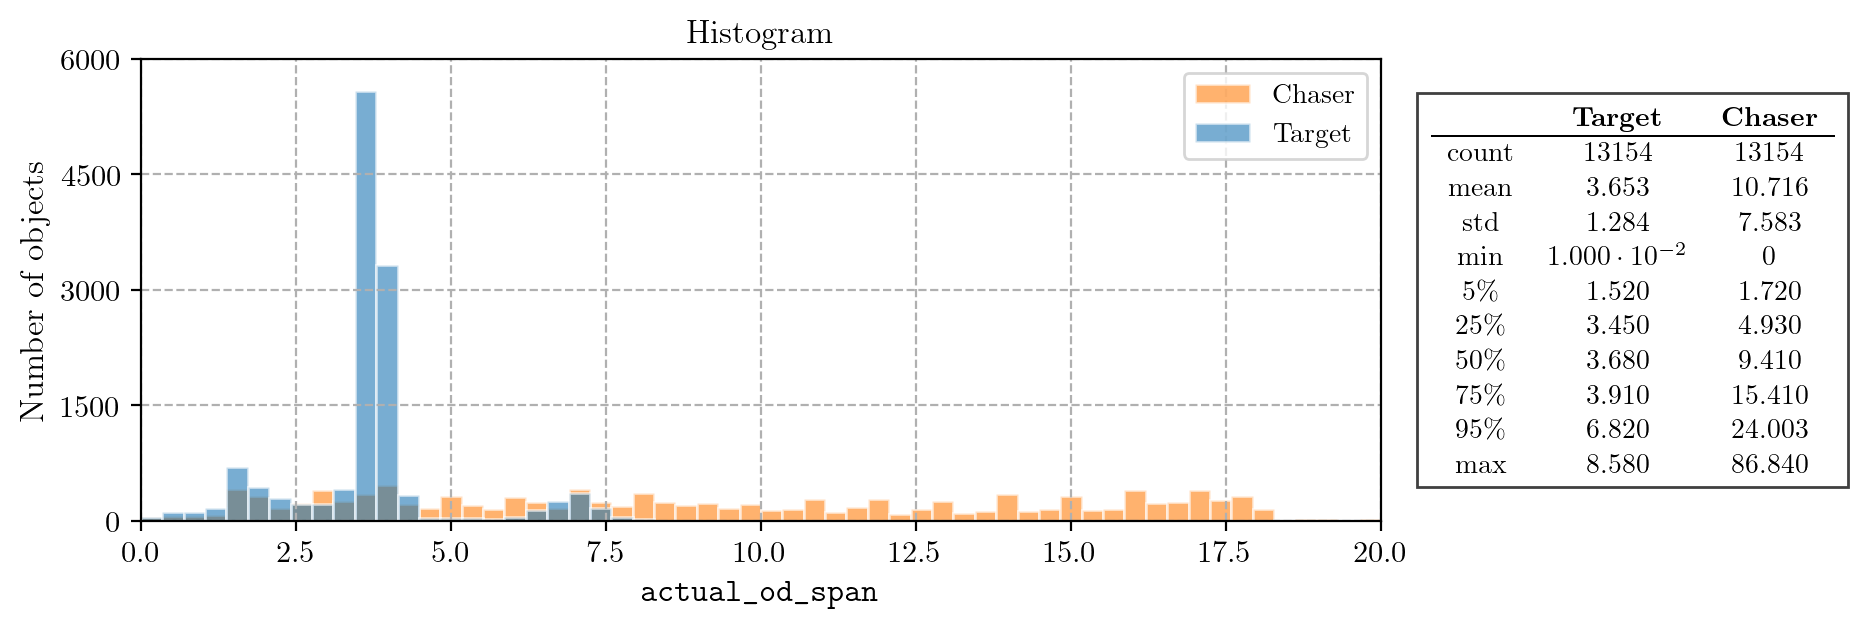

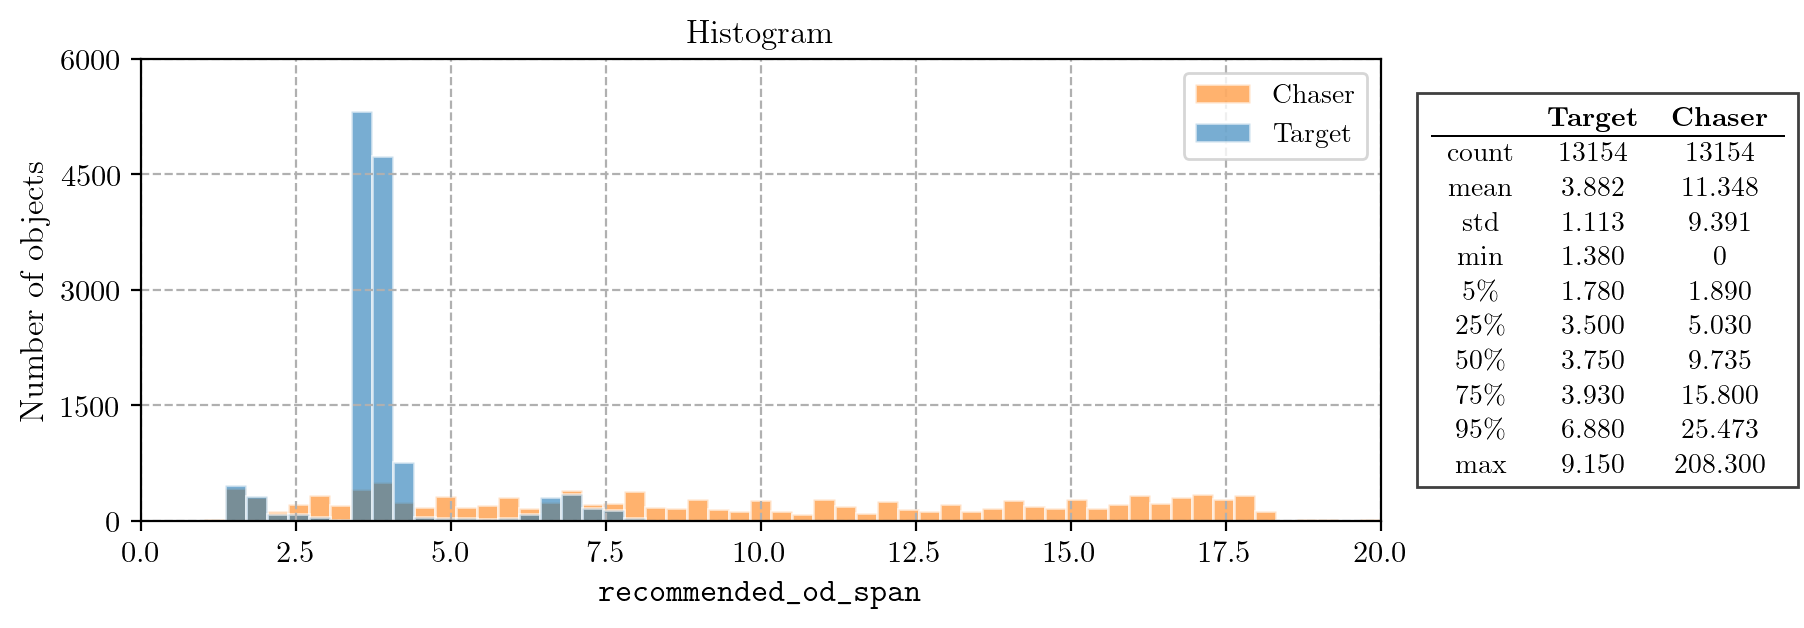

ValueError: cannot convert float NaN to integer

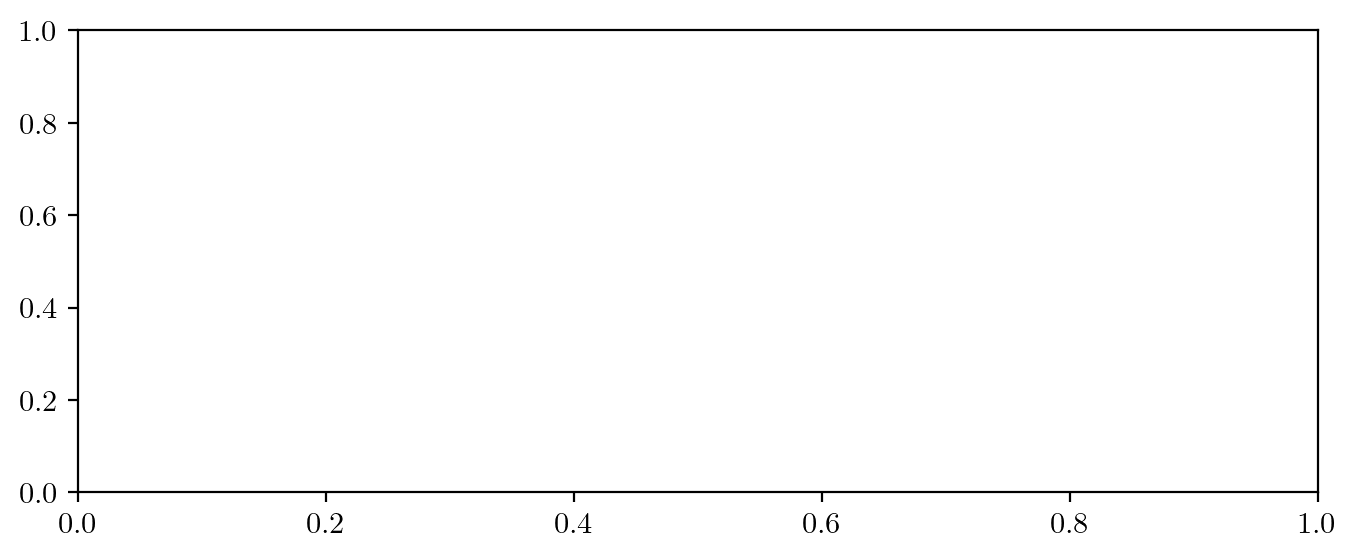

In [11]:
# Plot data distribution for elements below the main diagonal of the covariance matrix
for feature in [f for f in features_groups['objects']['miscellaneous']]:

    # Plot Target and Chaser histograms
    filepath = os.path.join(cwd,'notebooks','images','histograms', 'miscellaneous-' + feature + '.pdf')
    kwargs = {'hist_kwargs': [dict(label=r'Target', color='tab:blue', alpha=0.6), dict(label=r'Chaser', color='tab:orange', alpha=0.6)],
              'xlabel': r'\texttt{' + feature + '}', 'describe_colnames':[r'Target', r'Chaser'], 'filepath':filepath}

    features = [o + feature for o in ['t_', 'c_']]
    eda.plot_histogram(df_lastCDM, features, **kwargs)

## 3. - Data transformation: normalization and standardization

In [45]:
# Create a deep copy of the original dataframe
dft = df.copy(deep=True)

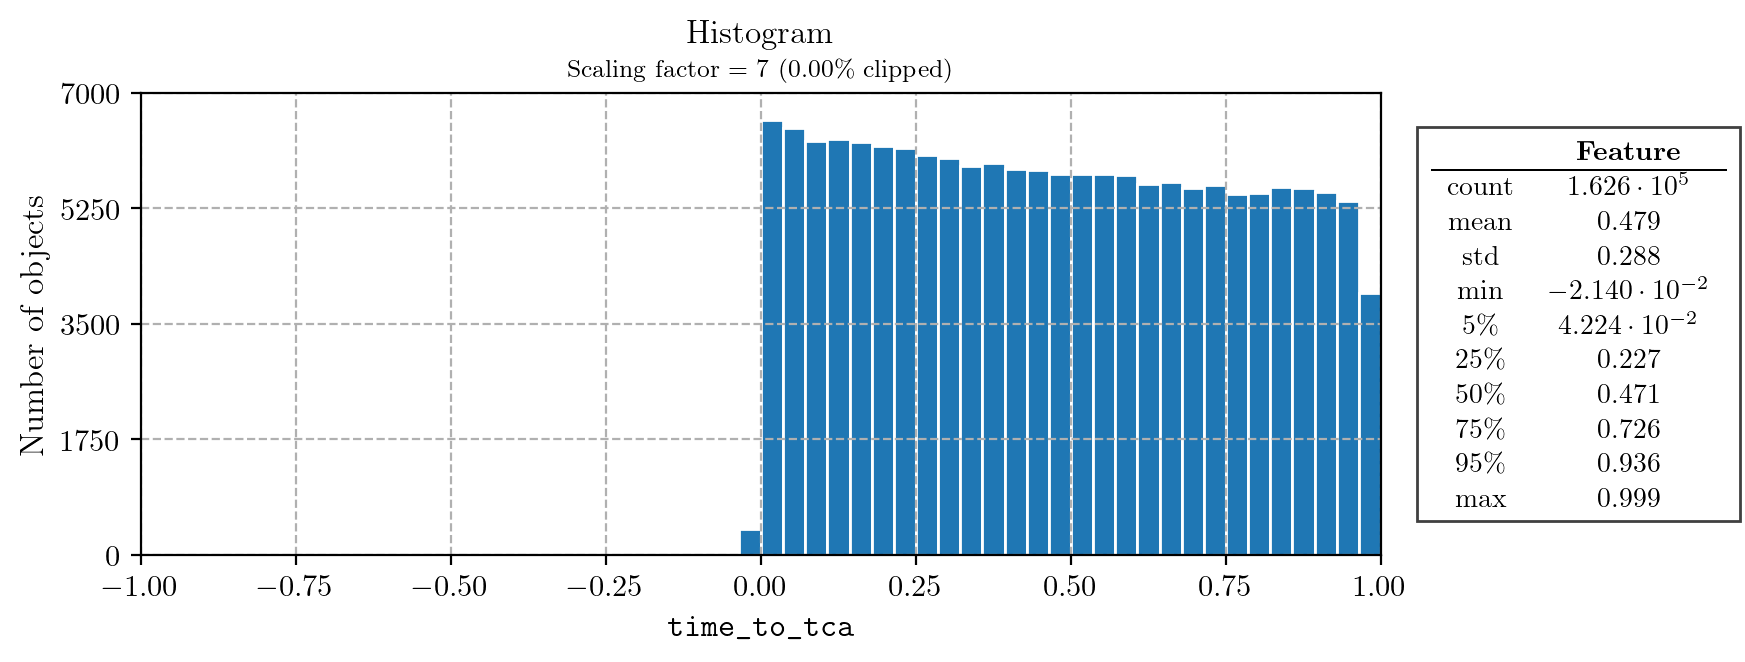

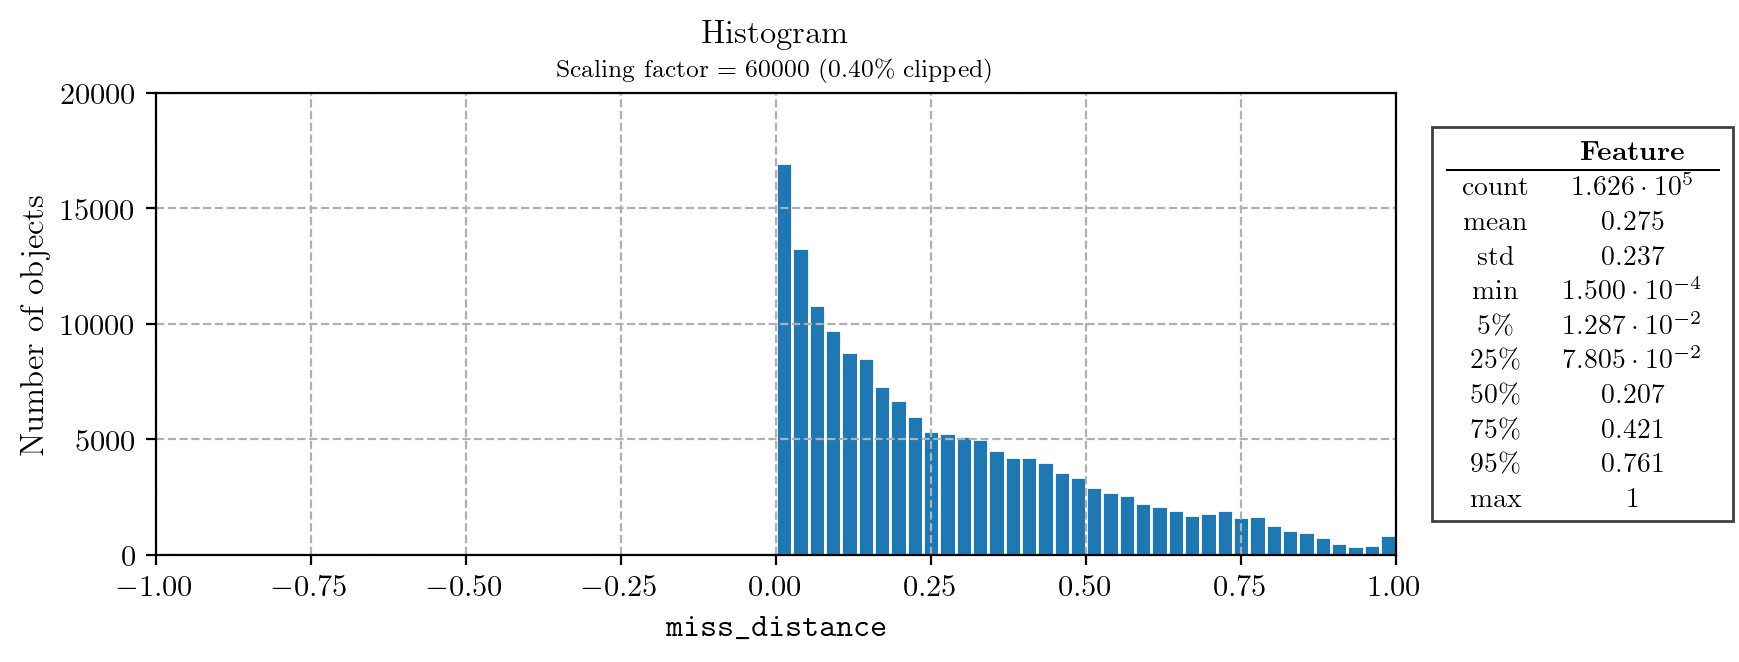

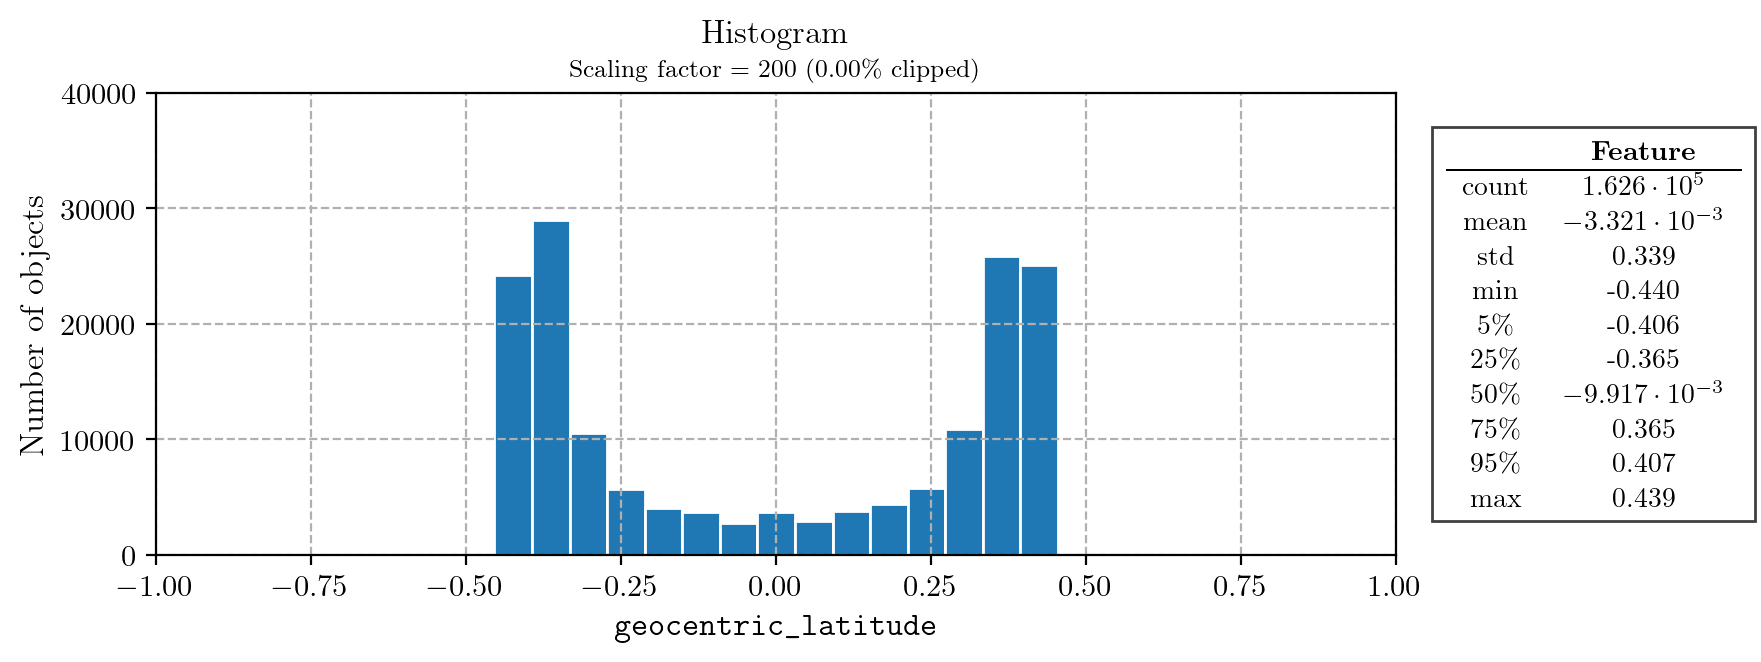

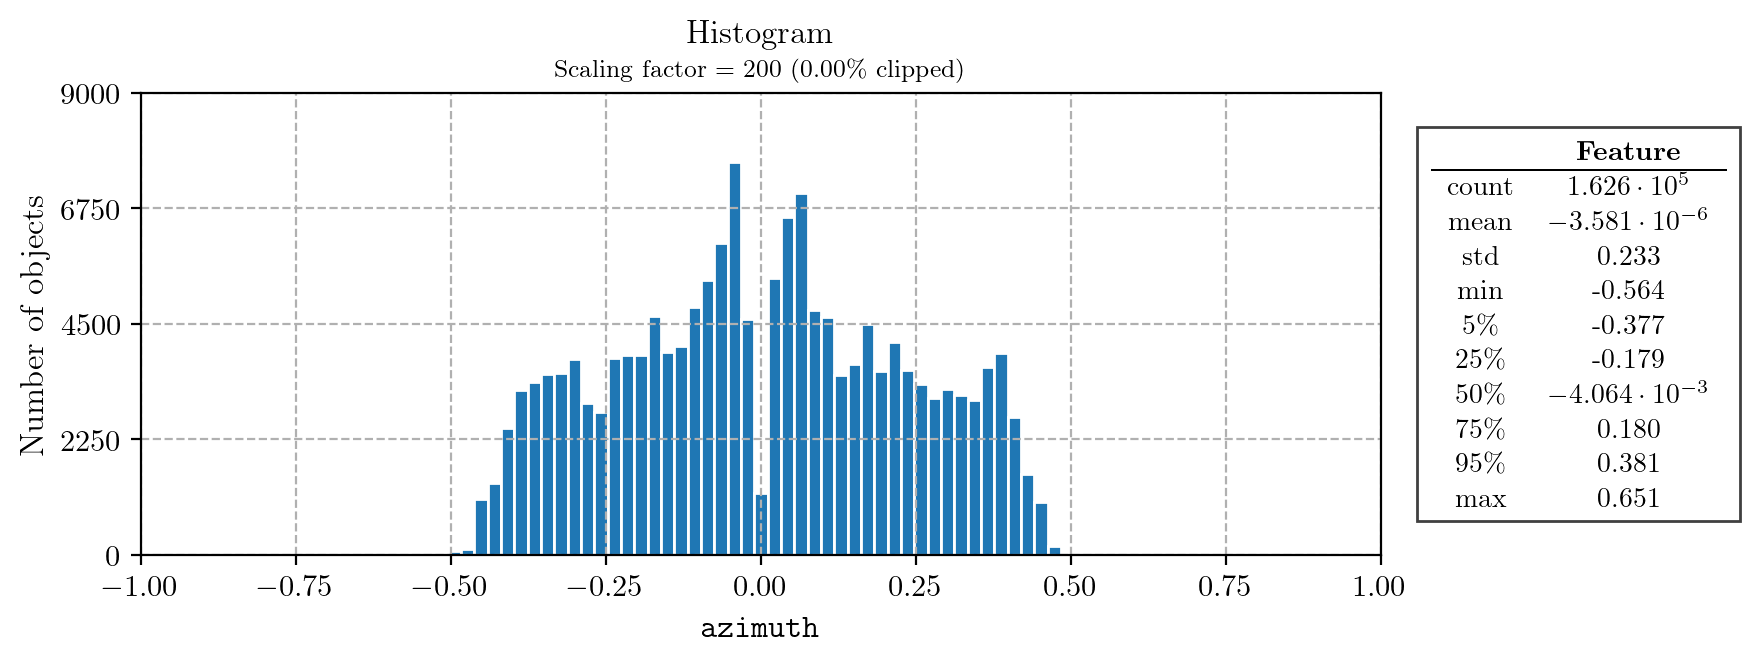

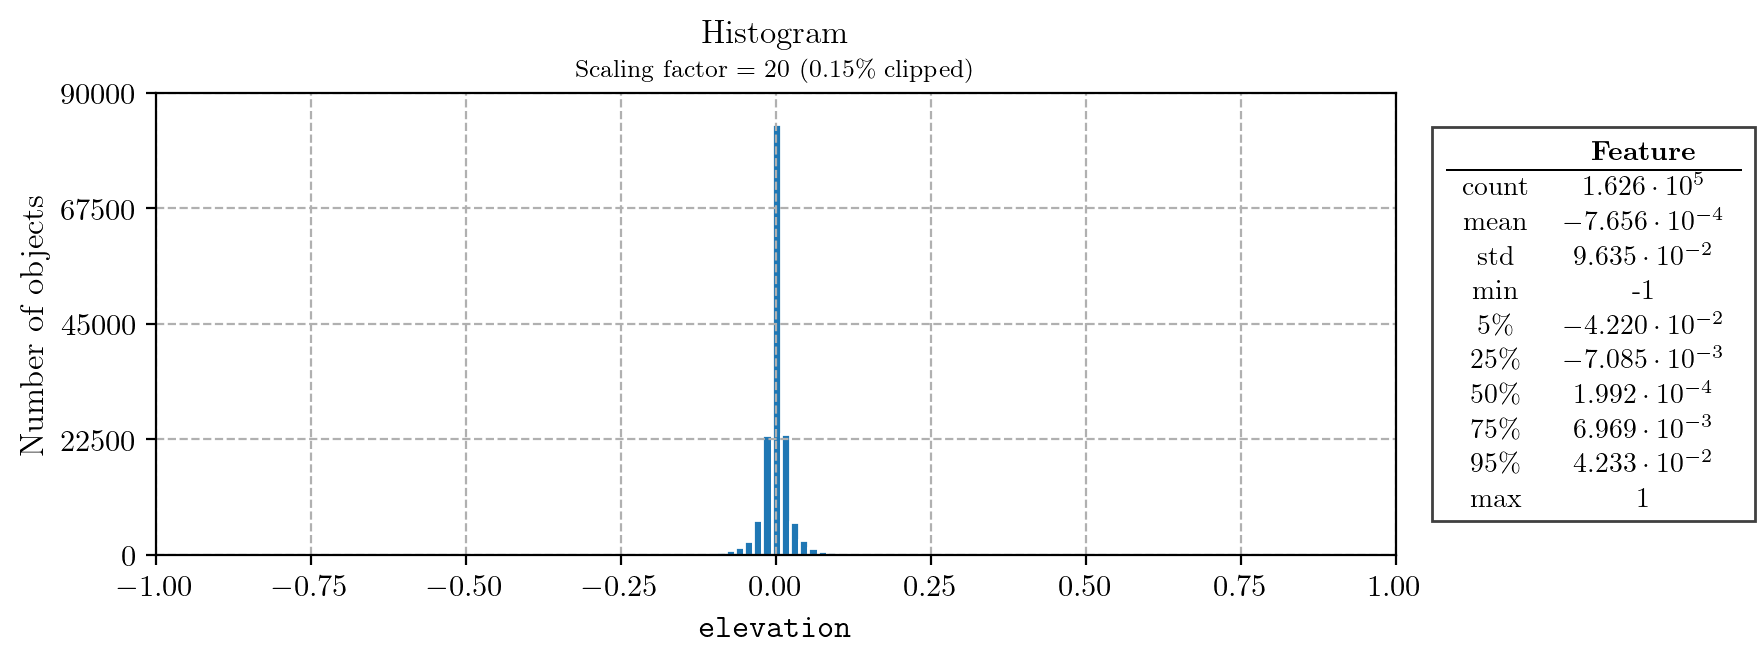

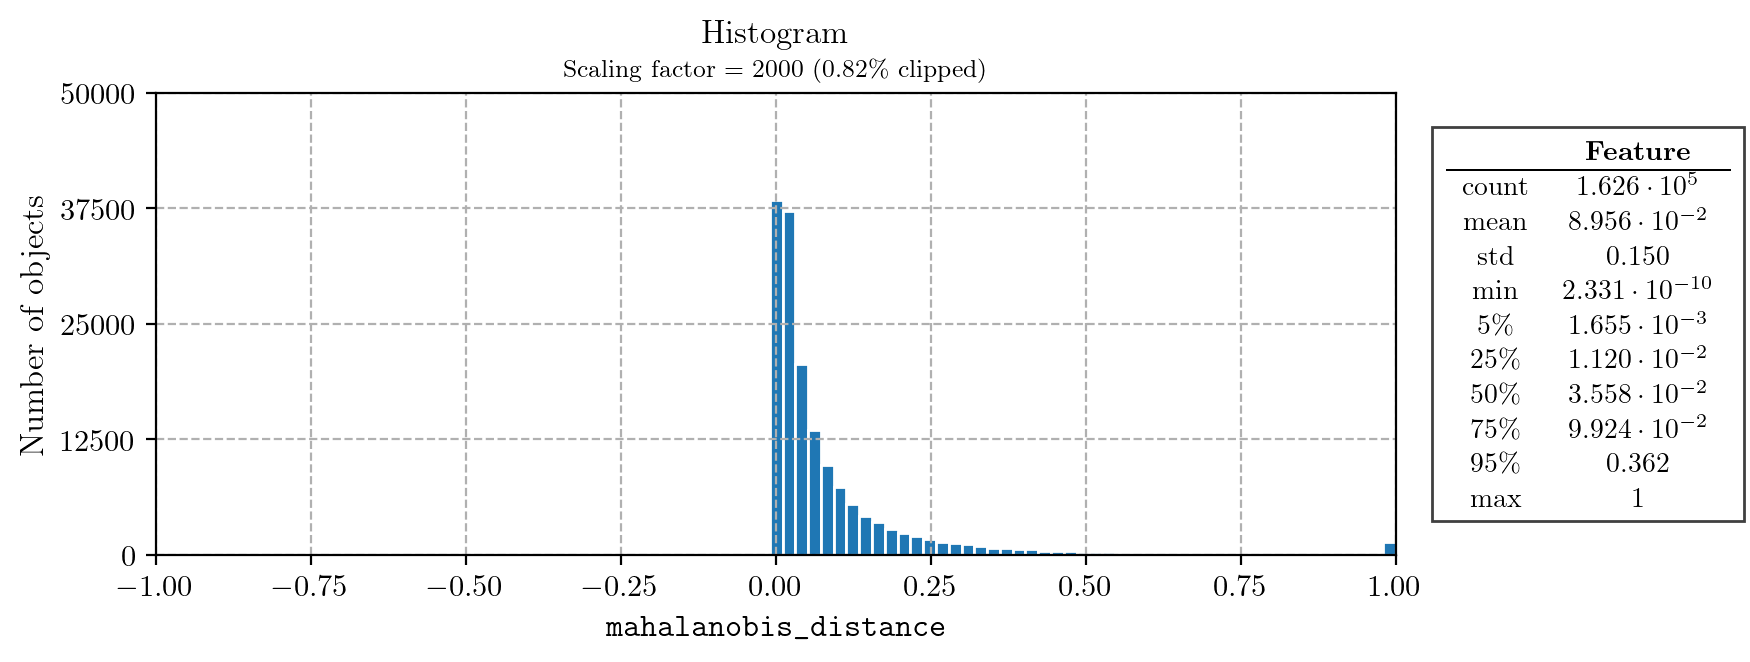

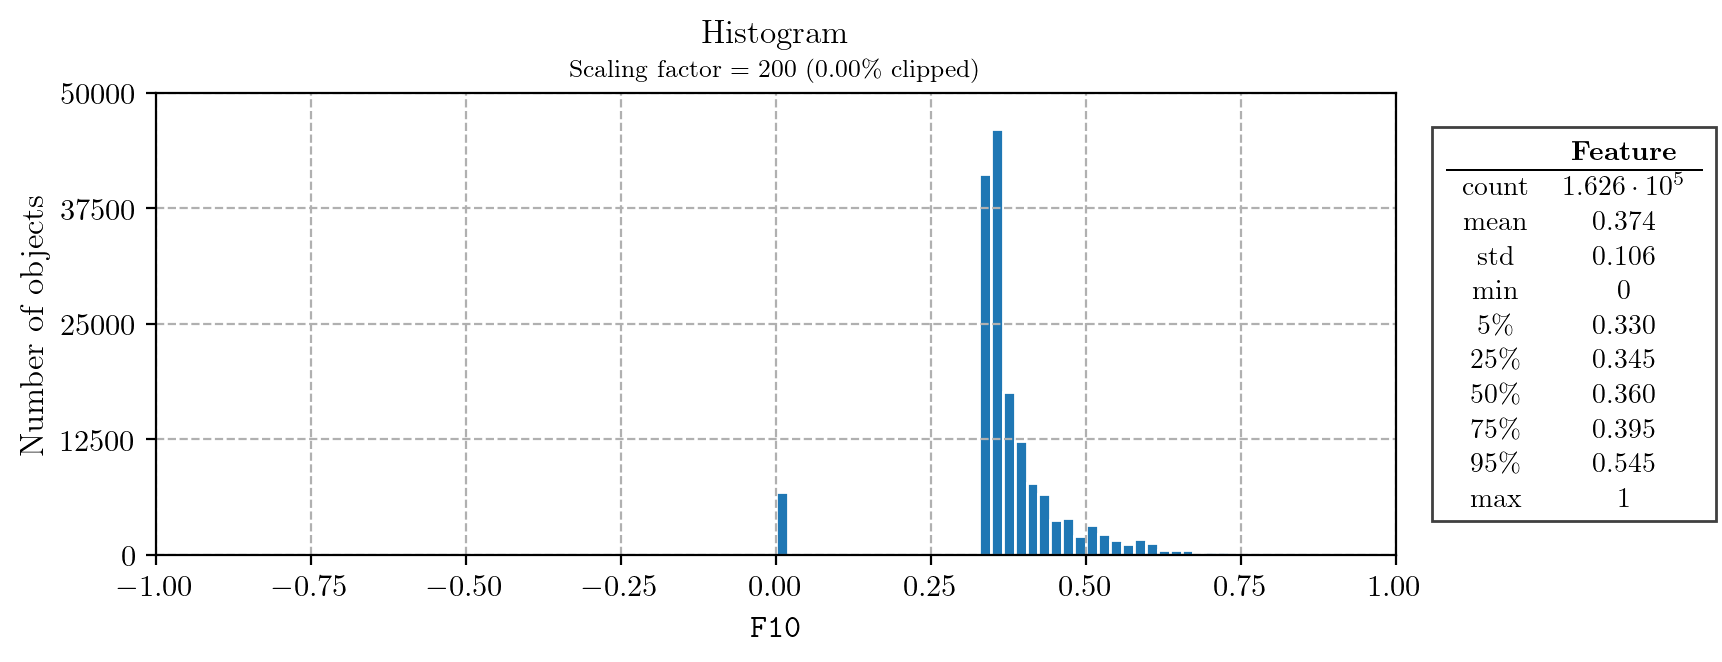

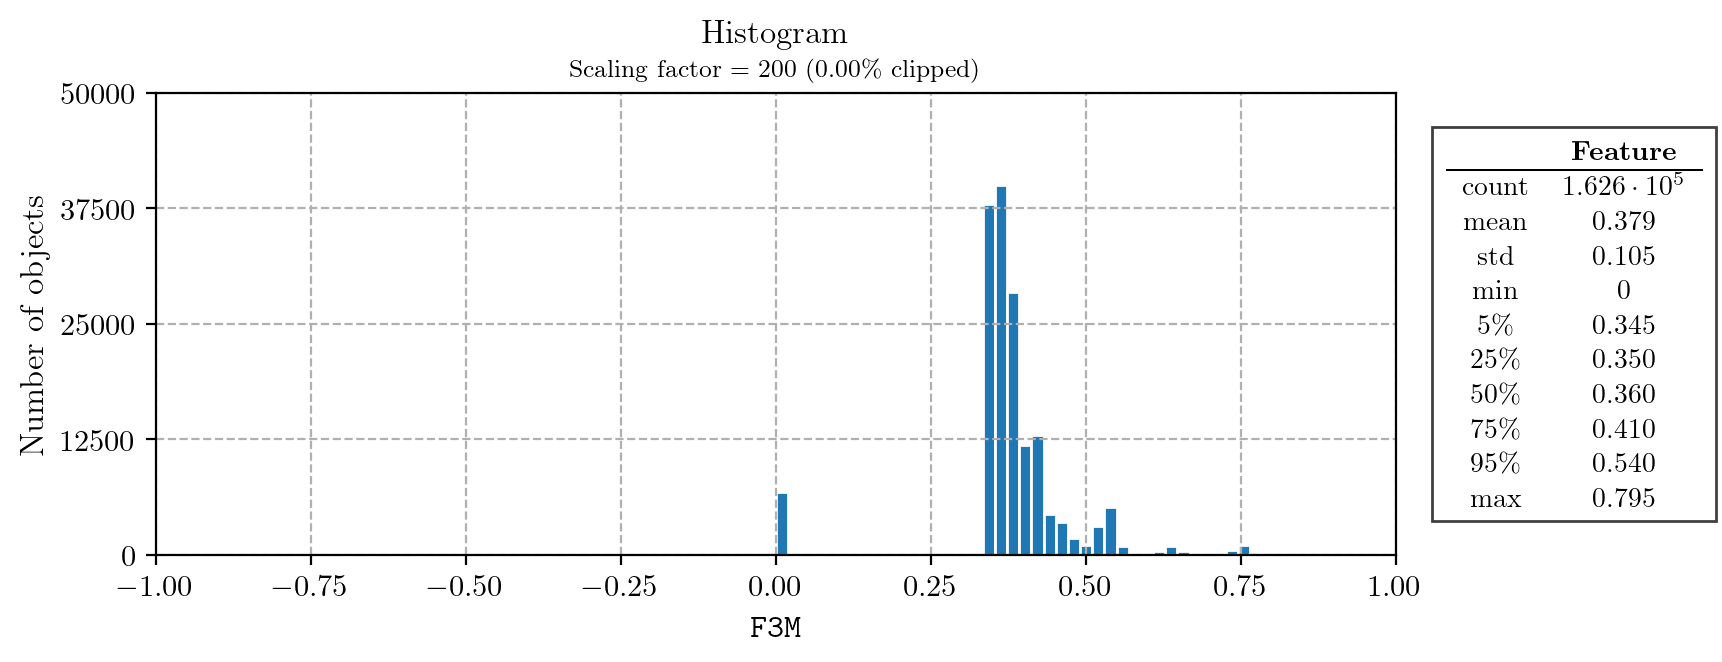

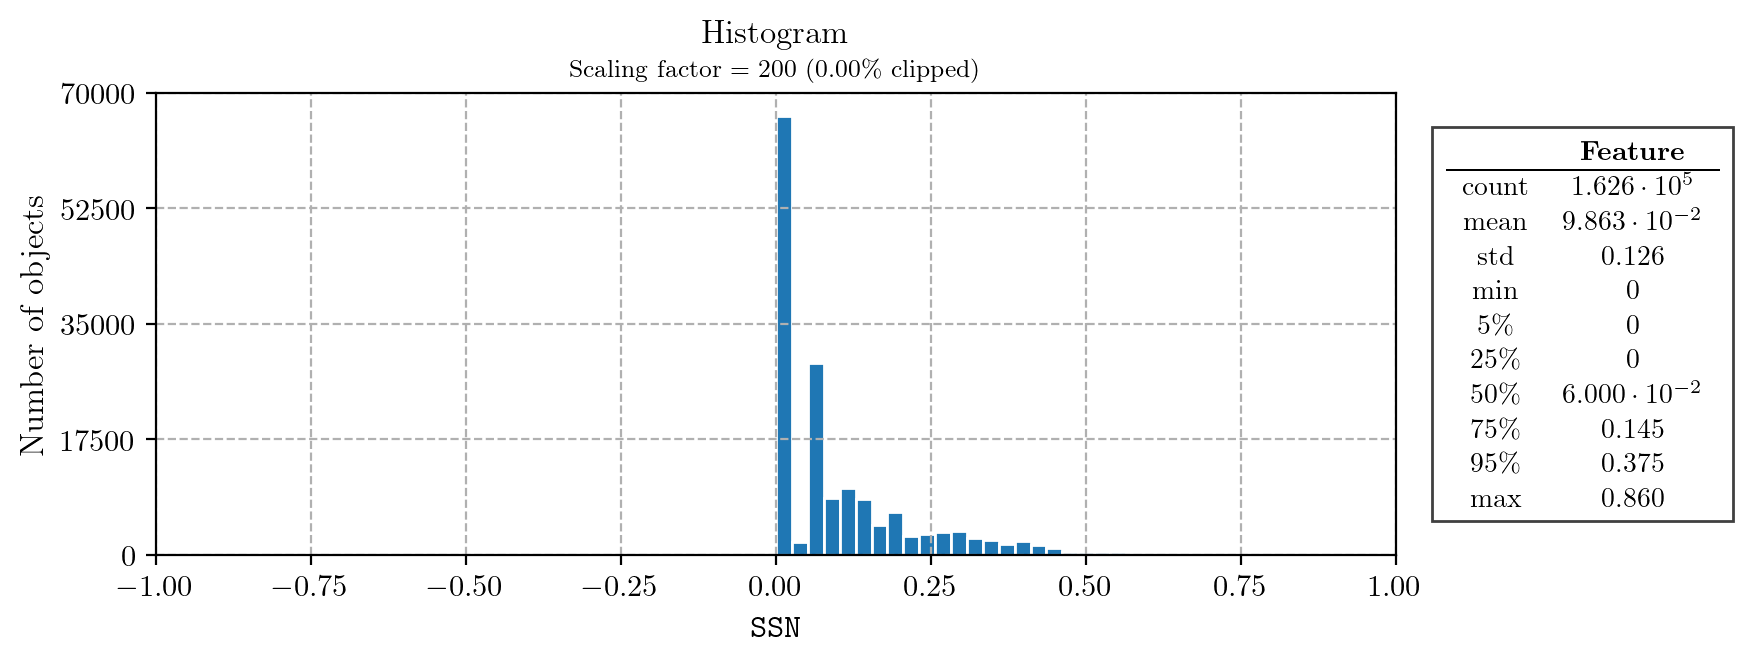

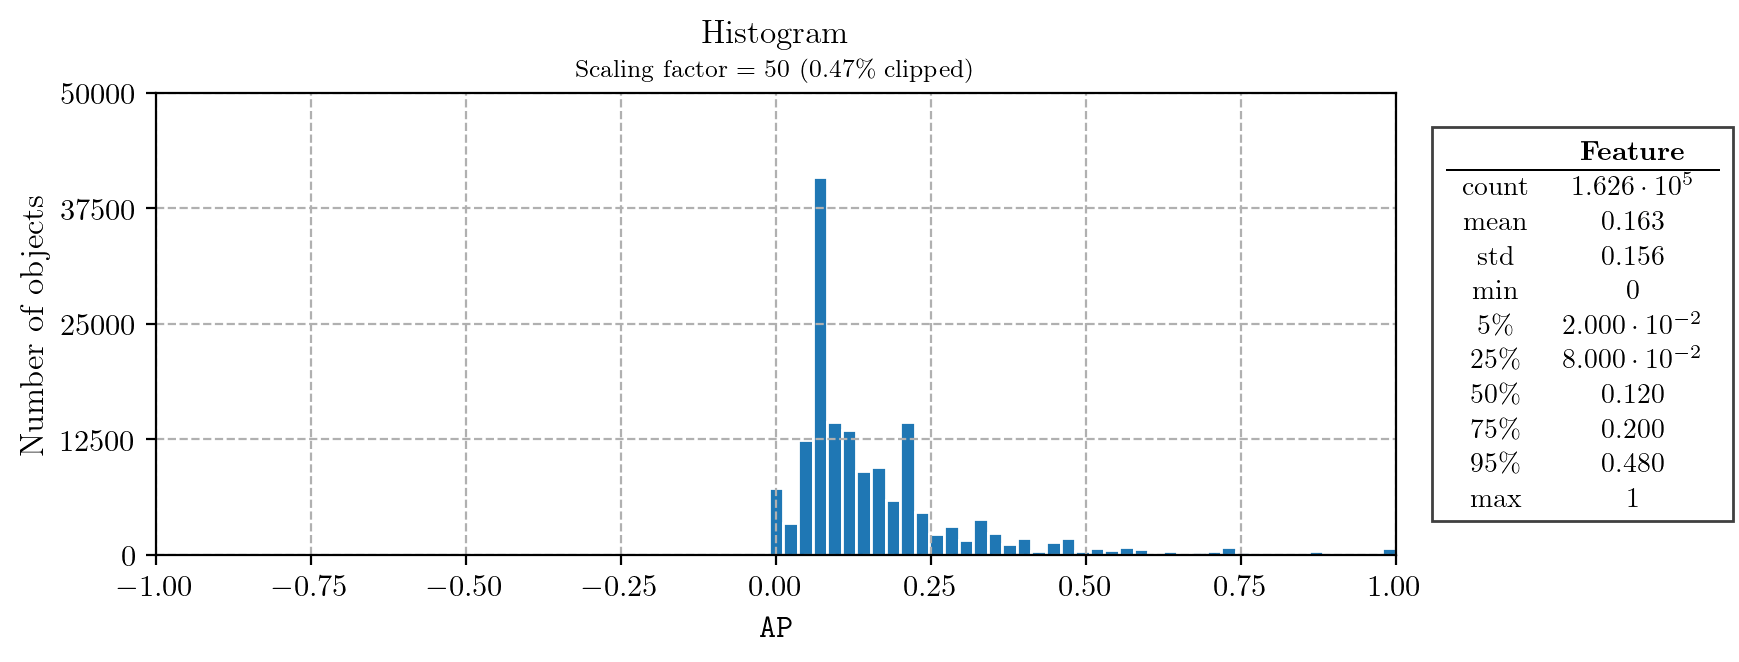

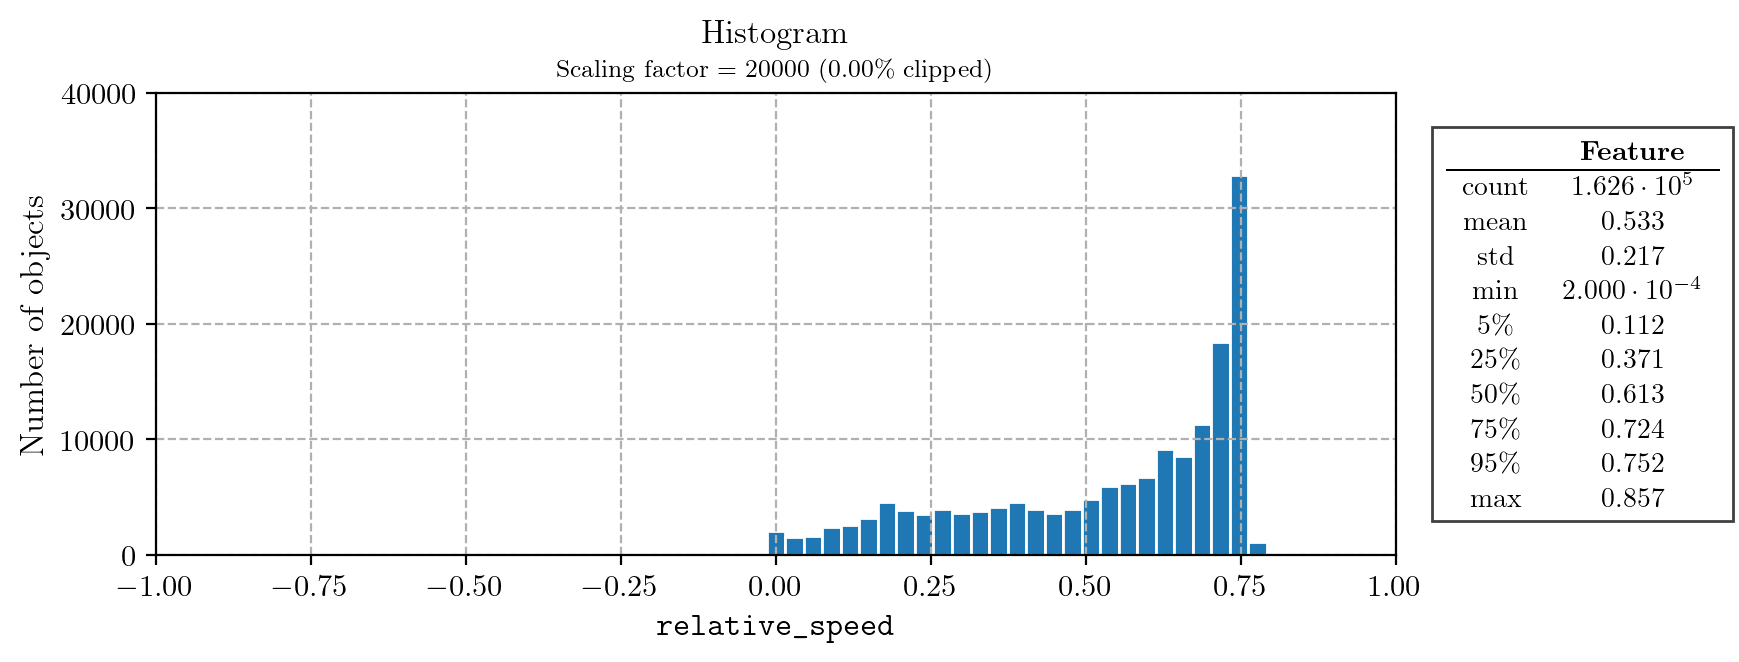

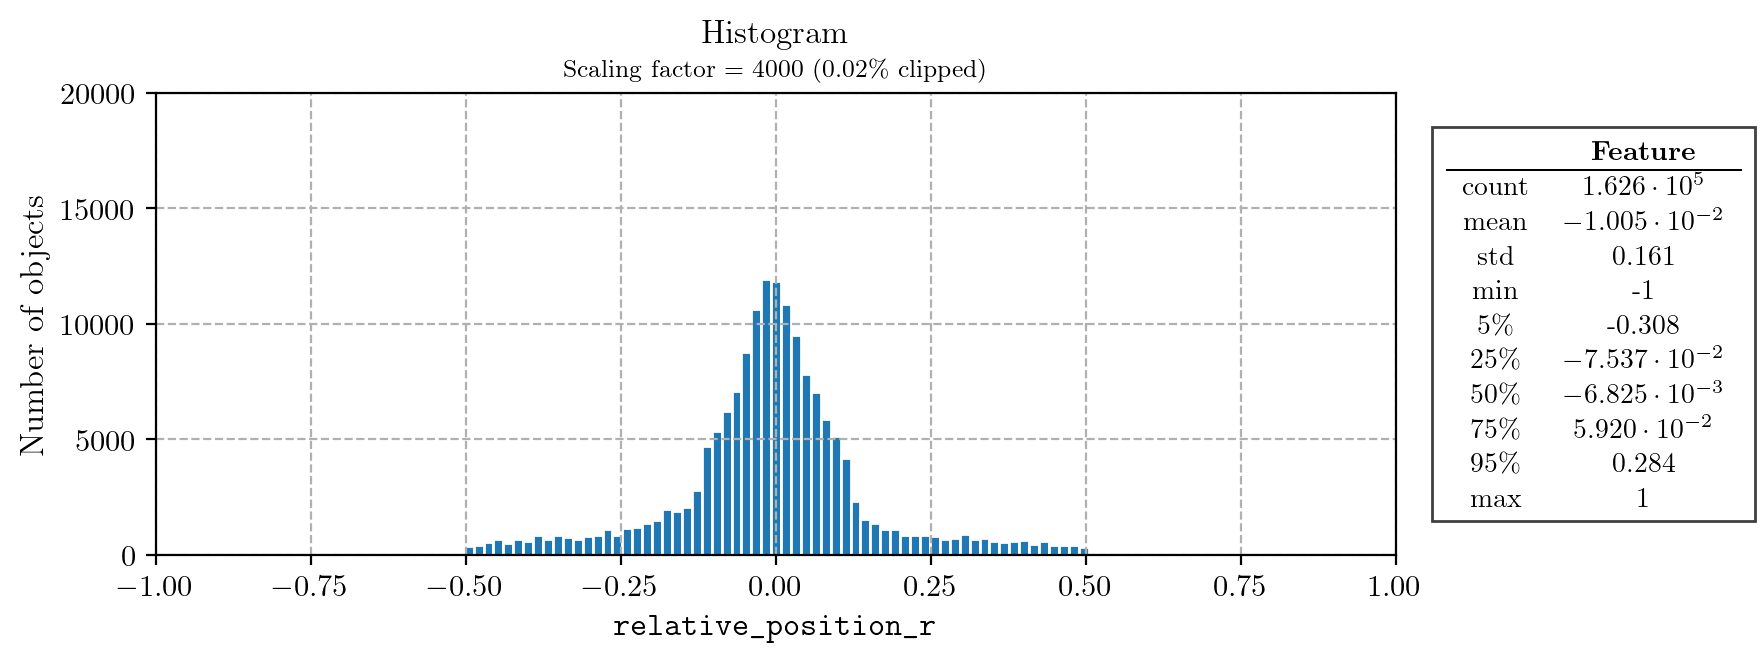

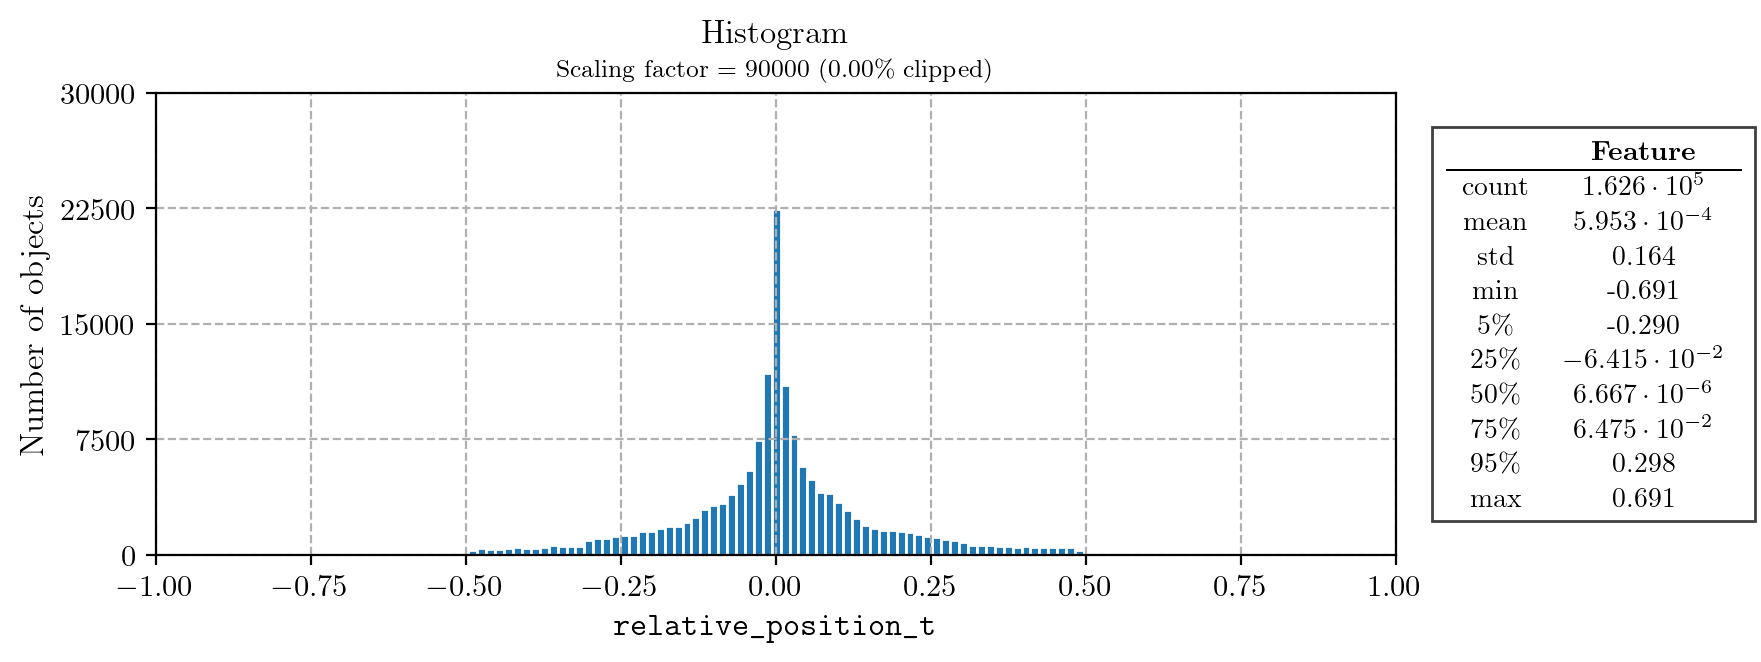

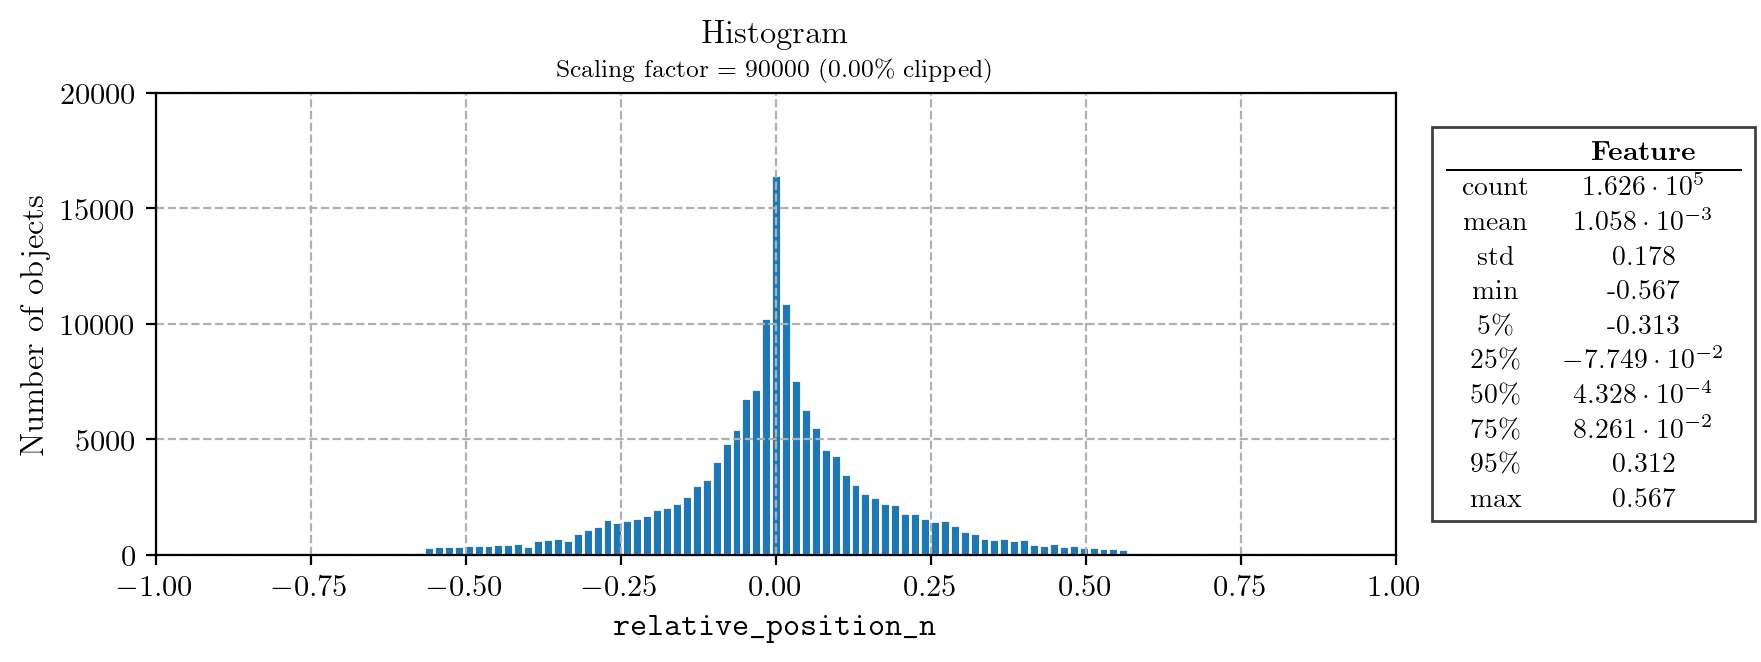

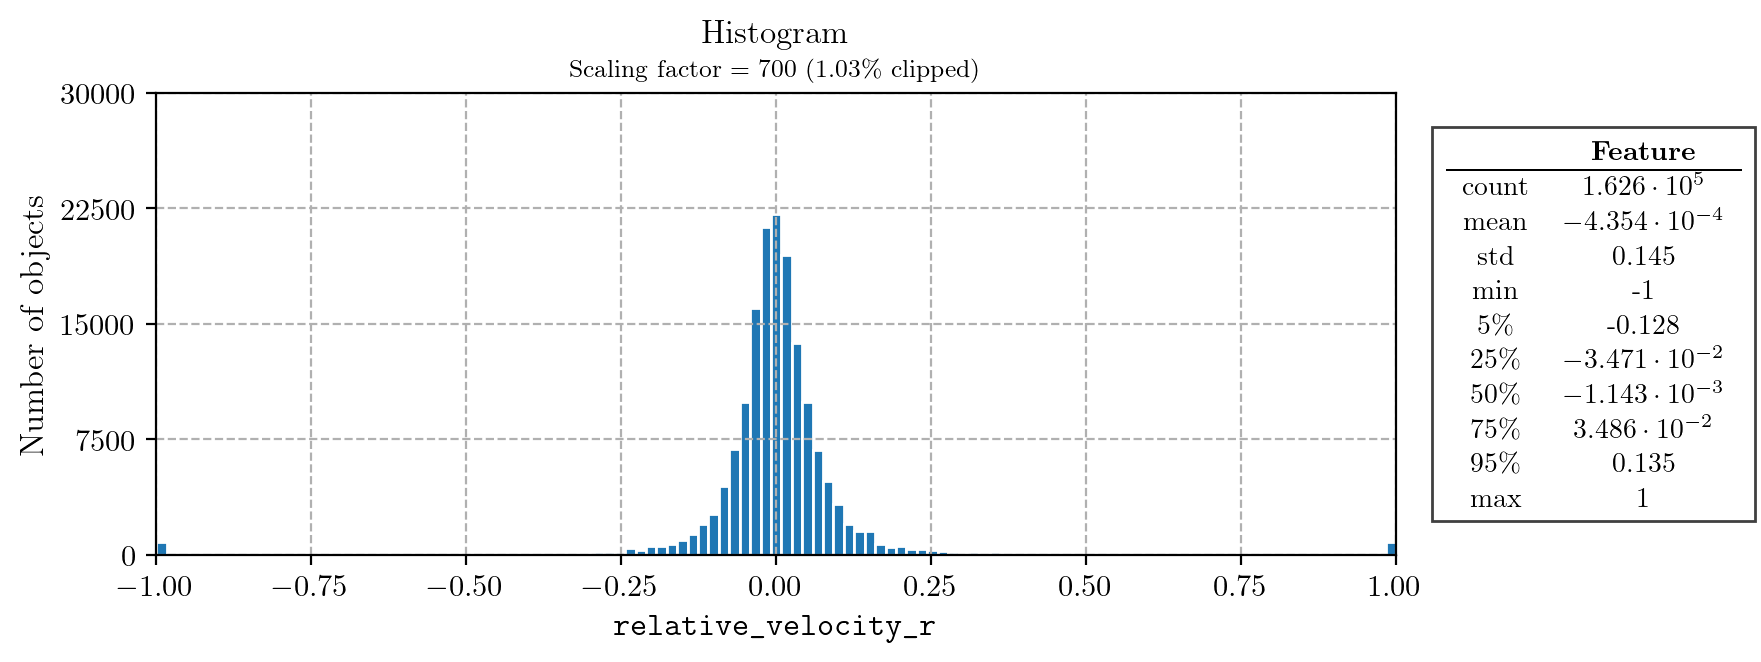

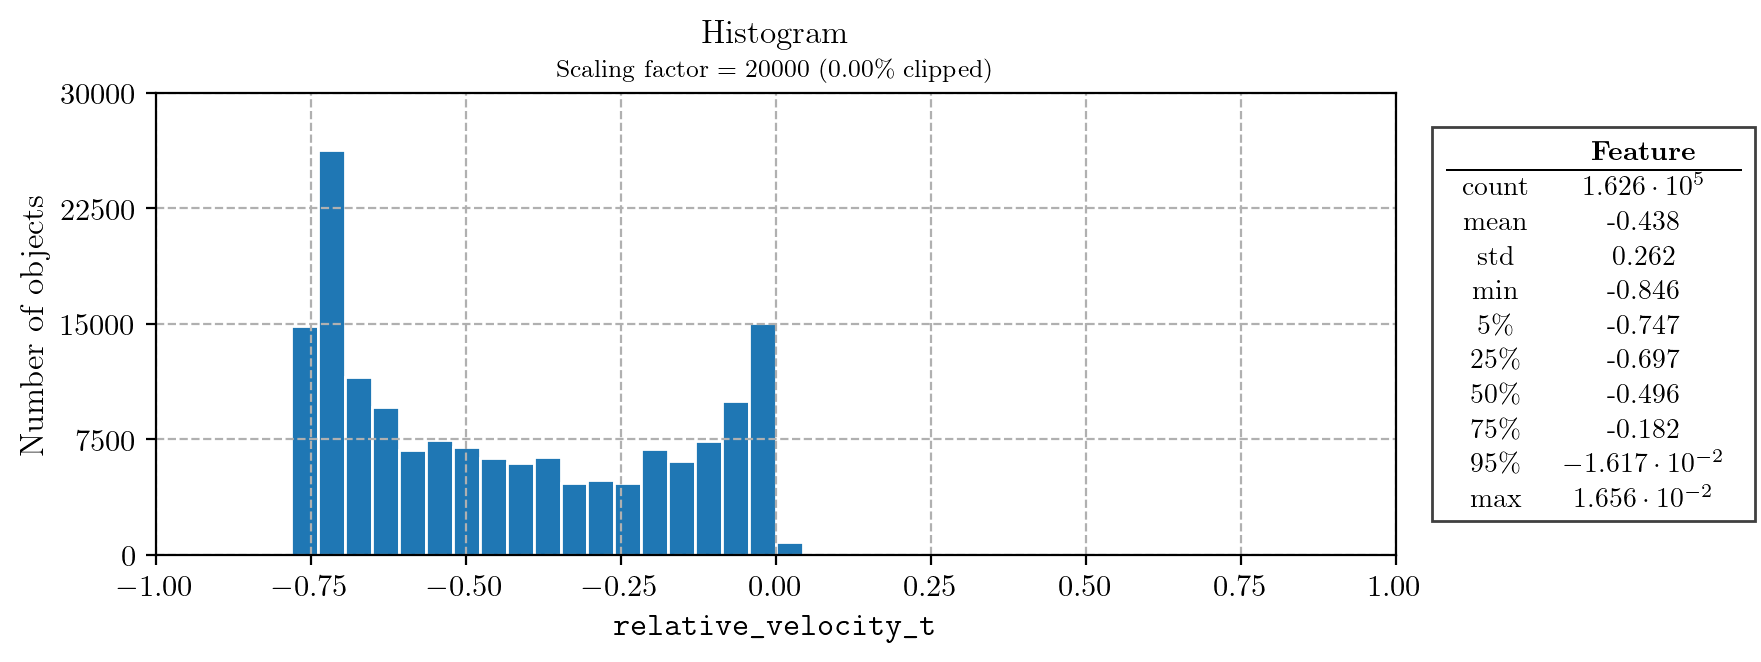

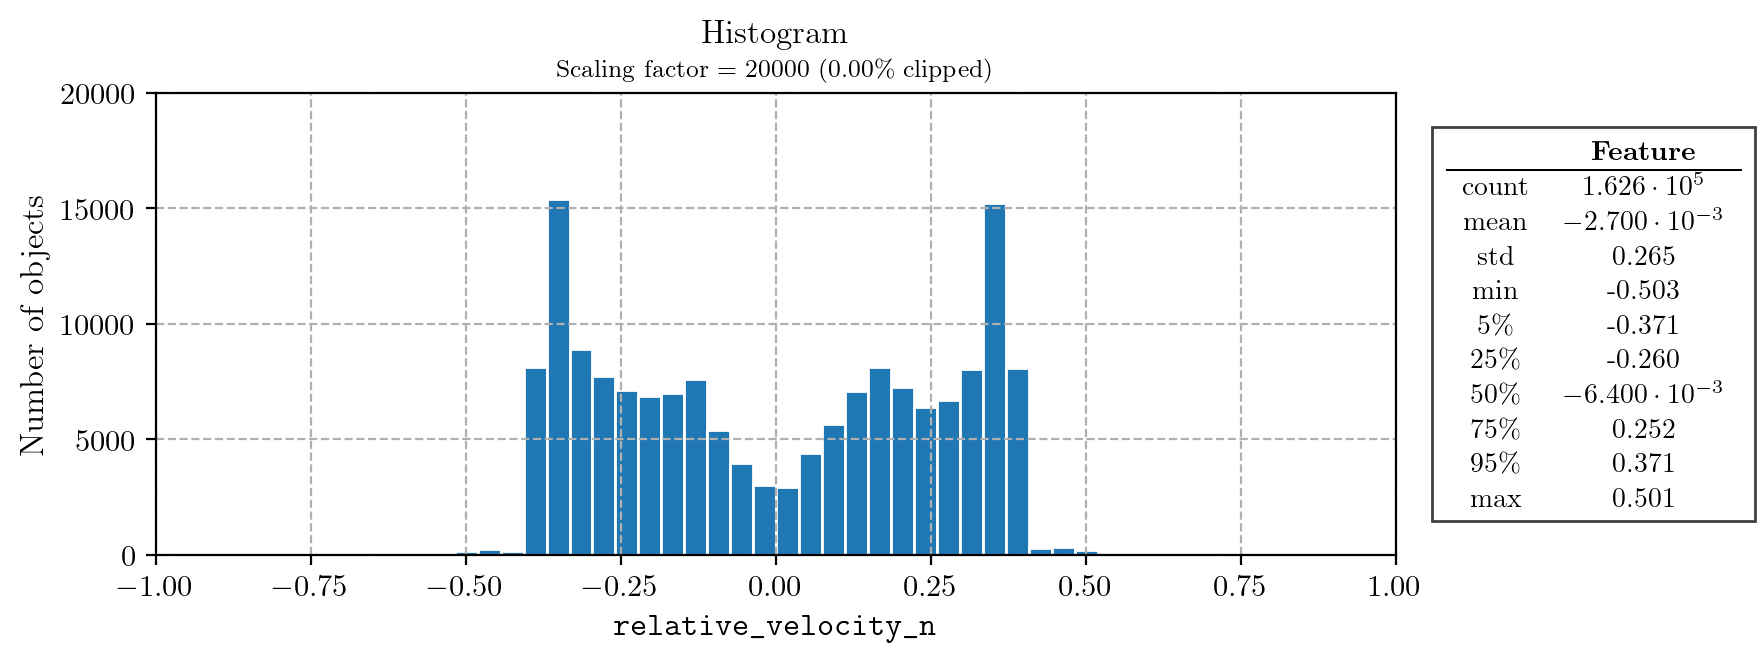

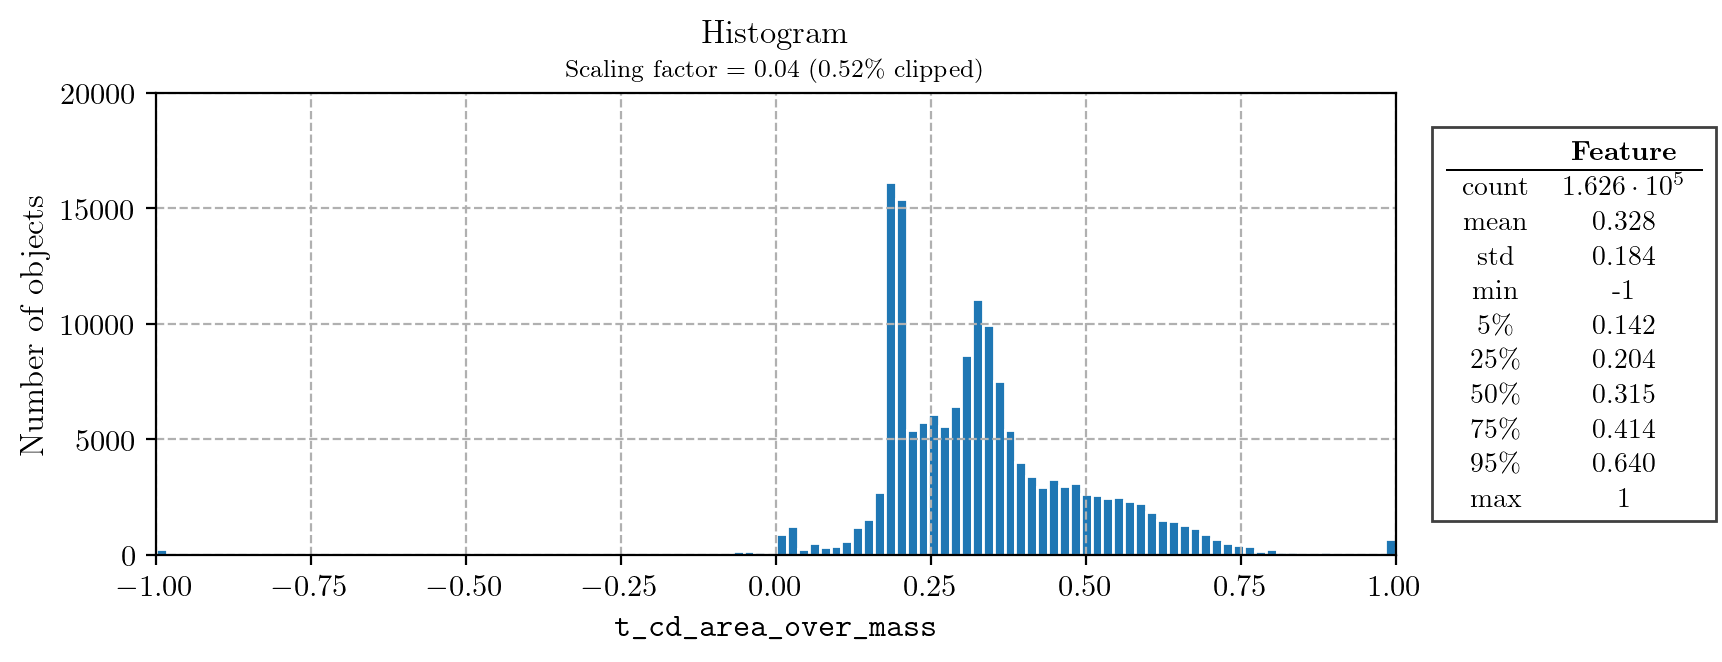

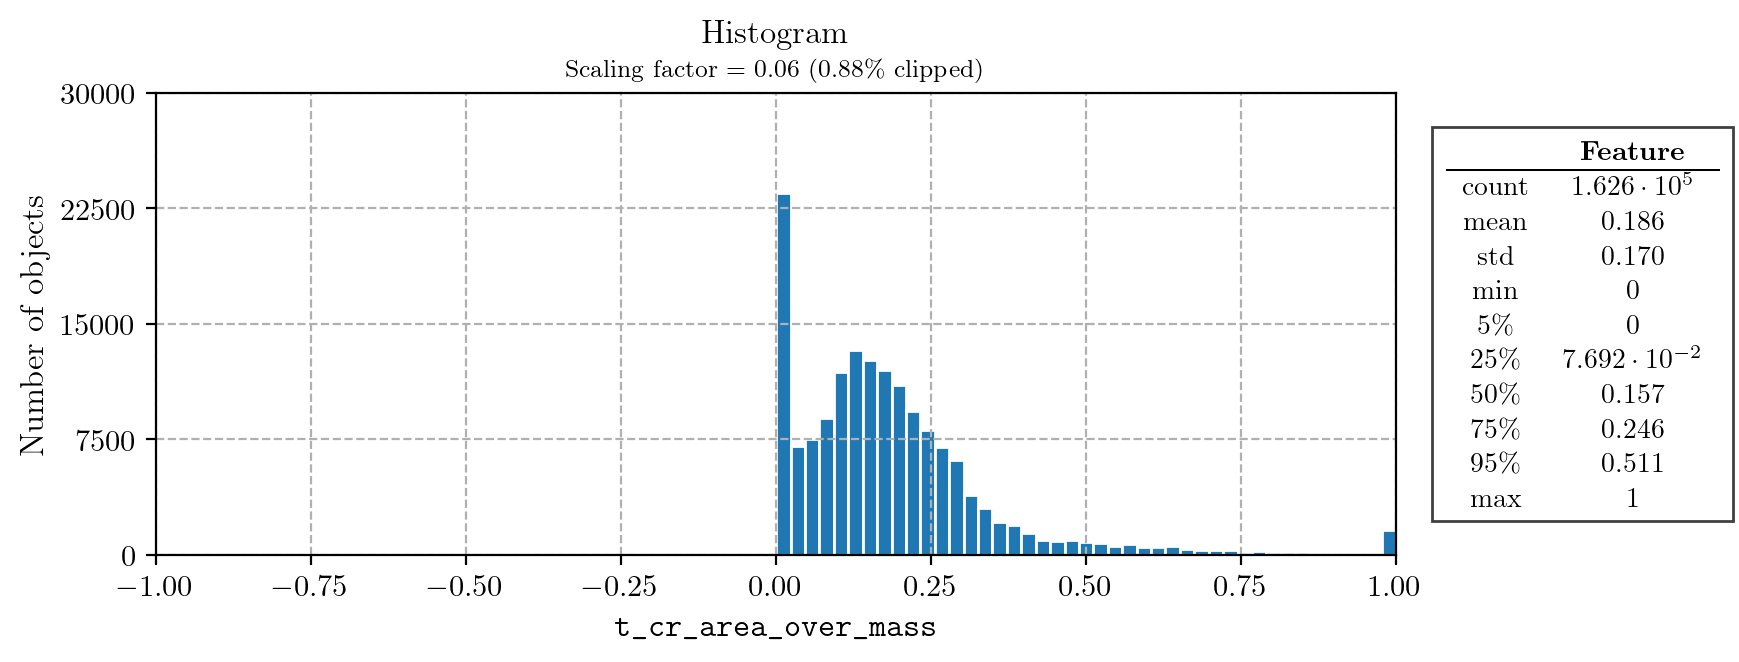

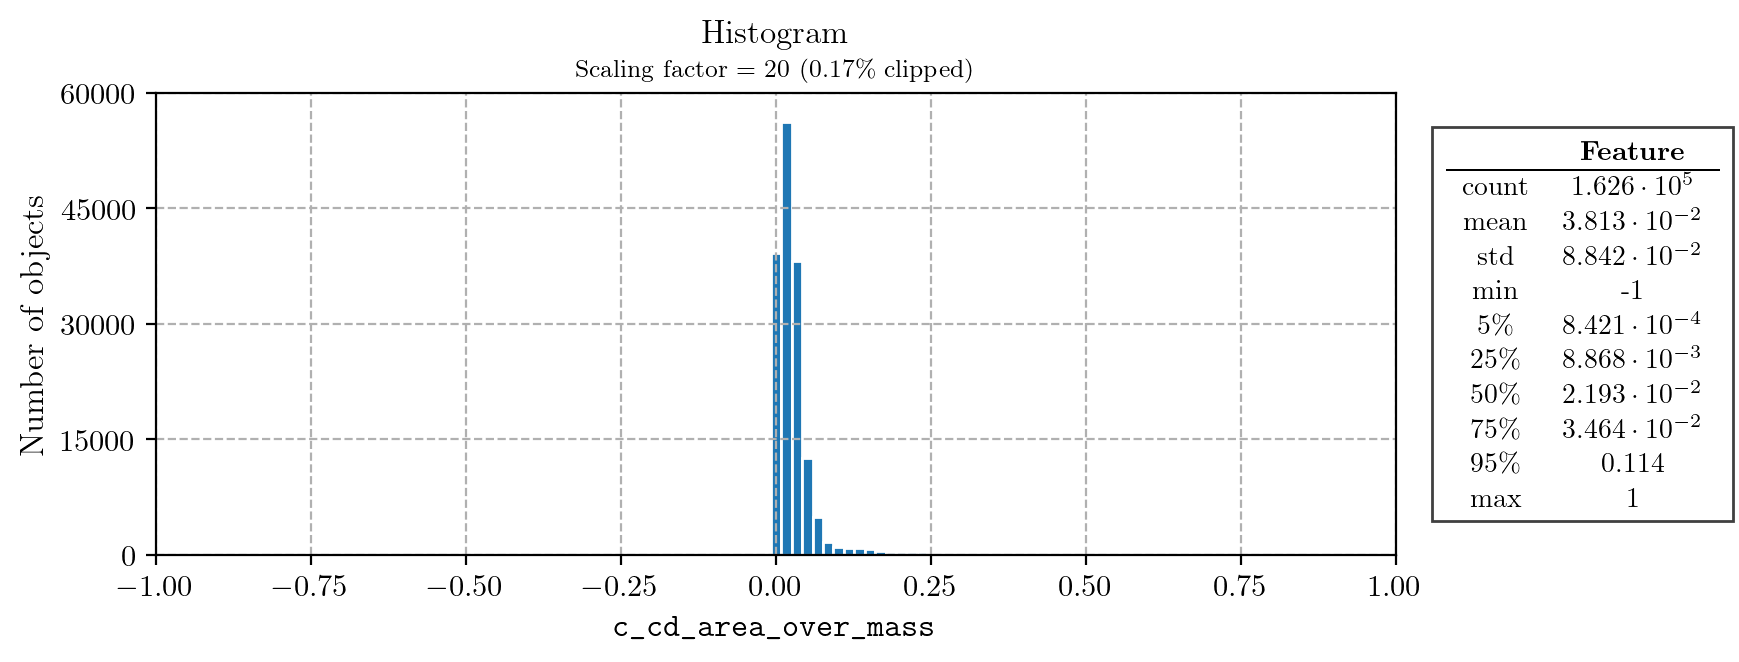

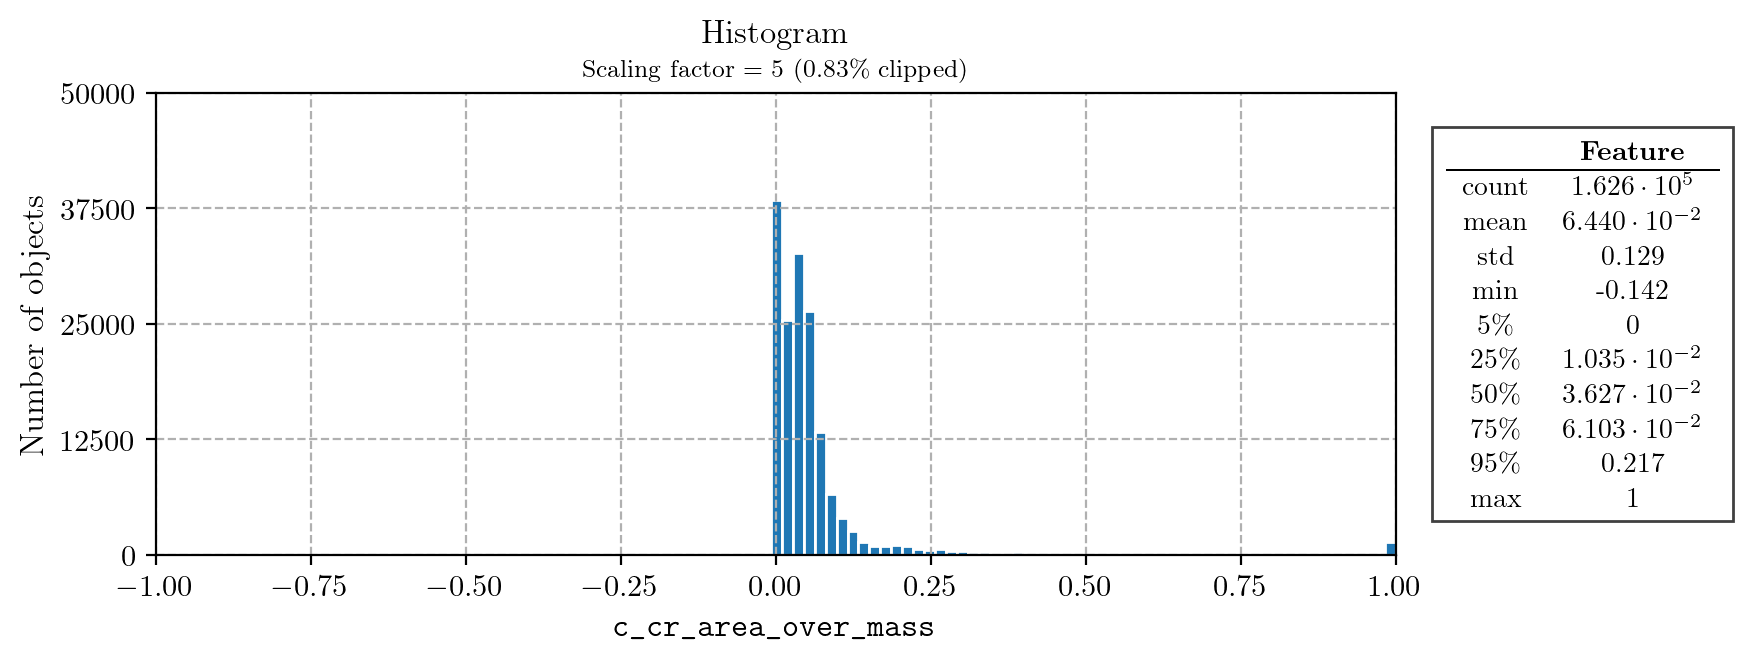

In [91]:
def RobustScalerClipper(data:np.ndarray, quantiles:tuple=(0.01, 0.99), clip_lims:tuple=(-1.0, 1.0)):

    scale = utils.round_by_om(np.quantile(data, 0.99)-np.quantile(data, 0.01))
    outliers = np.sum(data/scale>1.0) + np.sum(data/scale<-1.0)
    normalized_data = np.clip(data/scale, a_min=clip_lims[0], a_max=clip_lims[1])

    return {'data':normalized_data, 'scale':scale, 'outliers':outliers}

# Plot data distribution for the variance from the state vector covariance matrix (main diagonal)
features = list(config.get_features(**{'cluster':'conjunction'}).keys()) + \
           list(config.get_features(**{'cluster':'relative_state'}).keys()) + \
           list(config.get_features(**{'cluster':'coefficients'}).keys())
           
for feature in features:

    if df[feature].dtype.name=='category': continue

    normalization = RobustScalerClipper(df[feature].dropna().to_numpy())
    dft[feature] = normalization['data']

    # Plot Target and Chaser histograms
    kwargs = {'xlim': (-1.0, 1.0), 'legend':False,
            'title': f'Histogram\n \small Scaling factor = {normalization["scale"]} ({normalization["outliers"]/len(df)*100:.2f}\% clipped)',
              'xlabel': r'$\texttt{' + feature + r'}$', 'describe_colnames':[r'Feature']}

    eda.plot_histogram(dft, [feature], **kwargs)

['t_j2k_sma', 'c_j2k_sma']


/Users/jjrr/Documents/SCA-Project/Tool/notebooks/../library/irplib/eda.py:322: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(xlim)
/Users/jjrr/Documents/SCA-Project/Tool/notebooks/../library/irplib/utils.py:55: RuntimeWarning: invalid value encountered in double_scalars
  n_bins =  math.ceil((data.max() - data.min())/bins_width[rule])


ValueError: cannot convert float NaN to integer

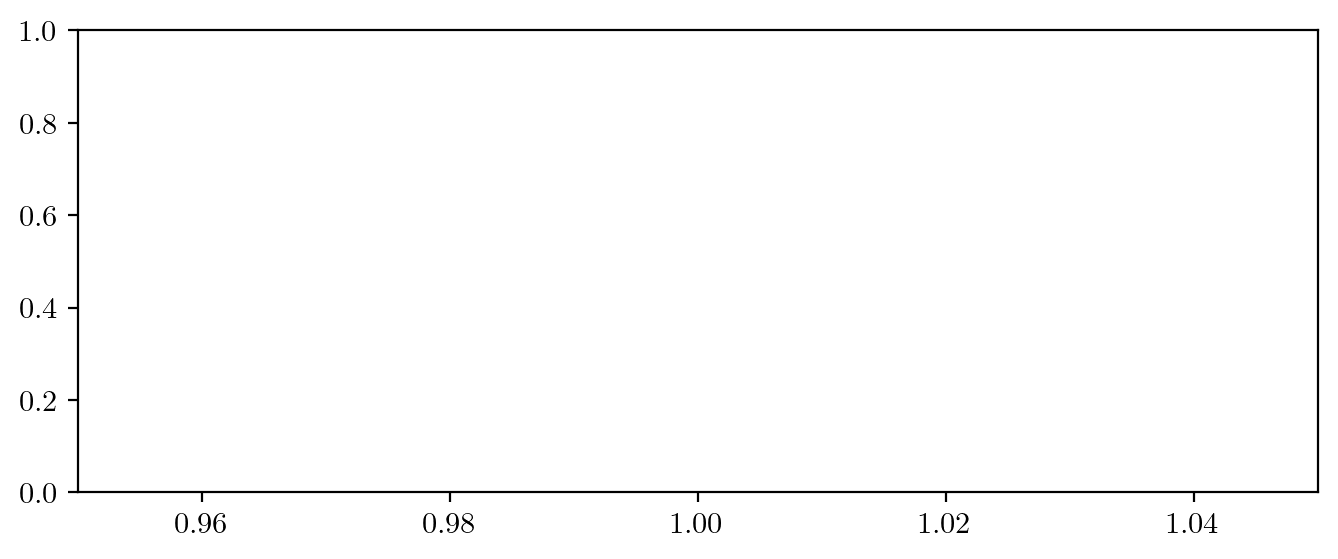

In [95]:
# Analyse the conjunction's data distributions
for feature in list(dict.fromkeys([f[2:] for f in list(config.get_features(**{'cluster':'orb_elements'}).keys())])):


    features = [o + feature for o in ['t_', 'c_']]
    print(features)

    if feature!='j2k_ecc':
        for f in features:
            normalization = RobustScalerClipper(df[f].dropna().to_numpy())
            dft[f] = normalization['data']
            dft_lastCDM  = dft.drop_duplicates('event_id', keep='last')

    # Plot Target and Chaser histograms
    filepath = os.path.join(cwd,'notebooks','images','histograms', 'orb_elements-' + feature + '.pdf')
    kwargs = {'hist_kwargs': [dict(label=r'Target', color='tab:blue', alpha=0.6), dict(label=r'Chaser', color='tab:orange', alpha=0.6)],
              'xlabel': r'\texttt{' + feature + '}', 'describe_colnames':[r'Target', r'Chaser'], 'filepath':filepath}

    
    eda.plot_histogram(dft_lastCDM, features, **kwargs)

### 3.1. - Ballistic and Solar Radiation coefficients normalization using `RobustScaler()`

Clipping feature: cd_area_over_mass   	Range = [-0.627, 2.358]	Outliers clipped = 8219 (2.53%)

Feature: t_cd_area_over_mass 	Outliers =     0 (0.00%)
 - Above upper limit =     0 (0.00%)
 - Below lower limit =     0 (0.00%)

Feature: c_cd_area_over_mass 	Outliers =  8219 (5.05%)
 - Above upper limit =  7900 (4.86%)
 - Below lower limit =   319 (0.20%)



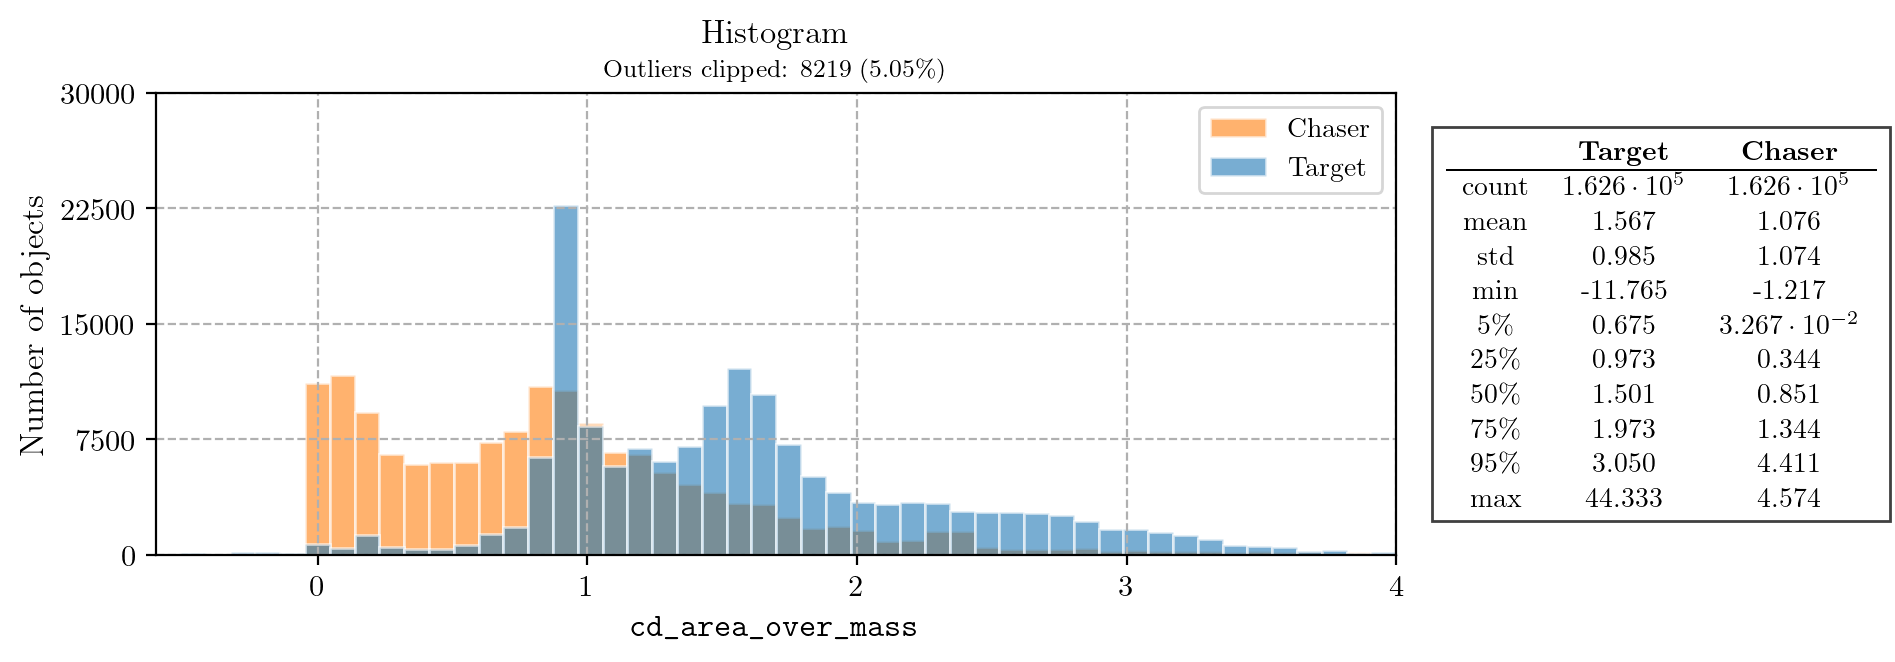

Clipping feature: cr_area_over_mass   	Range = [-0.255, 0.967]	Outliers clipped = 9715 (2.99%)

Feature: t_cr_area_over_mass 	Outliers =     0 (0.00%)
 - Above upper limit =     0 (0.00%)
 - Below lower limit =     0 (0.00%)

Feature: c_cr_area_over_mass 	Outliers =  9715 (5.97%)
 - Above upper limit =  9698 (5.96%)
 - Below lower limit =    17 (0.01%)



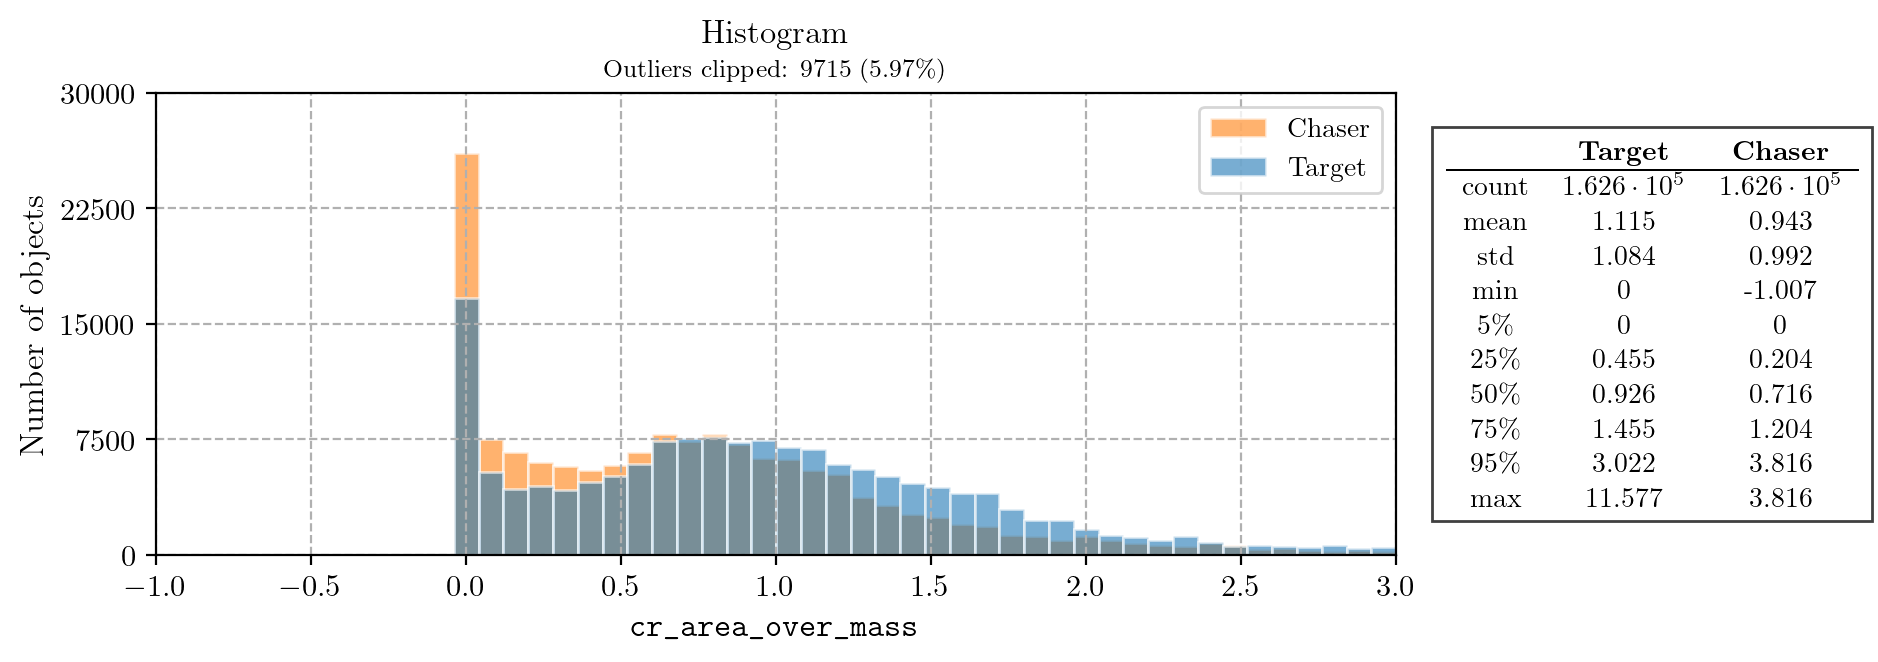

In [10]:
from sklearn.preprocessing import RobustScaler

for xfeature in features_groups['objects']['coefficients']:

    features = [o + xfeature for o in ['t_', 'c_']]

    # Get standard data limits and outliers.
    all_data = df[features].dropna().to_numpy().flatten()
    (a_min, a_max), std_data, outliers = utils.outliers_boundaries(all_data, threshold = (1.5, 4.5), positive_only = False)

    print(f'Clipping feature: {xfeature:20s}'
          f'\tRange = [{a_min:.3f}, {a_max:.3f}]'
            f'\tOutliers clipped = {len(outliers):4d} ({len(outliers)/len(all_data)*100.0:3.2f}%)\n')

    for f, feature in enumerate(features):

        data = df[feature].dropna().to_numpy()
        outliers_filter = (data>a_max) | (data<a_min)
    
        print(f'Feature: {feature:20s}'
              f'\tOutliers = {np.sum(outliers_filter):5d} ({np.sum(outliers_filter)/len(data)*100.0:3.2f}%)' 
              f'\n - Above upper limit = {np.sum(data>a_max):5d} ({np.sum(data>a_max)/len(data)*100.0:3.2f}%)' 
              f'\n - Below lower limit = {np.sum(data<a_min):5d} ({np.sum(data<a_min)/len(data)*100.0:3.2f}%)\n')


        # Plot Target and Chaser histograms
        kwargs = {'hist_kwargs': [[dict(label=r'Target', color='tab:blue'), 
                                  dict(label=r'Chaser', color='tab:orange')][f]]}

        # eda.plot_histogram(df_output, [feature], **kwargs)

        # Clip feature to remove effect from outliers on data distribution analysis
        dft[feature] = np.clip(data, a_min=a_min, a_max=a_max)

        # Fit RobustScaler() model to standardize data using the IQR range
        transformer = RobustScaler(with_centering=False).fit(dft[feature].to_numpy().reshape(-1,1))

        # Transform data into the standardize scale
        dft[feature] = transformer.transform(dft[feature].to_numpy().reshape(-1,1))


    kwargs = {'hist_kwargs': [dict(label=r'Target', color='tab:blue',   alpha=0.6), 
                              dict(label=r'Chaser', color='tab:orange', alpha=0.6)],
              'title': f'Histogram \n\small Outliers clipped: {len(outliers)} ({len(outliers)/len(data)*100:.2f}\%)',
              'xlabel': r'\texttt{' + xfeature + r'}',
              'describe_colnames':[r'Target', r'Chaser'], 'bins':50}

    eda.plot_histogram(dft, features, **kwargs)

### 3.2. - State vector covariance matrix: main diagonal normalization using `log` scaling and `clipping`

The normalization for the main diagonal of the covariance matrix is performed using the following steps:

1. Apply natural $\log$ to the initial values.
2. Clip log values between -16.0 and 16.0.
3. Normalize values to be between -1.0 and 1.0 by using the width of the clipping range (-16.0, 16.0).

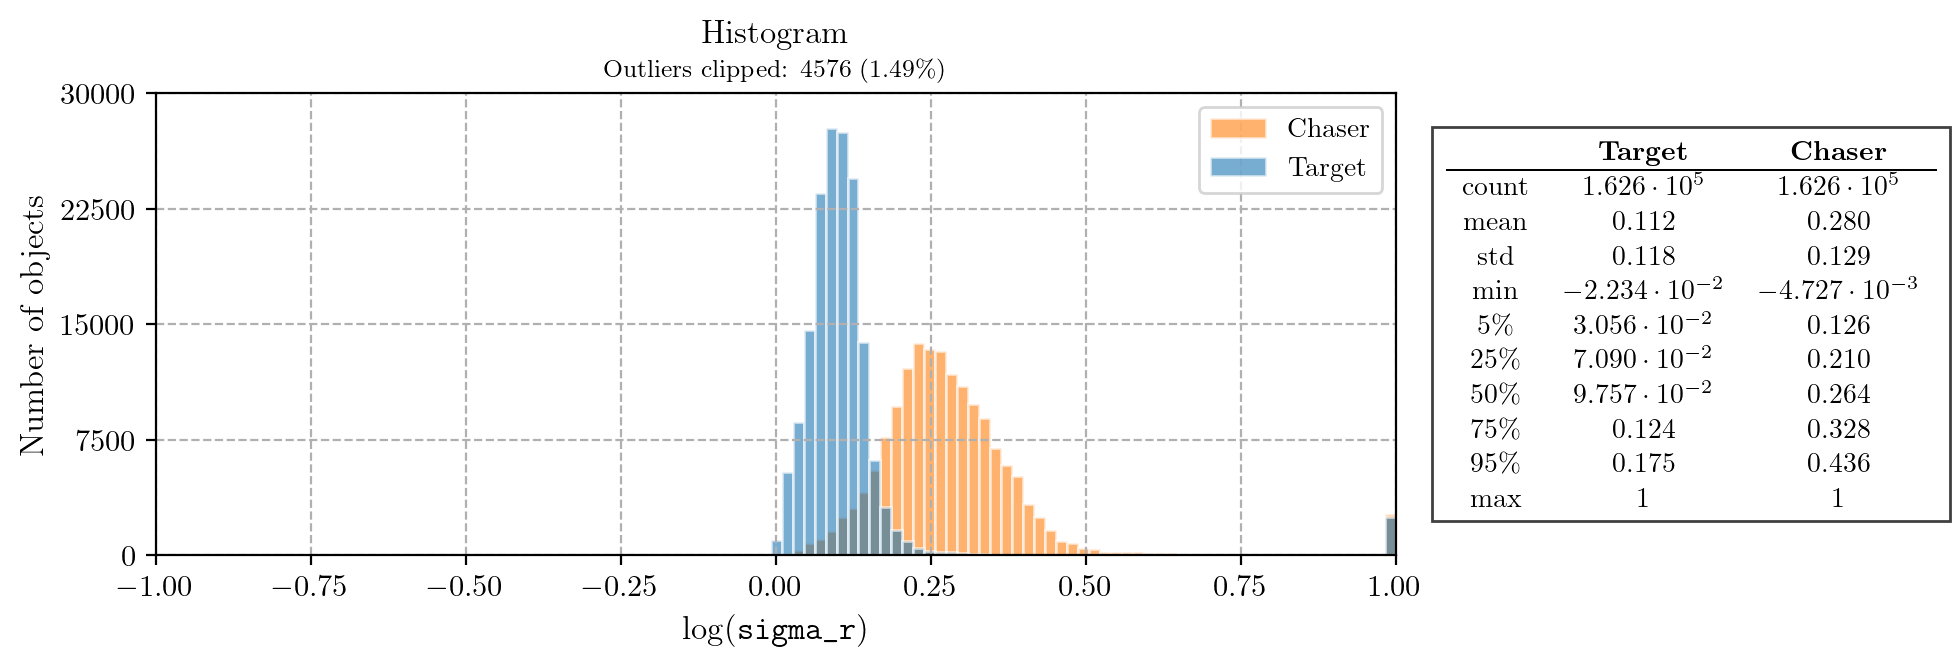

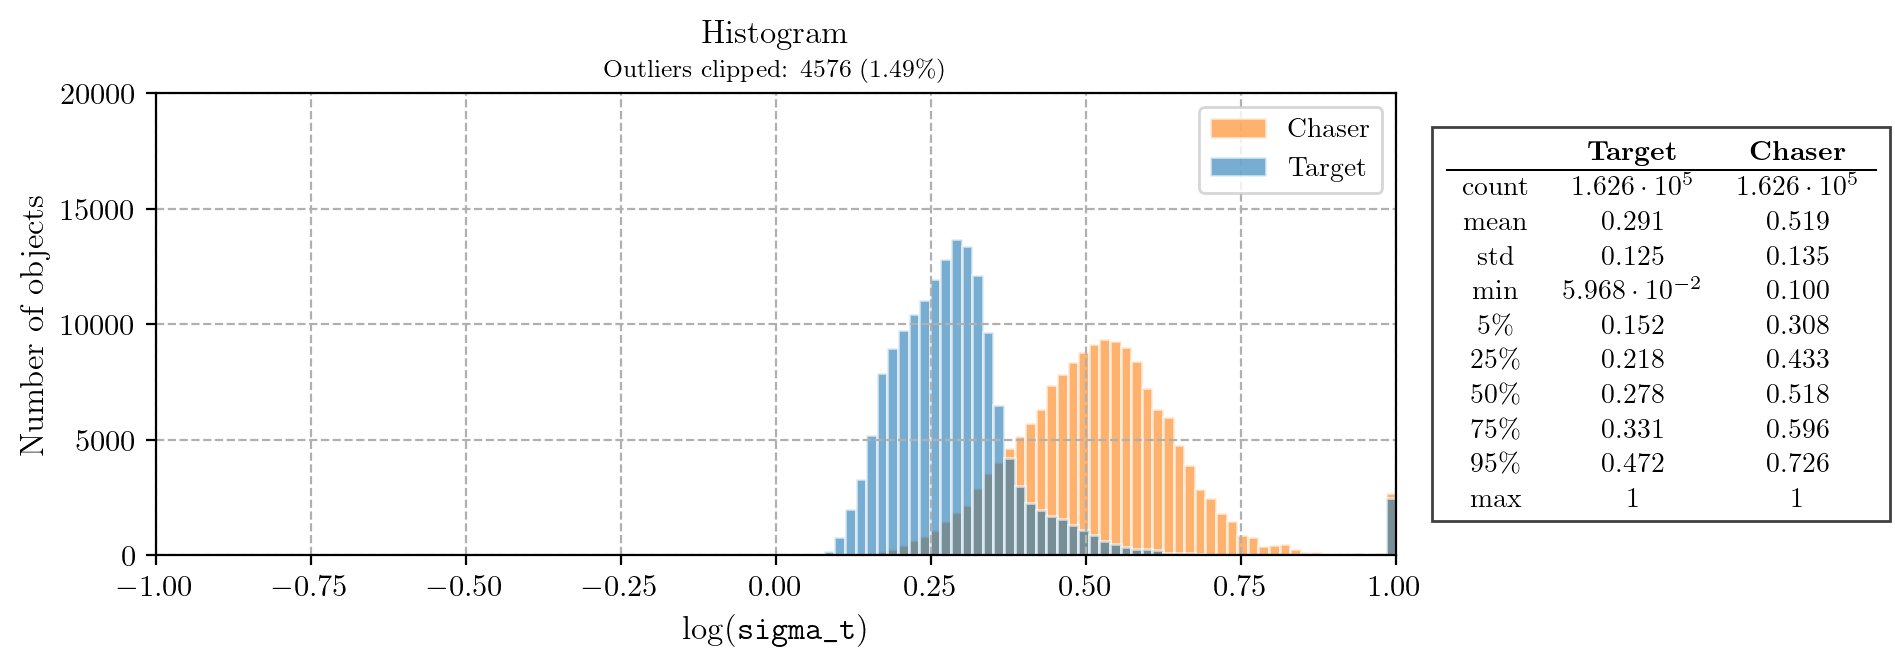

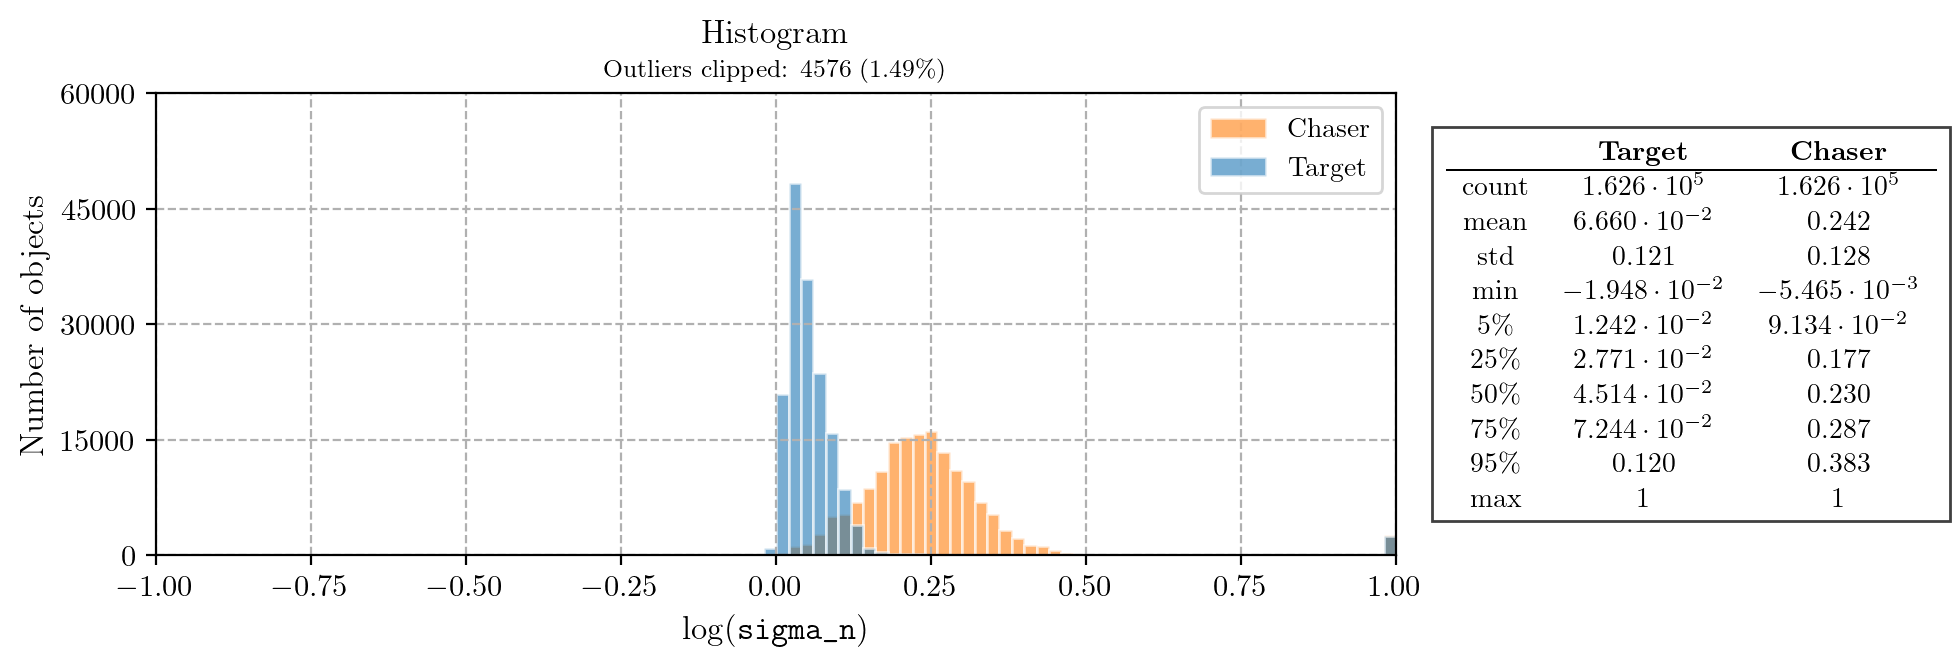

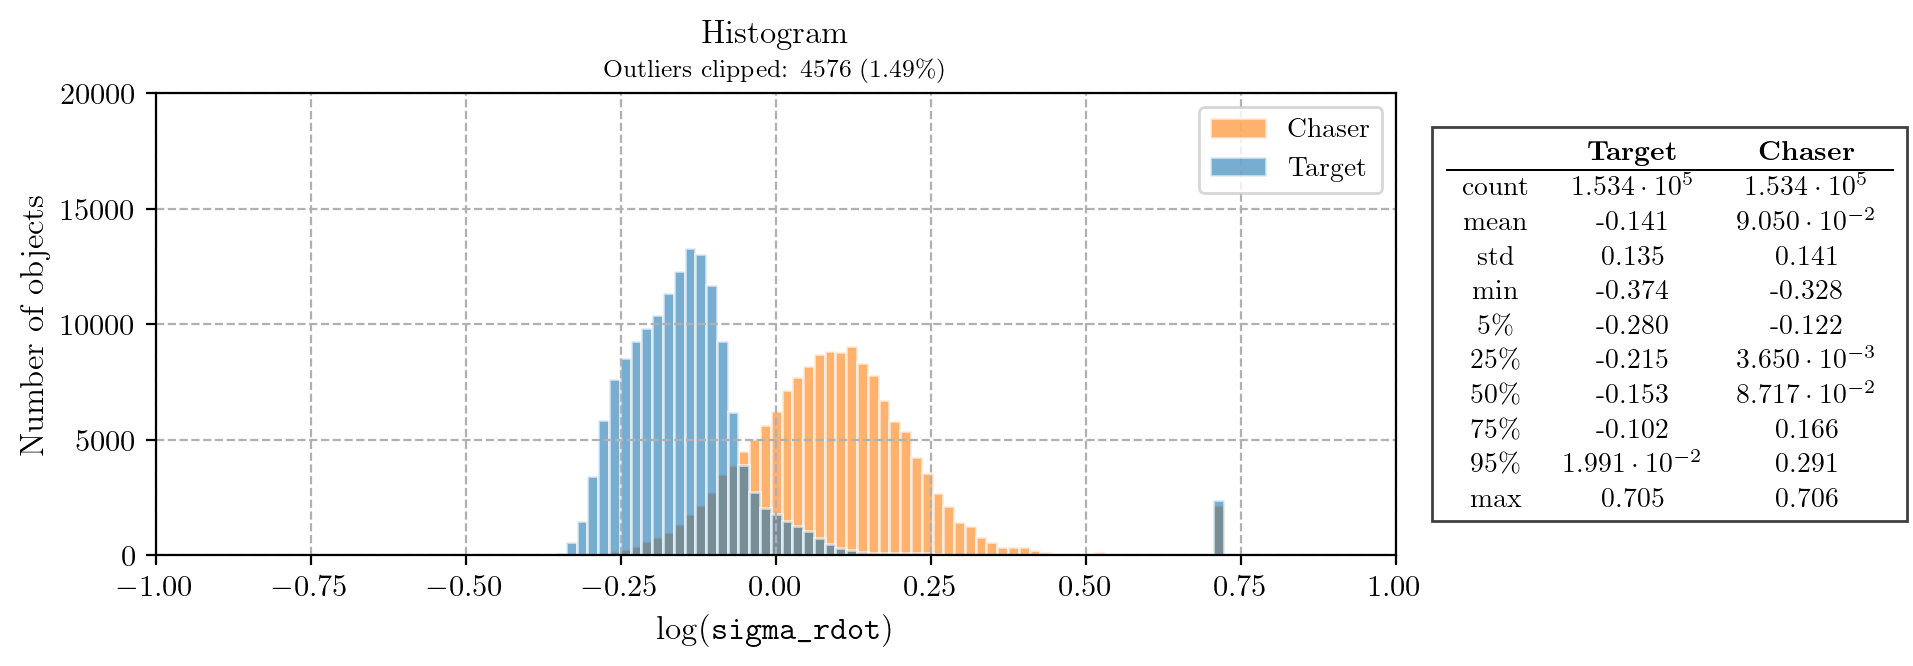

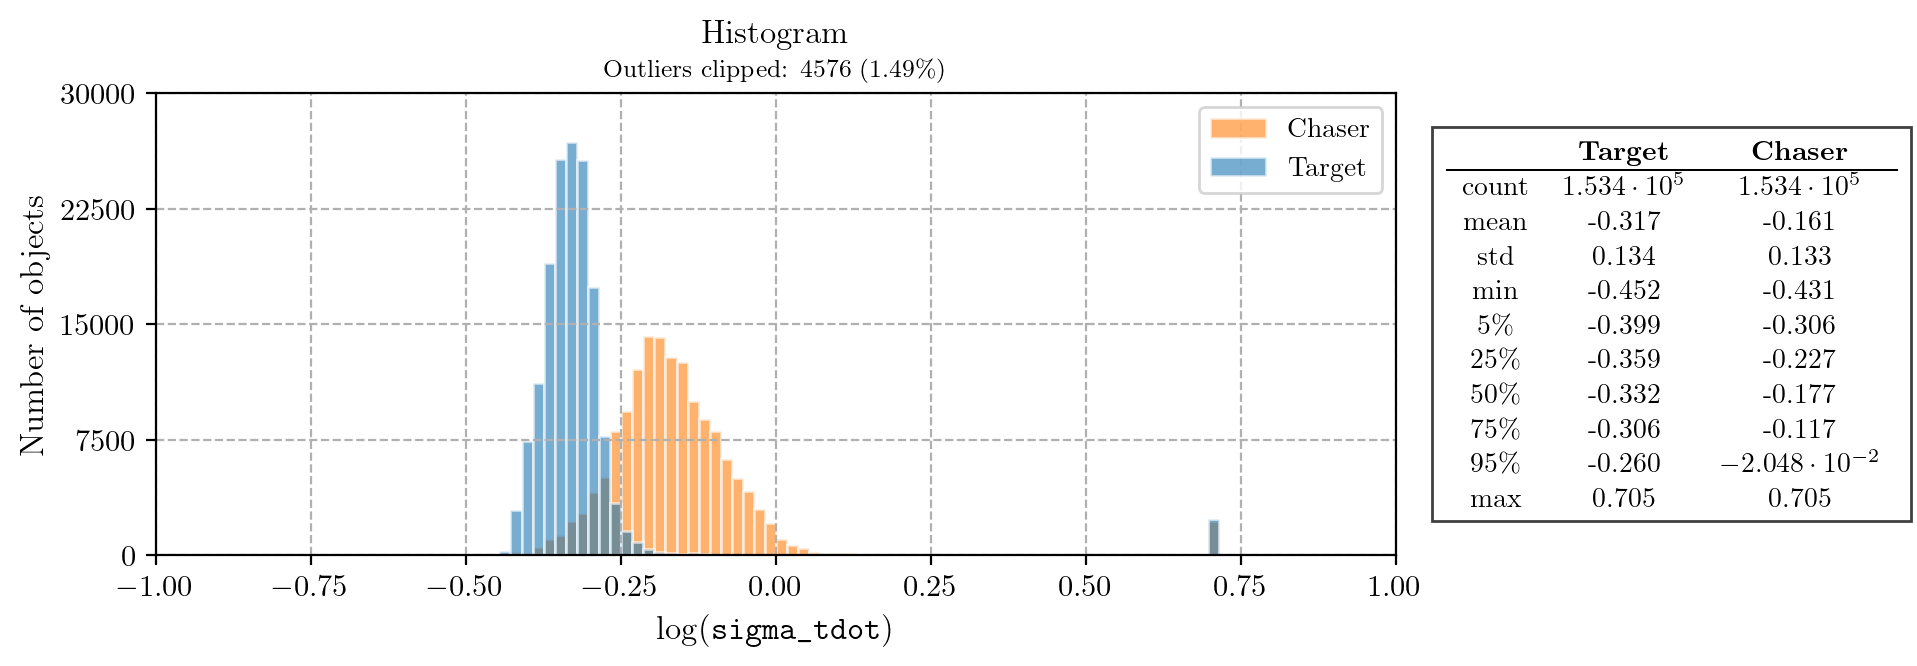

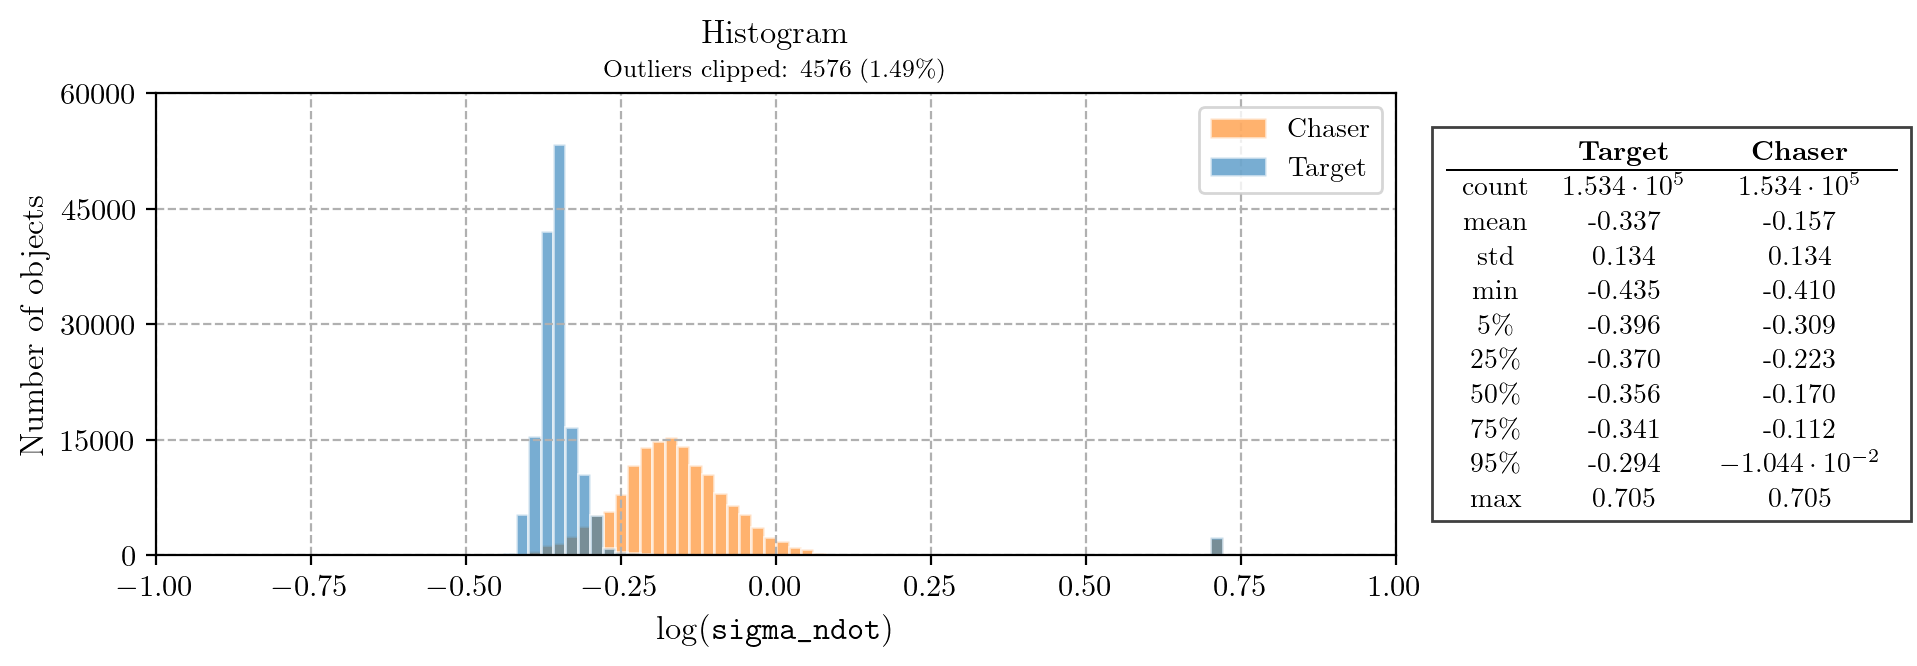

In [24]:
# Plot data distribution for the variance from the state vector covariance matrix (main diagonal)
for xfeature in [f for f in features_groups['objects']['covariance'] if f.find('sigma')>=0]:

    # Get features names for both objects
    features = [o + xfeature for o in ['t_', 'c_']]

    # Normalize values using log.
    dft[features] = np.log(df[features])

    clip_lims = (-16.0, 16.0)

    # Clip values between -16.0 and 16.0
    for feature in features:
        dft[feature] = np.clip(dft[feature], a_min = clip_lims[0], a_max = clip_lims[1])/((clip_lims[1]-clip_lims[0])/2.0)

    # Plot Target and Chaser histograms
    kwargs = {'hist_kwargs': [dict(label=r'Target', color='tab:blue',   alpha=0.6), 
                              dict(label=r'Chaser', color='tab:orange', alpha=0.6)],
              'xlim': (-1.0,1.0), 
              'title': f'Histogram \n\small Outliers clipped: {len(outliers)} ({len(outliers)/len(data)*100:.2f}\%)',
              'xlabel': r'$\log(\texttt{' + xfeature + r'})$', 'describe_colnames':[r'Target', r'Chaser']}

    eda.plot_histogram(dft, features, **kwargs)

### 3.3. - Miscellaneous data: determinant of the position vector covariance matrix and energy dissipation rate

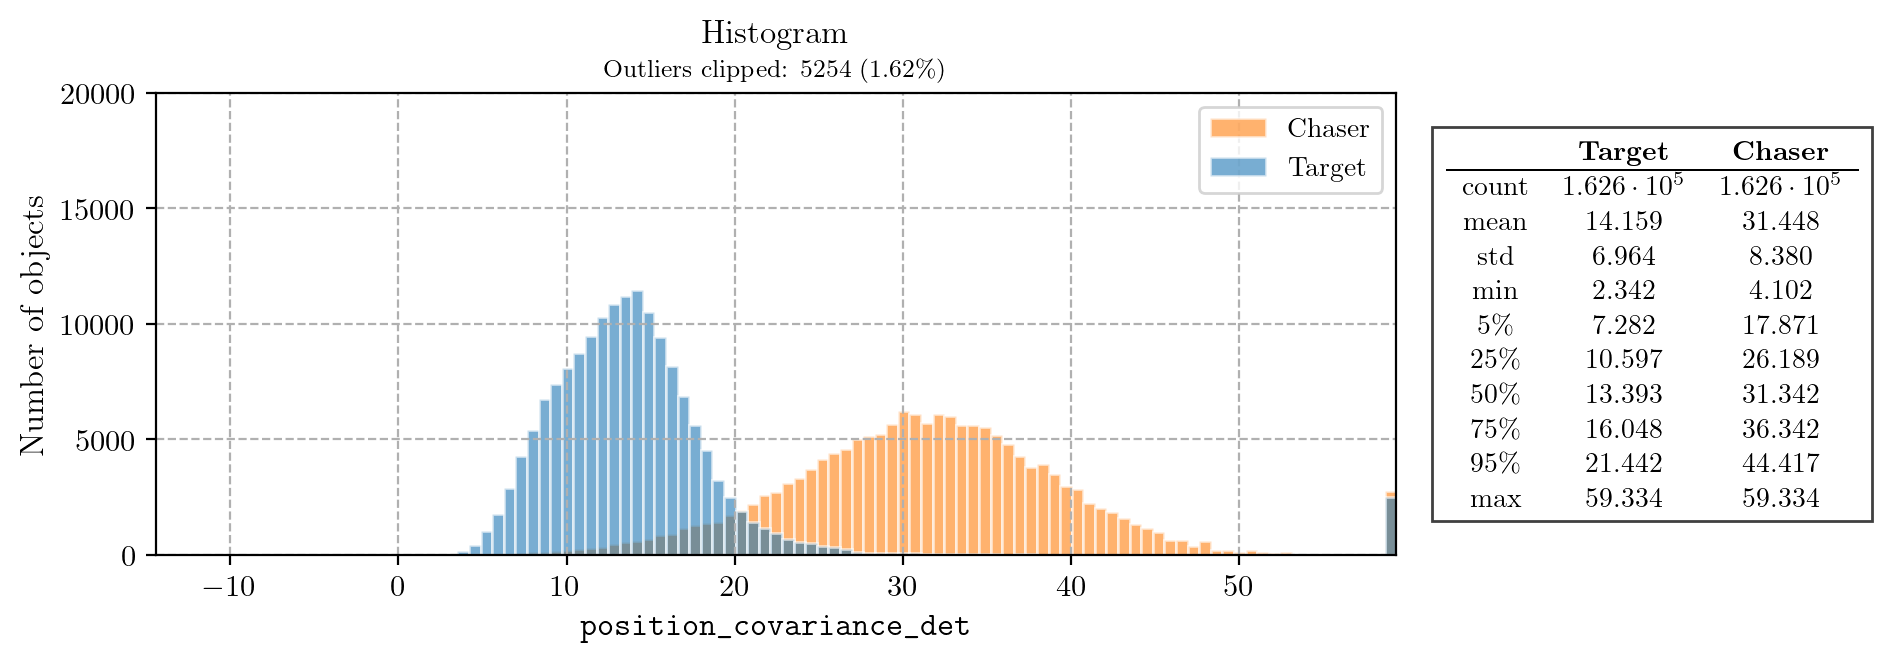

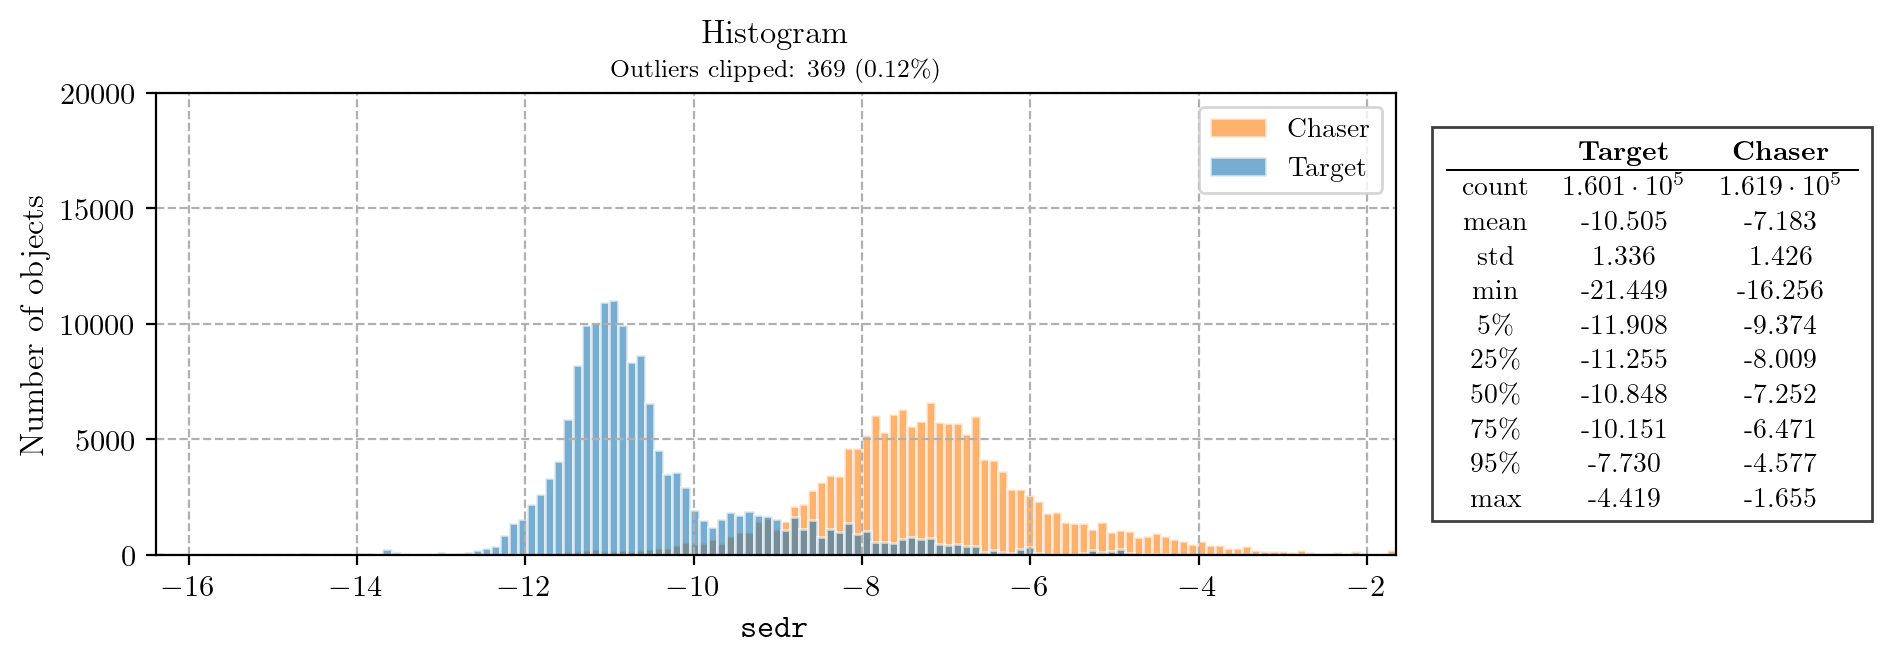

In [12]:
# Plot data distribution for the variance from the state vector covariance matrix (main diagonal)
for xfeature in ['position_covariance_det', 'sedr']:

    # Get features names for both objects
    features = [o + xfeature for o in ['t_', 'c_']]

    # Create a deep copy of the columns from the original dataset.
    dft.loc[:,features] = df[features].copy(deep=True)

    # Set values from determinant lower or equal to 0 as nan.
    for feature in features: dft.loc[df[feature]<=0, feature] = np.nan
        
    # Normalize values using log.
    dft[features] = np.log(dft[features])

    # Clip extreme values using the IQR range over the transformed data.
    data = dft[features].dropna().to_numpy().flatten()
    std_lims, std_data, outliers = utils.outliers_boundaries(data, threshold = 1.5, positive_only=False)

    # Clip outliers setting an upper limit
    for feature in features: dft[feature] = np.clip(dft[feature], a_min = None, a_max = std_lims[1])

    # Plot Target and Chaser histograms
    kwargs = {'hist_kwargs': [dict(label=r'Target', color='tab:blue',   alpha=0.6), 
                            dict(label=r'Chaser', color='tab:orange', alpha=0.6)],
                'xlim': std_lims, 'title': f'Histogram \n\small Outliers clipped: {len(outliers)} ({len(outliers)/len(data)*100:.2f}\%)',
                'xlabel': r'\texttt{' + xfeature + '}', 'describe_colnames':[r'Target', r'Chaser']}

    eda.plot_histogram(dft, features, **kwargs)

## 4. - Transformed training data export

In [29]:
# Sort values of dataframe by event_id and time_to_tca and re-index
dft.sort_values(by=['event_id', 'time_to_tca'], axis='index', 
               ascending=[True,False], inplace=True, ignore_index=True)

# Save transformed training dataset
dft.to_csv(path_or_buf=os.path.join(cwd,'data','esa-challenge','train_data_transformed.csv'), sep=',', header=True, index=False, decimal='.')

# Show first data points to explore data types
display(dft.head(10))

event_id  time_to_tca mission_id       risk  max_risk_estimate  \
0        0     1.566798          5 -10.204955          -7.834756   
1        0     1.207494          5 -10.355758          -7.848937   
2        0     0.952193          5 -10.345631          -7.847406   
3        0     0.579669          5 -10.337809          -7.845880   
4        0     0.257806          5 -10.391260          -7.852942   
5        1     6.530455          5  -7.561299          -7.254301   
6        1     5.561646          5  -9.315693          -7.468904   
7        1     5.226504          5  -7.422508          -7.051001   
8        1     3.570013          5  -9.248105          -7.327533   
9        2     6.983474          2 -10.816161          -6.601713   

   max_risk_scaling  miss_distance  relative_speed  relative_position_r  \
0          8.602101        14923.0         13792.0                453.8   
1          8.956374        14544.0         13792.0                474.3   
2          8.932195        14475.0         13792.0                474.6   
3          8.913444        14579.0         13792.0                472.7   
4          9.036838        14510.0         13792.0                478.7   
5          2.746782         2392.0          3434.0                 74.3   
6          7.223137         3587.0          3434.0                 99.0   
7          2.956639         7882.0          3434.0                -50.0   
8          7.425994        26899.0          3434.0                -82.0   
9         13.293159        22902.0         14348.0              -1157.6   

   relative_position_t  relative_position_n  relative_velocity_r  \
0               5976.6             -13666.8                 -7.2   
1               5821.2             -13319.8                 -7.0   
2               5796.2             -13256.1                 -7.0   
3               5838.9             -13350.7                 -7.0   
4               5811.1             -13288.0                 -7.0   
5               2317.1               -589.4                 25.9   
6               3475.4               -885.1                 24.7   
7              -7638.3               1945.7                 36.8   
8             -26067.0               6638.2                 56.8   
9              -6306.2              21986.3                 15.8   

   relative_velocity_t  relative_velocity_n t_time_lastob_start  \
0             -12637.0              -5525.9                 1.0   
1             -12637.0              -5525.9                 1.0   
2             -12637.0              -5525.9                 1.0   
3             -12637.0              -5525.9                 1.0   
4             -12637.0              -5525.9                 1.0   
5               -847.8              -3328.2                 1.0   
6               -847.8              -3328.2                 1.0   
7               -847.7              -3328.2                 1.0   
8               -847.8              -3328.2                 1.0   
9             -13792.0              -3957.1                 1.0   

  t_time_lastob_end  t_recommended_od_span  t_actual_od_span  t_obs_available  \
0               0.0                   3.78              3.78              459   
1               0.0                   3.79              3.79              456   
2               0.0                   3.79              3.80              456   
3               0.0                   3.86              3.86              443   
4               0.0                   3.86              3.86              440   
5               0.0                   4.06              4.06              432   
6               0.0                   3.91              3.91              449   
7               0.0                   3.99              3.99              434   
8               0.0                   4.04              4.04              430   
9               0.0                   3.92              3.92              444   

   t_obs_used  t_residuals_accepted  t_weighted_

## 5. -  Feature engineering towards Neural Networks processing

### 5.1. - Features segregation

As a first step towards the development of the deep learning model it is required to segregate the features using the following criteria:
 
 - **Output**: Target features that to be predicted by the neural network.
 - **Input**: Features that will feed the neural network. In turn, depending on how they behave throughout the conjunction event, these features shall be segregated into two groups:
    - **Constant**: Features whose values are fixed or roughly constant throughout the entire conjunction event (i.e. chaser object type, or orbital element features). These features do not need Time-Series forecasting processing. 
    - **Variable**: Features whose values change for every Conjunction Data Message received from a specific conjunction event (i.e. miss distance, relative position features). These features need to be forecasted into the feature.

Additionally, both constant and variable from input features groups can be either categorical or continuous. This segregation is also required for embedding processing in the deep learning model.

In [25]:
# Get list of event_ids
event_ids = dft['event_id'].cat.categories.values

# Initialize output features
out_features = ["risk", "max_risk_estimate"]

# Get input features
in_features = [f for f in dft.columns if not f in out_features and \
               not f in ['event_id', 'mission_id', 'max_risk_scaling']]


# Separate continuous features from categorial features for embedding processing of the later.
cat_features = [f for f in in_features if dft[f].dtype=='category']
cont_features = [f for f in in_features if not f in cat_features]


### 5.2. - Feature variability analysis per event

In order to segregate fixed or roughly constant features in the event, an analysis of the variability per event shall be performed for every feature. A feature is considered to be constant if (1) the standard deviation for all the values in a given event is 0 or 2 orders of magnitude smaller than the mean and (2) criteria (1) happens in more than 90% of all events.

In [26]:
# Compute standard deviation, and mean of every feature per event_id.
events_std    = dft[['event_id'] + cont_features].groupby(['event_id']).std()
events_mean   = dft[['event_id'] + cont_features].groupby(['event_id']).mean()

# Evaluate variability of feature per event_id using the order of magnitude
events_var = pd.DataFrame(index=event_ids, columns=cont_features)

for feature in cont_features: 
    events_var[feature] = (events_mean[feature]/events_std[feature]).apply(lambda x: utils.om(x))

# Initialize and print criteria used to class features as globally constant or variable
om_criteria = 2
p_criteria = 0.1

print(f'Criteria for which a feature is considered CONSTANT:\n'
      f' (1.) - Locally (for a given event): if its mean is {om_criteria} orders of magnitude bigger than its standard deviation, or its standard deviation is 0.\n'
      f' (2.) - Globally (for the entire dataset): if criteria (1.) is met in more than {p_criteria*100:2.0f}% of the total number of events.\n')

# Get array of continuous features that are constant and variables
var_features   = [f for f in cont_features if np.sum(events_var[f]<om_criteria)/len(events_var)>p_criteria]
cons_features  = [f for f in cont_features if f not in var_features]

# Print results of analysis
print(f'Constant features: {len(cons_features)}')
results = [f'({np.sum(events_var[f]>=om_criteria)/len(events_var)*100:4.1f}%) {f}' for f in cons_features]
print(utils.tabular_list(results, n_cols = 4, col_sep=' - ', max_len=30))

print(f'\nVariable features: {len(var_features)}')
results = [f'({np.sum(events_var[f]<om_criteria)/len(events_var)*100:4.1f}%) {f}' for f in var_features]
print(utils.tabular_list(results, n_cols = 4, col_sep=' - ', max_len=30))

Criteria for which a feature is considered CONSTANT:
 (1.) - Locally (for a given event): if its mean is 2 orders of magnitude bigger than its standard deviation, or its standard deviation is 0.
 (2.) - Globally (for the entire dataset): if criteria (1.) is met in more than 10% of the total number of events.

Constant features: 19
 - (98.2%) relative_speed            	 - (98.3%) c_j2k_sma                 	 - (98.3%) c_h_apo                   	
 - (97.5%) relative_velocity_t       	 - (90.1%) c_j2k_ecc                 	 - (98.3%) c_h_per                   	
 - (98.3%) relative_velocity_n       	 - (98.3%) c_j2k_inc                 	 - (96.0%) geocentric_latitude       	
 - (94.1%) t_rcs_estimate            	 - (98.3%) t_span                    	 - (98.3%) azimuth                   	
 - (98.3%) t_j2k_sma                 	 - (98.3%) c_span                    	 - (92.6%) F3M                       	
 - (96.6%) t_j2k_ecc                 	 - (98.3%) t_h_apo                   	
 - (98.3%) t_j2

### 5.3. - Multiconilearity analysis using the *Variance Inflation Factor* (VIF)

Once the different clusters of CDM features have been seggregated and identified, it is important to analyse the multicollinearity that underlies the dataset as it can raise the variance of coefficient estimates, leading to larger confidence intervals (greater uncertainty). To summarise, even though multicollinearity may not interfere with model performance, it does negatively impact the interpretation of the predictors used to build the model.

In order to detect all features in the dataset that are multicollinear, the Variance Inflation Factor is used. The Variance Inflation Factor (VIF) directly measures the ratio of the variance of the entire model to the variance of a model with only the feature in question. The mathematical expression is the following:

$$VIF = \frac{1}{1-R^{2}}$$

where $R^{2}$ is the coefficient of determination, a measure of the variation in the dependent variable that is predictable from the independent variable(s). A VIF of $1$ ($R^{2}=0$) indicates that the feature has no correlation with any of the other features. Typically, any feature with a VIF value exceeding $5$ ($R^{2} \geq 0.8$) is considered to be too high; that is, it is very likely contributing to multicollinearity.

In the code-block below two functions are developed to compute VIF and to use this factor to remove features with multicollinearity according to a given threshold.

#### 5.3.1. - Constant features

In [27]:
# Set maximum variance inflation factor identify collinear features
maxvif = 5

# Get only the last CDM from every event for faster multicollinearity analysis.
dft_lastCDM = dft[['event_id'] + cons_features].drop_duplicates('event_id', keep='last')

# Analyse multicollinearity between constant features
collinearity = utils.vif_selection(dft_lastCDM, maxvif = maxvif)

print(f'Multicollinearity analysis for CONSTANT features.\n\n'
      f'Criteria -> Feature is independent if R2 < {1-1/maxvif:4.2f}, correlated otherwise')

for c in ['correlated', 'independent']:
    col_features = list(collinearity[c].keys())
    col_features.sort()
    print(f'\n{c.capitalize()} features: {len(col_features)} ')
    print(utils.tabular_list(col_features, n_cols = 2, col_sep=' - ', max_len=30))

ind_cons_features = list(collinearity['independent'].keys())

Multicollinearity analysis for CONSTANT features.

Criteria -> Feature is independent if R2 < 0.80, correlated otherwise

Correlated features: 6 
 - c_h_apo                           	 - relative_speed                    	
 - c_h_per                           	 - t_h_per                           	
 - c_j2k_ecc                         	 - t_j2k_sma                         	


Independent features: 13 
 - F3M                               	 - relative_velocity_t               	
 - azimuth                           	 - t_h_apo                           	
 - c_j2k_inc                         	 - t_j2k_ecc                         	
 - c_j2k_sma                         	 - t_j2k_inc                         	
 - c_span                            	 - t_rcs_estimate                    	
 - geocentric_latitude               	 - t_span                            	
 - relative_velocity_n               	



#### 5.3.2. - Variable features

In [28]:
# Set maximum variance inflation factor identify collinear features
maxvif = 5

# Get only the last CDM from every event for faster multicollinearity analysis.
dft_lastCDM = dft[['event_id'] + var_features].drop_duplicates('event_id', keep='last')

# Analyse multicollinearity between constant features
collinearity = utils.vif_selection(dft_lastCDM, maxvif = maxvif)

print(f'Multicollinearity analysis for VARIABLE features.\n\n'
      f'Criteria -> Feature is considered to be independent if R2 < {1-1/maxvif:4.2f}, correlated otherwise')

for c in ['correlated', 'independent']:
    col_features = list(collinearity[c].keys())
    col_features.sort()
    print(f'\n{c.capitalize()} features: {len(col_features)} ')
    print(utils.tabular_list(col_features, n_cols = 4, col_sep=' - ', max_len=30))

ind_var_features = list(collinearity['independent'].keys())

Multicollinearity analysis for VARIABLE features.

Criteria -> Feature is considered to be independent if R2 < 0.80, correlated otherwise

Correlated features: 28 
 - c_actual_od_span                  	 - c_obs_available                   	 - t_cn_r                            	 - t_obs_used                        	
 - c_cn_r                            	 - c_position_covariance_det         	 - t_cn_t                            	 - t_position_covariance_det         	
 - c_cn_t                            	 - c_sigma_ndot                      	 - t_cndot_r                         	 - t_sigma_n                         	
 - c_cndot_r                         	 - c_sigma_r                         	 - t_cndot_t                         	 - t_sigma_ndot                      	
 - c_cndot_t                         	 - c_sigma_rdot                      	 - t_crdot_r                         	 - t_sigma_r                         	
 - c_crdot_r                         	 - c_sigma_t                     

In [43]:
features = {}

for feature in dft.columns: 
    features[feature]={'input': feature in in_features,
                       'continuous': feature in cont_features,
                       'variable': feature in var_features,
                       'independent':feature in ind_cons_features + ind_var_features}

for key, value in features.items():
    key = '"' + key + '":'
    print(f'{key:30s}\t{value},')

"event_id":                   	{'input': False, 'continuous': False, 'variable': False, 'independent': False},
"time_to_tca":                	{'input': True, 'continuous': True, 'variable': True, 'independent': True},
"mission_id":                 	{'input': False, 'continuous': False, 'variable': False, 'independent': False},
"risk":                       	{'input': False, 'continuous': False, 'variable': False, 'independent': False},
"max_risk_estimate":          	{'input': False, 'continuous': False, 'variable': False, 'independent': False},
"max_risk_scaling":           	{'input': False, 'continuous': False, 'variable': False, 'independent': False},
"miss_distance":              	{'input': True, 'continuous': True, 'variable': True, 'independent': True},
"relative_speed":             	{'input': True, 'continuous': True, 'variable': False, 'independent': False},
"relative_position_r":        	{'input': True, 'continuous': True, 'variable': True, 'independent': True},
"relative_posit

In [47]:
from library.irplib import config

filter = {'input':True, 'continuous':False}
print(format_json(config.get_features(**filter)))

{
    "t_time_lastob_start": {
        "input": true,
        "continuous": false,
        "variable": false,
        "independent": false
    },
    "t_time_lastob_end": {
        "input": true,
        "continuous": false,
        "variable": false,
        "independent": false
    },
    "c_object_type": {
        "input": true,
        "continuous": false,
        "variable": false,
        "independent": false
    },
    "c_time_lastob_start": {
        "input": true,
        "continuous": false,
        "variable": false,
        "independent": false
    },
    "c_time_lastob_end": {
        "input": true,
        "continuous": false,
        "variable": false,
        "independent": false
    }
}
